TODO
- preprocess su immagini di dimensioni reali, e resizing successivo
- migliorare data augmentation in modo che le immagini vengano molto più diverse una dall'altra

# Prepare all the dataset
Before using the following code, install necessary libraries
'pip install pandas opencv-python numpy matplotlib pillow tqdm torch torchvision torchinfo scikit-learn focal-loss-torch'

In [1]:
import gc
import pandas as pd
import os
import cv2
import numpy as np
import torch
import random
import csv
import shutil
import torchvision
import io
import json
import base64
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.transforms import functional
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from focal_loss.focal_loss import FocalLoss
from pathlib import Path

import torch.optim as optim
from typing import Optional, Dict, Any, List, Callable

import torch.nn.functional as F

In [2]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [41]:
use_resized = 0
local_runtime = 1
download_data_from_drive = 0
use_data_preprocessing = 1
use_data_augmentation = 1
use_subset_loader = 1
preprocess_out_size = 512

In [4]:
img_size = 224
batch_size = 64

In [5]:
if use_resized == 1:
  resized_path = 'resized_512/'
else:
  resized_path = ""
drive_zip_path = "/content/drive/MyDrive/Laurea Magistrale/SelectedTopics/COMPUTER VISION PROJECT/dataset/resized_512/"

if local_runtime==1:
    #base_path = 'C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/Project/dataset/'
    base_path = 'C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/'
else:
    base_path = '/content/drive/MyDrive/Colab Notebooks/dataset/'

data_dir = base_path + resized_path + 'train_images'
val_dir = base_path + resized_path + 'val_images'
test_dir = base_path + resized_path + 'test_images'
processed_train_dir = base_path + "processed_dataset/train_images"
processed_val_dir = base_path + "processed_dataset/val_images"
processed_test_dir = base_path + "processed_dataset/test_images"

if use_data_augmentation==1:
  augm_path="augmented_dataset/"
else:
  augm_path=""

augm_train_dir = base_path + augm_path + "train_images"

In [6]:
if local_runtime==0:
    drive.mount("/content/drive")

## Download zip dataset from drive and unzip it

In [7]:
import os, shutil, pathlib, subprocess

def prepare_dataset_zip(
    drive_zip_path: str,
    local_zip_path: str,
    extract_dir: str,
    ready_flag: str = ".ready",
    verbose: bool = True,
    delete_zip_after_extract: bool = True,
):
    """
    Copia uno zip da Google Drive, lo estrae localmente in /content,
    e cancella lo zip dopo l'estrazione. Usa un file sentinella (.ready)
    per evitare di ripetere l'estrazione se già completata.

    Args:
        drive_zip_path (str): percorso completo allo zip su Drive.
        local_zip_path (str): percorso temporaneo per lo zip locale.
        extract_dir (str): cartella dove estrarre i file.
        ready_flag (str): nome del file sentinella per la cache.
        verbose (bool): stampa messaggi di stato se True.
        delete_zip_after_extract (bool): se True, rimuove lo zip dopo l'estrazione.

    Returns:
        str: percorso della cartella estratta (extract_dir)
    """
    extract_dir = os.path.abspath(extract_dir)
    ready_file = os.path.join(extract_dir, ready_flag)
    pathlib.Path(extract_dir).mkdir(parents=True, exist_ok=True)

    if not os.path.exists(ready_file):
        if verbose: print("Copio lo zip da Drive a /content...")
        shutil.copy(drive_zip_path, local_zip_path)

        if verbose: print("Estrazione in corso...")
        subprocess.run(["unzip", "-q", "-n", local_zip_path, "-d", extract_dir], check=True)

        # crea file sentinella
        open(ready_file, "w").close()
        if verbose: print(f"Dataset pronto in {extract_dir}")

        # rimuove zip locale per liberare spazio
        if delete_zip_after_extract and os.path.exists(local_zip_path):
            os.remove(local_zip_path)
            if verbose: print(f"File zip locale rimosso: {local_zip_path}")
    else:
        if verbose: print(f"Dataset già estratto in {extract_dir}, uso cache locale.")

    return extract_dir

In [8]:
if download_data_from_drive:
    data_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "train_images.zip",
        local_zip_path=base_path + "train_images.zip",
        extract_dir=data_dir
    )
    val_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "val_images.zip",
        local_zip_path=base_path + "val_images.zip",
        extract_dir=val_dir
    )
    test_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "test_images.zip",
        local_zip_path=base_path + "test_images.zip",
        extract_dir=test_dir
    )

In [9]:
train_images = os.listdir(data_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

In [10]:
img = cv2.imread(os.path.join(data_dir, train_images[700]))
if img is not None:
    # Argomento 1: Nome della finestra (stringa) | Argomento 2: Immagine (matrice)
    cv2.imshow("Immagine Retina", img) 
    
    # Aspetta che venga premuto un tasto (il valore 0 significa per sempre, fino a una pressione)
    #cv2.waitKey(0) 
    
    # Chiude tutte le finestre di visualizzazione di OpenCV
    cv2.destroyAllWindows() 
else:
    print("Errore nel caricamento dell'immagine. Controlla il percorso o il file.")

In [11]:
print(img.shape)

(1736, 2416, 3)


## Preprocess images
Denoise and other

In [12]:
def preprocess_retina_image(image_path):
    # 1. Load image (RGB)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Cropping eye region (remove black background)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find largest contour (eye region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped_img = img_rgb[y:y+h, x:x+w]

    # 3. Denoising (Gaussian Blur, kernel size 3x3)
    denoised_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)

    # 4. Histogram Equalization on Y channel (YUV color space)
    img_yuv = cv2.cvtColor(denoised_img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    he_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    final_img = cv2.resize(he_img, (preprocess_out_size, preprocess_out_size))

    return final_img

In [13]:
def process_image_batch(
    images_to_process,
    images_dir,
    out_images_dir
):
    for img_name in tqdm(images_to_process, desc="Processing Images", unit="image"):
        # 1. Determina immediatamente il percorso di salvataggio
        save_path = os.path.join(out_images_dir, img_name)

        # 2. CONTROLLO DI ESISTENZA
        if os.path.exists(save_path):
            # Se il file esiste, stampa un messaggio e passa all'immagine successiva
            # print(f"Skipping {img_name}: already processed.")
            continue # Passa all'elemento successivo nel ciclo
    
        # Se il file NON esiste, esegui il processo
        img_path = os.path.join(images_dir, img_name)
    
        try:
            # Elaborazione (viene eseguita solo se il file non esiste)
            processed_img = preprocess_retina_image(img_path)
        
            # Salvataggio
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

    print(f"Finished processing and saving images to {out_images_dir}")

In [14]:
if use_data_preprocessing:
    os.makedirs(processed_train_dir, exist_ok=True)
    os.makedirs(processed_val_dir, exist_ok=True)
    os.makedirs(processed_test_dir, exist_ok=True)

    print("Processing training images...")
    process_image_batch(
        images_to_process = train_images,
        images_dir = data_dir,
        out_images_dir = processed_train_dir)

    print("Processing vaòidation images...")
    process_image_batch(
        images_to_process = val_images,
        images_dir = val_dir,
        out_images_dir = processed_val_dir)

    print("Processing testing images...")
    process_image_batch(
        images_to_process = test_images,
        images_dir = test_dir,
        out_images_dir = processed_test_dir)
else:
    processed_train_dir = data_dir
    processed_val_dir = val_dir
    processed_test_dir = test_dir

Processing training images...


Processing Images: 100%|██████████| 2931/2931 [00:00<00:00, 22029.75image/s]


Finished processing and saving images to C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/processed_dataset/train_images
Processing vaòidation images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 32626.62image/s]


Finished processing and saving images to C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/processed_dataset/val_images
Processing testing images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 29298.89image/s]

Finished processing and saving images to C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/processed_dataset/test_images


## Data Augmentation

In [15]:
# Percorsi
TRAIN_IMG_DIR = Path(processed_train_dir)
TRAIN_CSV_IN  = Path(base_path + "train.csv.xls")
TRAIN_CSV_OUT = Path(base_path + augm_path + "train.csv.xls")
# Dove salvare i nuovi file
OUT_IMG_DIR = Path(augm_train_dir)

# Target per classe: se None, usa la massima numerosità corrente
TARGET_PER_CLASS = 700

In [16]:
class FundusAugment:
    """
    Augmentations secondo Tabella 3:
    - Zoom range: 0.2  -> scale (0.8, 1.0)
    - Rotation range: ±10°
    - Flip: orizzontale + verticale
    - Brightness/Color(=Saturation)/Contrast: (0.5, 1.5)
    """
    def __init__(
        self,
        img_size: 512,
        p_zoom: float = 0.7,
        p_hflip: float = 0.5,
        p_vflip: float = 0.5,
        p_rotate: float = 0.8,
        p_color: float = 0.7,
        zoom_scale=(0.80, 1.00),
        zoom_ratio=(0.95, 1.05),
        rot_deg: float = 10.0,
        brightness=(0.5, 1.5),
        contrast=(0.5, 1.5),
        color_adjustment=(0.5, 1.5)
    ):
        self.img_size = img_size
        self.p_zoom = p_zoom
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_rotate = p_rotate
        self.p_color = p_color
        self.zoom_scale = zoom_scale
        self.zoom_ratio = zoom_ratio
        self.rot_deg = rot_deg
        self.resize = transforms.Resize((img_size, img_size))

        self.color_jitter = transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=color_adjustment,
            hue=0.0
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        img = self.resize(img)

        if random.random() < self.p_zoom:
            rrc = transforms.RandomResizedCrop(
                self.img_size, scale=self.zoom_scale#, ratio=self.zoom_ratio
            )
            img = rrc(img)

        if random.random() < self.p_hflip:
            img = functional.hflip(img)
        if random.random() < self.p_vflip:
            img = functional.vflip(img)

        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rot_deg, self.rot_deg)
            img = functional.rotate(img, angle, interpolation=Image.BICUBIC, expand=False, fill=0)

        if random.random() < self.p_color:
            img = self.color_jitter(img)

        return img
  
# -----------------------------
# UTILS
# -----------------------------
EXTS = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]

def find_image_for_id(id_code: str, root: Path) -> Path | None:
    for ext in EXTS:
        p = root / f"{id_code}{ext}"
        if p.exists():
            return p
    # fallback: cerca per pattern (es. file con id_code come prefisso)
    matches = list(root.glob(f"{id_code}.*"))
    return matches[0] if matches else None

def load_df(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    # normalizza nomi colonne attese
    if "id_code" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("id_code")]: "id_code",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    elif "filepath" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("filepath")]: "filepath",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    else:
        raise ValueError("CSV deve avere colonne (id_code,diagnosis) oppure (filepath,diagnosis).")

def row_to_path(row) -> Path:
    if "filepath" in row and isinstance(row["filepath"], str):
        return Path(row["filepath"])
    # se abbiamo id_code, cerchiamo il file nella cartella root
    return find_image_for_id(str(row["id_code"]), TRAIN_IMG_DIR)


In [17]:
if use_data_augmentation==1:
  # -----------------------------
  # CONFIG
  # -----------------------------
  SEED = 42
  random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

  # Modalità CSV out: "w" per riscrivere tutto (originali + augment), "a" per appendere solo le nuove righe
  CSV_MODE = "w"
  WRITE_HEADER = True if CSV_MODE == "w" else False
  
  # Se la cartella di output contiene già immagini aumentate, salta tutto
  if OUT_IMG_DIR.exists() and any(OUT_IMG_DIR.glob("*.png")):
      print(f"Data augmentation già eseguita: trovate immagini in {OUT_IMG_DIR}.")
      print("Salto la rigenerazione e uso i file esistenti.")
  else:
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    # Colonna per l'output: "id_code" (consigliato se il tuo Dataset fa f"{id_code}.jpg") oppure "filepath"
    OUTPUT_USES_ID_CODE = True

    augment = FundusAugment(img_size=preprocess_out_size)

    # -----------------------------
    # CARICA CSV E CONTA PER CLASSE
    # -----------------------------
    df_in = load_df(TRAIN_CSV_IN)
    df_in["diagnosis"] = df_in["diagnosis"].astype(int)

    # calcola counts per classe dal CSV
    counts = df_in.groupby("diagnosis").size().to_dict()
    all_classes = sorted(df_in["diagnosis"].unique().tolist())
    if TARGET_PER_CLASS is None:
      TARGET_PER_CLASS = max(counts.values())

    print("Conteggi iniziali:", counts)
    print("Target per classe:", TARGET_PER_CLASS)

    # mappa: classe -> lista (id_code, path)
    by_class = {c: [] for c in all_classes}
    for _, row in df_in.iterrows():
      p = row_to_path(row)
      if p is None or not p.exists():
        # salta righe orfane
        continue
      if "id_code" in df_in.columns:
        by_class[row["diagnosis"]].append((str(row["id_code"]), p))
      else:
        # crea un id_code dal filename (senza estensione)
        by_class[row["diagnosis"]].append((p.stem, p))

    # contatori per generare suffissi univoci per ciascun id_code base
    per_id_counters = {}

    # -----------------------------
    # PREPARA CSV DI OUTPUT
    # -----------------------------
    TRAIN_CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    mode = CSV_MODE
    write_header = WRITE_HEADER
    fout = open(TRAIN_CSV_OUT, mode, newline="", encoding="utf-8")
    writer = csv.writer(fout)

    # Decidi intestazioni e funzione che scrive una riga
    if OUTPUT_USES_ID_CODE:
      if write_header:
        writer.writerow(["id_code", "diagnosis"])
      def write_row_id(id_code: str, diagnosis: int):
        writer.writerow([id_code, diagnosis])
    else:
      if write_header:
        writer.writerow(["filepath", "diagnosis"])
      def write_row_path(path: Path, diagnosis: int):
        writer.writerow([str(path), diagnosis])

  # se stai riscrivendo tutto, copia anche le righe originali nel nuovo CSV
    if mode == "w":
      for c in all_classes:
          for id_code, path in by_class[c]:
            if OUTPUT_USES_ID_CODE:
                write_row_id(id_code, c)
            else:
                write_row_path(path, c)

  # -----------------------------
  # GENERA AUGMENT PER RAGGIUNGERE IL TARGET
  # -----------------------------
    for c in all_classes:
      current = len(by_class[c])
      need = max(0, TARGET_PER_CLASS - current)
      if need == 0:
        continue

      print(f"Classe {c}: genero {need} immagini…")
      src_items = by_class[c]
      if not src_items:
        continue

      for i in tqdm(range(need), desc=f"Augment class {c}"):
        base_id, src_path = random.choice(src_items)
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            aug_img = augment(im)

        # genera nome univoco
        k = per_id_counters.get(base_id, 0)
        per_id_counters[base_id] = k + 1
        new_id = f"{base_id}aug{k:05d}"
        out_path = OUT_IMG_DIR / f"{new_id}.png"

        # evita collisioni nel raro caso il file esista
        while out_path.exists():
            k += 1
            per_id_counters[base_id] = k + 1
            new_id = f"{base_id}aug{k:05d}"
            out_path = OUT_IMG_DIR / f"{new_id}.png"

        aug_img.save(out_path, format="PNG", quality=92, optimize=True, progressive=True)

        # scrivi riga CSV per la nuova immagine
        if OUTPUT_USES_ID_CODE:
            write_row_id(new_id, c)
        else:
            write_row_path(out_path, c)

    src = Path(processed_train_dir)
    dst = Path(augm_train_dir)

    # Copia tutto il contenuto (anche sottocartelle e file)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    fout.close()
    print(f"Immagini nuove in: {OUT_IMG_DIR}")
    print(f"CSV scritto in: {TRAIN_CSV_OUT}")
else:
  augm_train_dir = processed_train_dir

Conteggi iniziali: {0: 1434, 1: 300, 2: 808, 3: 154, 4: 234}
Target per classe: 700
Classe 1: genero 400 immagini…


Augment class 1: 100%|██████████| 400/400 [00:43<00:00,  9.19it/s]


Classe 3: genero 546 immagini…


Augment class 3: 100%|██████████| 546/546 [01:01<00:00,  8.82it/s]


Classe 4: genero 466 immagini…


Augment class 4: 100%|██████████| 466/466 [00:51<00:00,  9.02it/s]


Immagini nuove in: C:\Users\s.simonitti\Desktop\SelectedTopicsInML\dataset\augmented_dataset\train_images
CSV scritto in: C:\Users\s.simonitti\Desktop\SelectedTopicsInML\dataset\augmented_dataset\train.csv.xls


## Load image names and labes

In [18]:
labels_train = pd.read_csv(base_path + augm_path + "train.csv.xls")
labels_val = pd.read_csv(base_path + "val.csv.xls")
labels_test = pd.read_csv(base_path + "test.csv.xls")

## Check dataset

In [19]:
# Calcola le percentuali per ciascun set
train_vals_cnt = labels_train['diagnosis'].value_counts().sort_index()
test_vals_cnt  = labels_test['diagnosis'].value_counts().sort_index()
val_vals_cnt   = labels_val['diagnosis'].value_counts().sort_index()

train_vals_perc = labels_train['diagnosis'].value_counts(normalize=True).sort_index() * 100
test_vals_perc  = labels_test['diagnosis'].value_counts(normalize=True).sort_index() * 100
val_vals_perc   = labels_val['diagnosis'].value_counts(normalize=True).sort_index() * 100

In [20]:
# Crea una tabella
table_cnt = pd.DataFrame({
    'TRAIN': train_vals_cnt,
    'TEST': test_vals_cnt,
    'VALIDATION': val_vals_cnt
}).T  # trasponi per avere i dataset come righe

table_perc = pd.DataFrame({
    'TRAIN': round(train_vals_perc, 3),
    'TEST': round(test_vals_perc, 3),
    'VALIDATION': round(val_vals_perc, 3)
}).T  # trasponi per avere i dataset come righe

# Mostra le tabella
print("Dataset count")
print(table_cnt)
print()
print("Dataset percentage")
print(table_perc)


Dataset count
diagnosis      0    1    2    3    4
TRAIN       1434  700  808  700  700
TEST         199   30   87   17   33
VALIDATION   172   40  104   22   28

Dataset percentage
diagnosis        0       1       2       3       4
TRAIN       33.026  16.122  18.609  16.122  16.122
TEST        54.372   8.197  23.770   4.645   9.016
VALIDATION  46.995  10.929  28.415   6.011   7.650


<Axes: xlabel='diagnosis'>

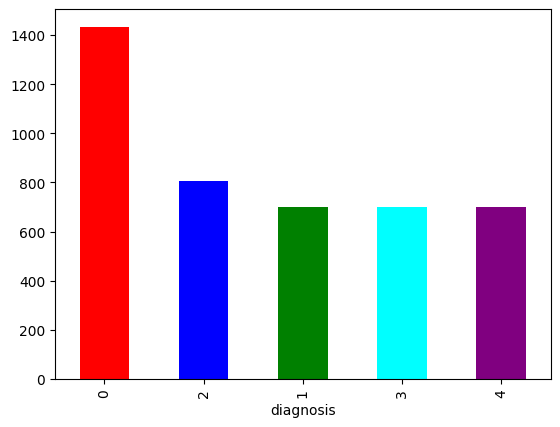

In [21]:
labels_train['diagnosis'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'green', 'cyan', 'purple'])

## Set up transformation

In [22]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),               # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

## Define custom Dataset

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None, preload=True):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.preload = preload

        # Map filenames and labels
        self.filenames = self.labels_df['id_code'].values
        self.labels = self.labels_df['diagnosis'].values

        self.images = []  # qui salveremo le immagini pre-caricate

        if self.preload:
            print("Caricamento immagini in RAM...")
            for fname in tqdm(self.filenames, desc="Caricamento immagini", unit="img"):
                img_path = os.path.join(self.img_dir, fname + ".png")
                image = Image.open(img_path).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                self.images.append(image)
            print(f"Caricate {len(self.images)} immagini in memoria.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if self.preload:
            image = self.images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.filenames[idx] + ".png")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

        label = self.labels[idx]

        # If label is not numeric, convert to class index
        if isinstance(label, str):
            # Optional: map string labels to integers
            # You can build a mapping outside this class
            raise ValueError("Labels are strings. Convert them to int first.")

        return image, label


In [24]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
device

device(type='cuda')

In [25]:
num_cuda_devices = torch.cuda.device_count()
print(f"CUDA è disponibile. Numero di dispositivi GPU: {num_cuda_devices}")

    # (Opzionale) Stampa il nome di ciascun dispositivo
for i in range(num_cuda_devices):
    print(f"Dispositivo {i}: {torch.cuda.get_device_name(i)}")

CUDA è disponibile. Numero di dispositivi GPU: 1
Dispositivo 0: NVIDIA RTX 3000 Ada Generation Laptop GPU


## Create datasets and loaders

In [26]:
if local_runtime==1:
    train_set_preload = True
else:
    train_set_preload = False
    
train_set = CustomImageDataset(augm_train_dir, labels_train, transform=transform, preload=train_set_preload)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = CustomImageDataset(processed_val_dir, labels_val, transform=transform, preload=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_set = CustomImageDataset(processed_test_dir, labels_test, transform=transform, preload=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Caricamento immagini in RAM...


Caricamento immagini: 100%|██████████| 4342/4342 [00:34<00:00, 126.57img/s]

Caricate 4342 immagini in memoria.


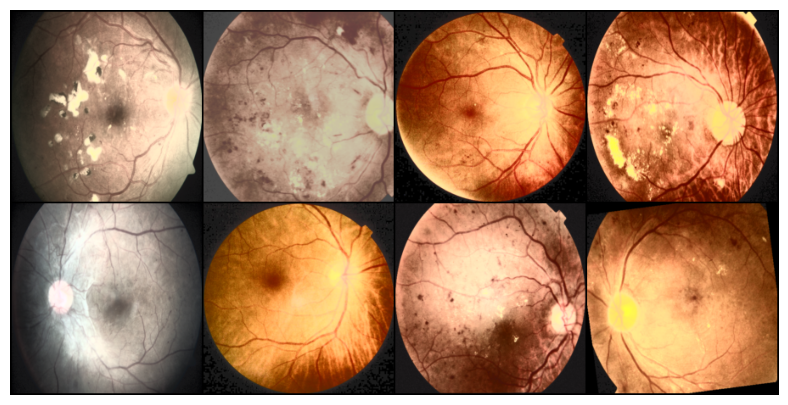

Labels: [2, 3, 2, 2, 4, 0, 2, 4]


In [27]:
# Get one batch from the DataLoader
images, labels = next(iter(train_loader))  # images: [B, 3, 224, 224], labels: [B]

# Denormalize for display (undo ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images = images * std + mean  # undo normalization

# Make a grid of images
grid = torchvision.utils.make_grid(images[:8], nrow=4)  # first 8 images, 4 per row

# Convert to numpy for matplotlib (C,H,W -> H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(10, 5))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

# Print corresponding labels
print("Labels:", labels[:8].tolist())

## Subset Loader

In [42]:
if use_subset_loader == 1:
    num_classes = 5
    samples_per_class = 700

    # Dictionary to hold indices for each class
    class_indices = {c: [] for c in range(num_classes)}

    # Iterate through dataset and collect indices by class
    for idx, row in labels_train.iterrows():
        label = int(row['diagnosis'])
        class_indices[label].append(idx)

    # For each class, randomly sample 200 indices
    subset_indices = []
    for c in range(num_classes):
        chosen = np.random.choice(class_indices[c], samples_per_class, replace=False)
        subset_indices.extend(chosen)

    # Shuffle the final list of subset indices
    np.random.shuffle(subset_indices)

    # Create a subset of the dataset
    subset_dataset = Subset(train_set, subset_indices)

    # Create a new DataLoader for the subset
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

In [43]:
from collections import Counter

if use_subset_loader == 1:
    labels_check = []
    for _, label in subset_dataset:
        labels_check.append(int(label))

    print("Class distribution in subset:", Counter(labels_check))

Class distribution in subset: Counter({0: 700, 2: 700, 1: 700, 4: 700, 3: 700})


In [44]:
if use_subset_loader==1:
    loader_selected = subset_loader
else:
    loader_selected = train_loader

## Helper function for model training and evaluation

In [30]:
def build_optimizer(
    name: str,
    params,
    lr: None
) -> optim.Optimizer:
    """
    Crea un optimizer da stringa. Esempi:
    'adam', 'sgd', 'adamw', 'rmsprop', 'adagrad'
    opt_kwargs: qualunque parametro aggiuntivo (es. weight_decay, momentum...)
    """
    name = name.strip().lower()
    if name == "adam":
        if lr is None:
            return optim.Adam(params)
        else:
            return optim.Adam(params, lr=lr)
    if name == "adamw":
        if lr is None:
            return optim.AdamW(params)
        else:
            return optim.AdamW(params, lr=lr)
    if name == "sgd":
        if lr is None:
            return optim.SGD(params)
        else:
            return optim.SGD(params, lr=lr)
    if name == "rmsprop":
        if lr is None:
            return optim.RMSprop(params)
        else:
            return optim.RMSprop(params, lr=lr)
    if name == "adagrad":
        if lr is None:
            return optim.Adagrad(params)
        else:
            return optim.Adagrad(params, lr=lr)
    raise ValueError(f"Optimizer sconosciuto: '{name}'")

def is_focal_loss(
    name: str
) -> nn.Module:
    name = name.strip().lower()
    if name in ("focal", "focallos"):
        return True
    else:
        return False

def build_criterion(
    name: str
) -> nn.Module:
    """
    Crea una loss da stringa. Esempi:
    'crossentropy', 'bcelogits', 'mse', 'nll', 'smoothl1'
    loss_kwargs: parametri extra (es. weight, reduction, label_smoothing...)
    """
    name = name.strip().lower()
    if name in ("crossentropy", "crossentropyloss", "ce"):
        return nn.CrossEntropyLoss()
    if name in ("bcelogits", "bcelosslogits", "bcelogitsloss"):
        return nn.BCEWithLogitsLoss()
    if name in ("mse", "mseloss", "l2"):
        return nn.MSELoss()
    if name in ("nll", "nllloss"):
        return nn.NLLLoss()
    if name in ("smoothl1", "huber"):
        return nn.SmoothL1Loss()
    if is_focal_loss(name):
        return FocalLoss(gamma=2.0)
    raise ValueError(f"Criterion sconosciuto: '{name}'")

In [31]:
def multiclass_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calcola l'accuracy per classificazione multi-classe (es. 5 classi).
    outputs: tensor [N, num_classes]
    targets: tensor [N]
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / max(1, total)

In [46]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: None,
    optimizer_name: "adam",
    criterion_name: "crossentropy",
    lr: None,
    num_epochs: 5,
    device: None,
    scheduler: None,
    verbose: bool = True,
    model_output_softmax = False
) -> Dict[str, List[float]]:
    """
    Esegue training (e opzionalmente validazione) per num_epochs.
    Ritorna uno storico con 'step_losses', 'epoch_losses', 'val_losses'.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = build_criterion(criterion_name)
    optimizer = build_optimizer(optimizer_name, model.parameters(), lr=lr)
    uses_focal_loss = is_focal_loss(criterion_name)

    history = {
        "step_losses": [],
        "epoch_losses": [],
        "val_losses": [],
        "epoch_acc": [],
        "val_acc": []
    }


    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_iter = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        else:
            train_iter = enumerate(train_loader)

        for _, (images, labels) in train_iter:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if uses_focal_loss and not model_output_softmax:
                loss = criterion(torch.softmax(outputs, dim=-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # --- metriche ---
            acc = multiclass_accuracy(outputs, labels)
            correct_train += acc * labels.size(0)
            total_train += labels.size(0)

            epoch_loss += loss.item()
            history["step_losses"].append(loss.item())

            if verbose:
                if hasattr(train_iter, "set_description"):
                    train_iter.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                if hasattr(train_iter, "set_postfix"):
                    train_iter.set_postfix(loss=loss.item(), acc=acc)

        avg_epoch_loss = epoch_loss / max(1, len(train_loader))
        epoch_acc = correct_train / max(1, total_train)
        history["epoch_losses"].append(avg_epoch_loss)
        history["epoch_acc"].append(epoch_acc)

        # Validazione (se fornito val_loader)
        if val_loader is not None:
            model.eval()
            val_loss_total = 0.0
            correct_val = 0
            total_val = 0
            n_val_batches = 0
            with torch.no_grad():
                val_iter = tqdm(val_loader, total=len(val_loader), leave=False) if verbose else val_loader
                for X_val, Y_val in val_iter:
                    X_val, Y_val = X_val.to(device), Y_val.to(device)
                    Y_pred_val = model(X_val)

                    if uses_focal_loss:
                        loss_val = criterion(torch.softmax(Y_pred_val, dim=-1), Y_val)
                    else:
                        loss_val = criterion(Y_pred_val, Y_val)

                    val_loss_total += loss_val.item()
                    acc_val = multiclass_accuracy(Y_pred_val, Y_val)
                    correct_val += acc_val * Y_val.size(0)
                    total_val += Y_val.size(0)

                    n_val_batches += 1

            avg_val_loss = val_loss_total / max(1, n_val_batches)
            val_acc = correct_val / max(1, total_val)
            history["val_losses"].append(avg_val_loss)
            history["val_acc"].append(val_acc)
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}, validation loss: {avg_val_loss:.4f} validation acc={val_acc:.4f}")
        else:
            # se non c'è validazione, manteniamo lunghezze allineate
            history["val_losses"].append(float('nan'))
            history["val_acc"].append(float('nan'))
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}")

        # Step dello scheduler (se presente)
        if scheduler is not None:
            # Alcuni scheduler richiedono val_loss (es. ReduceLROnPlateau)
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__.lower().startswith('reducelronplateau'):
                last_val = history["val_losses"][-1]
                # usa train loss se non c'è validazione
                metric = last_val if not (last_val != last_val) else avg_epoch_loss
                scheduler.step(metric)
            else:
                scheduler.step()

    return history, model


In [33]:
def plot_history(history, figsize=(15, 5), save_path=None, show=True):
    """
    Mostra (e opzionalmente salva) tre grafici:
      1. Step Losses (per batch)
      2. Epoch Losses (train e validation)
      3. Epoch Accuracy (train e validation)

    Parametri
    ----------
    history : dict
        Dizionario prodotto da train_model, con chiavi:
            - "step_losses": perdite per batch
            - "epoch_losses": perdite medie di training per epoca
            - "val_losses": perdite medie di validazione per epoca
            - "epoch_acc": accuracy di training per epoca
            - "val_acc": accuracy di validazione per epoca
    figsize : tuple
        Dimensioni della figura (default: (15, 4))
    save_path : str, opzionale
        Se specificato, salva il grafico nel percorso indicato.
    show : bool
        Se True mostra il grafico (default: True)
    title : str
        Titolo generale della figura.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- Step losses (batch) ---
    axes[0].plot(history["step_losses"])
    axes[0].set_title("Step Losses")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    # --- Epoch losses (train + val) ---
    axes[1].plot(history["epoch_losses"], label="Training Loss")
    axes[1].plot(history["val_losses"], label="Validation Loss")
    axes[1].set_title("Epoch Losses")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(history.get("epoch_acc", []), label="Training Accuracy", marker='o')
    axes[2].plot(history.get("val_acc", []), label="Validation Accuracy", marker='o')
    axes[2].set_title("Epoch Accuracy")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    #axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()

    return fig, axes


In [34]:
def evaluate_model(
    model,
    test_loader,
    average: str = "macro",
    show_confusion: bool = False
):
    """
    Valuta il modello sul test set e restituisce le metriche principali.

    Parametri
    ----------
    model : torch.nn.Module
        Il modello PyTorch da valutare.
    test_loader : DataLoader
        Dataloader del set di test.
    average : str
        Tipo di media per precision/recall/F1 ("macro", "micro", "weighted", "binary").
    show_confusion : bool
        Se True, stampa anche la matrice di confusione.

    Ritorna
    -------
    metrics : dict
        Dizionario con chiavi:
        - "accuracy"
        - "precision"
        - "recall"
        - "f1"
        - "confusion_matrix" (se show_confusion=True)
    """
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Calcolo metriche ---
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average=average, zero_division=0)
    rec = recall_score(all_labels, all_preds, average=average, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=average, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion:
        metrics["confusion_matrix"] = cm
        print("\nConfusion Matrix:\n", cm)

    print(f"Test Accuracy: {acc * 100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    return metrics, cm


In [35]:
def cleanup_torch_env(model_name: None):
    """
    Pulisce in sicurezza l'ambiente PyTorch:
    - Sposta il modello su CPU (se esiste)
    - Elimina l'optimizer (se esiste)
    - Elimina eventuali variabili temporanee note
    - Esegue garbage collection e svuota la cache GPU

    Parametri
    ----------
    model_name : str
        Nome della variabile modello da spostare su CPU.
    optimizer_name : str
        Nome della variabile optimizer da eliminare.
    """
    # --- Sposta modello su CPU ---
    if model_name in globals():
        globals()[model_name] = globals()[model_name].cpu()
    elif model_name in locals():
        locals()[model_name] = locals()[model_name].cpu()

    # --- Cancella variabili temporanee ---
    temp_vars = [
        'outputs', 'loss', 'images', 'labels',
        'Y_pred_val', 'X_val', 'Y_val',
        'sample_preds_labels', 'sample_labels',
        'sample_images', 'sample_preds',
        'all_labels', 'all_preds'
    ]

    for var in temp_vars:
        if var in globals():
            del globals()[var]
        elif var in locals():
            del locals()[var]

    # --- Garbage collector e cache GPU ---
    gc.collect()
    torch.cuda.empty_cache()

## Grid search helpers

In [47]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

def fig_to_base64(fig) -> str:
    """Converte una figura Matplotlib in stringa base64 PNG e chiude la figura."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return b64

def get_train_size(train_loader) -> int:
    return len(train_loader.dataset)

def run_experiments_to_single_csv(
    model_fn: Callable[[], torch.nn.Module],
    train_loader,
    val_loader,
    test_loader,
    param_grid: Dict[str, List[Any]],
    model_name: str = "model",
    csv_folder = base_path+"/results/",
    num_epochs: int = 5,
    seed: int = 42,
    device: Optional[torch.device] = None,
    model_output_softmax = False
):
    os.makedirs(csv_folder, exist_ok=True)
    """
    Esegue tutte le combinazioni e APPENDE una riga per run a un unico CSV.
    La riga contiene: parametri, dimensioni train set, metriche test, cm (json), plot (base64).
    """
    set_seed(seed)

    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    print(f"Partono {len(combos)} esperimenti...\n")

    # Prepara CSV: scrivi header solo se non esiste
    out_csv_path = csv_folder+model_name+".csv"
    write_header = not os.path.exists(out_csv_path)

    for i, values in enumerate(combos, 1):
        params = {k: v for k, v in zip(keys, values)}
        run_name = f"{model_name}_run_{i:03d}_" + "_".join(f"{k}={v}" for k, v in params.items())
        print(f"[{i}/{len(combos)}] {run_name}")

        # Nuovo modello per ogni run
        model = model_fn()
        train_size = get_train_size(train_loader)

        # Train
        history, model = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer_name=params["optimizer_name"],
                criterion_name=params["criterion_name"],
                lr=params["lr"],
                num_epochs=num_epochs,
                device=device,
                scheduler=None,
                model_output_softmax=model_output_softmax
            )

        # History -> plot -> base64 (niente salvataggi su disco)
        plot_history(history, figsize=(15, 5), save_path=csv_folder+run_name+".png", show=False)

        # Valutazione test (metriche + cm)
        metrics, cm = evaluate_model(
                model=model,
                test_loader=test_loader,
                average="macro",
                show_confusion=False
            )

        # Prepara riga per CSV (cm serializzata in JSON, plot come base64)
        row = {
                "run_name": run_name,
                "optimizer_name": params["optimizer_name"],
                "criterion_name": params["criterion_name"],
                "lr": float(params["lr"]),
                "num_epochs": int(num_epochs),
                "train_size": int(train_size),
                "seed": int(seed),
                "device": str(device),
                "test_accuracy": float(metrics.get("accuracy", float("nan"))),
                "test_precision": float(metrics.get("precision", float("nan"))),
                "test_recall": float(metrics.get("recall", float("nan"))),
                "test_f1": float(metrics.get("f1", float("nan"))),
                "confusion_matrix_json": json.dumps(cm.tolist()),
                "graph_image_name": str(csv_folder+run_name+".png")
            }
        
        # Scrivi/append sul CSV
        df = pd.DataFrame([row])
        df.to_csv(out_csv_path, mode="a", header=write_header, index=False)
        write_header = False  # solo la prima volta

        cleanup_torch_env(model)

    print(f"\nTutte le run sono salvate in: {out_csv_path}")


In [37]:
grid = {
        "optimizer_name": ["sgd", "adam", "adamw"],
        "lr": [1e-4, 1e-3, 5e-3],
        "criterion_name": ["crossentropy", "focal"],
    }

## Define the first model (simple one), train and evaluate it

In [38]:
# define the class

class FMCNN(nn.Module):
    def __init__(self):
        super(FMCNN, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*int(img_size/4)*int(img_size/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FMCNN()
print(model)
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
history, model = train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    num_epochs = 5,
    device = device,
    lr=None,
    scheduler=None
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model")

Partono 18 esperimenti...

[1/18] FMCNN_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5926 train acc=0.3023, validation loss: 1.5232 validation acc=0.6448
Epoch 2/30


Epoch 2 training loss: 1.5594 train acc=0.3740, validation loss: 1.4697 validation acc=0.6639
Epoch 3/30


Epoch 3 training loss: 1.5307 train acc=0.3840, validation loss: 1.4271 validation acc=0.6667
Epoch 4/30


Epoch 4 training loss: 1.5034 train acc=0.4054, validation loss: 1.3666 validation acc=0.6639
Epoch 5/30


Epoch 5 training loss: 1.4777 train acc=0.4137, validation loss: 1.3322 validation acc=0.6503
Epoch 6/30


Epoch 6 training loss: 1.4541 train acc=0.4186, validation loss: 1.2982 validation acc=0.6530
Epoch 7/30


Epoch 7 training loss: 1.4323 train acc=0.4271, validation loss: 1.2622 validation acc=0.6694
Epoch 8/30


Epoch 8 training loss: 1.4134 train acc=0.4306, validation loss: 1.2385 validation acc=0.6557
Epoch 9/30


Epoch 9 training loss: 1.3942 train acc=0.4306, validation loss: 1.2128 validation acc=0.6421
Epoch 10/30


Epoch 10 training loss: 1.3774 train acc=0.4389, validation loss: 1.1904 validation acc=0.6530
Epoch 11/30


Epoch 11 training loss: 1.3613 train acc=0.4386, validation loss: 1.1697 validation acc=0.6393
Epoch 12/30


Epoch 12 training loss: 1.3468 train acc=0.4469, validation loss: 1.1494 validation acc=0.6311
Epoch 13/30


Epoch 13 training loss: 1.3328 train acc=0.4531, validation loss: 1.1269 validation acc=0.6475
Epoch 14/30


Epoch 14 training loss: 1.3208 train acc=0.4597, validation loss: 1.1186 validation acc=0.6311
Epoch 15/30


Epoch 15 training loss: 1.3089 train acc=0.4629, validation loss: 1.1079 validation acc=0.6284
Epoch 16/30


Epoch 16 training loss: 1.2977 train acc=0.4686, validation loss: 1.1032 validation acc=0.6230
Epoch 17/30


Epoch 17 training loss: 1.2868 train acc=0.4709, validation loss: 1.0800 validation acc=0.6230
Epoch 18/30


Epoch 18 training loss: 1.2769 train acc=0.4780, validation loss: 1.0669 validation acc=0.6284
Epoch 19/30


Epoch 19 training loss: 1.2679 train acc=0.4711, validation loss: 1.0615 validation acc=0.6257
Epoch 20/30


Epoch 20 training loss: 1.2600 train acc=0.4794, validation loss: 1.0462 validation acc=0.6202
Epoch 21/30


Epoch 21 training loss: 1.2523 train acc=0.4860, validation loss: 1.0389 validation acc=0.6257
Epoch 22/30


Epoch 22 training loss: 1.2451 train acc=0.4826, validation loss: 1.0442 validation acc=0.6120
Epoch 23/30


Epoch 23 training loss: 1.2378 train acc=0.4800, validation loss: 1.0235 validation acc=0.6230
Epoch 24/30


Epoch 24 training loss: 1.2310 train acc=0.4863, validation loss: 1.0170 validation acc=0.6175
Epoch 25/30


Epoch 25 training loss: 1.2258 train acc=0.4863, validation loss: 1.0183 validation acc=0.6120
Epoch 26/30


Epoch 26 training loss: 1.2183 train acc=0.4900, validation loss: 1.0055 validation acc=0.6120
Epoch 27/30


Epoch 27 training loss: 1.2137 train acc=0.4874, validation loss: 1.0011 validation acc=0.6120
Epoch 28/30


Epoch 28 training loss: 1.2077 train acc=0.4914, validation loss: 1.0016 validation acc=0.6120
Epoch 29/30


Epoch 29 training loss: 1.2039 train acc=0.4957, validation loss: 0.9910 validation acc=0.6202
Epoch 30/30


Epoch 30 training loss: 1.1981 train acc=0.4903, validation loss: 0.9919 validation acc=0.6148
Test Accuracy: 67.49% | Precision: 0.432 | Recall: 0.370 | F1: 0.342
[2/18] FMCNN_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0136 train acc=0.3103, validation loss: 0.9560 validation acc=0.6475
Epoch 2/30


Epoch 2 training loss: 0.9835 train acc=0.3794, validation loss: 0.9159 validation acc=0.6530
Epoch 3/30


Epoch 3 training loss: 0.9567 train acc=0.3951, validation loss: 0.8813 validation acc=0.6448
Epoch 4/30


Epoch 4 training loss: 0.9322 train acc=0.4097, validation loss: 0.8394 validation acc=0.6557
Epoch 5/30


Epoch 5 training loss: 0.9100 train acc=0.4103, validation loss: 0.8188 validation acc=0.6530
Epoch 6/30


Epoch 6 training loss: 0.8899 train acc=0.4169, validation loss: 0.7953 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 0.8721 train acc=0.4203, validation loss: 0.7715 validation acc=0.6421
Epoch 8/30


Epoch 8 training loss: 0.8561 train acc=0.4266, validation loss: 0.7476 validation acc=0.6366
Epoch 9/30


Epoch 9 training loss: 0.8411 train acc=0.4303, validation loss: 0.7239 validation acc=0.6284
Epoch 10/30


Epoch 10 training loss: 0.8285 train acc=0.4340, validation loss: 0.7140 validation acc=0.6093
Epoch 11/30


Epoch 11 training loss: 0.8166 train acc=0.4380, validation loss: 0.7069 validation acc=0.6284
Epoch 12/30


Epoch 12 training loss: 0.8047 train acc=0.4434, validation loss: 0.6782 validation acc=0.6339
Epoch 13/30


Epoch 13 training loss: 0.7952 train acc=0.4489, validation loss: 0.6702 validation acc=0.6230
Epoch 14/30


Epoch 14 training loss: 0.7858 train acc=0.4509, validation loss: 0.6601 validation acc=0.6284
Epoch 15/30


Epoch 15 training loss: 0.7780 train acc=0.4517, validation loss: 0.6573 validation acc=0.6284
Epoch 16/30


Epoch 16 training loss: 0.7696 train acc=0.4583, validation loss: 0.6574 validation acc=0.6311
Epoch 17/30


Epoch 17 training loss: 0.7620 train acc=0.4657, validation loss: 0.6414 validation acc=0.6284
Epoch 18/30


Epoch 18 training loss: 0.7548 train acc=0.4626, validation loss: 0.6364 validation acc=0.6230
Epoch 19/30


Epoch 19 training loss: 0.7482 train acc=0.4669, validation loss: 0.6262 validation acc=0.6339
Epoch 20/30


Epoch 20 training loss: 0.7404 train acc=0.4720, validation loss: 0.6298 validation acc=0.6257
Epoch 21/30


Epoch 21 training loss: 0.7348 train acc=0.4746, validation loss: 0.6265 validation acc=0.6311
Epoch 22/30


Epoch 22 training loss: 0.7282 train acc=0.4751, validation loss: 0.6278 validation acc=0.6093
Epoch 23/30


Epoch 23 training loss: 0.7233 train acc=0.4797, validation loss: 0.6158 validation acc=0.6175
Epoch 24/30


Epoch 24 training loss: 0.7172 train acc=0.4849, validation loss: 0.6194 validation acc=0.6393
Epoch 25/30


Epoch 25 training loss: 0.7129 train acc=0.4866, validation loss: 0.6050 validation acc=0.6339
Epoch 26/30


Epoch 26 training loss: 0.7071 train acc=0.4897, validation loss: 0.5998 validation acc=0.6311
Epoch 27/30


Epoch 27 training loss: 0.7022 train acc=0.4900, validation loss: 0.6181 validation acc=0.6257
Epoch 28/30


Epoch 28 training loss: 0.6987 train acc=0.5034, validation loss: 0.5895 validation acc=0.6393
Epoch 29/30


Epoch 29 training loss: 0.6929 train acc=0.4991, validation loss: 0.5925 validation acc=0.6230
Epoch 30/30


Epoch 30 training loss: 0.6894 train acc=0.5011, validation loss: 0.5860 validation acc=0.6257
Test Accuracy: 67.76% | Precision: 0.362 | Recall: 0.378 | F1: 0.349
[3/18] FMCNN_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4827 train acc=0.3551, validation loss: 1.2212 validation acc=0.5519
Epoch 2/30


Epoch 2 training loss: 1.3159 train acc=0.4346, validation loss: 1.1210 validation acc=0.5601
Epoch 3/30


Epoch 3 training loss: 1.2369 train acc=0.4697, validation loss: 1.0632 validation acc=0.6093
Epoch 4/30


Epoch 4 training loss: 1.1938 train acc=0.4863, validation loss: 0.9205 validation acc=0.6585
Epoch 5/30


Epoch 5 training loss: 1.1572 train acc=0.5111, validation loss: 0.9379 validation acc=0.6639
Epoch 6/30


Epoch 6 training loss: 1.1408 train acc=0.5123, validation loss: 0.9083 validation acc=0.6421
Epoch 7/30


Epoch 7 training loss: 1.1169 train acc=0.5220, validation loss: 0.8564 validation acc=0.6831
Epoch 8/30


Epoch 8 training loss: 1.1013 train acc=0.5289, validation loss: 0.8616 validation acc=0.6721
Epoch 9/30


Epoch 9 training loss: 1.0828 train acc=0.5349, validation loss: 0.8316 validation acc=0.6776
Epoch 10/30


Epoch 10 training loss: 1.0669 train acc=0.5489, validation loss: 0.8287 validation acc=0.6776
Epoch 11/30


Epoch 11 training loss: 1.0617 train acc=0.5546, validation loss: 0.9267 validation acc=0.6721
Epoch 12/30


Epoch 12 training loss: 1.0475 train acc=0.5589, validation loss: 0.8682 validation acc=0.6776
Epoch 13/30


Epoch 13 training loss: 1.0329 train acc=0.5757, validation loss: 0.9345 validation acc=0.6230
Epoch 14/30


Epoch 14 training loss: 1.0269 train acc=0.5809, validation loss: 0.9421 validation acc=0.6557
Epoch 15/30


Epoch 15 training loss: 1.0099 train acc=0.5726, validation loss: 0.8449 validation acc=0.6749
Epoch 16/30


Epoch 16 training loss: 1.0138 train acc=0.5800, validation loss: 0.8412 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 1.0001 train acc=0.5823, validation loss: 0.8198 validation acc=0.7077
Epoch 18/30


Epoch 18 training loss: 1.0014 train acc=0.5749, validation loss: 0.8159 validation acc=0.6885
Epoch 19/30


Epoch 19 training loss: 0.9781 train acc=0.5991, validation loss: 0.8131 validation acc=0.7049
Epoch 20/30


Epoch 20 training loss: 0.9786 train acc=0.5969, validation loss: 0.8272 validation acc=0.7022
Epoch 21/30


Epoch 21 training loss: 0.9815 train acc=0.5883, validation loss: 0.8254 validation acc=0.6967
Epoch 22/30


Epoch 22 training loss: 0.9670 train acc=0.5880, validation loss: 0.8633 validation acc=0.6749
Epoch 23/30


Epoch 23 training loss: 0.9600 train acc=0.6037, validation loss: 0.7986 validation acc=0.7131
Epoch 24/30


Epoch 24 training loss: 0.9449 train acc=0.6134, validation loss: 0.8013 validation acc=0.7022
Epoch 25/30


Epoch 25 training loss: 0.9428 train acc=0.6100, validation loss: 0.8243 validation acc=0.7049
Epoch 26/30


Epoch 26 training loss: 0.9313 train acc=0.6191, validation loss: 0.7953 validation acc=0.7077
Epoch 27/30


Epoch 27 training loss: 0.9267 train acc=0.6280, validation loss: 0.8314 validation acc=0.7131
Epoch 28/30


Epoch 28 training loss: 0.9135 train acc=0.6331, validation loss: 0.9082 validation acc=0.6011
Epoch 29/30


Epoch 29 training loss: 0.9176 train acc=0.6260, validation loss: 0.7977 validation acc=0.7049
Epoch 30/30


Epoch 30 training loss: 0.9108 train acc=0.6326, validation loss: 0.7965 validation acc=0.7131
Test Accuracy: 72.95% | Precision: 0.485 | Recall: 0.464 | F1: 0.435
[4/18] FMCNN_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.8992 train acc=0.3857, validation loss: 0.6946 validation acc=0.5464
Epoch 2/30


Epoch 2 training loss: 0.7632 train acc=0.4500, validation loss: 0.6494 validation acc=0.6011
Epoch 3/30


Epoch 3 training loss: 0.7045 train acc=0.4800, validation loss: 0.6000 validation acc=0.6366
Epoch 4/30


Epoch 4 training loss: 0.6696 train acc=0.4960, validation loss: 0.5343 validation acc=0.6421
Epoch 5/30


Epoch 5 training loss: 0.6448 train acc=0.5106, validation loss: 0.5526 validation acc=0.6585
Epoch 6/30


Epoch 6 training loss: 0.6254 train acc=0.5246, validation loss: 0.5882 validation acc=0.6311
Epoch 7/30


Epoch 7 training loss: 0.6097 train acc=0.5320, validation loss: 0.5626 validation acc=0.6557
Epoch 8/30


Epoch 8 training loss: 0.5942 train acc=0.5443, validation loss: 0.5025 validation acc=0.6503
Epoch 9/30


Epoch 9 training loss: 0.5859 train acc=0.5471, validation loss: 0.4944 validation acc=0.6612
Epoch 10/30


Epoch 10 training loss: 0.5764 train acc=0.5574, validation loss: 0.4800 validation acc=0.6721
Epoch 11/30


Epoch 11 training loss: 0.5680 train acc=0.5617, validation loss: 0.4965 validation acc=0.6776
Epoch 12/30


Epoch 12 training loss: 0.5565 train acc=0.5726, validation loss: 0.5399 validation acc=0.6339
Epoch 13/30


Epoch 13 training loss: 0.5477 train acc=0.5783, validation loss: 0.5002 validation acc=0.6776
Epoch 14/30


Epoch 14 training loss: 0.5404 train acc=0.5731, validation loss: 0.4635 validation acc=0.7049
Epoch 15/30


Epoch 15 training loss: 0.5344 train acc=0.5726, validation loss: 0.4947 validation acc=0.6749
Epoch 16/30


Epoch 16 training loss: 0.5283 train acc=0.5877, validation loss: 0.6105 validation acc=0.5191
Epoch 17/30


Epoch 17 training loss: 0.5242 train acc=0.5934, validation loss: 0.4438 validation acc=0.7131
Epoch 18/30


Epoch 18 training loss: 0.5212 train acc=0.5883, validation loss: 0.4872 validation acc=0.6831
Epoch 19/30


Epoch 19 training loss: 0.5066 train acc=0.5960, validation loss: 0.5234 validation acc=0.6093
Epoch 20/30


Epoch 20 training loss: 0.5086 train acc=0.6006, validation loss: 0.5093 validation acc=0.6694
Epoch 21/30


Epoch 21 training loss: 0.4971 train acc=0.6086, validation loss: 0.4723 validation acc=0.6858
Epoch 22/30


Epoch 22 training loss: 0.4928 train acc=0.6103, validation loss: 0.4712 validation acc=0.7104
Epoch 23/30


Epoch 23 training loss: 0.4854 train acc=0.6111, validation loss: 0.5065 validation acc=0.6585
Epoch 24/30


Epoch 24 training loss: 0.4814 train acc=0.6137, validation loss: 0.4758 validation acc=0.6967
Epoch 25/30


Epoch 25 training loss: 0.4702 train acc=0.6266, validation loss: 0.4305 validation acc=0.7104
Epoch 26/30


Epoch 26 training loss: 0.4690 train acc=0.6240, validation loss: 0.4389 validation acc=0.7240
Epoch 27/30


Epoch 27 training loss: 0.4645 train acc=0.6266, validation loss: 0.4339 validation acc=0.7077
Epoch 28/30


Epoch 28 training loss: 0.4555 train acc=0.6351, validation loss: 0.5098 validation acc=0.6612
Epoch 29/30


Epoch 29 training loss: 0.4572 train acc=0.6334, validation loss: 0.4607 validation acc=0.7022
Epoch 30/30


Epoch 30 training loss: 0.4509 train acc=0.6391, validation loss: 0.4866 validation acc=0.6776
Test Accuracy: 70.22% | Precision: 0.495 | Recall: 0.434 | F1: 0.412
[5/18] FMCNN_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3951 train acc=0.3886, validation loss: 0.9911 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 1.2291 train acc=0.4660, validation loss: 1.0629 validation acc=0.5847
Epoch 3/30


Epoch 3 training loss: 1.1787 train acc=0.4771, validation loss: 0.9127 validation acc=0.6612
Epoch 4/30


Epoch 4 training loss: 1.1432 train acc=0.5137, validation loss: 0.8868 validation acc=0.6421
Epoch 5/30


Epoch 5 training loss: 1.1031 train acc=0.5197, validation loss: 1.1427 validation acc=0.6011
Epoch 6/30


Epoch 6 training loss: 1.0864 train acc=0.5431, validation loss: 0.9237 validation acc=0.6257
Epoch 7/30


Epoch 7 training loss: 1.0649 train acc=0.5454, validation loss: 0.8931 validation acc=0.6749
Epoch 8/30


Epoch 8 training loss: 1.0575 train acc=0.5423, validation loss: 0.8302 validation acc=0.6831
Epoch 9/30


Epoch 9 training loss: 1.0550 train acc=0.5537, validation loss: 1.1568 validation acc=0.5328
Epoch 10/30


Epoch 10 training loss: 1.0226 train acc=0.5580, validation loss: 0.8015 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 1.0161 train acc=0.5669, validation loss: 0.8434 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.9978 train acc=0.5754, validation loss: 0.9235 validation acc=0.6585
Epoch 13/30


Epoch 13 training loss: 0.9954 train acc=0.5771, validation loss: 0.9969 validation acc=0.6284
Epoch 14/30


Epoch 14 training loss: 0.9711 train acc=0.5920, validation loss: 0.7923 validation acc=0.6831
Epoch 15/30


Epoch 15 training loss: 0.9658 train acc=0.5849, validation loss: 0.7789 validation acc=0.7322
Epoch 16/30


Epoch 16 training loss: 0.9647 train acc=0.5946, validation loss: 1.3070 validation acc=0.4781
Epoch 17/30


Epoch 17 training loss: 0.9495 train acc=0.6106, validation loss: 0.9392 validation acc=0.6366
Epoch 18/30


Epoch 18 training loss: 0.9272 train acc=0.6240, validation loss: 0.9475 validation acc=0.6421
Epoch 19/30


Epoch 19 training loss: 0.9226 train acc=0.6163, validation loss: 0.8087 validation acc=0.7158
Epoch 20/30


Epoch 20 training loss: 0.9152 train acc=0.6249, validation loss: 0.7918 validation acc=0.7213
Epoch 21/30


Epoch 21 training loss: 0.8898 train acc=0.6337, validation loss: 0.9436 validation acc=0.6202
Epoch 22/30


Epoch 22 training loss: 0.8962 train acc=0.6234, validation loss: 0.8794 validation acc=0.6694
Epoch 23/30


Epoch 23 training loss: 0.8802 train acc=0.6414, validation loss: 0.8758 validation acc=0.6940
Epoch 24/30


Epoch 24 training loss: 0.8646 train acc=0.6626, validation loss: 0.7911 validation acc=0.7049
Epoch 25/30


Epoch 25 training loss: 0.8587 train acc=0.6480, validation loss: 1.1069 validation acc=0.5601
Epoch 26/30


Epoch 26 training loss: 0.8396 train acc=0.6591, validation loss: 0.8326 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.8116 train acc=0.6671, validation loss: 0.8188 validation acc=0.6885
Epoch 28/30


Epoch 28 training loss: 0.8138 train acc=0.6720, validation loss: 0.8645 validation acc=0.7104
Epoch 29/30


Epoch 29 training loss: 0.7624 train acc=0.7091, validation loss: 0.9133 validation acc=0.6530
Epoch 30/30


Epoch 30 training loss: 0.7575 train acc=0.7083, validation loss: 0.9348 validation acc=0.6885
Test Accuracy: 68.58% | Precision: 0.376 | Recall: 0.457 | F1: 0.373
[6/18] FMCNN_run_006_optimizer_name=sgd_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.9511 train acc=0.3197, validation loss: 0.7016 validation acc=0.5301
Epoch 2/30


Epoch 2 training loss: 0.7432 train acc=0.4537, validation loss: 0.6734 validation acc=0.4973
Epoch 3/30


Epoch 3 training loss: 0.6798 train acc=0.4734, validation loss: 0.5131 validation acc=0.6503
Epoch 4/30


Epoch 4 training loss: 0.6486 train acc=0.4903, validation loss: 0.5686 validation acc=0.6202
Epoch 5/30


Epoch 5 training loss: 0.6136 train acc=0.5183, validation loss: 0.4749 validation acc=0.6776
Epoch 6/30


Epoch 6 training loss: 0.5954 train acc=0.5206, validation loss: 0.5149 validation acc=0.6612
Epoch 7/30


Epoch 7 training loss: 0.5818 train acc=0.5220, validation loss: 0.4815 validation acc=0.6667
Epoch 8/30


Epoch 8 training loss: 0.5738 train acc=0.5363, validation loss: 0.4861 validation acc=0.6612
Epoch 9/30


Epoch 9 training loss: 0.5636 train acc=0.5474, validation loss: 0.4638 validation acc=0.6803
Epoch 10/30


Epoch 10 training loss: 0.5512 train acc=0.5551, validation loss: 0.4813 validation acc=0.6749
Epoch 11/30


Epoch 11 training loss: 0.5413 train acc=0.5577, validation loss: 0.5629 validation acc=0.6202
Epoch 12/30


Epoch 12 training loss: 0.5338 train acc=0.5609, validation loss: 0.4422 validation acc=0.6995
Epoch 13/30


Epoch 13 training loss: 0.5212 train acc=0.5731, validation loss: 0.4711 validation acc=0.6913
Epoch 14/30


Epoch 14 training loss: 0.5165 train acc=0.5697, validation loss: 0.4434 validation acc=0.7022
Epoch 15/30


Epoch 15 training loss: 0.5064 train acc=0.5877, validation loss: 0.4589 validation acc=0.7049
Epoch 16/30


Epoch 16 training loss: 0.4941 train acc=0.5974, validation loss: 0.5900 validation acc=0.5792
Epoch 17/30


Epoch 17 training loss: 0.4855 train acc=0.5963, validation loss: 0.4367 validation acc=0.7104
Epoch 18/30


Epoch 18 training loss: 0.4816 train acc=0.6031, validation loss: 0.7092 validation acc=0.4973
Epoch 19/30


Epoch 19 training loss: 0.4860 train acc=0.5943, validation loss: 0.4296 validation acc=0.6940
Epoch 20/30


Epoch 20 training loss: 0.4620 train acc=0.6277, validation loss: 0.4382 validation acc=0.7158
Epoch 21/30


Epoch 21 training loss: 0.4491 train acc=0.6240, validation loss: 0.4341 validation acc=0.7186
Epoch 22/30


Epoch 22 training loss: 0.4461 train acc=0.6320, validation loss: 0.4647 validation acc=0.6448
Epoch 23/30


Epoch 23 training loss: 0.4557 train acc=0.6263, validation loss: 0.4769 validation acc=0.6940
Epoch 24/30


Epoch 24 training loss: 0.4328 train acc=0.6389, validation loss: 0.4414 validation acc=0.6831
Epoch 25/30


Epoch 25 training loss: 0.4267 train acc=0.6466, validation loss: 0.4323 validation acc=0.7240
Epoch 26/30


Epoch 26 training loss: 0.4073 train acc=0.6486, validation loss: 0.4454 validation acc=0.7240
Epoch 27/30


Epoch 27 training loss: 0.4043 train acc=0.6657, validation loss: 0.5471 validation acc=0.6475
Epoch 28/30


Epoch 28 training loss: 0.4101 train acc=0.6591, validation loss: 0.5208 validation acc=0.6503
Epoch 29/30


Epoch 29 training loss: 0.3951 train acc=0.6660, validation loss: 0.4722 validation acc=0.6803
Epoch 30/30


Epoch 30 training loss: 0.3781 train acc=0.6783, validation loss: 0.4203 validation acc=0.7514
Test Accuracy: 74.59% | Precision: 0.532 | Recall: 0.495 | F1: 0.471
[7/18] FMCNN_run_007_optimizer_name=adam_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3459 train acc=0.4354, validation loss: 0.8740 validation acc=0.6393
Epoch 2/30


Epoch 2 training loss: 1.1122 train acc=0.5257, validation loss: 0.8726 validation acc=0.6639
Epoch 3/30


Epoch 3 training loss: 1.0186 train acc=0.5891, validation loss: 0.8098 validation acc=0.7049
Epoch 4/30


Epoch 4 training loss: 0.9503 train acc=0.6191, validation loss: 0.7916 validation acc=0.7158
Epoch 5/30


Epoch 5 training loss: 0.8782 train acc=0.6623, validation loss: 0.9139 validation acc=0.6475
Epoch 6/30


Epoch 6 training loss: 0.8051 train acc=0.6889, validation loss: 0.7668 validation acc=0.6995
Epoch 7/30


Epoch 7 training loss: 0.7471 train acc=0.7260, validation loss: 0.7761 validation acc=0.7240
Epoch 8/30


Epoch 8 training loss: 0.7014 train acc=0.7389, validation loss: 0.7530 validation acc=0.7240
Epoch 9/30


Epoch 9 training loss: 0.6103 train acc=0.7883, validation loss: 0.7520 validation acc=0.7186
Epoch 10/30


Epoch 10 training loss: 0.5584 train acc=0.8151, validation loss: 0.7884 validation acc=0.7131
Epoch 11/30


Epoch 11 training loss: 0.4989 train acc=0.8326, validation loss: 0.7546 validation acc=0.7295
Epoch 12/30


Epoch 12 training loss: 0.4749 train acc=0.8420, validation loss: 0.9000 validation acc=0.6913
Epoch 13/30


Epoch 13 training loss: 0.4094 train acc=0.8766, validation loss: 0.8174 validation acc=0.7213
Epoch 14/30


Epoch 14 training loss: 0.3492 train acc=0.9009, validation loss: 0.8557 validation acc=0.7240
Epoch 15/30


Epoch 15 training loss: 0.3154 train acc=0.9186, validation loss: 0.8217 validation acc=0.7322
Epoch 16/30


Epoch 16 training loss: 0.2654 train acc=0.9374, validation loss: 0.8623 validation acc=0.7322
Epoch 17/30


Epoch 17 training loss: 0.2247 train acc=0.9511, validation loss: 0.9350 validation acc=0.7022
Epoch 18/30


Epoch 18 training loss: 0.1960 train acc=0.9640, validation loss: 0.9688 validation acc=0.7240
Epoch 19/30


Epoch 19 training loss: 0.1743 train acc=0.9686, validation loss: 0.9776 validation acc=0.7131
Epoch 20/30


Epoch 20 training loss: 0.1622 train acc=0.9669, validation loss: 0.9320 validation acc=0.7432
Epoch 21/30


Epoch 21 training loss: 0.1397 train acc=0.9723, validation loss: 1.0234 validation acc=0.7240
Epoch 22/30


Epoch 22 training loss: 0.1195 train acc=0.9811, validation loss: 0.9966 validation acc=0.7322
Epoch 23/30


Epoch 23 training loss: 0.1106 train acc=0.9803, validation loss: 1.0334 validation acc=0.7432
Epoch 24/30


Epoch 24 training loss: 0.0944 train acc=0.9860, validation loss: 1.0708 validation acc=0.7377
Epoch 25/30


Epoch 25 training loss: 0.0899 train acc=0.9857, validation loss: 1.1241 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.0901 train acc=0.9834, validation loss: 1.1822 validation acc=0.6831
Epoch 27/30


Epoch 27 training loss: 0.0797 train acc=0.9883, validation loss: 1.1599 validation acc=0.7131
Epoch 28/30


Epoch 28 training loss: 0.0658 train acc=0.9894, validation loss: 1.1468 validation acc=0.7131
Epoch 29/30


Epoch 29 training loss: 0.0609 train acc=0.9906, validation loss: 1.1943 validation acc=0.7022
Epoch 30/30


Epoch 30 training loss: 0.0600 train acc=0.9914, validation loss: 1.2273 validation acc=0.7213
Test Accuracy: 75.41% | Precision: 0.585 | Recall: 0.534 | F1: 0.517
[8/18] FMCNN_run_008_optimizer_name=adam_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7869 train acc=0.4460, validation loss: 0.5700 validation acc=0.6038
Epoch 2/30


Epoch 2 training loss: 0.5668 train acc=0.5543, validation loss: 0.4669 validation acc=0.6667
Epoch 3/30


Epoch 3 training loss: 0.4801 train acc=0.6320, validation loss: 0.4344 validation acc=0.7049
Epoch 4/30


Epoch 4 training loss: 0.4079 train acc=0.6789, validation loss: 0.4877 validation acc=0.6749
Epoch 5/30


Epoch 5 training loss: 0.3423 train acc=0.7386, validation loss: 0.4365 validation acc=0.7158
Epoch 6/30


Epoch 6 training loss: 0.2899 train acc=0.7714, validation loss: 0.3957 validation acc=0.7350
Epoch 7/30


Epoch 7 training loss: 0.2381 train acc=0.8254, validation loss: 0.4614 validation acc=0.7131
Epoch 8/30


Epoch 8 training loss: 0.2087 train acc=0.8431, validation loss: 0.5023 validation acc=0.6530
Epoch 9/30


Epoch 9 training loss: 0.1719 train acc=0.8737, validation loss: 0.4797 validation acc=0.7158
Epoch 10/30


Epoch 10 training loss: 0.1339 train acc=0.9103, validation loss: 0.4670 validation acc=0.7404
Epoch 11/30


Epoch 11 training loss: 0.1344 train acc=0.8909, validation loss: 0.4851 validation acc=0.7295
Epoch 12/30


Epoch 12 training loss: 0.1012 train acc=0.9343, validation loss: 0.4783 validation acc=0.7077
Epoch 13/30


Epoch 13 training loss: 0.0818 train acc=0.9489, validation loss: 0.4826 validation acc=0.7377
Epoch 14/30


Epoch 14 training loss: 0.0659 train acc=0.9589, validation loss: 0.4897 validation acc=0.7240
Epoch 15/30


Epoch 15 training loss: 0.0664 train acc=0.9600, validation loss: 0.4838 validation acc=0.7404
Epoch 16/30


Epoch 16 training loss: 0.0516 train acc=0.9706, validation loss: 0.5030 validation acc=0.7377
Epoch 17/30


Epoch 17 training loss: 0.0443 train acc=0.9769, validation loss: 0.5524 validation acc=0.7186
Epoch 18/30


Epoch 18 training loss: 0.0371 train acc=0.9829, validation loss: 0.5883 validation acc=0.7213
Epoch 19/30


Epoch 19 training loss: 0.0383 train acc=0.9771, validation loss: 0.6910 validation acc=0.6475
Epoch 20/30


Epoch 20 training loss: 0.0337 train acc=0.9834, validation loss: 0.5673 validation acc=0.7213
Epoch 21/30


Epoch 21 training loss: 0.0300 train acc=0.9837, validation loss: 0.5607 validation acc=0.7213
Epoch 22/30


Epoch 22 training loss: 0.0299 train acc=0.9846, validation loss: 0.6587 validation acc=0.6639
Epoch 23/30


Epoch 23 training loss: 0.0229 train acc=0.9880, validation loss: 0.5626 validation acc=0.7350
Epoch 24/30


Epoch 24 training loss: 0.0198 train acc=0.9894, validation loss: 0.6138 validation acc=0.7104
Epoch 25/30


Epoch 25 training loss: 0.0279 train acc=0.9869, validation loss: 0.6644 validation acc=0.7295
Epoch 26/30


Epoch 26 training loss: 0.0204 train acc=0.9883, validation loss: 0.5856 validation acc=0.7240
Epoch 27/30


Epoch 27 training loss: 0.0234 train acc=0.9877, validation loss: 0.7307 validation acc=0.6585
Epoch 28/30


Epoch 28 training loss: 0.0209 train acc=0.9869, validation loss: 0.6465 validation acc=0.7268
Epoch 29/30


Epoch 29 training loss: 0.0199 train acc=0.9900, validation loss: 0.6830 validation acc=0.7240
Epoch 30/30


Epoch 30 training loss: 0.0214 train acc=0.9903, validation loss: 0.6028 validation acc=0.7377
Test Accuracy: 74.32% | Precision: 0.548 | Recall: 0.549 | F1: 0.537
[9/18] FMCNN_run_009_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 2.1388 train acc=0.4051, validation loss: 0.9121 validation acc=0.6393
Epoch 2/30


Epoch 2 training loss: 1.0300 train acc=0.5754, validation loss: 0.7707 validation acc=0.6776
Epoch 3/30


Epoch 3 training loss: 0.8724 train acc=0.6477, validation loss: 0.7571 validation acc=0.7022
Epoch 4/30


Epoch 4 training loss: 0.6777 train acc=0.7454, validation loss: 0.8211 validation acc=0.6995
Epoch 5/30


Epoch 5 training loss: 0.4779 train acc=0.8311, validation loss: 0.9707 validation acc=0.6339
Epoch 6/30


Epoch 6 training loss: 0.3163 train acc=0.9017, validation loss: 1.0894 validation acc=0.6831
Epoch 7/30


Epoch 7 training loss: 0.1874 train acc=0.9480, validation loss: 1.1502 validation acc=0.6940
Epoch 8/30


Epoch 8 training loss: 0.1191 train acc=0.9746, validation loss: 1.4072 validation acc=0.6448
Epoch 9/30


Epoch 9 training loss: 0.0839 train acc=0.9837, validation loss: 1.4198 validation acc=0.6803
Epoch 10/30


Epoch 10 training loss: 0.0799 train acc=0.9834, validation loss: 1.4035 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 0.0632 train acc=0.9883, validation loss: 1.4598 validation acc=0.6639
Epoch 12/30


Epoch 12 training loss: 0.0660 train acc=0.9883, validation loss: 1.3662 validation acc=0.7077
Epoch 13/30


Epoch 13 training loss: 0.0638 train acc=0.9886, validation loss: 1.3264 validation acc=0.7022
Epoch 14/30


Epoch 14 training loss: 0.0534 train acc=0.9903, validation loss: 1.4938 validation acc=0.6639
Epoch 15/30


Epoch 15 training loss: 0.0563 train acc=0.9903, validation loss: 1.5026 validation acc=0.6421
Epoch 16/30


Epoch 16 training loss: 0.0483 train acc=0.9900, validation loss: 1.5815 validation acc=0.6667
Epoch 17/30


Epoch 17 training loss: 0.0500 train acc=0.9897, validation loss: 1.3649 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.0476 train acc=0.9897, validation loss: 1.5041 validation acc=0.6995
Epoch 19/30


Epoch 19 training loss: 0.0493 train acc=0.9889, validation loss: 1.5657 validation acc=0.6639
Epoch 20/30


Epoch 20 training loss: 0.0440 train acc=0.9903, validation loss: 1.3773 validation acc=0.7213
Epoch 21/30


Epoch 21 training loss: 0.0375 train acc=0.9909, validation loss: 1.4679 validation acc=0.7049
Epoch 22/30


Epoch 22 training loss: 0.0421 train acc=0.9900, validation loss: 1.3821 validation acc=0.7104
Epoch 23/30


Epoch 23 training loss: 0.0404 train acc=0.9906, validation loss: 1.5587 validation acc=0.6612
Epoch 24/30


Epoch 24 training loss: 0.0327 train acc=0.9917, validation loss: 1.4719 validation acc=0.6940
Epoch 25/30


Epoch 25 training loss: 0.0358 train acc=0.9903, validation loss: 1.4423 validation acc=0.6940
Epoch 26/30


Epoch 26 training loss: 0.0332 train acc=0.9900, validation loss: 1.2393 validation acc=0.7049
Epoch 27/30


Epoch 27 training loss: 0.0274 train acc=0.9909, validation loss: 1.3640 validation acc=0.7022
Epoch 28/30


Epoch 28 training loss: 0.0352 train acc=0.9906, validation loss: 1.4325 validation acc=0.7268
Epoch 29/30


Epoch 29 training loss: 0.0343 train acc=0.9906, validation loss: 1.4526 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 0.0306 train acc=0.9906, validation loss: 1.4560 validation acc=0.7131
Test Accuracy: 74.04% | Precision: 0.524 | Recall: 0.515 | F1: 0.514
[10/18] FMCNN_run_010_optimizer_name=adam_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 2.3680 train acc=0.4289, validation loss: 0.4830 validation acc=0.6694
Epoch 2/30


Epoch 2 training loss: 0.5015 train acc=0.6014, validation loss: 0.4140 validation acc=0.7158
Epoch 3/30


Epoch 3 training loss: 0.3771 train acc=0.7026, validation loss: 0.4603 validation acc=0.7104
Epoch 4/30


Epoch 4 training loss: 0.2430 train acc=0.8040, validation loss: 0.5008 validation acc=0.6831
Epoch 5/30


Epoch 5 training loss: 0.1485 train acc=0.8731, validation loss: 0.5170 validation acc=0.6940
Epoch 6/30


Epoch 6 training loss: 0.0775 train acc=0.9380, validation loss: 0.5771 validation acc=0.7131
Epoch 7/30


Epoch 7 training loss: 0.0545 train acc=0.9671, validation loss: 0.5996 validation acc=0.6995
Epoch 8/30


Epoch 8 training loss: 0.0422 train acc=0.9789, validation loss: 0.5957 validation acc=0.7131
Epoch 9/30


Epoch 9 training loss: 0.0379 train acc=0.9857, validation loss: 0.6151 validation acc=0.7104
Epoch 10/30


Epoch 10 training loss: 0.0335 train acc=0.9857, validation loss: 0.6216 validation acc=0.7158
Epoch 11/30


Epoch 11 training loss: 0.0290 train acc=0.9880, validation loss: 0.6502 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.0287 train acc=0.9894, validation loss: 0.6495 validation acc=0.7022
Epoch 13/30


Epoch 13 training loss: 0.0257 train acc=0.9897, validation loss: 0.6759 validation acc=0.7022
Epoch 14/30


Epoch 14 training loss: 0.0223 train acc=0.9883, validation loss: 0.7155 validation acc=0.6831
Epoch 15/30


Epoch 15 training loss: 0.0252 train acc=0.9886, validation loss: 0.6141 validation acc=0.7240
Epoch 16/30


Epoch 16 training loss: 0.0174 train acc=0.9900, validation loss: 0.8006 validation acc=0.6421
Epoch 17/30


Epoch 17 training loss: 0.0204 train acc=0.9883, validation loss: 0.7232 validation acc=0.7295
Epoch 18/30


Epoch 18 training loss: 0.0198 train acc=0.9911, validation loss: 0.6593 validation acc=0.6967
Epoch 19/30


Epoch 19 training loss: 0.0190 train acc=0.9906, validation loss: 0.6860 validation acc=0.7049
Epoch 20/30


Epoch 20 training loss: 0.0170 train acc=0.9903, validation loss: 0.6601 validation acc=0.7022
Epoch 21/30


Epoch 21 training loss: 0.0157 train acc=0.9911, validation loss: 0.6173 validation acc=0.7022
Epoch 22/30


Epoch 22 training loss: 0.0163 train acc=0.9903, validation loss: 0.6675 validation acc=0.7158
Epoch 23/30


Epoch 23 training loss: 0.0130 train acc=0.9911, validation loss: 0.6779 validation acc=0.7295
Epoch 24/30


Epoch 24 training loss: 0.0176 train acc=0.9883, validation loss: 0.6985 validation acc=0.7268
Epoch 25/30


Epoch 25 training loss: 0.0111 train acc=0.9909, validation loss: 0.6549 validation acc=0.7022
Epoch 26/30


Epoch 26 training loss: 0.0129 train acc=0.9903, validation loss: 0.6129 validation acc=0.7104
Epoch 27/30


Epoch 27 training loss: 0.0129 train acc=0.9911, validation loss: 0.6330 validation acc=0.7268
Epoch 28/30


Epoch 28 training loss: 0.0131 train acc=0.9920, validation loss: 0.6771 validation acc=0.7158
Epoch 29/30


Epoch 29 training loss: 0.0129 train acc=0.9906, validation loss: 0.6467 validation acc=0.7213
Epoch 30/30


Epoch 30 training loss: 0.0129 train acc=0.9909, validation loss: 0.6581 validation acc=0.7186
Test Accuracy: 72.40% | Precision: 0.521 | Recall: 0.546 | F1: 0.526
[11/18] FMCNN_run_011_optimizer_name=adam_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 4.5706 train acc=0.1957, validation loss: 1.6170 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 1.6100 train acc=0.1937, validation loss: 1.6097 validation acc=0.2842
Epoch 3/30


Epoch 3 training loss: 1.6098 train acc=0.1923, validation loss: 1.6129 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 1.6099 train acc=0.1994, validation loss: 1.6099 validation acc=0.2842
Epoch 5/30


Epoch 5 training loss: 1.6099 train acc=0.1920, validation loss: 1.6121 validation acc=0.0765
Epoch 6/30


Epoch 6 training loss: 1.6099 train acc=0.1997, validation loss: 1.6121 validation acc=0.1093
Epoch 7/30


Epoch 7 training loss: 1.6101 train acc=0.1846, validation loss: 1.6141 validation acc=0.0601
Epoch 8/30


Epoch 8 training loss: 1.6100 train acc=0.1871, validation loss: 1.6077 validation acc=0.4699
Epoch 9/30


Epoch 9 training loss: 1.6099 train acc=0.1906, validation loss: 1.6037 validation acc=0.2842
Epoch 10/30


Epoch 10 training loss: 1.6099 train acc=0.1937, validation loss: 1.6119 validation acc=0.0765
Epoch 11/30


Epoch 11 training loss: 1.6099 train acc=0.1969, validation loss: 1.6078 validation acc=0.2842
Epoch 12/30


Epoch 12 training loss: 1.6101 train acc=0.1931, validation loss: 1.6074 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 1.6100 train acc=0.1934, validation loss: 1.6068 validation acc=0.0765
Epoch 14/30


Epoch 14 training loss: 1.6099 train acc=0.1994, validation loss: 1.6127 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 1.6099 train acc=0.1926, validation loss: 1.6084 validation acc=0.0601
Epoch 16/30


Epoch 16 training loss: 1.6097 train acc=0.1897, validation loss: 1.6096 validation acc=0.2842
Epoch 17/30


Epoch 17 training loss: 1.6098 train acc=0.1934, validation loss: 1.6090 validation acc=0.1093
Epoch 18/30


Epoch 18 training loss: 1.6100 train acc=0.1949, validation loss: 1.6080 validation acc=0.2842
Epoch 19/30


Epoch 19 training loss: 1.6098 train acc=0.1860, validation loss: 1.6166 validation acc=0.0601
Epoch 20/30


Epoch 20 training loss: 1.6098 train acc=0.1931, validation loss: 1.6110 validation acc=0.2842
Epoch 21/30


Epoch 21 training loss: 1.6098 train acc=0.1886, validation loss: 1.6098 validation acc=0.0765
Epoch 22/30


Epoch 22 training loss: 1.6099 train acc=0.1863, validation loss: 1.6133 validation acc=0.1093
Epoch 23/30


Epoch 23 training loss: 1.6101 train acc=0.1797, validation loss: 1.6087 validation acc=0.0765
Epoch 24/30


Epoch 24 training loss: 1.6099 train acc=0.1911, validation loss: 1.6083 validation acc=0.1093
Epoch 25/30


Epoch 25 training loss: 1.6099 train acc=0.1929, validation loss: 1.6083 validation acc=0.2842
Epoch 26/30


Epoch 26 training loss: 1.6101 train acc=0.1829, validation loss: 1.6102 validation acc=0.0601
Epoch 27/30


Epoch 27 training loss: 1.6101 train acc=0.1957, validation loss: 1.6111 validation acc=0.2842
Epoch 28/30


Epoch 28 training loss: 1.6098 train acc=0.1886, validation loss: 1.6099 validation acc=0.0765
Epoch 29/30


Epoch 29 training loss: 1.6098 train acc=0.1943, validation loss: 1.6062 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 1.6100 train acc=0.1949, validation loss: 1.6068 validation acc=0.1093
Test Accuracy: 8.20% | Precision: 0.016 | Recall: 0.200 | F1: 0.030
[12/18] FMCNN_run_012_optimizer_name=adam_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 28.9091 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 2/30


Epoch 2 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 3/30


Epoch 3 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 6/30


Epoch 6 training loss: 29.4626 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 8/30


Epoch 8 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 29.4912 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 10/30


Epoch 10 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 12/30


Epoch 12 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 13/30


Epoch 13 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 14/30


Epoch 14 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 16/30


Epoch 16 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 17/30


Epoch 17 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 19/30


Epoch 19 training loss: 29.4626 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 20/30


Epoch 20 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 21/30


Epoch 21 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 22/30


Epoch 22 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 23/30


Epoch 23 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 24/30


Epoch 24 training loss: 29.5007 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 25/30


Epoch 25 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 26/30


Epoch 26 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 27/30


Epoch 27 training loss: 29.4912 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 28/30


Epoch 28 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 29/30


Epoch 29 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 30/30


Epoch 30 training loss: 29.4626 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Test Accuracy: 4.64% | Precision: 0.009 | Recall: 0.200 | F1: 0.018
[13/18] FMCNN_run_013_optimizer_name=adamw_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3955 train acc=0.3989, validation loss: 0.9097 validation acc=0.6202
Epoch 2/30


Epoch 2 training loss: 1.1051 train acc=0.5194, validation loss: 0.8878 validation acc=0.6913
Epoch 3/30


Epoch 3 training loss: 1.0122 train acc=0.5829, validation loss: 0.8502 validation acc=0.6776
Epoch 4/30


Epoch 4 training loss: 0.9467 train acc=0.6200, validation loss: 0.9364 validation acc=0.6339
Epoch 5/30


Epoch 5 training loss: 0.8831 train acc=0.6463, validation loss: 0.8203 validation acc=0.7131
Epoch 6/30


Epoch 6 training loss: 0.8279 train acc=0.6786, validation loss: 0.8685 validation acc=0.6612
Epoch 7/30


Epoch 7 training loss: 0.7648 train acc=0.7131, validation loss: 0.8023 validation acc=0.7213
Epoch 8/30


Epoch 8 training loss: 0.6930 train acc=0.7503, validation loss: 0.8057 validation acc=0.6885
Epoch 9/30


Epoch 9 training loss: 0.6380 train acc=0.7660, validation loss: 0.8138 validation acc=0.7077
Epoch 10/30


Epoch 10 training loss: 0.5686 train acc=0.8043, validation loss: 0.7849 validation acc=0.7322
Epoch 11/30


Epoch 11 training loss: 0.5217 train acc=0.8269, validation loss: 0.8516 validation acc=0.6803
Epoch 12/30


Epoch 12 training loss: 0.4650 train acc=0.8566, validation loss: 0.7756 validation acc=0.7240
Epoch 13/30


Epoch 13 training loss: 0.4128 train acc=0.8711, validation loss: 0.8627 validation acc=0.7049
Epoch 14/30


Epoch 14 training loss: 0.3852 train acc=0.8826, validation loss: 0.8030 validation acc=0.7186
Epoch 15/30


Epoch 15 training loss: 0.3339 train acc=0.9077, validation loss: 0.8754 validation acc=0.7022
Epoch 16/30


Epoch 16 training loss: 0.2916 train acc=0.9269, validation loss: 0.9476 validation acc=0.6612
Epoch 17/30


Epoch 17 training loss: 0.2656 train acc=0.9309, validation loss: 0.8611 validation acc=0.7268
Epoch 18/30


Epoch 18 training loss: 0.2280 train acc=0.9463, validation loss: 0.8729 validation acc=0.7377
Epoch 19/30


Epoch 19 training loss: 0.1919 train acc=0.9600, validation loss: 0.8927 validation acc=0.7404
Epoch 20/30


Epoch 20 training loss: 0.1774 train acc=0.9583, validation loss: 0.8994 validation acc=0.7432
Epoch 21/30


Epoch 21 training loss: 0.1575 train acc=0.9674, validation loss: 1.0039 validation acc=0.7186
Epoch 22/30


Epoch 22 training loss: 0.1577 train acc=0.9657, validation loss: 0.9466 validation acc=0.7295
Epoch 23/30


Epoch 23 training loss: 0.1227 train acc=0.9757, validation loss: 1.0111 validation acc=0.7213
Epoch 24/30


Epoch 24 training loss: 0.1137 train acc=0.9774, validation loss: 1.0421 validation acc=0.7240
Epoch 25/30


Epoch 25 training loss: 0.1049 train acc=0.9831, validation loss: 1.0629 validation acc=0.7077
Epoch 26/30


Epoch 26 training loss: 0.0882 train acc=0.9846, validation loss: 1.1105 validation acc=0.7158
Epoch 27/30


Epoch 27 training loss: 0.0822 train acc=0.9857, validation loss: 1.1256 validation acc=0.7404
Epoch 28/30


Epoch 28 training loss: 0.0809 train acc=0.9869, validation loss: 1.2207 validation acc=0.6585
Epoch 29/30


Epoch 29 training loss: 0.0765 train acc=0.9871, validation loss: 1.1355 validation acc=0.7268
Epoch 30/30


Epoch 30 training loss: 0.0818 train acc=0.9837, validation loss: 1.1275 validation acc=0.6940
Test Accuracy: 74.04% | Precision: 0.508 | Recall: 0.519 | F1: 0.509
[14/18] FMCNN_run_014_optimizer_name=adamw_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7946 train acc=0.4289, validation loss: 0.5187 validation acc=0.6639
Epoch 2/30


Epoch 2 training loss: 0.5605 train acc=0.5571, validation loss: 0.4578 validation acc=0.7049
Epoch 3/30


Epoch 3 training loss: 0.4704 train acc=0.6331, validation loss: 0.4474 validation acc=0.6995
Epoch 4/30


Epoch 4 training loss: 0.4085 train acc=0.6731, validation loss: 0.4329 validation acc=0.7213
Epoch 5/30


Epoch 5 training loss: 0.3338 train acc=0.7417, validation loss: 0.4129 validation acc=0.7158
Epoch 6/30


Epoch 6 training loss: 0.2664 train acc=0.7980, validation loss: 0.4561 validation acc=0.6967
Epoch 7/30


Epoch 7 training loss: 0.2304 train acc=0.8160, validation loss: 0.4586 validation acc=0.7077
Epoch 8/30


Epoch 8 training loss: 0.1816 train acc=0.8734, validation loss: 0.4758 validation acc=0.7131
Epoch 9/30


Epoch 9 training loss: 0.1444 train acc=0.9011, validation loss: 0.5139 validation acc=0.6803
Epoch 10/30


Epoch 10 training loss: 0.1154 train acc=0.9249, validation loss: 0.5336 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 0.0919 train acc=0.9434, validation loss: 0.4600 validation acc=0.7377
Epoch 12/30


Epoch 12 training loss: 0.0703 train acc=0.9660, validation loss: 0.4716 validation acc=0.7077
Epoch 13/30


Epoch 13 training loss: 0.0582 train acc=0.9683, validation loss: 0.4945 validation acc=0.7295
Epoch 14/30


Epoch 14 training loss: 0.0494 train acc=0.9740, validation loss: 0.5138 validation acc=0.7131
Epoch 15/30


Epoch 15 training loss: 0.0398 train acc=0.9797, validation loss: 0.5378 validation acc=0.7049
Epoch 16/30


Epoch 16 training loss: 0.0356 train acc=0.9843, validation loss: 0.5242 validation acc=0.7186
Epoch 17/30


Epoch 17 training loss: 0.0322 train acc=0.9803, validation loss: 0.5373 validation acc=0.7377
Epoch 18/30


Epoch 18 training loss: 0.0297 train acc=0.9840, validation loss: 0.5578 validation acc=0.7186
Epoch 19/30


Epoch 19 training loss: 0.0302 train acc=0.9826, validation loss: 0.5739 validation acc=0.7077
Epoch 20/30


Epoch 20 training loss: 0.0261 train acc=0.9869, validation loss: 0.5734 validation acc=0.7131
Epoch 21/30


Epoch 21 training loss: 0.0224 train acc=0.9880, validation loss: 0.5871 validation acc=0.7104
Epoch 22/30


Epoch 22 training loss: 0.0208 train acc=0.9889, validation loss: 0.6214 validation acc=0.7350
Epoch 23/30


Epoch 23 training loss: 0.0186 train acc=0.9891, validation loss: 0.5660 validation acc=0.7240
Epoch 24/30


Epoch 24 training loss: 0.0226 train acc=0.9880, validation loss: 0.5639 validation acc=0.7158
Epoch 25/30


Epoch 25 training loss: 0.0188 train acc=0.9914, validation loss: 0.6037 validation acc=0.7104
Epoch 26/30


Epoch 26 training loss: 0.0189 train acc=0.9889, validation loss: 0.6359 validation acc=0.6803
Epoch 27/30


Epoch 27 training loss: 0.0183 train acc=0.9889, validation loss: 0.6150 validation acc=0.7049
Epoch 28/30


Epoch 28 training loss: 0.0235 train acc=0.9869, validation loss: 0.6617 validation acc=0.6995
Epoch 29/30


Epoch 29 training loss: 0.0222 train acc=0.9897, validation loss: 0.5839 validation acc=0.7295
Epoch 30/30


Epoch 30 training loss: 0.0196 train acc=0.9869, validation loss: 0.6836 validation acc=0.6639
Test Accuracy: 71.31% | Precision: 0.506 | Recall: 0.532 | F1: 0.505
[15/18] FMCNN_run_015_optimizer_name=adamw_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 2.6509 train acc=0.3954, validation loss: 0.9711 validation acc=0.6366
Epoch 2/30


Epoch 2 training loss: 1.1628 train acc=0.5003, validation loss: 0.9252 validation acc=0.6858
Epoch 3/30


Epoch 3 training loss: 1.0827 train acc=0.5380, validation loss: 0.8922 validation acc=0.7131
Epoch 4/30


Epoch 4 training loss: 1.0400 train acc=0.5617, validation loss: 0.7981 validation acc=0.6995
Epoch 5/30


Epoch 5 training loss: 0.9567 train acc=0.6011, validation loss: 0.7951 validation acc=0.7049
Epoch 6/30


Epoch 6 training loss: 0.8757 train acc=0.6394, validation loss: 0.8440 validation acc=0.6995
Epoch 7/30


Epoch 7 training loss: 0.7915 train acc=0.6977, validation loss: 0.8599 validation acc=0.7158
Epoch 8/30


Epoch 8 training loss: 0.6826 train acc=0.7334, validation loss: 0.9643 validation acc=0.7186
Epoch 9/30


Epoch 9 training loss: 0.5694 train acc=0.7960, validation loss: 0.9203 validation acc=0.6995
Epoch 10/30


Epoch 10 training loss: 0.4469 train acc=0.8431, validation loss: 1.1685 validation acc=0.6557
Epoch 11/30


Epoch 11 training loss: 0.3215 train acc=0.8923, validation loss: 1.1594 validation acc=0.6667
Epoch 12/30


Epoch 12 training loss: 0.2183 train acc=0.9386, validation loss: 1.4262 validation acc=0.6311
Epoch 13/30


Epoch 13 training loss: 0.1633 train acc=0.9586, validation loss: 1.4381 validation acc=0.6694
Epoch 14/30


Epoch 14 training loss: 0.0961 train acc=0.9814, validation loss: 1.6962 validation acc=0.6639
Epoch 15/30


Epoch 15 training loss: 0.0983 train acc=0.9786, validation loss: 1.7832 validation acc=0.6530
Epoch 16/30


Epoch 16 training loss: 0.0735 train acc=0.9877, validation loss: 1.7757 validation acc=0.6721
Epoch 17/30


Epoch 17 training loss: 0.0750 train acc=0.9871, validation loss: 1.8611 validation acc=0.6475
Epoch 18/30


Epoch 18 training loss: 0.0598 train acc=0.9891, validation loss: 1.8841 validation acc=0.6557
Epoch 19/30


Epoch 19 training loss: 0.0537 train acc=0.9891, validation loss: 1.9694 validation acc=0.6776
Epoch 20/30


Epoch 20 training loss: 0.0650 train acc=0.9871, validation loss: 1.9467 validation acc=0.6612
Epoch 21/30


Epoch 21 training loss: 0.0568 train acc=0.9889, validation loss: 2.1132 validation acc=0.6776
Epoch 22/30


Epoch 22 training loss: 0.0582 train acc=0.9877, validation loss: 2.1459 validation acc=0.6858
Epoch 23/30


Epoch 23 training loss: 0.0509 train acc=0.9903, validation loss: 2.0000 validation acc=0.6858
Epoch 24/30


Epoch 24 training loss: 0.0688 train acc=0.9840, validation loss: 1.8653 validation acc=0.6803
Epoch 25/30


Epoch 25 training loss: 0.0567 train acc=0.9889, validation loss: 2.0805 validation acc=0.6530
Epoch 26/30


Epoch 26 training loss: 0.0616 train acc=0.9894, validation loss: 1.9897 validation acc=0.6694
Epoch 27/30


Epoch 27 training loss: 0.0530 train acc=0.9903, validation loss: 1.9460 validation acc=0.6803
Epoch 28/30


Epoch 28 training loss: 0.0534 train acc=0.9891, validation loss: 1.8765 validation acc=0.6721
Epoch 29/30


Epoch 29 training loss: 0.0500 train acc=0.9886, validation loss: 1.9218 validation acc=0.6694
Epoch 30/30


Epoch 30 training loss: 0.0510 train acc=0.9903, validation loss: 2.1057 validation acc=0.6421
Test Accuracy: 69.13% | Precision: 0.465 | Recall: 0.486 | F1: 0.447
[16/18] FMCNN_run_016_optimizer_name=adamw_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.4667 train acc=0.3897, validation loss: 0.6003 validation acc=0.6148
Epoch 2/30


Epoch 2 training loss: 0.6188 train acc=0.5189, validation loss: 0.5549 validation acc=0.6339
Epoch 3/30


Epoch 3 training loss: 0.5415 train acc=0.5677, validation loss: 0.5862 validation acc=0.6721
Epoch 4/30


Epoch 4 training loss: 0.5095 train acc=0.5963, validation loss: 0.4359 validation acc=0.7131
Epoch 5/30


Epoch 5 training loss: 0.4418 train acc=0.6314, validation loss: 0.4499 validation acc=0.7104
Epoch 6/30


Epoch 6 training loss: 0.3756 train acc=0.6906, validation loss: 0.4825 validation acc=0.6885
Epoch 7/30


Epoch 7 training loss: 0.2987 train acc=0.7474, validation loss: 0.5184 validation acc=0.6885
Epoch 8/30


Epoch 8 training loss: 0.2252 train acc=0.8106, validation loss: 0.5146 validation acc=0.7322
Epoch 9/30


Epoch 9 training loss: 0.1704 train acc=0.8600, validation loss: 0.5796 validation acc=0.7131
Epoch 10/30


Epoch 10 training loss: 0.1170 train acc=0.9009, validation loss: 0.5936 validation acc=0.6995
Epoch 11/30


Epoch 11 training loss: 0.0999 train acc=0.9069, validation loss: 0.6764 validation acc=0.7240
Epoch 12/30


Epoch 12 training loss: 0.0531 train acc=0.9571, validation loss: 0.7483 validation acc=0.6913
Epoch 13/30


Epoch 13 training loss: 0.0494 train acc=0.9637, validation loss: 0.7671 validation acc=0.6749
Epoch 14/30


Epoch 14 training loss: 0.0361 train acc=0.9780, validation loss: 0.7804 validation acc=0.7077
Epoch 15/30


Epoch 15 training loss: 0.0356 train acc=0.9743, validation loss: 0.7781 validation acc=0.7213
Epoch 16/30


Epoch 16 training loss: 0.0423 train acc=0.9674, validation loss: 0.7957 validation acc=0.7049
Epoch 17/30


Epoch 17 training loss: 0.0359 train acc=0.9763, validation loss: 0.8076 validation acc=0.6940
Epoch 18/30


Epoch 18 training loss: 0.0257 train acc=0.9837, validation loss: 0.8548 validation acc=0.6858
Epoch 19/30


Epoch 19 training loss: 0.0296 train acc=0.9826, validation loss: 0.7965 validation acc=0.7104
Epoch 20/30


Epoch 20 training loss: 0.0228 train acc=0.9840, validation loss: 0.9131 validation acc=0.6776
Epoch 21/30


Epoch 21 training loss: 0.0236 train acc=0.9877, validation loss: 0.9189 validation acc=0.6639
Epoch 22/30


Epoch 22 training loss: 0.0214 train acc=0.9897, validation loss: 0.8144 validation acc=0.6858
Epoch 23/30


Epoch 23 training loss: 0.0174 train acc=0.9889, validation loss: 0.8977 validation acc=0.7104
Epoch 24/30


Epoch 24 training loss: 0.0245 train acc=0.9840, validation loss: 0.9450 validation acc=0.6557
Epoch 25/30


Epoch 25 training loss: 0.0148 train acc=0.9894, validation loss: 0.8643 validation acc=0.6749
Epoch 26/30


Epoch 26 training loss: 0.0232 train acc=0.9877, validation loss: 0.8542 validation acc=0.6612
Epoch 27/30


Epoch 27 training loss: 0.0215 train acc=0.9883, validation loss: 0.8757 validation acc=0.6940
Epoch 28/30


Epoch 28 training loss: 0.0240 train acc=0.9857, validation loss: 0.7814 validation acc=0.7022
Epoch 29/30


Epoch 29 training loss: 0.0201 train acc=0.9869, validation loss: 0.9051 validation acc=0.6667
Epoch 30/30


Epoch 30 training loss: 0.0201 train acc=0.9880, validation loss: 0.8714 validation acc=0.6803
Test Accuracy: 71.86% | Precision: 0.470 | Recall: 0.469 | F1: 0.468
[17/18] FMCNN_run_017_optimizer_name=adamw_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 5.5491 train acc=0.4166, validation loss: 0.8142 validation acc=0.6803
Epoch 2/30


Epoch 2 training loss: 1.1043 train acc=0.5163, validation loss: 0.9566 validation acc=0.6858
Epoch 3/30


Epoch 3 training loss: 1.0315 train acc=0.5643, validation loss: 0.8352 validation acc=0.7049
Epoch 4/30


Epoch 4 training loss: 0.9066 train acc=0.6249, validation loss: 1.1082 validation acc=0.6175
Epoch 5/30


Epoch 5 training loss: 0.7533 train acc=0.6943, validation loss: 0.9240 validation acc=0.6749
Epoch 6/30


Epoch 6 training loss: 0.5607 train acc=0.7851, validation loss: 1.2630 validation acc=0.6612
Epoch 7/30


Epoch 7 training loss: 0.4015 train acc=0.8623, validation loss: 1.5478 validation acc=0.6366
Epoch 8/30


Epoch 8 training loss: 0.2991 train acc=0.8974, validation loss: 1.9555 validation acc=0.6202
Epoch 9/30


Epoch 9 training loss: 0.1949 train acc=0.9366, validation loss: 2.1239 validation acc=0.6448
Epoch 10/30


Epoch 10 training loss: 0.1688 train acc=0.9546, validation loss: 2.1332 validation acc=0.6530
Epoch 11/30


Epoch 11 training loss: 0.1450 train acc=0.9606, validation loss: 2.3702 validation acc=0.6120
Epoch 12/30


Epoch 12 training loss: 0.0995 train acc=0.9757, validation loss: 2.5882 validation acc=0.6448
Epoch 13/30


Epoch 13 training loss: 0.0732 train acc=0.9809, validation loss: 2.9930 validation acc=0.6175
Epoch 14/30


Epoch 14 training loss: 0.0651 train acc=0.9860, validation loss: 2.6088 validation acc=0.6339
Epoch 15/30


Epoch 15 training loss: 0.0506 train acc=0.9877, validation loss: 2.6007 validation acc=0.6366
Epoch 16/30


Epoch 16 training loss: 0.0523 train acc=0.9866, validation loss: 2.7414 validation acc=0.6339
Epoch 17/30


Epoch 17 training loss: 0.0506 train acc=0.9891, validation loss: 2.7723 validation acc=0.6421
Epoch 18/30


Epoch 18 training loss: 0.0437 train acc=0.9883, validation loss: 2.9163 validation acc=0.6202
Epoch 19/30


Epoch 19 training loss: 0.0350 train acc=0.9917, validation loss: 2.9610 validation acc=0.6230
Epoch 20/30


Epoch 20 training loss: 0.0389 train acc=0.9889, validation loss: 2.8041 validation acc=0.6120
Epoch 21/30


Epoch 21 training loss: 0.0326 train acc=0.9903, validation loss: 2.5682 validation acc=0.6311
Epoch 22/30


Epoch 22 training loss: 0.0310 train acc=0.9906, validation loss: 3.0508 validation acc=0.6284
Epoch 23/30


Epoch 23 training loss: 0.0343 train acc=0.9894, validation loss: 2.9303 validation acc=0.6776
Epoch 24/30


Epoch 24 training loss: 0.0411 train acc=0.9854, validation loss: 2.9942 validation acc=0.6066
Epoch 25/30


Epoch 25 training loss: 0.0512 train acc=0.9831, validation loss: 2.7821 validation acc=0.6530
Epoch 26/30


Epoch 26 training loss: 0.0648 train acc=0.9777, validation loss: 3.2447 validation acc=0.6066
Epoch 27/30


Epoch 27 training loss: 0.0847 train acc=0.9749, validation loss: 2.8512 validation acc=0.6393
Epoch 28/30


Epoch 28 training loss: 0.0943 train acc=0.9689, validation loss: 2.9241 validation acc=0.5738
Epoch 29/30


Epoch 29 training loss: 0.1463 train acc=0.9540, validation loss: 3.4055 validation acc=0.6093
Epoch 30/30


Epoch 30 training loss: 0.0620 train acc=0.9811, validation loss: 2.8302 validation acc=0.6503
Test Accuracy: 63.11% | Precision: 0.411 | Recall: 0.425 | F1: 0.411
[18/18] FMCNN_run_018_optimizer_name=adamw_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 28.9819 train acc=0.2006, validation loss: 19.5511 validation acc=0.4699
Epoch 2/30


Epoch 2 training loss: 29.4864 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 3/30


Epoch 3 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 4/30


Epoch 4 training loss: 29.4674 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 5/30


Epoch 5 training loss: 29.4674 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 6/30


Epoch 6 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 7/30


Epoch 7 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 8/30


Epoch 8 training loss: 29.4674 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 9/30


Epoch 9 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 10/30


Epoch 10 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 11/30


Epoch 11 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 12/30


Epoch 12 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 14/30


Epoch 14 training loss: 29.4864 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 15/30


Epoch 15 training loss: 29.4531 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 16/30


Epoch 16 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 17/30


Epoch 17 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 18/30


Epoch 18 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 22/30


Epoch 22 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 29.4484 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 29.4959 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 26/30


Epoch 26 training loss: 29.4674 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 29.4959 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 29/30


Epoch 29 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 29.4912 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Test Accuracy: 54.37% | Precision: 0.109 | Recall: 0.200 | F1: 0.141

Tutte le run sono salvate in: C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset//results/FMCNN.csv


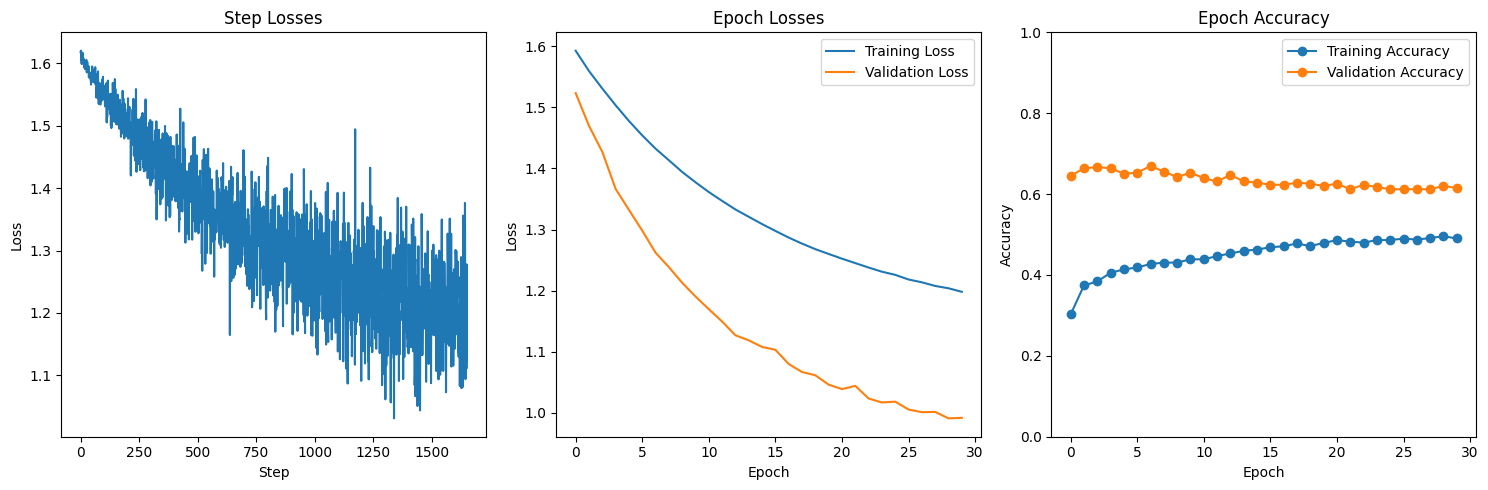

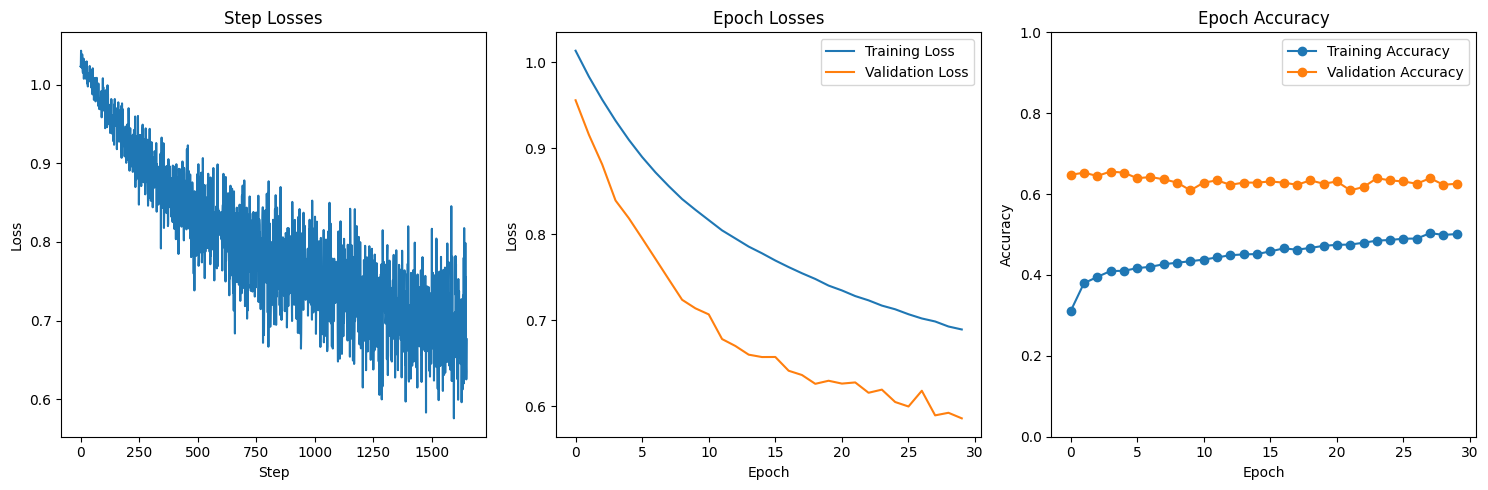

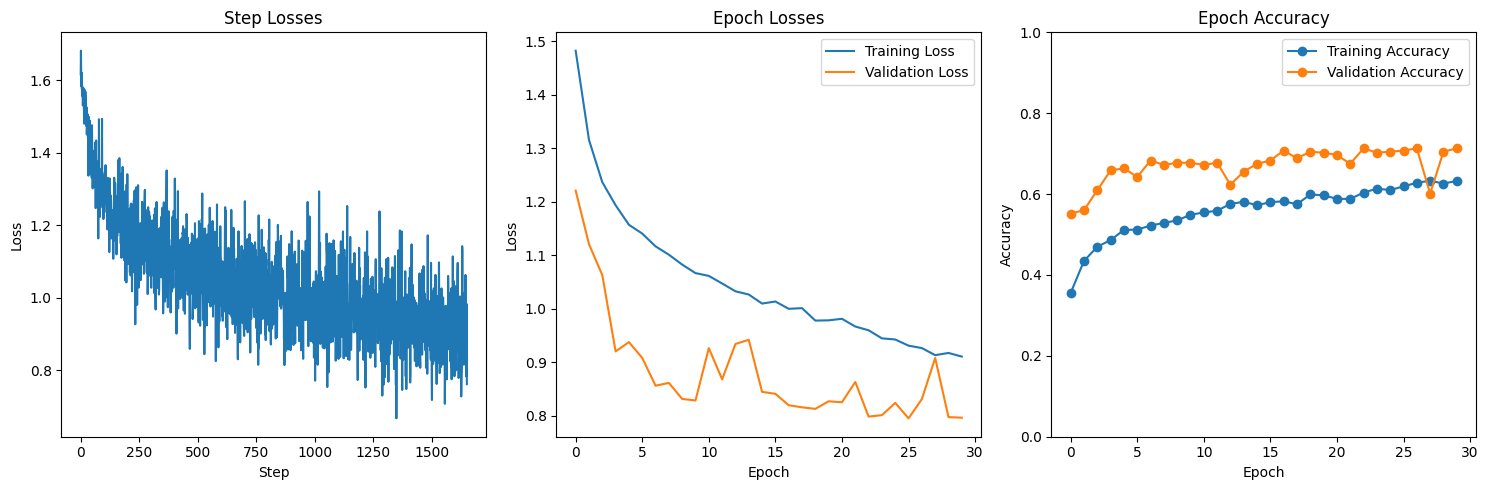

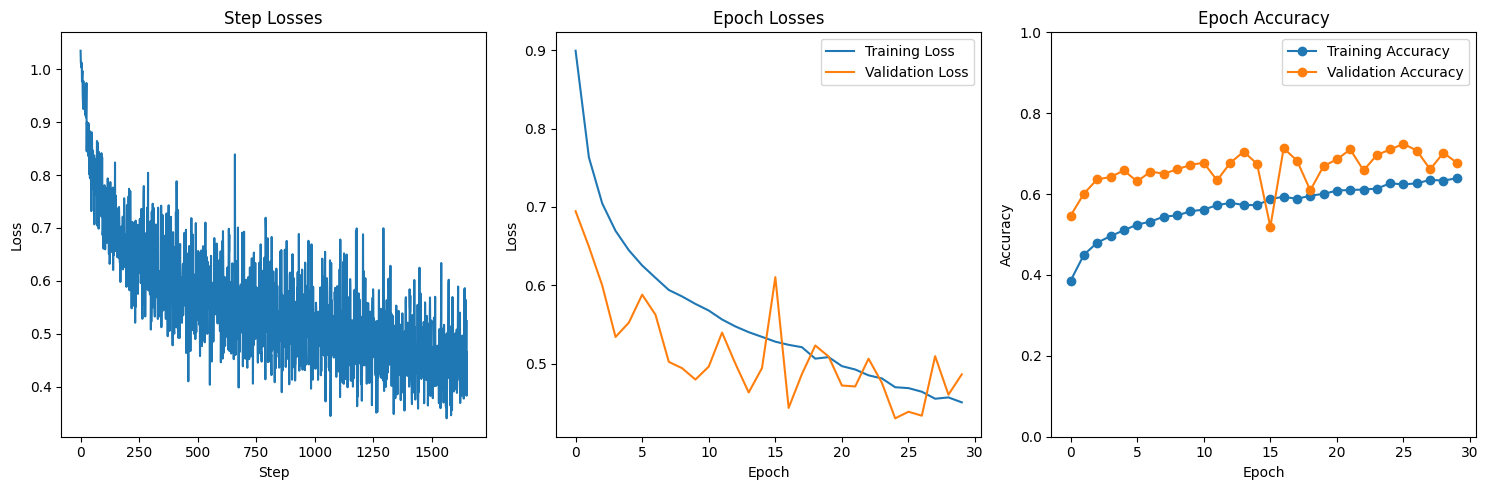

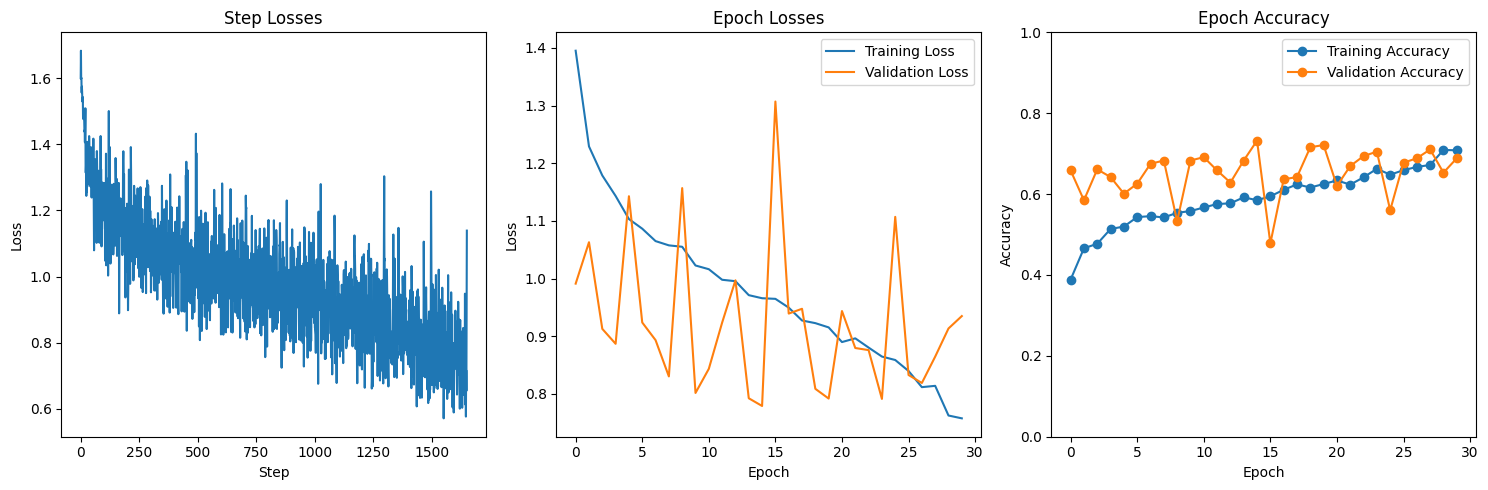

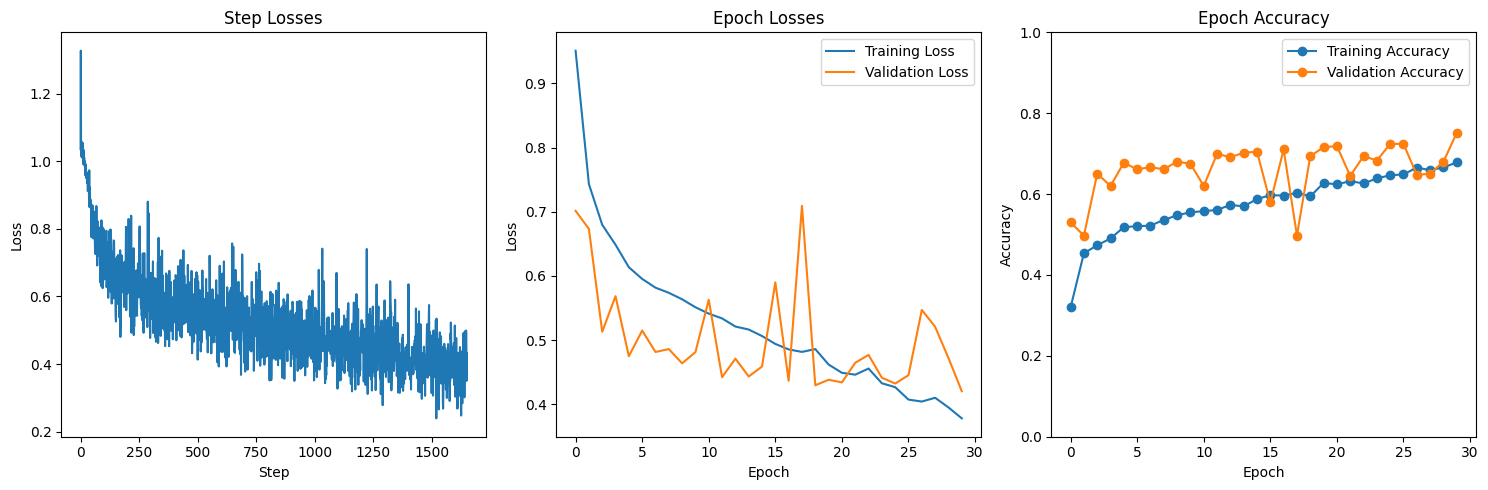

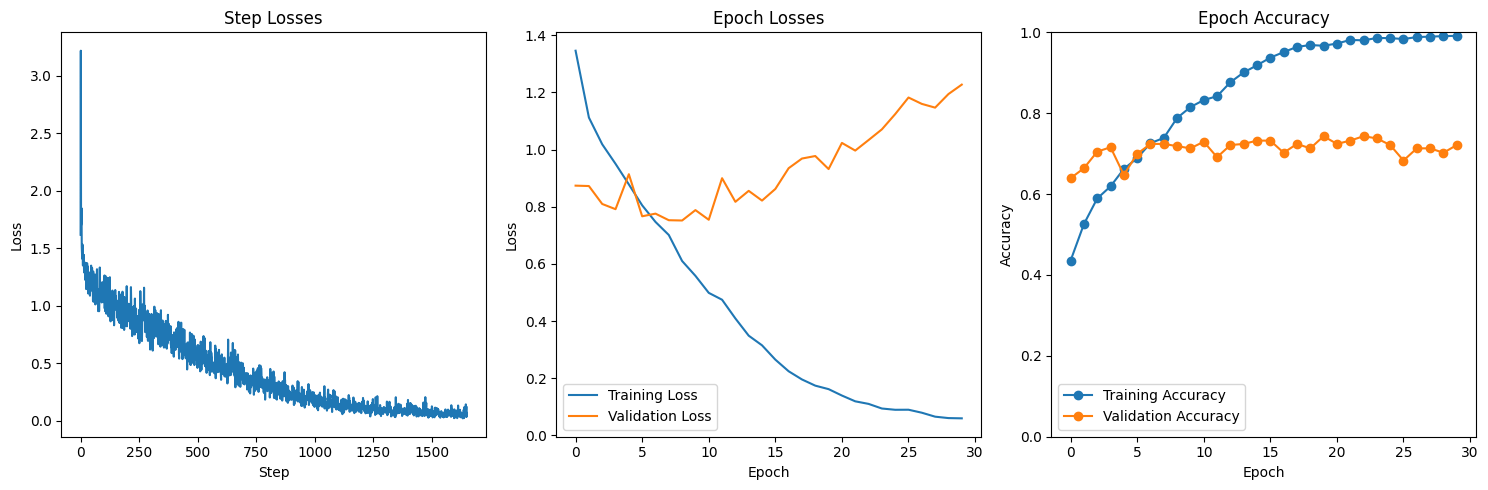

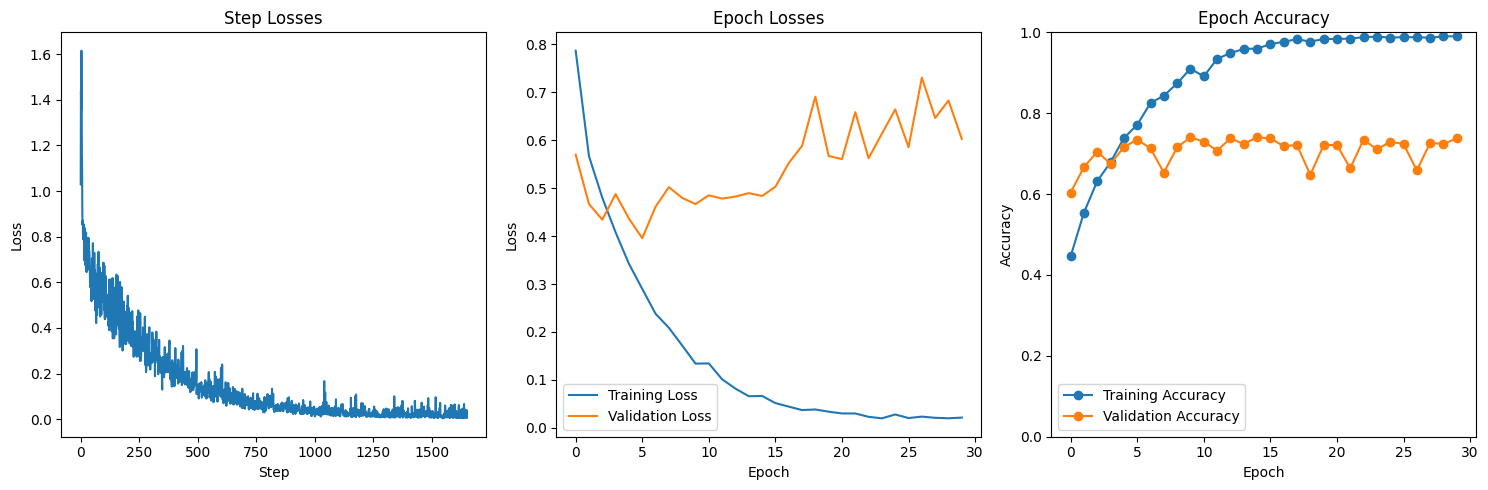

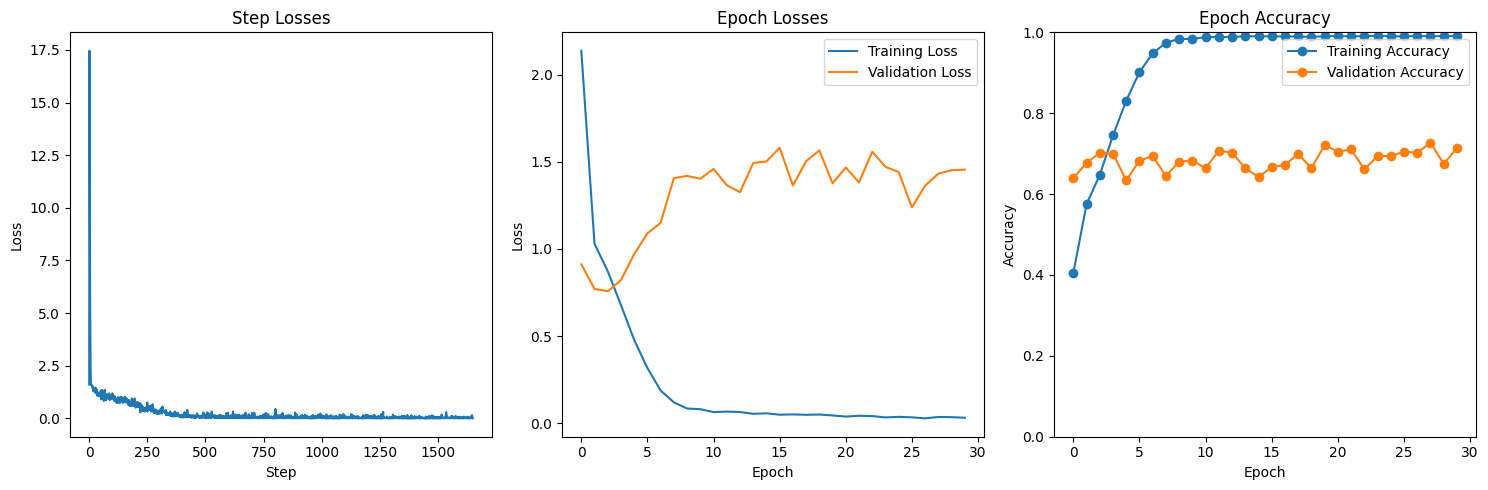

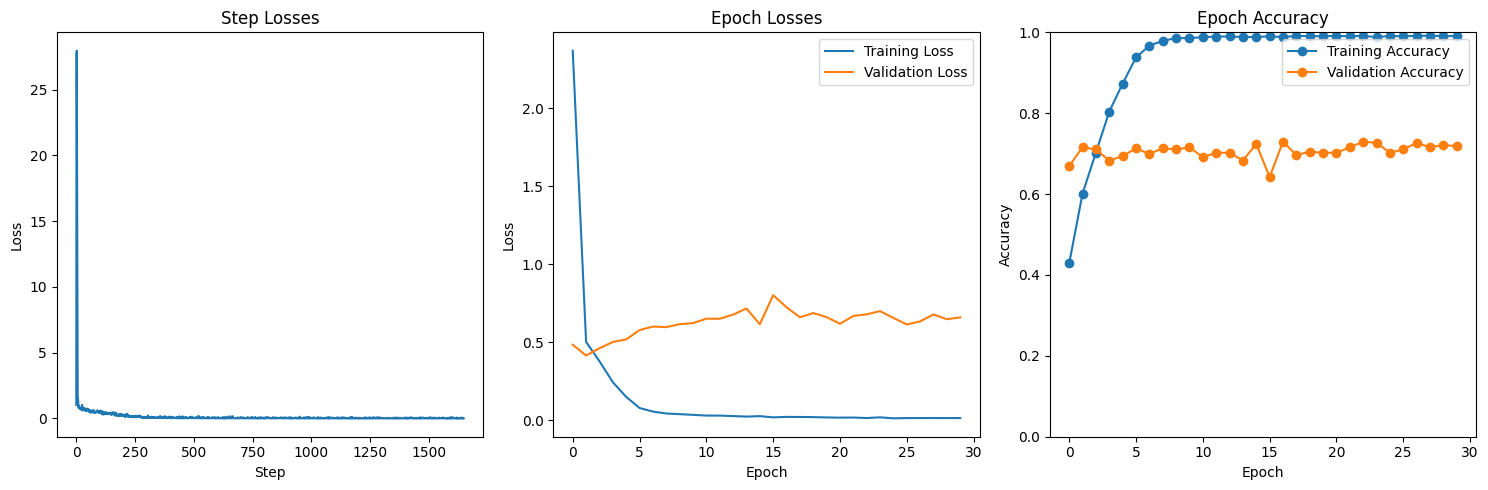

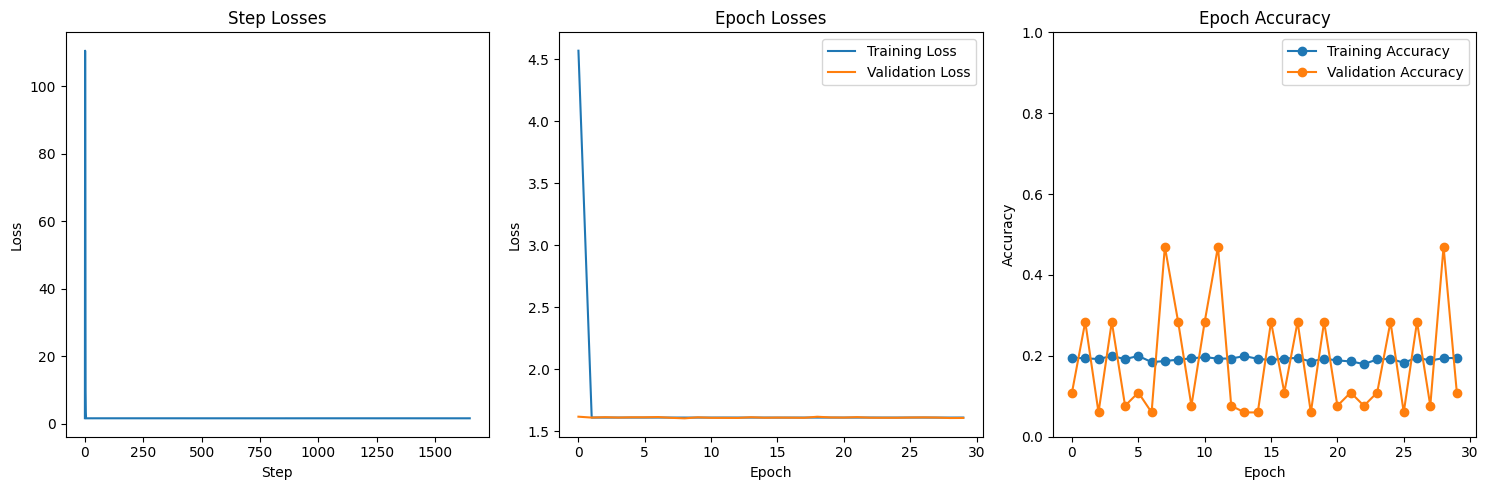

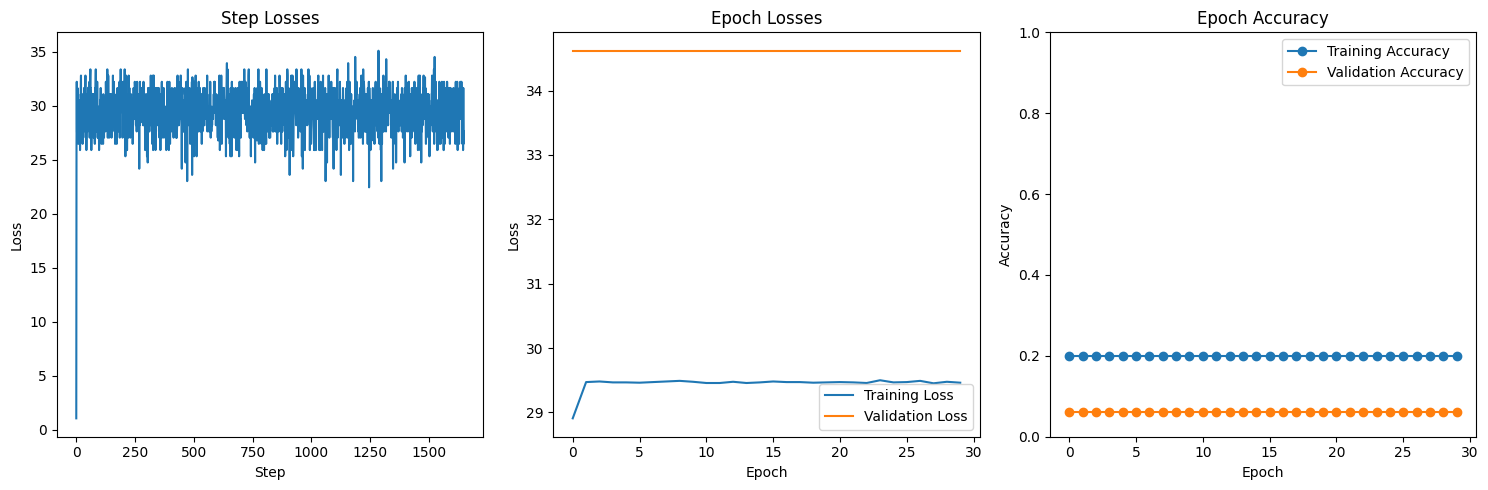

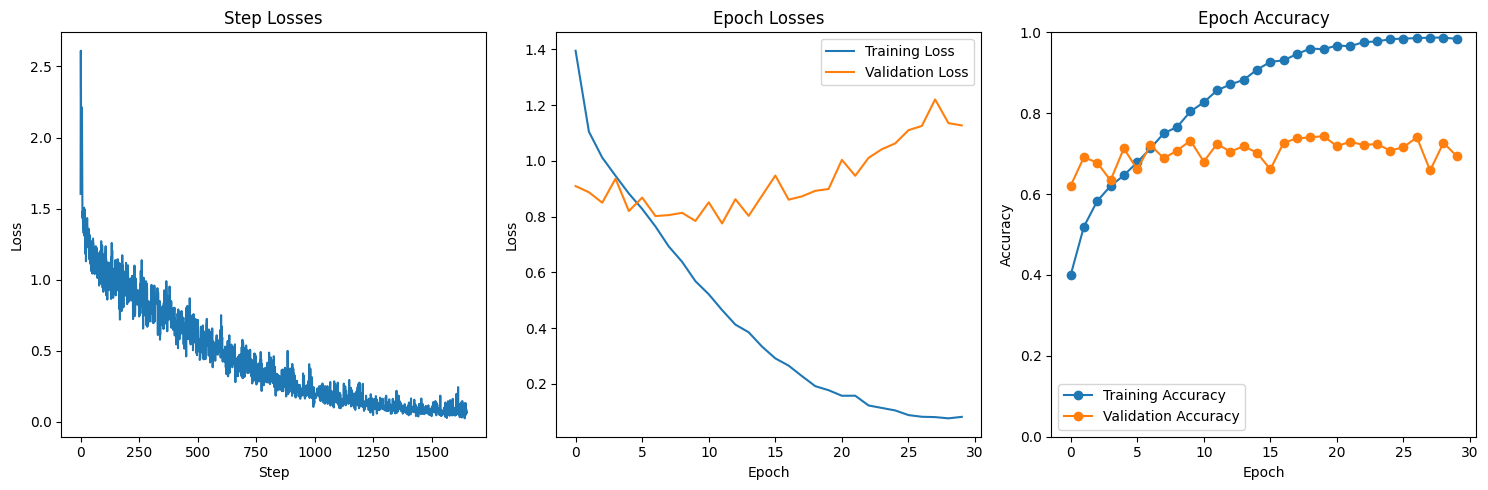

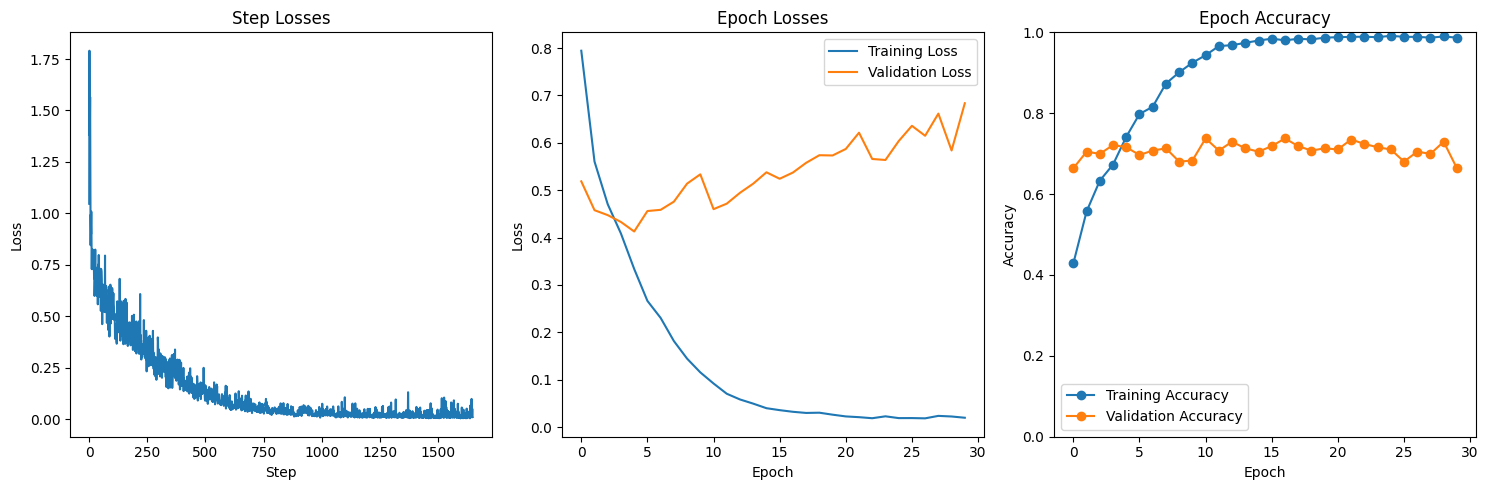

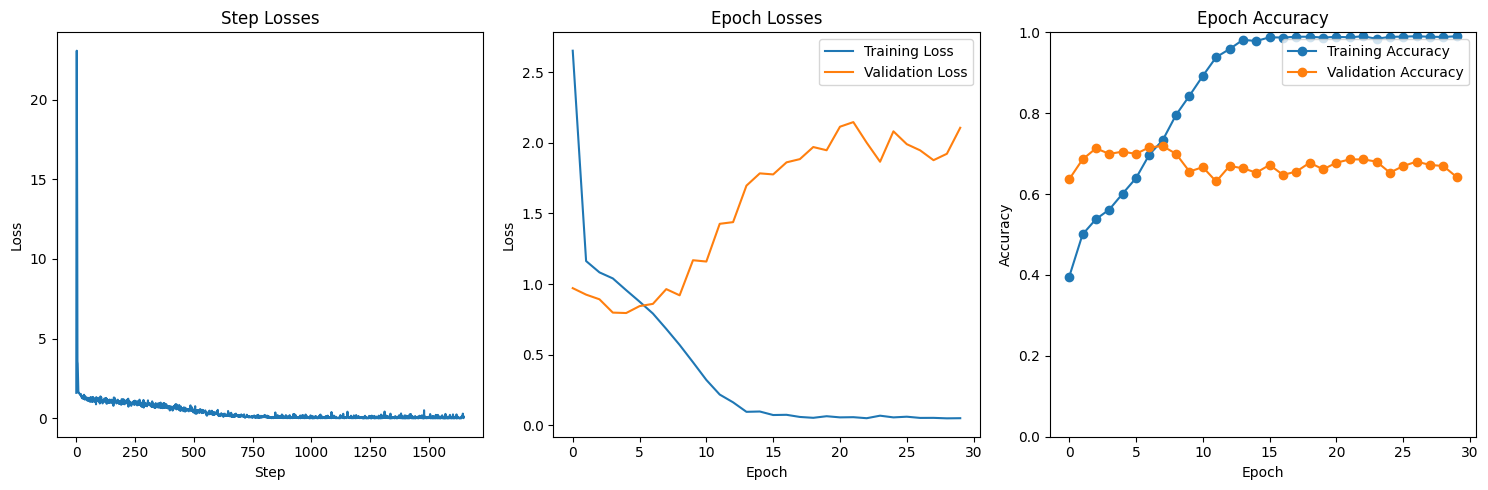

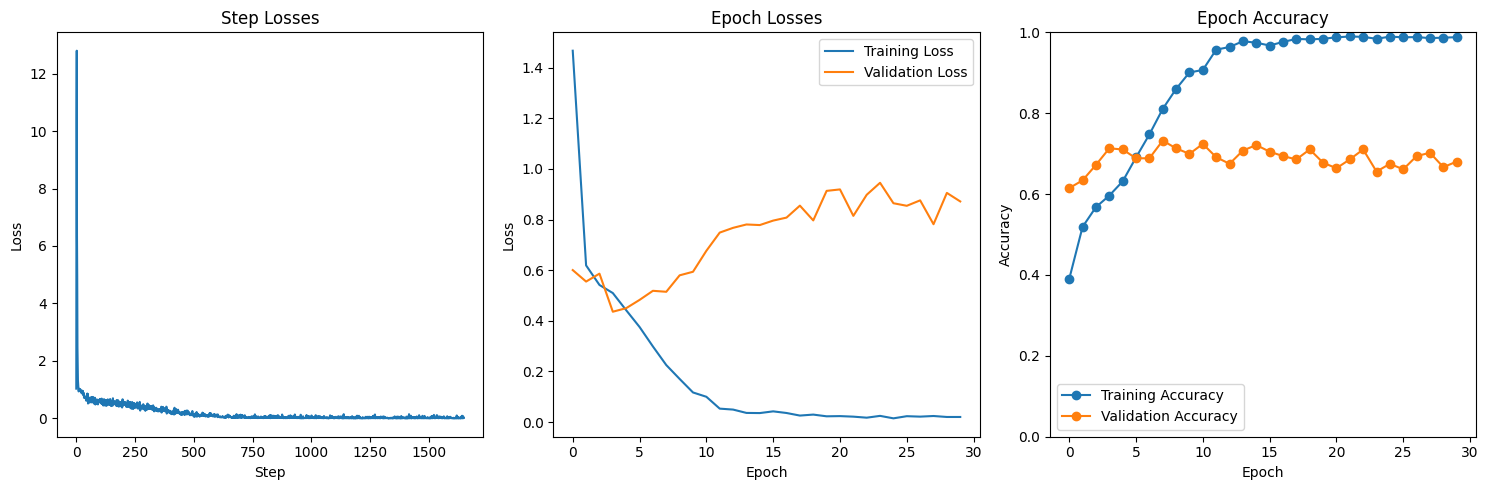

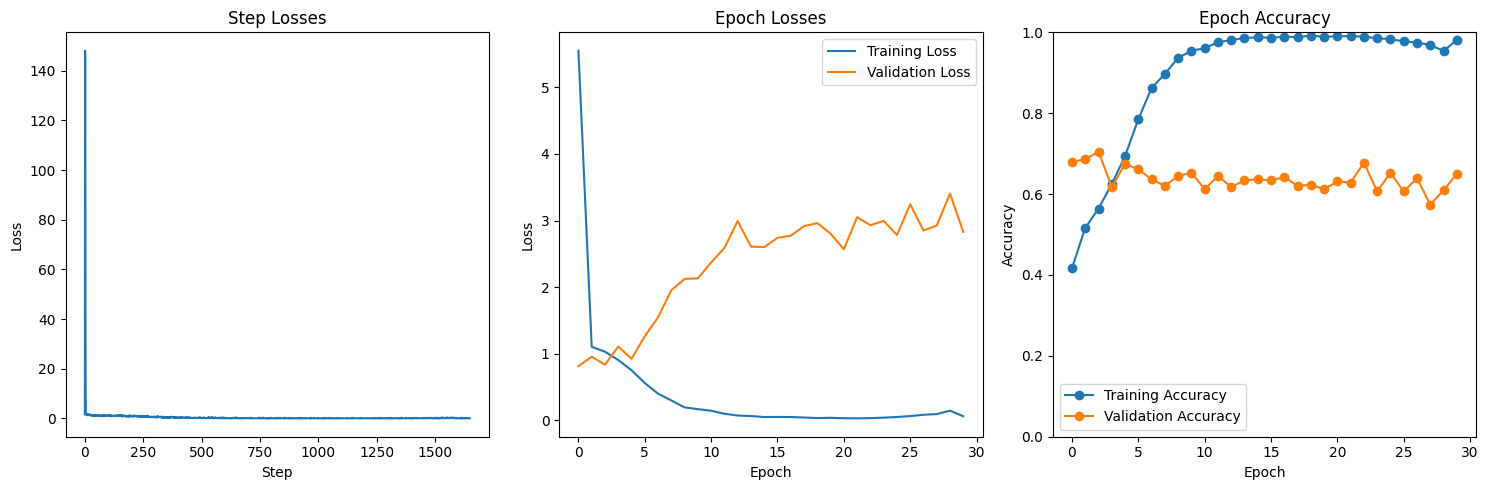

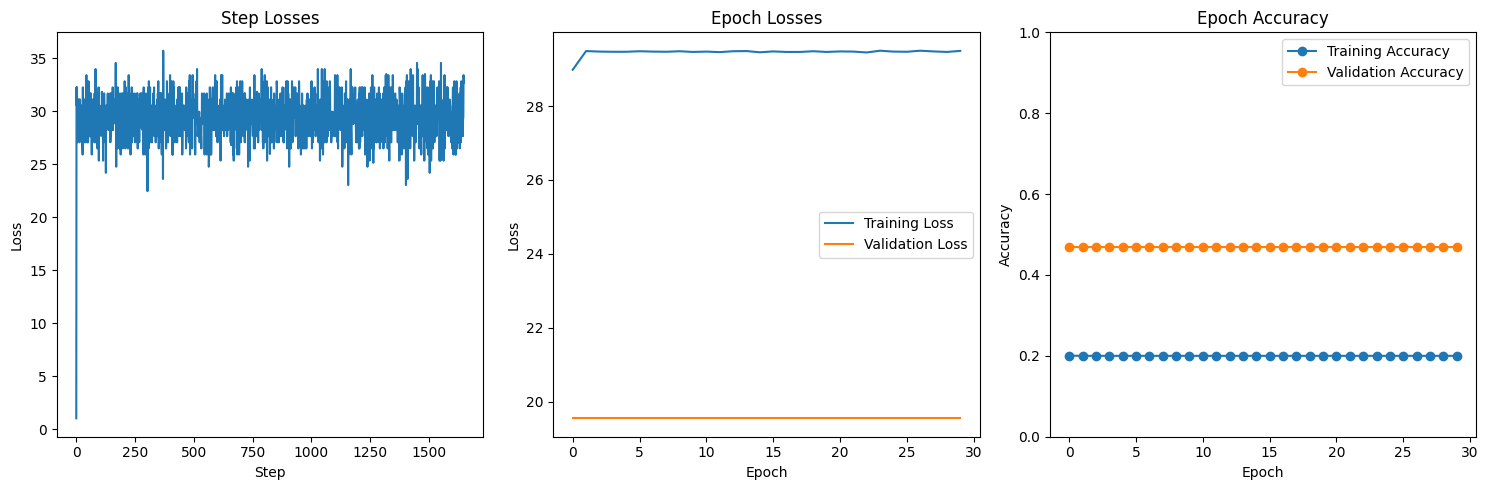

In [45]:
def model_fn():
    return FMCNN()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="FMCNN",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

### Test with a subset of the dataset

In [ ]:
history, model = train_model(
    model = model,
    train_loader = subset_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    num_epochs = 10,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model")

## Test with another model


In [ ]:
model_vgg16 = models.vgg16(weights=None, num_classes=5)

print(model_vgg16)

In [ ]:
summary(model_vgg16, input_size=(32, 3, img_size, img_size))

In [ ]:
history, model_vgg16 = train_model(
    model = model_vgg16,
    train_loader = loader_selected,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-4,
    num_epochs = 5,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
torch.save(model_vgg16, base_path + "model_vgg.pth")

In [ ]:
# Evaluate the model
model2 = torch.load(base_path+"model_vgg.pth", weights_only=False)

metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow


In [ ]:
cleanup_torch_env("model2")
cleanup_torch_env("model_vgg16")

Partono 18 esperimenti...

[1/18] vgg16_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6115 train acc=0.2145, validation loss: 1.6210 validation acc=0.1721
Epoch 2/30


Epoch 2 training loss: 1.6121 train acc=0.2042, validation loss: 1.6155 validation acc=0.1721
Epoch 3/30


Epoch 3 training loss: 1.6140 train acc=0.1971, validation loss: 1.6107 validation acc=0.1721
Epoch 4/30


Epoch 4 training loss: 1.6122 train acc=0.2010, validation loss: 1.6063 validation acc=0.2486
Epoch 5/30


Epoch 5 training loss: 1.6109 train acc=0.2059, validation loss: 1.6010 validation acc=0.4863
Epoch 6/30


Epoch 6 training loss: 1.6092 train acc=0.2085, validation loss: 1.5973 validation acc=0.5219
Epoch 7/30


Epoch 7 training loss: 1.6075 train acc=0.2146, validation loss: 1.5933 validation acc=0.4973
Epoch 8/30


Epoch 8 training loss: 1.6086 train acc=0.2084, validation loss: 1.5909 validation acc=0.4672
Epoch 9/30


Epoch 9 training loss: 1.6072 train acc=0.2102, validation loss: 1.5877 validation acc=0.4508
Epoch 10/30


Epoch 10 training loss: 1.6064 train acc=0.2226, validation loss: 1.5846 validation acc=0.4590
Epoch 11/30


Epoch 11 training loss: 1.6067 train acc=0.2204, validation loss: 1.5828 validation acc=0.4672
Epoch 12/30


Epoch 12 training loss: 1.6061 train acc=0.2177, validation loss: 1.5807 validation acc=0.4645
Epoch 13/30


Epoch 13 training loss: 1.6057 train acc=0.2287, validation loss: 1.5782 validation acc=0.4672
Epoch 14/30


Epoch 14 training loss: 1.6063 train acc=0.2255, validation loss: 1.5758 validation acc=0.4672
Epoch 15/30


Epoch 15 training loss: 1.6056 train acc=0.2251, validation loss: 1.5743 validation acc=0.4699
Epoch 16/30


Epoch 16 training loss: 1.6036 train acc=0.2397, validation loss: 1.5720 validation acc=0.4699
Epoch 17/30


Epoch 17 training loss: 1.6030 train acc=0.2354, validation loss: 1.5695 validation acc=0.4699
Epoch 18/30


Epoch 18 training loss: 1.6027 train acc=0.2466, validation loss: 1.5683 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 1.6026 train acc=0.2385, validation loss: 1.5660 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 1.6012 train acc=0.2434, validation loss: 1.5628 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6032 train acc=0.2396, validation loss: 1.5621 validation acc=0.4672
Epoch 22/30


Epoch 22 training loss: 1.6004 train acc=0.2471, validation loss: 1.5597 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 1.6011 train acc=0.2457, validation loss: 1.5576 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 1.5995 train acc=0.2463, validation loss: 1.5550 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 1.6019 train acc=0.2425, validation loss: 1.5540 validation acc=0.4672
Epoch 26/30


Epoch 26 training loss: 1.5991 train acc=0.2522, validation loss: 1.5518 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 1.5990 train acc=0.2452, validation loss: 1.5491 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 1.5966 train acc=0.2558, validation loss: 1.5469 validation acc=0.4699
Epoch 29/30


Epoch 29 training loss: 1.5973 train acc=0.2590, validation loss: 1.5456 validation acc=0.4672
Epoch 30/30


Epoch 30 training loss: 1.5970 train acc=0.2554, validation loss: 1.5442 validation acc=0.4672
Test Accuracy: 53.83% | Precision: 0.109 | Recall: 0.198 | F1: 0.140
[2/18] vgg16_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0331 train acc=0.2028, validation loss: 1.0337 validation acc=0.0738
Epoch 2/30


Epoch 2 training loss: 1.0315 train acc=0.2059, validation loss: 1.0310 validation acc=0.0847
Epoch 3/30


Epoch 3 training loss: 1.0297 train acc=0.2100, validation loss: 1.0295 validation acc=0.1366
Epoch 4/30


Epoch 4 training loss: 1.0306 train acc=0.2092, validation loss: 1.0269 validation acc=0.3033
Epoch 5/30


Epoch 5 training loss: 1.0289 train acc=0.2163, validation loss: 1.0259 validation acc=0.3579
Epoch 6/30


Epoch 6 training loss: 1.0283 train acc=0.2181, validation loss: 1.0240 validation acc=0.3934
Epoch 7/30


Epoch 7 training loss: 1.0294 train acc=0.2139, validation loss: 1.0211 validation acc=0.4290
Epoch 8/30


Epoch 8 training loss: 1.0263 train acc=0.2226, validation loss: 1.0195 validation acc=0.4508
Epoch 9/30


Epoch 9 training loss: 1.0279 train acc=0.2201, validation loss: 1.0183 validation acc=0.4891
Epoch 10/30


Epoch 10 training loss: 1.0272 train acc=0.2177, validation loss: 1.0163 validation acc=0.4945
Epoch 11/30


Epoch 11 training loss: 1.0258 train acc=0.2307, validation loss: 1.0150 validation acc=0.5246
Epoch 12/30


Epoch 12 training loss: 1.0258 train acc=0.2325, validation loss: 1.0146 validation acc=0.5055
Epoch 13/30


Epoch 13 training loss: 1.0261 train acc=0.2241, validation loss: 1.0141 validation acc=0.4836
Epoch 14/30


Epoch 14 training loss: 1.0257 train acc=0.2191, validation loss: 1.0138 validation acc=0.4781
Epoch 15/30


Epoch 15 training loss: 1.0264 train acc=0.2241, validation loss: 1.0135 validation acc=0.4727
Epoch 16/30


Epoch 16 training loss: 1.0230 train acc=0.2363, validation loss: 1.0112 validation acc=0.5191
Epoch 17/30


Epoch 17 training loss: 1.0241 train acc=0.2343, validation loss: 1.0094 validation acc=0.5164
Epoch 18/30


Epoch 18 training loss: 1.0230 train acc=0.2361, validation loss: 1.0083 validation acc=0.5464
Epoch 19/30


Epoch 19 training loss: 1.0229 train acc=0.2413, validation loss: 1.0078 validation acc=0.5492
Epoch 20/30


Epoch 20 training loss: 1.0235 train acc=0.2410, validation loss: 1.0077 validation acc=0.5464
Epoch 21/30


Epoch 21 training loss: 1.0236 train acc=0.2411, validation loss: 1.0068 validation acc=0.5464
Epoch 22/30


Epoch 22 training loss: 1.0222 train acc=0.2418, validation loss: 1.0042 validation acc=0.5601
Epoch 23/30


Epoch 23 training loss: 1.0212 train acc=0.2449, validation loss: 1.0031 validation acc=0.5601
Epoch 24/30


Epoch 24 training loss: 1.0225 train acc=0.2399, validation loss: 1.0012 validation acc=0.5628
Epoch 25/30


Epoch 25 training loss: 1.0212 train acc=0.2538, validation loss: 0.9997 validation acc=0.5601
Epoch 26/30


Epoch 26 training loss: 1.0202 train acc=0.2441, validation loss: 0.9984 validation acc=0.5574
Epoch 27/30


Epoch 27 training loss: 1.0192 train acc=0.2628, validation loss: 0.9980 validation acc=0.5601
Epoch 28/30


Epoch 28 training loss: 1.0179 train acc=0.2612, validation loss: 0.9956 validation acc=0.5738
Epoch 29/30


Epoch 29 training loss: 1.0192 train acc=0.2538, validation loss: 0.9955 validation acc=0.5683
Epoch 30/30


Epoch 30 training loss: 1.0184 train acc=0.2632, validation loss: 0.9929 validation acc=0.5820
Test Accuracy: 63.66% | Precision: 0.262 | Recall: 0.315 | F1: 0.285
[3/18] vgg16_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6125 train acc=0.2081, validation loss: 1.5825 validation acc=0.5000
Epoch 2/30


Epoch 2 training loss: 1.6057 train acc=0.2280, validation loss: 1.5675 validation acc=0.5410
Epoch 3/30


Epoch 3 training loss: 1.5991 train acc=0.2469, validation loss: 1.5680 validation acc=0.4454
Epoch 4/30


Epoch 4 training loss: 1.5926 train acc=0.2714, validation loss: 1.5671 validation acc=0.4645
Epoch 5/30


Epoch 5 training loss: 1.5841 train acc=0.2856, validation loss: 1.5166 validation acc=0.4617
Epoch 6/30


Epoch 6 training loss: 1.5659 train acc=0.3046, validation loss: 1.4670 validation acc=0.5246
Epoch 7/30


Epoch 7 training loss: 1.5473 train acc=0.3191, validation loss: 1.4358 validation acc=0.4399
Epoch 8/30


Epoch 8 training loss: 1.5088 train acc=0.3411, validation loss: 1.2173 validation acc=0.5683
Epoch 9/30


Epoch 9 training loss: 1.4685 train acc=0.3591, validation loss: 1.2542 validation acc=0.5929
Epoch 10/30


Epoch 10 training loss: 1.4261 train acc=0.3745, validation loss: 1.1418 validation acc=0.5519
Epoch 11/30


Epoch 11 training loss: 1.4078 train acc=0.3717, validation loss: 1.4512 validation acc=0.3634
Epoch 12/30


Epoch 12 training loss: 1.3700 train acc=0.3971, validation loss: 1.2936 validation acc=0.4071
Epoch 13/30


Epoch 13 training loss: 1.3488 train acc=0.3939, validation loss: 1.7304 validation acc=0.2022
Epoch 14/30


Epoch 14 training loss: 1.3289 train acc=0.4060, validation loss: 1.0074 validation acc=0.6448
Epoch 15/30


Epoch 15 training loss: 1.3174 train acc=0.4079, validation loss: 1.1432 validation acc=0.4617
Epoch 16/30


Epoch 16 training loss: 1.3028 train acc=0.4126, validation loss: 1.1704 validation acc=0.4918
Epoch 17/30


Epoch 17 training loss: 1.2883 train acc=0.4259, validation loss: 0.9121 validation acc=0.6639
Epoch 18/30


Epoch 18 training loss: 1.2723 train acc=0.4245, validation loss: 0.9756 validation acc=0.6421
Epoch 19/30


Epoch 19 training loss: 1.2647 train acc=0.4344, validation loss: 0.9703 validation acc=0.6311
Epoch 20/30


Epoch 20 training loss: 1.2514 train acc=0.4430, validation loss: 1.4531 validation acc=0.3333
Epoch 21/30


Epoch 21 training loss: 1.2399 train acc=0.4485, validation loss: 1.0824 validation acc=0.4836
Epoch 22/30


Epoch 22 training loss: 1.2492 train acc=0.4495, validation loss: 1.0726 validation acc=0.5191
Epoch 23/30


Epoch 23 training loss: 1.2421 train acc=0.4425, validation loss: 1.0971 validation acc=0.4945
Epoch 24/30


Epoch 24 training loss: 1.2150 train acc=0.4594, validation loss: 0.8656 validation acc=0.6557
Epoch 25/30


Epoch 25 training loss: 1.2118 train acc=0.4596, validation loss: 1.4388 validation acc=0.3716
Epoch 26/30


Epoch 26 training loss: 1.2122 train acc=0.4566, validation loss: 1.1300 validation acc=0.4672
Epoch 27/30


Epoch 27 training loss: 1.2107 train acc=0.4640, validation loss: 1.1644 validation acc=0.5574
Epoch 28/30


Epoch 28 training loss: 1.2033 train acc=0.4573, validation loss: 2.1901 validation acc=0.0984
Epoch 29/30


Epoch 29 training loss: 1.2098 train acc=0.4669, validation loss: 2.2087 validation acc=0.1230
Epoch 30/30


Epoch 30 training loss: 1.2125 train acc=0.4646, validation loss: 0.9323 validation acc=0.6175
Test Accuracy: 69.95% | Precision: 0.535 | Recall: 0.383 | F1: 0.362
[4/18] vgg16_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0307 train acc=0.2039, validation loss: 1.0244 validation acc=0.1148
Epoch 2/30


Epoch 2 training loss: 1.0266 train acc=0.2212, validation loss: 1.0121 validation acc=0.4399
Epoch 3/30


Epoch 3 training loss: 1.0220 train acc=0.2448, validation loss: 0.9903 validation acc=0.5902
Epoch 4/30


Epoch 4 training loss: 1.0162 train acc=0.2662, validation loss: 0.9731 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 1.0062 train acc=0.2905, validation loss: 0.9554 validation acc=0.5738
Epoch 6/30


Epoch 6 training loss: 0.9976 train acc=0.3113, validation loss: 0.9381 validation acc=0.5492
Epoch 7/30


Epoch 7 training loss: 0.9805 train acc=0.3346, validation loss: 0.9354 validation acc=0.4317
Epoch 8/30


Epoch 8 training loss: 0.9481 train acc=0.3498, validation loss: 0.8734 validation acc=0.4863
Epoch 9/30


Epoch 9 training loss: 0.8977 train acc=0.3653, validation loss: 0.6864 validation acc=0.5109
Epoch 10/30


Epoch 10 training loss: 0.8444 train acc=0.3863, validation loss: 0.6398 validation acc=0.6093
Epoch 11/30


Epoch 11 training loss: 0.8066 train acc=0.4091, validation loss: 0.5639 validation acc=0.6475
Epoch 12/30


Epoch 12 training loss: 0.7900 train acc=0.4040, validation loss: 0.6149 validation acc=0.5082
Epoch 13/30


Epoch 13 training loss: 0.7755 train acc=0.4071, validation loss: 0.6226 validation acc=0.5000
Epoch 14/30


Epoch 14 training loss: 0.7529 train acc=0.4174, validation loss: 0.6168 validation acc=0.5328
Epoch 15/30


Epoch 15 training loss: 0.7427 train acc=0.4247, validation loss: 0.5610 validation acc=0.5929
Epoch 16/30


Epoch 16 training loss: 0.7400 train acc=0.4259, validation loss: 0.6460 validation acc=0.4973
Epoch 17/30


Epoch 17 training loss: 0.7292 train acc=0.4319, validation loss: 0.5030 validation acc=0.6557
Epoch 18/30


Epoch 18 training loss: 0.7354 train acc=0.4298, validation loss: 0.6470 validation acc=0.5628
Epoch 19/30


Epoch 19 training loss: 0.7295 train acc=0.4420, validation loss: 0.5033 validation acc=0.6530
Epoch 20/30


Epoch 20 training loss: 0.7205 train acc=0.4379, validation loss: 0.6401 validation acc=0.4563
Epoch 21/30


Epoch 21 training loss: 0.7145 train acc=0.4517, validation loss: 0.5299 validation acc=0.6120
Epoch 22/30


Epoch 22 training loss: 0.7105 train acc=0.4522, validation loss: 0.5814 validation acc=0.6311
Epoch 23/30


Epoch 23 training loss: 0.7201 train acc=0.4453, validation loss: 2.7070 validation acc=0.1175
Epoch 24/30


Epoch 24 training loss: 0.7156 train acc=0.4536, validation loss: 0.5419 validation acc=0.6093
Epoch 25/30


Epoch 25 training loss: 0.6994 train acc=0.4593, validation loss: 0.4880 validation acc=0.6639
Epoch 26/30


Epoch 26 training loss: 0.7032 train acc=0.4614, validation loss: 0.5736 validation acc=0.6284
Epoch 27/30


Epoch 27 training loss: 0.7042 train acc=0.4563, validation loss: 0.5069 validation acc=0.6557
Epoch 28/30


Epoch 28 training loss: 0.6887 train acc=0.4616, validation loss: 0.4889 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.7022 train acc=0.4646, validation loss: 2.8460 validation acc=0.1066
Epoch 30/30


Epoch 30 training loss: 0.7029 train acc=0.4568, validation loss: 0.5229 validation acc=0.6120
Test Accuracy: 68.58% | Precision: 0.453 | Recall: 0.416 | F1: 0.367
[5/18] vgg16_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


KeyboardInterrupt: 

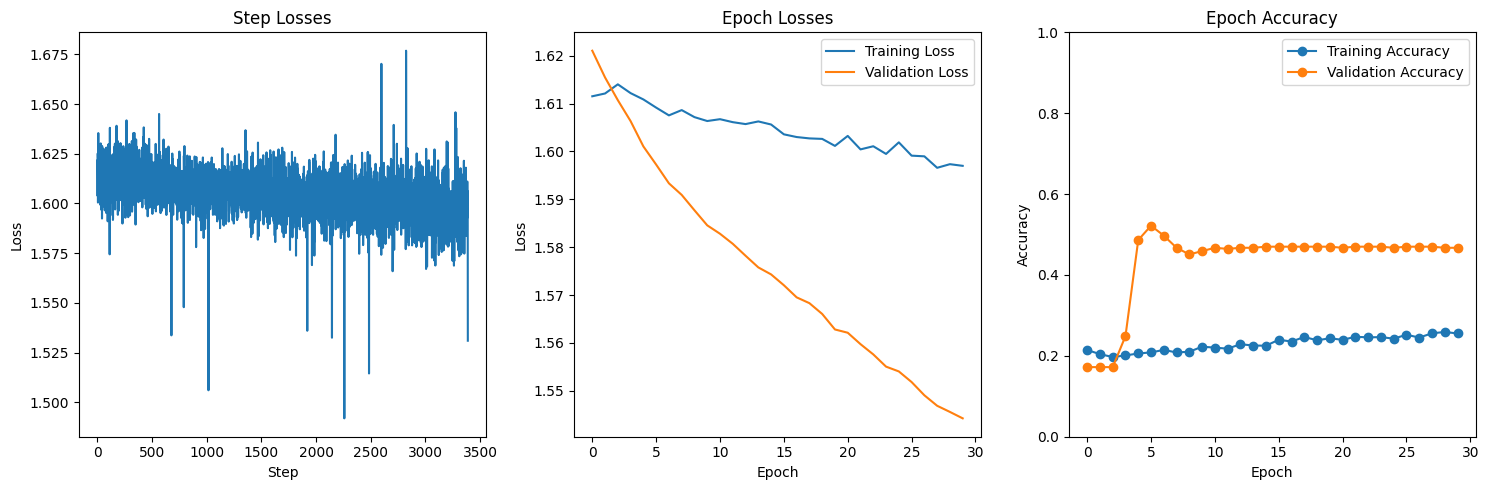

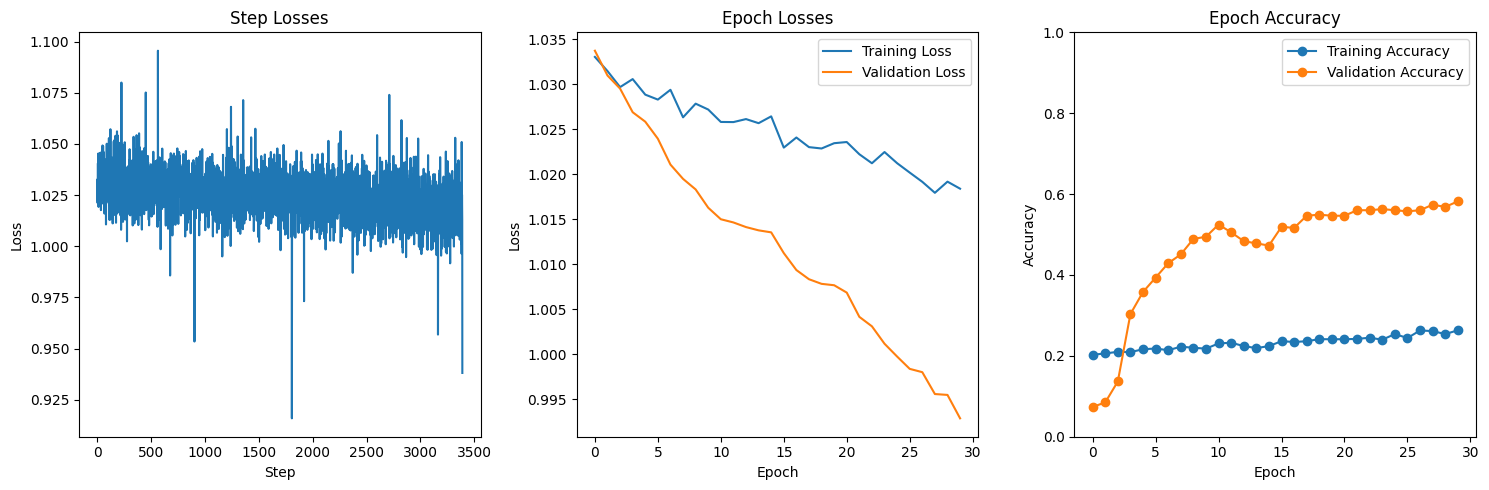

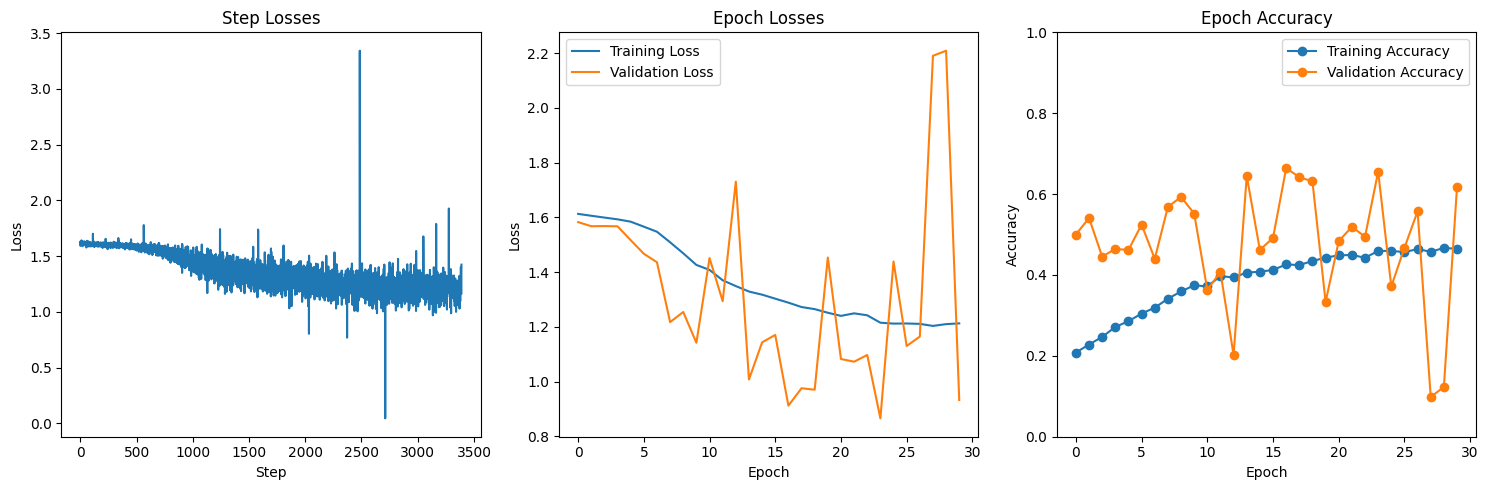

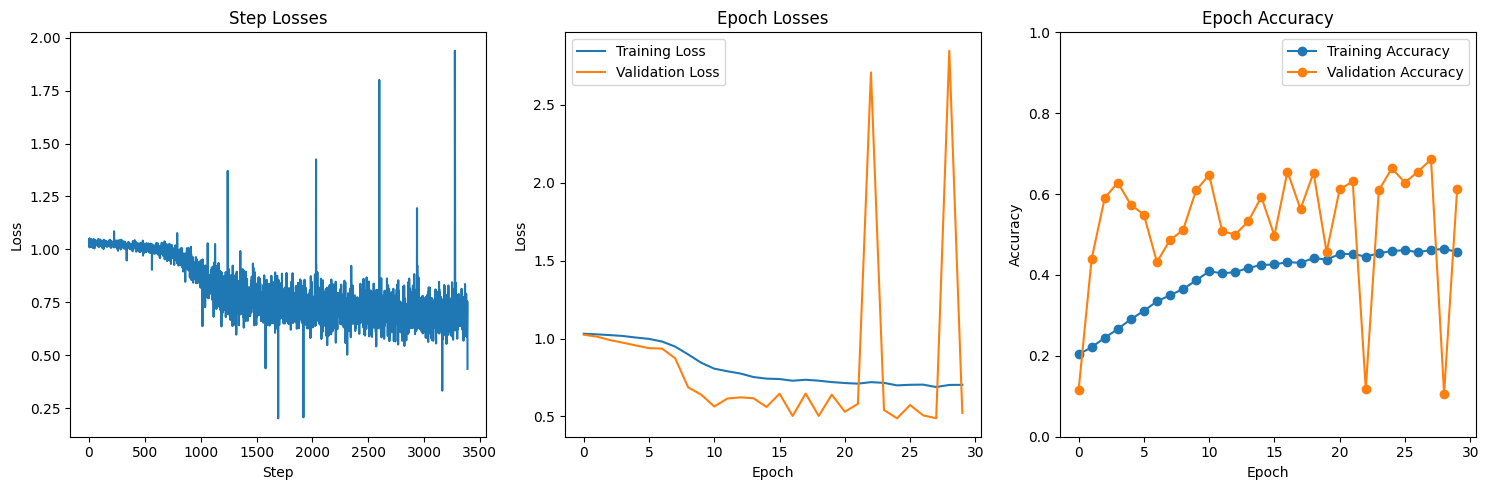

In [ ]:
def model_fn():
    return models.vgg16(weights=None, num_classes=5)

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="vgg16",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

## RSG-Net

In [48]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=5)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
model_rsg = RSGNet()
print(model_rsg)
summary(model_rsg, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=0.001,
    num_epochs = 30,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_rsg,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_rsg(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

Partono 18 esperimenti...

[1/18] RSGNet_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4975 train acc=0.4069, validation loss: 1.5198 validation acc=0.5738
Epoch 2/30


Epoch 2 training loss: 1.4434 train acc=0.4726, validation loss: 1.3152 validation acc=0.6202
Epoch 3/30


Epoch 3 training loss: 1.4251 train acc=0.4906, validation loss: 1.3021 validation acc=0.6339
Epoch 4/30


Epoch 4 training loss: 1.4108 train acc=0.5071, validation loss: 1.2983 validation acc=0.6393
Epoch 5/30


Epoch 5 training loss: 1.4033 train acc=0.5277, validation loss: 1.2783 validation acc=0.6831
Epoch 6/30


Epoch 6 training loss: 1.3918 train acc=0.5349, validation loss: 1.2929 validation acc=0.6612
Epoch 7/30


Epoch 7 training loss: 1.3843 train acc=0.5549, validation loss: 1.2696 validation acc=0.6749
Epoch 8/30


Epoch 8 training loss: 1.3770 train acc=0.5591, validation loss: 1.2612 validation acc=0.6776
Epoch 9/30


Epoch 9 training loss: 1.3725 train acc=0.5709, validation loss: 1.2761 validation acc=0.6831
Epoch 10/30


Epoch 10 training loss: 1.3686 train acc=0.5780, validation loss: 1.2597 validation acc=0.7131
Epoch 11/30


Epoch 11 training loss: 1.3632 train acc=0.5951, validation loss: 1.2517 validation acc=0.6831
Epoch 12/30


Epoch 12 training loss: 1.3571 train acc=0.5949, validation loss: 1.2504 validation acc=0.7022
Epoch 13/30


Epoch 13 training loss: 1.3523 train acc=0.6014, validation loss: 1.2630 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 1.3491 train acc=0.6083, validation loss: 1.2449 validation acc=0.7022
Epoch 15/30


Epoch 15 training loss: 1.3440 train acc=0.6171, validation loss: 1.2579 validation acc=0.7049
Epoch 16/30


Epoch 16 training loss: 1.3395 train acc=0.6251, validation loss: 1.2331 validation acc=0.7104
Epoch 17/30


Epoch 17 training loss: 1.3359 train acc=0.6274, validation loss: 1.2368 validation acc=0.7158
Epoch 18/30


Epoch 18 training loss: 1.3339 train acc=0.6331, validation loss: 1.2544 validation acc=0.7240
Epoch 19/30


Epoch 19 training loss: 1.3288 train acc=0.6417, validation loss: 1.2415 validation acc=0.7186
Epoch 20/30


Epoch 20 training loss: 1.3233 train acc=0.6429, validation loss: 1.2257 validation acc=0.7049
Epoch 21/30


Epoch 21 training loss: 1.3191 train acc=0.6523, validation loss: 1.2491 validation acc=0.7350
Epoch 22/30


Epoch 22 training loss: 1.3177 train acc=0.6511, validation loss: 1.2277 validation acc=0.7268
Epoch 23/30


Epoch 23 training loss: 1.3141 train acc=0.6629, validation loss: 1.2792 validation acc=0.6831
Epoch 24/30


Epoch 24 training loss: 1.3079 train acc=0.6643, validation loss: 1.2345 validation acc=0.7213
Epoch 25/30


Epoch 25 training loss: 1.3065 train acc=0.6709, validation loss: 1.2351 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 1.2998 train acc=0.6840, validation loss: 1.2425 validation acc=0.7049
Epoch 27/30


Epoch 27 training loss: 1.2985 train acc=0.6751, validation loss: 1.2482 validation acc=0.7049
Epoch 28/30


Epoch 28 training loss: 1.2956 train acc=0.6871, validation loss: 1.2502 validation acc=0.7158
Epoch 29/30


Epoch 29 training loss: 1.2927 train acc=0.6909, validation loss: 1.2213 validation acc=0.7077
Epoch 30/30


Epoch 30 training loss: 1.2897 train acc=0.6966, validation loss: 1.2282 validation acc=0.7213
Test Accuracy: 73.77% | Precision: 0.524 | Recall: 0.485 | F1: 0.460
[2/18] RSGNet_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7731 train acc=0.4500, validation loss: 0.9747 validation acc=0.5164
Epoch 2/30


Epoch 2 training loss: 0.6637 train acc=0.5306, validation loss: 0.7765 validation acc=0.6913
Epoch 3/30


Epoch 3 training loss: 0.6051 train acc=0.5634, validation loss: 0.7760 validation acc=0.6831
Epoch 4/30


Epoch 4 training loss: 0.5696 train acc=0.5934, validation loss: 0.7696 validation acc=0.6639
Epoch 5/30


Epoch 5 training loss: 0.5474 train acc=0.6091, validation loss: 0.7204 validation acc=0.6858
Epoch 6/30


Epoch 6 training loss: 0.5220 train acc=0.6357, validation loss: 0.7519 validation acc=0.6967
Epoch 7/30


Epoch 7 training loss: 0.4938 train acc=0.6520, validation loss: 0.7930 validation acc=0.5984
Epoch 8/30


Epoch 8 training loss: 0.4721 train acc=0.6706, validation loss: 0.8083 validation acc=0.6311
Epoch 9/30


Epoch 9 training loss: 0.4434 train acc=0.6937, validation loss: 0.7966 validation acc=0.6557
Epoch 10/30


Epoch 10 training loss: 0.4157 train acc=0.7229, validation loss: 0.7964 validation acc=0.5984
Epoch 11/30


Epoch 11 training loss: 0.4008 train acc=0.7386, validation loss: 0.7660 validation acc=0.6038
Epoch 12/30


Epoch 12 training loss: 0.3881 train acc=0.7534, validation loss: 0.7335 validation acc=0.7158
Epoch 13/30


Epoch 13 training loss: 0.3722 train acc=0.7737, validation loss: 0.7692 validation acc=0.7077
Epoch 14/30


Epoch 14 training loss: 0.3578 train acc=0.7840, validation loss: 0.7895 validation acc=0.7104
Epoch 15/30


Epoch 15 training loss: 0.3393 train acc=0.8011, validation loss: 0.7831 validation acc=0.6913
Epoch 16/30


Epoch 16 training loss: 0.3252 train acc=0.8114, validation loss: 0.7794 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.3201 train acc=0.8280, validation loss: 0.7618 validation acc=0.7022
Epoch 18/30


Epoch 18 training loss: 0.3173 train acc=0.8369, validation loss: 0.7813 validation acc=0.6967
Epoch 19/30


Epoch 19 training loss: 0.3061 train acc=0.8469, validation loss: 0.7442 validation acc=0.7240
Epoch 20/30


Epoch 20 training loss: 0.2956 train acc=0.8577, validation loss: 0.7969 validation acc=0.5738
Epoch 21/30


Epoch 21 training loss: 0.2869 train acc=0.8643, validation loss: 0.8316 validation acc=0.6339
Epoch 22/30


Epoch 22 training loss: 0.2671 train acc=0.8777, validation loss: 0.8283 validation acc=0.6093
Epoch 23/30


Epoch 23 training loss: 0.2603 train acc=0.8883, validation loss: 0.7983 validation acc=0.5929
Epoch 24/30


Epoch 24 training loss: 0.2538 train acc=0.8894, validation loss: 0.7671 validation acc=0.6749
Epoch 25/30


Epoch 25 training loss: 0.2449 train acc=0.9083, validation loss: 0.8075 validation acc=0.6530
Epoch 26/30


Epoch 26 training loss: 0.2348 train acc=0.9031, validation loss: 0.7301 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.2305 train acc=0.9160, validation loss: 0.7553 validation acc=0.6530
Epoch 28/30


Epoch 28 training loss: 0.2186 train acc=0.9254, validation loss: 0.7991 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.2110 train acc=0.9351, validation loss: 0.8522 validation acc=0.5929
Epoch 30/30


Epoch 30 training loss: 0.2053 train acc=0.9314, validation loss: 0.7356 validation acc=0.7131
Test Accuracy: 71.04% | Precision: 0.361 | Recall: 0.444 | F1: 0.381
[3/18] RSGNet_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4499 train acc=0.4586, validation loss: 1.5005 validation acc=0.5820
Epoch 2/30


Epoch 2 training loss: 1.4068 train acc=0.5209, validation loss: 1.2972 validation acc=0.6831
Epoch 3/30


Epoch 3 training loss: 1.3877 train acc=0.5549, validation loss: 1.2689 validation acc=0.6612
Epoch 4/30


Epoch 4 training loss: 1.3664 train acc=0.6037, validation loss: 1.2837 validation acc=0.6940
Epoch 5/30


Epoch 5 training loss: 1.3560 train acc=0.6254, validation loss: 1.2711 validation acc=0.6967
Epoch 6/30


Epoch 6 training loss: 1.3412 train acc=0.6497, validation loss: 1.3224 validation acc=0.6148
Epoch 7/30


Epoch 7 training loss: 1.3278 train acc=0.6809, validation loss: 1.2451 validation acc=0.7158
Epoch 8/30


Epoch 8 training loss: 1.3158 train acc=0.7011, validation loss: 1.2416 validation acc=0.7049
Epoch 9/30


Epoch 9 training loss: 1.3072 train acc=0.7191, validation loss: 1.2562 validation acc=0.7131
Epoch 10/30


Epoch 10 training loss: 1.2959 train acc=0.7440, validation loss: 1.2871 validation acc=0.7158
Epoch 11/30


Epoch 11 training loss: 1.2809 train acc=0.7617, validation loss: 1.2736 validation acc=0.6639
Epoch 12/30


Epoch 12 training loss: 1.2623 train acc=0.7840, validation loss: 1.2506 validation acc=0.7295
Epoch 13/30


Epoch 13 training loss: 1.2464 train acc=0.8023, validation loss: 1.3108 validation acc=0.6858
Epoch 14/30


Epoch 14 training loss: 1.2334 train acc=0.8143, validation loss: 1.2548 validation acc=0.7350
Epoch 15/30


Epoch 15 training loss: 1.2157 train acc=0.8391, validation loss: 1.2646 validation acc=0.6940
Epoch 16/30


Epoch 16 training loss: 1.2011 train acc=0.8523, validation loss: 1.2422 validation acc=0.7186
Epoch 17/30


Epoch 17 training loss: 1.1884 train acc=0.8634, validation loss: 1.2349 validation acc=0.7131
Epoch 18/30


Epoch 18 training loss: 1.1716 train acc=0.8826, validation loss: 1.2579 validation acc=0.7022
Epoch 19/30


Epoch 19 training loss: 1.1590 train acc=0.8977, validation loss: 1.2683 validation acc=0.7104
Epoch 20/30


Epoch 20 training loss: 1.1434 train acc=0.9034, validation loss: 1.2559 validation acc=0.7432
Epoch 21/30


Epoch 21 training loss: 1.1339 train acc=0.9114, validation loss: 1.2585 validation acc=0.7322
Epoch 22/30


Epoch 22 training loss: 1.1212 train acc=0.9209, validation loss: 1.2380 validation acc=0.7186
Epoch 23/30


Epoch 23 training loss: 1.1092 train acc=0.9309, validation loss: 1.2100 validation acc=0.7404
Epoch 24/30


Epoch 24 training loss: 1.1001 train acc=0.9346, validation loss: 1.2430 validation acc=0.7049
Epoch 25/30


Epoch 25 training loss: 1.0867 train acc=0.9477, validation loss: 1.2423 validation acc=0.7350
Epoch 26/30


Epoch 26 training loss: 1.0791 train acc=0.9469, validation loss: 1.2493 validation acc=0.7049
Epoch 27/30


Epoch 27 training loss: 1.0681 train acc=0.9534, validation loss: 1.2692 validation acc=0.6940
Epoch 28/30


Epoch 28 training loss: 1.0599 train acc=0.9569, validation loss: 1.2510 validation acc=0.7104
Epoch 29/30


Epoch 29 training loss: 1.0515 train acc=0.9614, validation loss: 1.2353 validation acc=0.7213
Epoch 30/30


Epoch 30 training loss: 1.0418 train acc=0.9649, validation loss: 1.2789 validation acc=0.6803
Test Accuracy: 71.86% | Precision: 0.608 | Recall: 0.472 | F1: 0.446
[4/18] RSGNet_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7733 train acc=0.4631, validation loss: 0.8941 validation acc=0.4918
Epoch 2/30


Epoch 2 training loss: 0.6453 train acc=0.5409, validation loss: 0.7514 validation acc=0.6913
Epoch 3/30


Epoch 3 training loss: 0.5865 train acc=0.5886, validation loss: 0.8440 validation acc=0.6120
Epoch 4/30


Epoch 4 training loss: 0.5316 train acc=0.6357, validation loss: 0.7649 validation acc=0.6913
Epoch 5/30


Epoch 5 training loss: 0.4714 train acc=0.6817, validation loss: 0.7965 validation acc=0.7131
Epoch 6/30


Epoch 6 training loss: 0.4157 train acc=0.7411, validation loss: 0.8068 validation acc=0.5355
Epoch 7/30


Epoch 7 training loss: 0.3548 train acc=0.7991, validation loss: 0.7215 validation acc=0.7377
Epoch 8/30


Epoch 8 training loss: 0.2987 train acc=0.8466, validation loss: 0.7760 validation acc=0.6694
Epoch 9/30


Epoch 9 training loss: 0.2577 train acc=0.8777, validation loss: 0.7499 validation acc=0.6940
Epoch 10/30


Epoch 10 training loss: 0.2108 train acc=0.9134, validation loss: 0.8252 validation acc=0.6612
Epoch 11/30


Epoch 11 training loss: 0.1843 train acc=0.9406, validation loss: 0.7180 validation acc=0.7158
Epoch 12/30


Epoch 12 training loss: 0.1524 train acc=0.9589, validation loss: 0.8780 validation acc=0.4590
Epoch 13/30


Epoch 13 training loss: 0.1347 train acc=0.9660, validation loss: 0.8983 validation acc=0.4262
Epoch 14/30


Epoch 14 training loss: 0.1126 train acc=0.9703, validation loss: 0.7631 validation acc=0.6749
Epoch 15/30


Epoch 15 training loss: 0.0921 train acc=0.9826, validation loss: 0.8232 validation acc=0.5492
Epoch 16/30


Epoch 16 training loss: 0.0831 train acc=0.9803, validation loss: 0.7230 validation acc=0.7322
Epoch 17/30


Epoch 17 training loss: 0.0722 train acc=0.9860, validation loss: 0.7476 validation acc=0.7350
Epoch 18/30


Epoch 18 training loss: 0.0682 train acc=0.9854, validation loss: 0.7140 validation acc=0.7104
Epoch 19/30


Epoch 19 training loss: 0.0597 train acc=0.9883, validation loss: 0.7843 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 0.0602 train acc=0.9866, validation loss: 0.7711 validation acc=0.6284
Epoch 21/30


Epoch 21 training loss: 0.0547 train acc=0.9886, validation loss: 0.7352 validation acc=0.6995
Epoch 22/30


Epoch 22 training loss: 0.0525 train acc=0.9880, validation loss: 0.7558 validation acc=0.6585
Epoch 23/30


Epoch 23 training loss: 0.0455 train acc=0.9894, validation loss: 0.7338 validation acc=0.6667
Epoch 24/30


Epoch 24 training loss: 0.0460 train acc=0.9894, validation loss: 0.7607 validation acc=0.6885
Epoch 25/30


Epoch 25 training loss: 0.0421 train acc=0.9903, validation loss: 0.7019 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.0404 train acc=0.9906, validation loss: 0.7038 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.0361 train acc=0.9900, validation loss: 0.6947 validation acc=0.7186
Epoch 28/30


Epoch 28 training loss: 0.0417 train acc=0.9891, validation loss: 0.7380 validation acc=0.6967
Epoch 29/30


Epoch 29 training loss: 0.0406 train acc=0.9894, validation loss: 0.7181 validation acc=0.7268
Epoch 30/30


Epoch 30 training loss: 0.0396 train acc=0.9900, validation loss: 0.7113 validation acc=0.7213
Test Accuracy: 72.40% | Precision: 0.480 | Recall: 0.490 | F1: 0.472
[5/18] RSGNet_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4533 train acc=0.4531, validation loss: 1.3344 validation acc=0.6694
Epoch 2/30


Epoch 2 training loss: 1.4032 train acc=0.5243, validation loss: 1.3053 validation acc=0.6913
Epoch 3/30


Epoch 3 training loss: 1.3785 train acc=0.5631, validation loss: 1.3179 validation acc=0.6530
Epoch 4/30


Epoch 4 training loss: 1.3613 train acc=0.6026, validation loss: 1.3334 validation acc=0.6612
Epoch 5/30


Epoch 5 training loss: 1.3304 train acc=0.6466, validation loss: 1.3131 validation acc=0.6284
Epoch 6/30


Epoch 6 training loss: 1.2930 train acc=0.7006, validation loss: 1.2292 validation acc=0.7268
Epoch 7/30


Epoch 7 training loss: 1.2502 train acc=0.7543, validation loss: 1.4544 validation acc=0.4590
Epoch 8/30


Epoch 8 training loss: 1.2025 train acc=0.8069, validation loss: 1.3330 validation acc=0.6585
Epoch 9/30


Epoch 9 training loss: 1.1678 train acc=0.8537, validation loss: 1.2428 validation acc=0.7186
Epoch 10/30


Epoch 10 training loss: 1.1239 train acc=0.8957, validation loss: 1.5259 validation acc=0.3470
Epoch 11/30


Epoch 11 training loss: 1.0934 train acc=0.9286, validation loss: 1.2011 validation acc=0.7295
Epoch 12/30


Epoch 12 training loss: 1.0585 train acc=0.9489, validation loss: 1.2706 validation acc=0.6393
Epoch 13/30


Epoch 13 training loss: 1.0292 train acc=0.9603, validation loss: 1.3185 validation acc=0.5984
Epoch 14/30


Epoch 14 training loss: 1.0046 train acc=0.9711, validation loss: 1.2973 validation acc=0.6503
Epoch 15/30


Epoch 15 training loss: 0.9909 train acc=0.9766, validation loss: 1.2562 validation acc=0.6721
Epoch 16/30


Epoch 16 training loss: 0.9791 train acc=0.9806, validation loss: 1.2376 validation acc=0.7186
Epoch 17/30


Epoch 17 training loss: 0.9692 train acc=0.9846, validation loss: 1.2564 validation acc=0.6803
Epoch 18/30


Epoch 18 training loss: 0.9588 train acc=0.9883, validation loss: 1.2542 validation acc=0.6803
Epoch 19/30


Epoch 19 training loss: 0.9536 train acc=0.9886, validation loss: 1.3183 validation acc=0.6148
Epoch 20/30


Epoch 20 training loss: 0.9504 train acc=0.9906, validation loss: 1.3095 validation acc=0.6066
Epoch 21/30


Epoch 21 training loss: 0.9441 train acc=0.9920, validation loss: 1.2455 validation acc=0.6831
Epoch 22/30


Epoch 22 training loss: 0.9414 train acc=0.9914, validation loss: 1.3454 validation acc=0.5956
Epoch 23/30


Epoch 23 training loss: 0.9390 train acc=0.9917, validation loss: 1.2586 validation acc=0.6667
Epoch 24/30


Epoch 24 training loss: 0.9351 train acc=0.9926, validation loss: 1.2361 validation acc=0.6967
Epoch 25/30


Epoch 25 training loss: 0.9334 train acc=0.9926, validation loss: 1.2190 validation acc=0.7350
Epoch 26/30


Epoch 26 training loss: 0.9334 train acc=0.9929, validation loss: 1.2198 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.9305 train acc=0.9929, validation loss: 1.2157 validation acc=0.7295
Epoch 28/30


Epoch 28 training loss: 0.9295 train acc=0.9934, validation loss: 1.2347 validation acc=0.7022
Epoch 29/30


Epoch 29 training loss: 0.9279 train acc=0.9934, validation loss: 1.2676 validation acc=0.6585
Epoch 30/30


Epoch 30 training loss: 0.9280 train acc=0.9934, validation loss: 1.2262 validation acc=0.7322
Test Accuracy: 72.13% | Precision: 0.479 | Recall: 0.495 | F1: 0.466
[6/18] RSGNet_run_006_optimizer_name=sgd_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7745 train acc=0.4597, validation loss: 0.8183 validation acc=0.6393
Epoch 2/30


Epoch 2 training loss: 0.6460 train acc=0.5294, validation loss: 0.7619 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 0.5498 train acc=0.6034, validation loss: 0.7670 validation acc=0.7350
Epoch 4/30


Epoch 4 training loss: 0.4438 train acc=0.6903, validation loss: 0.6937 validation acc=0.7022
Epoch 5/30


Epoch 5 training loss: 0.3274 train acc=0.7843, validation loss: 0.7083 validation acc=0.6175
Epoch 6/30


Epoch 6 training loss: 0.2011 train acc=0.8863, validation loss: 0.7721 validation acc=0.5656
Epoch 7/30


Epoch 7 training loss: 0.1500 train acc=0.9349, validation loss: 0.7153 validation acc=0.6803
Epoch 8/30


Epoch 8 training loss: 0.0989 train acc=0.9617, validation loss: 0.7687 validation acc=0.6885
Epoch 9/30


Epoch 9 training loss: 0.0926 train acc=0.9680, validation loss: 0.7776 validation acc=0.6230
Epoch 10/30


Epoch 10 training loss: 0.0802 train acc=0.9760, validation loss: 0.7436 validation acc=0.6448
Epoch 11/30


Epoch 11 training loss: 0.0602 train acc=0.9869, validation loss: 0.7561 validation acc=0.6749
Epoch 12/30


Epoch 12 training loss: 0.0579 train acc=0.9857, validation loss: 0.7077 validation acc=0.7049
Epoch 13/30


Epoch 13 training loss: 0.0493 train acc=0.9871, validation loss: 0.7172 validation acc=0.6776
Epoch 14/30


Epoch 14 training loss: 0.0507 train acc=0.9897, validation loss: 0.7257 validation acc=0.7432
Epoch 15/30


Epoch 15 training loss: 0.0478 train acc=0.9883, validation loss: 0.7490 validation acc=0.6503
Epoch 16/30


Epoch 16 training loss: 0.0517 train acc=0.9880, validation loss: 0.7508 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 0.0488 train acc=0.9897, validation loss: 0.7068 validation acc=0.7268
Epoch 18/30


Epoch 18 training loss: 0.0493 train acc=0.9891, validation loss: 0.6989 validation acc=0.6940
Epoch 19/30


Epoch 19 training loss: 0.0394 train acc=0.9911, validation loss: 0.6720 validation acc=0.7240
Epoch 20/30


Epoch 20 training loss: 0.0403 train acc=0.9906, validation loss: 0.7643 validation acc=0.6913
Epoch 21/30


Epoch 21 training loss: 0.0426 train acc=0.9903, validation loss: 0.7220 validation acc=0.6885
Epoch 22/30


Epoch 22 training loss: 0.0454 train acc=0.9894, validation loss: 0.6693 validation acc=0.7268
Epoch 23/30


Epoch 23 training loss: 0.0424 train acc=0.9903, validation loss: 0.6801 validation acc=0.7240
Epoch 24/30


Epoch 24 training loss: 0.0424 train acc=0.9897, validation loss: 0.7073 validation acc=0.7158
Epoch 25/30


Epoch 25 training loss: 0.0423 train acc=0.9903, validation loss: 0.6889 validation acc=0.7186
Epoch 26/30


Epoch 26 training loss: 0.0427 train acc=0.9891, validation loss: 0.7120 validation acc=0.6940
Epoch 27/30


Epoch 27 training loss: 0.0440 train acc=0.9900, validation loss: 0.6900 validation acc=0.7268
Epoch 28/30


Epoch 28 training loss: 0.0386 train acc=0.9909, validation loss: 0.7204 validation acc=0.7049
Epoch 29/30


Epoch 29 training loss: 0.0373 train acc=0.9909, validation loss: 0.7350 validation acc=0.6120
Epoch 30/30


Epoch 30 training loss: 0.0425 train acc=0.9906, validation loss: 0.7644 validation acc=0.6585
Test Accuracy: 70.77% | Precision: 0.593 | Recall: 0.475 | F1: 0.446
[7/18] RSGNet_run_007_optimizer_name=adam_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4543 train acc=0.4497, validation loss: 1.3295 validation acc=0.5929
Epoch 2/30


Epoch 2 training loss: 1.3566 train acc=0.5874, validation loss: 1.2220 validation acc=0.6858
Epoch 3/30


Epoch 3 training loss: 1.2791 train acc=0.7000, validation loss: 1.2296 validation acc=0.6831
Epoch 4/30


Epoch 4 training loss: 1.1793 train acc=0.8177, validation loss: 1.2318 validation acc=0.7077
Epoch 5/30


Epoch 5 training loss: 1.0913 train acc=0.9060, validation loss: 1.3086 validation acc=0.6557
Epoch 6/30


Epoch 6 training loss: 1.0278 train acc=0.9506, validation loss: 1.2323 validation acc=0.7295
Epoch 7/30


Epoch 7 training loss: 0.9866 train acc=0.9737, validation loss: 1.2995 validation acc=0.6421
Epoch 8/30


Epoch 8 training loss: 0.9613 train acc=0.9829, validation loss: 1.2123 validation acc=0.7158
Epoch 9/30


Epoch 9 training loss: 0.9448 train acc=0.9897, validation loss: 1.2232 validation acc=0.7240
Epoch 10/30


Epoch 10 training loss: 0.9370 train acc=0.9914, validation loss: 1.2161 validation acc=0.7377
Epoch 11/30


Epoch 11 training loss: 0.9305 train acc=0.9926, validation loss: 1.2130 validation acc=0.7459
Epoch 12/30


Epoch 12 training loss: 0.9275 train acc=0.9931, validation loss: 1.2050 validation acc=0.7459
Epoch 13/30


Epoch 13 training loss: 0.9248 train acc=0.9934, validation loss: 1.1993 validation acc=0.7568
Epoch 14/30


Epoch 14 training loss: 0.9233 train acc=0.9931, validation loss: 1.2266 validation acc=0.7077
Epoch 15/30


Epoch 15 training loss: 0.9217 train acc=0.9934, validation loss: 1.2065 validation acc=0.7486
Epoch 16/30


Epoch 16 training loss: 0.9205 train acc=0.9934, validation loss: 1.2019 validation acc=0.7459
Epoch 17/30


Epoch 17 training loss: 0.9196 train acc=0.9934, validation loss: 1.1951 validation acc=0.7377
Epoch 18/30


Epoch 18 training loss: 0.9191 train acc=0.9931, validation loss: 1.1931 validation acc=0.7377
Epoch 19/30


Epoch 19 training loss: 0.9180 train acc=0.9934, validation loss: 1.1980 validation acc=0.7459
Epoch 20/30


Epoch 20 training loss: 0.9179 train acc=0.9934, validation loss: 1.1960 validation acc=0.7514
Epoch 21/30


Epoch 21 training loss: 0.9175 train acc=0.9931, validation loss: 1.1870 validation acc=0.7514
Epoch 22/30


Epoch 22 training loss: 0.9173 train acc=0.9934, validation loss: 1.2014 validation acc=0.7377
Epoch 23/30


Epoch 23 training loss: 0.9167 train acc=0.9934, validation loss: 1.1906 validation acc=0.7514
Epoch 24/30


Epoch 24 training loss: 0.9161 train acc=0.9931, validation loss: 1.1949 validation acc=0.7295
Epoch 25/30


Epoch 25 training loss: 0.9160 train acc=0.9934, validation loss: 1.1825 validation acc=0.7650
Epoch 26/30


Epoch 26 training loss: 0.9154 train acc=0.9934, validation loss: 1.1932 validation acc=0.7623
Epoch 27/30


Epoch 27 training loss: 0.9153 train acc=0.9934, validation loss: 1.1891 validation acc=0.7377
Epoch 28/30


Epoch 28 training loss: 0.9150 train acc=0.9934, validation loss: 1.1838 validation acc=0.7486
Epoch 29/30


Epoch 29 training loss: 0.9149 train acc=0.9934, validation loss: 1.1939 validation acc=0.7432
Epoch 30/30


Epoch 30 training loss: 0.9146 train acc=0.9934, validation loss: 1.1857 validation acc=0.7514
Test Accuracy: 74.59% | Precision: 0.507 | Recall: 0.493 | F1: 0.491
[8/18] RSGNet_run_008_optimizer_name=adam_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7715 train acc=0.4586, validation loss: 0.7611 validation acc=0.5710
Epoch 2/30


Epoch 2 training loss: 0.6041 train acc=0.5551, validation loss: 0.7460 validation acc=0.7077
Epoch 3/30


Epoch 3 training loss: 0.4653 train acc=0.6560, validation loss: 0.6876 validation acc=0.7022
Epoch 4/30


Epoch 4 training loss: 0.2662 train acc=0.8089, validation loss: 0.7545 validation acc=0.6776
Epoch 5/30


Epoch 5 training loss: 0.1298 train acc=0.9254, validation loss: 0.7465 validation acc=0.6639
Epoch 6/30


Epoch 6 training loss: 0.0798 train acc=0.9646, validation loss: 0.7340 validation acc=0.6967
Epoch 7/30


Epoch 7 training loss: 0.0609 train acc=0.9817, validation loss: 0.6776 validation acc=0.7350
Epoch 8/30


Epoch 8 training loss: 0.0414 train acc=0.9897, validation loss: 0.7211 validation acc=0.6803
Epoch 9/30


Epoch 9 training loss: 0.0414 train acc=0.9877, validation loss: 0.6945 validation acc=0.7350
Epoch 10/30


Epoch 10 training loss: 0.0395 train acc=0.9906, validation loss: 0.7222 validation acc=0.6776
Epoch 11/30


Epoch 11 training loss: 0.0368 train acc=0.9897, validation loss: 0.6649 validation acc=0.7322
Epoch 12/30


Epoch 12 training loss: 0.0386 train acc=0.9889, validation loss: 0.7271 validation acc=0.6421
Epoch 13/30


Epoch 13 training loss: 0.0328 train acc=0.9883, validation loss: 0.7039 validation acc=0.6940
Epoch 14/30


Epoch 14 training loss: 0.0300 train acc=0.9903, validation loss: 0.6966 validation acc=0.7213
Epoch 15/30


Epoch 15 training loss: 0.0334 train acc=0.9914, validation loss: 0.6778 validation acc=0.7240
Epoch 16/30


Epoch 16 training loss: 0.0270 train acc=0.9923, validation loss: 0.7589 validation acc=0.5710
Epoch 17/30


Epoch 17 training loss: 0.0278 train acc=0.9931, validation loss: 0.7086 validation acc=0.6639
Epoch 18/30


Epoch 18 training loss: 0.0331 train acc=0.9897, validation loss: 0.6810 validation acc=0.7268
Epoch 19/30


Epoch 19 training loss: 0.0354 train acc=0.9914, validation loss: 0.6941 validation acc=0.6749
Epoch 20/30


Epoch 20 training loss: 0.0316 train acc=0.9914, validation loss: 0.7109 validation acc=0.6967
Epoch 21/30


Epoch 21 training loss: 0.0271 train acc=0.9909, validation loss: 0.6745 validation acc=0.7022
Epoch 22/30


Epoch 22 training loss: 0.0307 train acc=0.9914, validation loss: 0.7381 validation acc=0.6967
Epoch 23/30


Epoch 23 training loss: 0.0337 train acc=0.9906, validation loss: 0.6898 validation acc=0.7404
Epoch 24/30


Epoch 24 training loss: 0.0312 train acc=0.9914, validation loss: 0.7611 validation acc=0.6503
Epoch 25/30


Epoch 25 training loss: 0.0276 train acc=0.9903, validation loss: 0.6822 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.0296 train acc=0.9917, validation loss: 0.7544 validation acc=0.6831
Epoch 27/30


Epoch 27 training loss: 0.0393 train acc=0.9900, validation loss: 0.6676 validation acc=0.7377
Epoch 28/30


Epoch 28 training loss: 0.0335 train acc=0.9903, validation loss: 0.7492 validation acc=0.6694
Epoch 29/30


Epoch 29 training loss: 0.0303 train acc=0.9909, validation loss: 0.7078 validation acc=0.7049
Epoch 30/30


Epoch 30 training loss: 0.0283 train acc=0.9900, validation loss: 0.6944 validation acc=0.7022
Test Accuracy: 72.40% | Precision: 0.624 | Recall: 0.453 | F1: 0.454
[9/18] RSGNet_run_009_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4457 train acc=0.4503, validation loss: 1.4952 validation acc=0.4372
Epoch 2/30


Epoch 2 training loss: 1.3803 train acc=0.5163, validation loss: 1.2392 validation acc=0.6749
Epoch 3/30


Epoch 3 training loss: 1.3552 train acc=0.5377, validation loss: 1.1943 validation acc=0.7022
Epoch 4/30


Epoch 4 training loss: 1.3080 train acc=0.6046, validation loss: 1.2006 validation acc=0.7104
Epoch 5/30


Epoch 5 training loss: 1.2641 train acc=0.6543, validation loss: 1.2191 validation acc=0.6749
Epoch 6/30


Epoch 6 training loss: 1.1964 train acc=0.7337, validation loss: 1.1910 validation acc=0.7213
Epoch 7/30


Epoch 7 training loss: 1.1334 train acc=0.7951, validation loss: 1.1921 validation acc=0.7213
Epoch 8/30


Epoch 8 training loss: 1.0752 train acc=0.8534, validation loss: 1.1824 validation acc=0.7268
Epoch 9/30


Epoch 9 training loss: 1.0349 train acc=0.8843, validation loss: 1.1548 validation acc=0.7650
Epoch 10/30


Epoch 10 training loss: 1.0071 train acc=0.9091, validation loss: 1.1789 validation acc=0.7322
Epoch 11/30


Epoch 11 training loss: 0.9899 train acc=0.9251, validation loss: 1.1554 validation acc=0.7541
Epoch 12/30


Epoch 12 training loss: 0.9740 train acc=0.9380, validation loss: 1.2090 validation acc=0.6995
Epoch 13/30


Epoch 13 training loss: 0.9648 train acc=0.9463, validation loss: 1.1605 validation acc=0.7459
Epoch 14/30


Epoch 14 training loss: 0.9538 train acc=0.9537, validation loss: 1.2283 validation acc=0.6885
Epoch 15/30


Epoch 15 training loss: 0.9509 train acc=0.9569, validation loss: 1.1701 validation acc=0.7404
Epoch 16/30


Epoch 16 training loss: 0.9457 train acc=0.9609, validation loss: 1.1978 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.9424 train acc=0.9646, validation loss: 1.2071 validation acc=0.7022
Epoch 18/30


Epoch 18 training loss: 0.9378 train acc=0.9686, validation loss: 1.2172 validation acc=0.6967
Epoch 19/30


Epoch 19 training loss: 0.9354 train acc=0.9717, validation loss: 1.1748 validation acc=0.7295
Epoch 20/30


Epoch 20 training loss: 0.9343 train acc=0.9720, validation loss: 1.1841 validation acc=0.7240
Epoch 21/30


Epoch 21 training loss: 0.9313 train acc=0.9751, validation loss: 1.1906 validation acc=0.7295
Epoch 22/30


Epoch 22 training loss: 0.9299 train acc=0.9774, validation loss: 1.2128 validation acc=0.6858
Epoch 23/30


Epoch 23 training loss: 0.9284 train acc=0.9780, validation loss: 1.1835 validation acc=0.7295
Epoch 24/30


Epoch 24 training loss: 0.9271 train acc=0.9786, validation loss: 1.1736 validation acc=0.7268
Epoch 25/30


Epoch 25 training loss: 0.9251 train acc=0.9806, validation loss: 1.2043 validation acc=0.7049
Epoch 26/30


Epoch 26 training loss: 0.9241 train acc=0.9814, validation loss: 1.1785 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.9234 train acc=0.9820, validation loss: 1.1721 validation acc=0.7295
Epoch 28/30


Epoch 28 training loss: 0.9230 train acc=0.9820, validation loss: 1.1738 validation acc=0.7322
Epoch 29/30


Epoch 29 training loss: 0.9226 train acc=0.9826, validation loss: 1.1706 validation acc=0.7213
Epoch 30/30


Epoch 30 training loss: 0.9225 train acc=0.9826, validation loss: 1.2176 validation acc=0.6858
Test Accuracy: 70.22% | Precision: 0.489 | Recall: 0.503 | F1: 0.492
[10/18] RSGNet_run_010_optimizer_name=adam_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7647 train acc=0.4617, validation loss: 0.8144 validation acc=0.5301
Epoch 2/30


Epoch 2 training loss: 0.6449 train acc=0.5143, validation loss: 0.7631 validation acc=0.6721
Epoch 3/30


Epoch 3 training loss: 0.6183 train acc=0.5220, validation loss: 0.7608 validation acc=0.6913
Epoch 4/30


Epoch 4 training loss: 0.5589 train acc=0.5474, validation loss: 0.7522 validation acc=0.7186
Epoch 5/30


Epoch 5 training loss: 0.5199 train acc=0.5971, validation loss: 0.8017 validation acc=0.5792
Epoch 6/30


Epoch 6 training loss: 0.4745 train acc=0.6231, validation loss: 0.7690 validation acc=0.6202
Epoch 7/30


Epoch 7 training loss: 0.4938 train acc=0.6120, validation loss: 0.8554 validation acc=0.4973
Epoch 8/30


Epoch 8 training loss: 0.3961 train acc=0.6900, validation loss: 0.8119 validation acc=0.6667
Epoch 9/30


Epoch 9 training loss: 0.3285 train acc=0.7317, validation loss: 0.7935 validation acc=0.5956
Epoch 10/30


Epoch 10 training loss: 0.2438 train acc=0.8011, validation loss: 0.7007 validation acc=0.7049
Epoch 11/30


Epoch 11 training loss: 0.1860 train acc=0.8546, validation loss: 0.6345 validation acc=0.7104
Epoch 12/30


Epoch 12 training loss: 0.1527 train acc=0.8771, validation loss: 0.7546 validation acc=0.5984
Epoch 13/30


Epoch 13 training loss: 0.0999 train acc=0.9246, validation loss: 0.7521 validation acc=0.6175
Epoch 14/30


Epoch 14 training loss: 0.0816 train acc=0.9369, validation loss: 0.6402 validation acc=0.7213
Epoch 15/30


Epoch 15 training loss: 0.0667 train acc=0.9529, validation loss: 0.7022 validation acc=0.6475
Epoch 16/30


Epoch 16 training loss: 0.0679 train acc=0.9577, validation loss: 0.6483 validation acc=0.6940
Epoch 17/30


Epoch 17 training loss: 0.0524 train acc=0.9637, validation loss: 0.6516 validation acc=0.6913
Epoch 18/30


Epoch 18 training loss: 0.0364 train acc=0.9734, validation loss: 0.6991 validation acc=0.6366
Epoch 19/30


Epoch 19 training loss: 0.0375 train acc=0.9791, validation loss: 0.6766 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 0.0419 train acc=0.9777, validation loss: 0.6970 validation acc=0.6503
Epoch 21/30


Epoch 21 training loss: 0.0398 train acc=0.9817, validation loss: 0.6651 validation acc=0.6831
Epoch 22/30


Epoch 22 training loss: 0.0322 train acc=0.9834, validation loss: 0.6652 validation acc=0.6694
Epoch 23/30


Epoch 23 training loss: 0.0310 train acc=0.9854, validation loss: 0.6339 validation acc=0.7049
Epoch 24/30


Epoch 24 training loss: 0.0343 train acc=0.9849, validation loss: 0.6633 validation acc=0.6776
Epoch 25/30


Epoch 25 training loss: 0.0260 train acc=0.9874, validation loss: 0.6522 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 0.0271 train acc=0.9874, validation loss: 0.6327 validation acc=0.7131
Epoch 27/30


Epoch 27 training loss: 0.0323 train acc=0.9851, validation loss: 0.6903 validation acc=0.6366
Epoch 28/30


Epoch 28 training loss: 0.0210 train acc=0.9897, validation loss: 0.6396 validation acc=0.6967
Epoch 29/30


Epoch 29 training loss: 0.0271 train acc=0.9877, validation loss: 0.6570 validation acc=0.6940
Epoch 30/30


Epoch 30 training loss: 0.0261 train acc=0.9886, validation loss: 0.6746 validation acc=0.6448
Test Accuracy: 75.14% | Precision: 0.535 | Recall: 0.548 | F1: 0.536
[11/18] RSGNet_run_011_optimizer_name=adam_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4519 train acc=0.4440, validation loss: 1.2480 validation acc=0.6475
Epoch 2/30


Epoch 2 training loss: 1.3941 train acc=0.4949, validation loss: 1.2074 validation acc=0.6995
Epoch 3/30


Epoch 3 training loss: 1.3820 train acc=0.5046, validation loss: 1.4871 validation acc=0.3962
Epoch 4/30


Epoch 4 training loss: 1.3725 train acc=0.5186, validation loss: 1.2673 validation acc=0.6393
Epoch 5/30


Epoch 5 training loss: 1.3634 train acc=0.5211, validation loss: 1.4067 validation acc=0.4536
Epoch 6/30


Epoch 6 training loss: 1.3564 train acc=0.5351, validation loss: 1.2101 validation acc=0.6885
Epoch 7/30


Epoch 7 training loss: 1.3451 train acc=0.5511, validation loss: 1.3206 validation acc=0.5574
Epoch 8/30


Epoch 8 training loss: 1.3180 train acc=0.5797, validation loss: 1.1976 validation acc=0.7049
Epoch 9/30


Epoch 9 training loss: 1.2998 train acc=0.6040, validation loss: 1.1938 validation acc=0.7022
Epoch 10/30


Epoch 10 training loss: 1.2842 train acc=0.6160, validation loss: 1.3257 validation acc=0.5628
Epoch 11/30


Epoch 11 training loss: 1.2470 train acc=0.6600, validation loss: 1.2658 validation acc=0.6421
Epoch 12/30


Epoch 12 training loss: 1.2104 train acc=0.6974, validation loss: 1.2076 validation acc=0.6940
Epoch 13/30


Epoch 13 training loss: 1.1725 train acc=0.7409, validation loss: 1.1959 validation acc=0.6995
Epoch 14/30


Epoch 14 training loss: 1.1504 train acc=0.7549, validation loss: 1.1961 validation acc=0.6940
Epoch 15/30


Epoch 15 training loss: 1.1288 train acc=0.7806, validation loss: 1.2047 validation acc=0.6831
Epoch 16/30


Epoch 16 training loss: 1.1129 train acc=0.7960, validation loss: 1.2087 validation acc=0.6913
Epoch 17/30


Epoch 17 training loss: 1.0927 train acc=0.8177, validation loss: 1.2325 validation acc=0.6694
Epoch 18/30


Epoch 18 training loss: 1.0774 train acc=0.8331, validation loss: 1.2230 validation acc=0.6803
Epoch 19/30


Epoch 19 training loss: 1.0669 train acc=0.8411, validation loss: 1.2288 validation acc=0.6803
Epoch 20/30


Epoch 20 training loss: 1.0491 train acc=0.8603, validation loss: 1.1923 validation acc=0.7049
Epoch 21/30


Epoch 21 training loss: 1.0388 train acc=0.8709, validation loss: 1.2130 validation acc=0.6885
Epoch 22/30


Epoch 22 training loss: 1.0334 train acc=0.8754, validation loss: 1.1667 validation acc=0.7377
Epoch 23/30


Epoch 23 training loss: 1.0249 train acc=0.8840, validation loss: 1.1808 validation acc=0.7240
Epoch 24/30


Epoch 24 training loss: 1.0215 train acc=0.8869, validation loss: 1.1950 validation acc=0.7104
Epoch 25/30


Epoch 25 training loss: 1.0070 train acc=0.9020, validation loss: 1.2288 validation acc=0.6749
Epoch 26/30


Epoch 26 training loss: 1.0009 train acc=0.9057, validation loss: 1.2056 validation acc=0.6940
Epoch 27/30


Epoch 27 training loss: 0.9995 train acc=0.9086, validation loss: 1.2234 validation acc=0.6749
Epoch 28/30


Epoch 28 training loss: 0.9943 train acc=0.9111, validation loss: 1.1832 validation acc=0.7077
Epoch 29/30


Epoch 29 training loss: 0.9946 train acc=0.9126, validation loss: 1.2114 validation acc=0.6940
Epoch 30/30


Epoch 30 training loss: 0.9921 train acc=0.9140, validation loss: 1.1907 validation acc=0.7131
Test Accuracy: 71.86% | Precision: 0.460 | Recall: 0.472 | F1: 0.454
[12/18] RSGNet_run_012_optimizer_name=adam_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7805 train acc=0.4374, validation loss: 0.7659 validation acc=0.6776
Epoch 2/30


Epoch 2 training loss: 0.6348 train acc=0.4917, validation loss: 0.6910 validation acc=0.6940
Epoch 3/30


Epoch 3 training loss: 0.6024 train acc=0.5120, validation loss: 0.7723 validation acc=0.7077
Epoch 4/30


Epoch 4 training loss: 0.5918 train acc=0.5203, validation loss: 0.8326 validation acc=0.6503
Epoch 5/30


Epoch 5 training loss: 0.5704 train acc=0.5300, validation loss: 0.6984 validation acc=0.6831
Epoch 6/30


Epoch 6 training loss: 0.5557 train acc=0.5411, validation loss: 0.7801 validation acc=0.6721
Epoch 7/30


Epoch 7 training loss: 0.5535 train acc=0.5480, validation loss: 0.6709 validation acc=0.6858
Epoch 8/30


Epoch 8 training loss: 0.5097 train acc=0.5877, validation loss: 0.9947 validation acc=0.2842
Epoch 9/30


Epoch 9 training loss: 0.4674 train acc=0.6049, validation loss: 0.6933 validation acc=0.6995
Epoch 10/30


Epoch 10 training loss: 0.3940 train acc=0.6703, validation loss: 0.6391 validation acc=0.6885
Epoch 11/30


Epoch 11 training loss: 0.3273 train acc=0.7311, validation loss: 0.7302 validation acc=0.6557
Epoch 12/30


Epoch 12 training loss: 0.2230 train acc=0.8091, validation loss: 0.7161 validation acc=0.6230
Epoch 13/30


Epoch 13 training loss: 0.1629 train acc=0.8554, validation loss: 0.7057 validation acc=0.6257
Epoch 14/30


Epoch 14 training loss: 0.1107 train acc=0.9071, validation loss: 0.8187 validation acc=0.5273
Epoch 15/30


Epoch 15 training loss: 0.0888 train acc=0.9260, validation loss: 0.6557 validation acc=0.6831
Epoch 16/30


Epoch 16 training loss: 0.0689 train acc=0.9486, validation loss: 0.6547 validation acc=0.6776
Epoch 17/30


Epoch 17 training loss: 0.0525 train acc=0.9591, validation loss: 0.6447 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.0469 train acc=0.9646, validation loss: 0.6706 validation acc=0.6475
Epoch 19/30


Epoch 19 training loss: 0.0416 train acc=0.9749, validation loss: 0.7054 validation acc=0.6257
Epoch 20/30


Epoch 20 training loss: 0.0407 train acc=0.9737, validation loss: 0.6458 validation acc=0.6803
Epoch 21/30


Epoch 21 training loss: 0.0341 train acc=0.9809, validation loss: 0.7421 validation acc=0.5820
Epoch 22/30


Epoch 22 training loss: 0.0341 train acc=0.9757, validation loss: 0.6523 validation acc=0.6831
Epoch 23/30


Epoch 23 training loss: 0.0283 train acc=0.9837, validation loss: 0.7216 validation acc=0.6120
Epoch 24/30


Epoch 24 training loss: 0.0205 train acc=0.9863, validation loss: 0.6878 validation acc=0.6421
Epoch 25/30


Epoch 25 training loss: 0.0242 train acc=0.9843, validation loss: 0.6599 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 0.0322 train acc=0.9823, validation loss: 0.6698 validation acc=0.6639
Epoch 27/30


Epoch 27 training loss: 0.0234 train acc=0.9857, validation loss: 0.6692 validation acc=0.6475
Epoch 28/30


Epoch 28 training loss: 0.0193 train acc=0.9886, validation loss: 0.6562 validation acc=0.6639
Epoch 29/30


Epoch 29 training loss: 0.0258 train acc=0.9857, validation loss: 0.6712 validation acc=0.6694
Epoch 30/30


Epoch 30 training loss: 0.0379 train acc=0.9794, validation loss: 0.6250 validation acc=0.7077
Test Accuracy: 76.50% | Precision: 0.596 | Recall: 0.506 | F1: 0.509
[13/18] RSGNet_run_013_optimizer_name=adamw_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4297 train acc=0.4569, validation loss: 1.2626 validation acc=0.7022
Epoch 2/30


Epoch 2 training loss: 1.3516 train acc=0.5683, validation loss: 1.2154 validation acc=0.7104
Epoch 3/30


Epoch 3 training loss: 1.2819 train acc=0.6686, validation loss: 1.2778 validation acc=0.6913
Epoch 4/30


Epoch 4 training loss: 1.1790 train acc=0.7931, validation loss: 1.1885 validation acc=0.7322
Epoch 5/30


Epoch 5 training loss: 1.0897 train acc=0.8849, validation loss: 1.2981 validation acc=0.6448
Epoch 6/30


Epoch 6 training loss: 1.0220 train acc=0.9406, validation loss: 1.1842 validation acc=0.7432
Epoch 7/30


Epoch 7 training loss: 0.9791 train acc=0.9669, validation loss: 1.2510 validation acc=0.6967
Epoch 8/30


Epoch 8 training loss: 0.9541 train acc=0.9820, validation loss: 1.2030 validation acc=0.7295
Epoch 9/30


Epoch 9 training loss: 0.9383 train acc=0.9886, validation loss: 1.2246 validation acc=0.7186
Epoch 10/30


Epoch 10 training loss: 0.9302 train acc=0.9906, validation loss: 1.2206 validation acc=0.7022
Epoch 11/30


Epoch 11 training loss: 0.9253 train acc=0.9909, validation loss: 1.2078 validation acc=0.7322
Epoch 12/30


Epoch 12 training loss: 0.9231 train acc=0.9920, validation loss: 1.2058 validation acc=0.7350
Epoch 13/30


Epoch 13 training loss: 0.9208 train acc=0.9926, validation loss: 1.1782 validation acc=0.7404
Epoch 14/30


Epoch 14 training loss: 0.9194 train acc=0.9929, validation loss: 1.1933 validation acc=0.7432
Epoch 15/30


Epoch 15 training loss: 0.9177 train acc=0.9934, validation loss: 1.1950 validation acc=0.7404
Epoch 16/30


Epoch 16 training loss: 0.9171 train acc=0.9934, validation loss: 1.1949 validation acc=0.7322
Epoch 17/30


Epoch 17 training loss: 0.9167 train acc=0.9934, validation loss: 1.1894 validation acc=0.7459
Epoch 18/30


Epoch 18 training loss: 0.9159 train acc=0.9934, validation loss: 1.1891 validation acc=0.7459
Epoch 19/30


Epoch 19 training loss: 0.9159 train acc=0.9934, validation loss: 1.1887 validation acc=0.7295
Epoch 20/30


Epoch 20 training loss: 0.9152 train acc=0.9934, validation loss: 1.1975 validation acc=0.7350
Epoch 21/30


Epoch 21 training loss: 0.9152 train acc=0.9934, validation loss: 1.1844 validation acc=0.7459
Epoch 22/30


Epoch 22 training loss: 0.9152 train acc=0.9934, validation loss: 1.1857 validation acc=0.7350
Epoch 23/30


Epoch 23 training loss: 0.9149 train acc=0.9931, validation loss: 1.1920 validation acc=0.7432
Epoch 24/30


Epoch 24 training loss: 0.9144 train acc=0.9934, validation loss: 1.1855 validation acc=0.7404
Epoch 25/30


Epoch 25 training loss: 0.9142 train acc=0.9934, validation loss: 1.1814 validation acc=0.7486
Epoch 26/30


Epoch 26 training loss: 0.9141 train acc=0.9934, validation loss: 1.1821 validation acc=0.7486
Epoch 27/30


Epoch 27 training loss: 0.9138 train acc=0.9934, validation loss: 1.1876 validation acc=0.7350
Epoch 28/30


Epoch 28 training loss: 0.9137 train acc=0.9934, validation loss: 1.1774 validation acc=0.7432
Epoch 29/30


Epoch 29 training loss: 0.9139 train acc=0.9934, validation loss: 1.1839 validation acc=0.7404
Epoch 30/30


Epoch 30 training loss: 0.9141 train acc=0.9929, validation loss: 1.1870 validation acc=0.7322
Test Accuracy: 73.77% | Precision: 0.502 | Recall: 0.492 | F1: 0.485
[14/18] RSGNet_run_014_optimizer_name=adamw_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7753 train acc=0.4571, validation loss: 0.8124 validation acc=0.6667
Epoch 2/30


Epoch 2 training loss: 0.6229 train acc=0.5534, validation loss: 0.7726 validation acc=0.6995
Epoch 3/30


Epoch 3 training loss: 0.4820 train acc=0.6526, validation loss: 0.8435 validation acc=0.5792
Epoch 4/30


Epoch 4 training loss: 0.2895 train acc=0.8043, validation loss: 0.8217 validation acc=0.5738
Epoch 5/30


Epoch 5 training loss: 0.1551 train acc=0.9206, validation loss: 0.7424 validation acc=0.6831
Epoch 6/30


Epoch 6 training loss: 0.0900 train acc=0.9680, validation loss: 0.7885 validation acc=0.6011
Epoch 7/30


Epoch 7 training loss: 0.0645 train acc=0.9800, validation loss: 0.7157 validation acc=0.7077
Epoch 8/30


Epoch 8 training loss: 0.0584 train acc=0.9843, validation loss: 0.7533 validation acc=0.6639
Epoch 9/30


Epoch 9 training loss: 0.0446 train acc=0.9886, validation loss: 0.7292 validation acc=0.6858
Epoch 10/30


Epoch 10 training loss: 0.0433 train acc=0.9900, validation loss: 0.7208 validation acc=0.6749
Epoch 11/30


Epoch 11 training loss: 0.0426 train acc=0.9886, validation loss: 0.6954 validation acc=0.7404
Epoch 12/30


Epoch 12 training loss: 0.0392 train acc=0.9897, validation loss: 0.7147 validation acc=0.6913
Epoch 13/30


Epoch 13 training loss: 0.0362 train acc=0.9909, validation loss: 0.6979 validation acc=0.7186
Epoch 14/30


Epoch 14 training loss: 0.0326 train acc=0.9909, validation loss: 0.6951 validation acc=0.7295
Epoch 15/30


Epoch 15 training loss: 0.0299 train acc=0.9920, validation loss: 0.7065 validation acc=0.7158
Epoch 16/30


Epoch 16 training loss: 0.0282 train acc=0.9914, validation loss: 0.6523 validation acc=0.7240
Epoch 17/30


Epoch 17 training loss: 0.0329 train acc=0.9911, validation loss: 0.7529 validation acc=0.6749
Epoch 18/30


Epoch 18 training loss: 0.0355 train acc=0.9914, validation loss: 0.7177 validation acc=0.7186
Epoch 19/30


Epoch 19 training loss: 0.0355 train acc=0.9897, validation loss: 0.6751 validation acc=0.7104
Epoch 20/30


Epoch 20 training loss: 0.0266 train acc=0.9931, validation loss: 0.6900 validation acc=0.7077
Epoch 21/30


Epoch 21 training loss: 0.0271 train acc=0.9926, validation loss: 0.7233 validation acc=0.6557
Epoch 22/30


Epoch 22 training loss: 0.0268 train acc=0.9917, validation loss: 0.6973 validation acc=0.7322
Epoch 23/30


Epoch 23 training loss: 0.0232 train acc=0.9929, validation loss: 0.6544 validation acc=0.7322
Epoch 24/30


Epoch 24 training loss: 0.0231 train acc=0.9914, validation loss: 0.7086 validation acc=0.6995
Epoch 25/30


Epoch 25 training loss: 0.0309 train acc=0.9897, validation loss: 0.7054 validation acc=0.7049
Epoch 26/30


Epoch 26 training loss: 0.0262 train acc=0.9920, validation loss: 0.6756 validation acc=0.7213
Epoch 27/30


Epoch 27 training loss: 0.0263 train acc=0.9917, validation loss: 0.6461 validation acc=0.7514
Epoch 28/30


Epoch 28 training loss: 0.0295 train acc=0.9906, validation loss: 0.6753 validation acc=0.7131
Epoch 29/30


Epoch 29 training loss: 0.0261 train acc=0.9914, validation loss: 0.6971 validation acc=0.7186
Epoch 30/30


Epoch 30 training loss: 0.0270 train acc=0.9914, validation loss: 0.7077 validation acc=0.6557
Test Accuracy: 72.68% | Precision: 0.533 | Recall: 0.548 | F1: 0.523
[15/18] RSGNet_run_015_optimizer_name=adamw_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4346 train acc=0.4611, validation loss: 1.2420 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 1.3773 train acc=0.5203, validation loss: 1.2434 validation acc=0.6749
Epoch 3/30


Epoch 3 training loss: 1.3514 train acc=0.5517, validation loss: 1.2317 validation acc=0.6803
Epoch 4/30


Epoch 4 training loss: 1.3156 train acc=0.6014, validation loss: 1.1957 validation acc=0.7131
Epoch 5/30


Epoch 5 training loss: 1.2773 train acc=0.6409, validation loss: 1.1882 validation acc=0.7158
Epoch 6/30


Epoch 6 training loss: 1.2224 train acc=0.7011, validation loss: 1.2579 validation acc=0.6421
Epoch 7/30


Epoch 7 training loss: 1.1689 train acc=0.7571, validation loss: 1.2128 validation acc=0.6885
Epoch 8/30


Epoch 8 training loss: 1.1200 train acc=0.8080, validation loss: 1.2904 validation acc=0.6311
Epoch 9/30


Epoch 9 training loss: 1.0764 train acc=0.8451, validation loss: 1.2479 validation acc=0.6585
Epoch 10/30


Epoch 10 training loss: 1.0467 train acc=0.8706, validation loss: 1.2043 validation acc=0.6940
Epoch 11/30


Epoch 11 training loss: 1.0181 train acc=0.8991, validation loss: 1.2119 validation acc=0.6858
Epoch 12/30


Epoch 12 training loss: 0.9936 train acc=0.9223, validation loss: 1.2074 validation acc=0.6858
Epoch 13/30


Epoch 13 training loss: 0.9792 train acc=0.9326, validation loss: 1.2110 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 0.9662 train acc=0.9437, validation loss: 1.2185 validation acc=0.6776
Epoch 15/30


Epoch 15 training loss: 0.9575 train acc=0.9506, validation loss: 1.2093 validation acc=0.6967
Epoch 16/30


Epoch 16 training loss: 0.9541 train acc=0.9540, validation loss: 1.2420 validation acc=0.6585
Epoch 17/30


Epoch 17 training loss: 0.9507 train acc=0.9571, validation loss: 1.2205 validation acc=0.6803
Epoch 18/30


Epoch 18 training loss: 0.9479 train acc=0.9591, validation loss: 1.1880 validation acc=0.7104
Epoch 19/30


Epoch 19 training loss: 0.9434 train acc=0.9629, validation loss: 1.2227 validation acc=0.6858
Epoch 20/30


Epoch 20 training loss: 0.9402 train acc=0.9666, validation loss: 1.2140 validation acc=0.6858
Epoch 21/30


Epoch 21 training loss: 0.9372 train acc=0.9686, validation loss: 1.1995 validation acc=0.7158
Epoch 22/30


Epoch 22 training loss: 0.9357 train acc=0.9706, validation loss: 1.2099 validation acc=0.6995
Epoch 23/30


Epoch 23 training loss: 0.9347 train acc=0.9711, validation loss: 1.2021 validation acc=0.6913
Epoch 24/30


Epoch 24 training loss: 0.9336 train acc=0.9726, validation loss: 1.2313 validation acc=0.6749
Epoch 25/30


Epoch 25 training loss: 0.9318 train acc=0.9749, validation loss: 1.2132 validation acc=0.6831
Epoch 26/30


Epoch 26 training loss: 0.9298 train acc=0.9766, validation loss: 1.2130 validation acc=0.6940
Epoch 27/30


Epoch 27 training loss: 0.9293 train acc=0.9771, validation loss: 1.2365 validation acc=0.6503
Epoch 28/30


Epoch 28 training loss: 0.9286 train acc=0.9777, validation loss: 1.2081 validation acc=0.6967
Epoch 29/30


Epoch 29 training loss: 0.9275 train acc=0.9791, validation loss: 1.2041 validation acc=0.6940
Epoch 30/30


Epoch 30 training loss: 0.9267 train acc=0.9791, validation loss: 1.2316 validation acc=0.6612
Test Accuracy: 71.04% | Precision: 0.500 | Recall: 0.510 | F1: 0.493
[16/18] RSGNet_run_016_optimizer_name=adamw_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7967 train acc=0.4469, validation loss: 0.8683 validation acc=0.6011
Epoch 2/30


Epoch 2 training loss: 0.6455 train acc=0.5154, validation loss: 0.8400 validation acc=0.5902
Epoch 3/30


Epoch 3 training loss: 0.5772 train acc=0.5423, validation loss: 0.7950 validation acc=0.6694
Epoch 4/30


Epoch 4 training loss: 0.4996 train acc=0.6034, validation loss: 0.6955 validation acc=0.7158
Epoch 5/30


Epoch 5 training loss: 0.4340 train acc=0.6571, validation loss: 0.7288 validation acc=0.5410
Epoch 6/30


Epoch 6 training loss: 0.3808 train acc=0.7000, validation loss: 1.1301 validation acc=0.1093
Epoch 7/30


Epoch 7 training loss: 0.2542 train acc=0.7989, validation loss: 0.8317 validation acc=0.4973
Epoch 8/30


Epoch 8 training loss: 0.1616 train acc=0.8903, validation loss: 0.7467 validation acc=0.6503
Epoch 9/30


Epoch 9 training loss: 0.0922 train acc=0.9443, validation loss: 0.7754 validation acc=0.6284
Epoch 10/30


Epoch 10 training loss: 0.0700 train acc=0.9594, validation loss: 0.6706 validation acc=0.6885
Epoch 11/30


Epoch 11 training loss: 0.0524 train acc=0.9734, validation loss: 0.7018 validation acc=0.6749
Epoch 12/30


Epoch 12 training loss: 0.0407 train acc=0.9823, validation loss: 0.6620 validation acc=0.6803
Epoch 13/30


Epoch 13 training loss: 0.0406 train acc=0.9826, validation loss: 0.7342 validation acc=0.6202
Epoch 14/30


Epoch 14 training loss: 0.0399 train acc=0.9871, validation loss: 0.6429 validation acc=0.6913
Epoch 15/30


Epoch 15 training loss: 0.0425 train acc=0.9880, validation loss: 0.6367 validation acc=0.7022
Epoch 16/30


Epoch 16 training loss: 0.0341 train acc=0.9883, validation loss: 0.6567 validation acc=0.6776
Epoch 17/30


Epoch 17 training loss: 0.0285 train acc=0.9880, validation loss: 0.6873 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.0306 train acc=0.9886, validation loss: 0.6359 validation acc=0.7131
Epoch 19/30


Epoch 19 training loss: 0.0273 train acc=0.9900, validation loss: 0.7059 validation acc=0.6475
Epoch 20/30


Epoch 20 training loss: 0.0284 train acc=0.9880, validation loss: 0.6927 validation acc=0.6366
Epoch 21/30


Epoch 21 training loss: 0.0294 train acc=0.9891, validation loss: 0.6336 validation acc=0.6995
Epoch 22/30


Epoch 22 training loss: 0.0398 train acc=0.9849, validation loss: 0.6914 validation acc=0.6557
Epoch 23/30


Epoch 23 training loss: 0.0336 train acc=0.9880, validation loss: 0.6734 validation acc=0.6721
Epoch 24/30


Epoch 24 training loss: 0.0408 train acc=0.9823, validation loss: 0.7090 validation acc=0.5929
Epoch 25/30


Epoch 25 training loss: 0.0431 train acc=0.9857, validation loss: 0.6383 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.0385 train acc=0.9871, validation loss: 0.7039 validation acc=0.6667
Epoch 27/30


Epoch 27 training loss: 0.0353 train acc=0.9869, validation loss: 0.6713 validation acc=0.6831
Epoch 28/30


Epoch 28 training loss: 0.0295 train acc=0.9903, validation loss: 0.6666 validation acc=0.6995
Epoch 29/30


Epoch 29 training loss: 0.0313 train acc=0.9886, validation loss: 0.6793 validation acc=0.6885
Epoch 30/30


Epoch 30 training loss: 0.0243 train acc=0.9911, validation loss: 0.6427 validation acc=0.7049
Test Accuracy: 71.58% | Precision: 0.482 | Recall: 0.491 | F1: 0.484
[17/18] RSGNet_run_017_optimizer_name=adamw_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4460 train acc=0.4386, validation loss: 1.2470 validation acc=0.6503
Epoch 2/30


Epoch 2 training loss: 1.3858 train acc=0.5066, validation loss: 1.2852 validation acc=0.6366
Epoch 3/30


Epoch 3 training loss: 1.3757 train acc=0.5169, validation loss: 1.2110 validation acc=0.6858
Epoch 4/30


Epoch 4 training loss: 1.3685 train acc=0.5177, validation loss: 1.2111 validation acc=0.6940
Epoch 5/30


Epoch 5 training loss: 1.3650 train acc=0.5254, validation loss: 1.2207 validation acc=0.6831
Epoch 6/30


Epoch 6 training loss: 1.3598 train acc=0.5283, validation loss: 1.2072 validation acc=0.6940
Epoch 7/30


Epoch 7 training loss: 1.3449 train acc=0.5471, validation loss: 1.2115 validation acc=0.6885
Epoch 8/30


Epoch 8 training loss: 1.3386 train acc=0.5534, validation loss: 1.2265 validation acc=0.6776
Epoch 9/30


Epoch 9 training loss: 1.3315 train acc=0.5617, validation loss: 1.1883 validation acc=0.6995
Epoch 10/30


Epoch 10 training loss: 1.3302 train acc=0.5603, validation loss: 1.2151 validation acc=0.6858
Epoch 11/30


Epoch 11 training loss: 1.3232 train acc=0.5754, validation loss: 1.3483 validation acc=0.5546
Epoch 12/30


Epoch 12 training loss: 1.3321 train acc=0.5637, validation loss: 1.2188 validation acc=0.6776
Epoch 13/30


Epoch 13 training loss: 1.3237 train acc=0.5760, validation loss: 1.3377 validation acc=0.5464
Epoch 14/30


Epoch 14 training loss: 1.3119 train acc=0.5889, validation loss: 1.1969 validation acc=0.7049
Epoch 15/30


Epoch 15 training loss: 1.3006 train acc=0.5960, validation loss: 1.3794 validation acc=0.5164
Epoch 16/30


Epoch 16 training loss: 1.3069 train acc=0.5914, validation loss: 1.1835 validation acc=0.7268
Epoch 17/30


Epoch 17 training loss: 1.2778 train acc=0.6231, validation loss: 1.2008 validation acc=0.6885
Epoch 18/30


Epoch 18 training loss: 1.2457 train acc=0.6597, validation loss: 1.3663 validation acc=0.5273
Epoch 19/30


Epoch 19 training loss: 1.2216 train acc=0.6823, validation loss: 1.1946 validation acc=0.7104
Epoch 20/30


Epoch 20 training loss: 1.1974 train acc=0.7077, validation loss: 1.1902 validation acc=0.7158
Epoch 21/30


Epoch 21 training loss: 1.1542 train acc=0.7540, validation loss: 1.1983 validation acc=0.6940
Epoch 22/30


Epoch 22 training loss: 1.1311 train acc=0.7763, validation loss: 1.2181 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 1.1170 train acc=0.7886, validation loss: 1.2235 validation acc=0.6776
Epoch 24/30


Epoch 24 training loss: 1.0910 train acc=0.8171, validation loss: 1.2980 validation acc=0.6011
Epoch 25/30


Epoch 25 training loss: 1.0717 train acc=0.8366, validation loss: 1.2341 validation acc=0.6530
Epoch 26/30


Epoch 26 training loss: 1.0520 train acc=0.8554, validation loss: 1.2112 validation acc=0.6913
Epoch 27/30


Epoch 27 training loss: 1.0380 train acc=0.8680, validation loss: 1.2744 validation acc=0.6148
Epoch 28/30


Epoch 28 training loss: 1.0282 train acc=0.8774, validation loss: 1.2158 validation acc=0.6831
Epoch 29/30


Epoch 29 training loss: 1.0188 train acc=0.8897, validation loss: 1.2322 validation acc=0.6776
Epoch 30/30


Epoch 30 training loss: 1.0189 train acc=0.8883, validation loss: 1.2113 validation acc=0.6913
Test Accuracy: 74.59% | Precision: 0.551 | Recall: 0.539 | F1: 0.544
[18/18] RSGNet_run_018_optimizer_name=adamw_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.7537 train acc=0.4497, validation loss: 0.8384 validation acc=0.6066
Epoch 2/30


Epoch 2 training loss: 0.6296 train acc=0.5006, validation loss: 0.6941 validation acc=0.6831
Epoch 3/30


Epoch 3 training loss: 0.6182 train acc=0.5026, validation loss: 0.7867 validation acc=0.6803
Epoch 4/30


Epoch 4 training loss: 0.5912 train acc=0.5211, validation loss: 0.8592 validation acc=0.5574
Epoch 5/30


Epoch 5 training loss: 0.5776 train acc=0.5366, validation loss: 0.7497 validation acc=0.6639
Epoch 6/30


Epoch 6 training loss: 0.5585 train acc=0.5457, validation loss: 0.7863 validation acc=0.6639
Epoch 7/30


Epoch 7 training loss: 0.5468 train acc=0.5600, validation loss: 0.7284 validation acc=0.7268
Epoch 8/30


Epoch 8 training loss: 0.5214 train acc=0.5686, validation loss: 0.8578 validation acc=0.5683
Epoch 9/30


Epoch 9 training loss: 0.4956 train acc=0.5983, validation loss: 0.6591 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 0.4347 train acc=0.6526, validation loss: 0.9210 validation acc=0.4098
Epoch 11/30


Epoch 11 training loss: 0.3414 train acc=0.7083, validation loss: 0.6349 validation acc=0.7022
Epoch 12/30


Epoch 12 training loss: 0.2585 train acc=0.7829, validation loss: 0.6572 validation acc=0.6858
Epoch 13/30


Epoch 13 training loss: 0.1912 train acc=0.8334, validation loss: 0.7359 validation acc=0.6175
Epoch 14/30


Epoch 14 training loss: 0.1386 train acc=0.8694, validation loss: 0.6584 validation acc=0.6749
Epoch 15/30


Epoch 15 training loss: 0.1133 train acc=0.8977, validation loss: 0.6475 validation acc=0.6858
Epoch 16/30


Epoch 16 training loss: 0.0884 train acc=0.9266, validation loss: 0.7723 validation acc=0.5710
Epoch 17/30


Epoch 17 training loss: 0.0578 train acc=0.9511, validation loss: 0.6338 validation acc=0.6913
Epoch 18/30


Epoch 18 training loss: 0.0592 train acc=0.9546, validation loss: 0.6494 validation acc=0.6639
Epoch 19/30


Epoch 19 training loss: 0.0523 train acc=0.9606, validation loss: 0.6913 validation acc=0.6585
Epoch 20/30


Epoch 20 training loss: 0.0404 train acc=0.9683, validation loss: 0.6523 validation acc=0.6885
Epoch 21/30


Epoch 21 training loss: 0.0365 train acc=0.9754, validation loss: 0.6511 validation acc=0.6776
Epoch 22/30


Epoch 22 training loss: 0.0403 train acc=0.9789, validation loss: 0.6441 validation acc=0.6858
Epoch 23/30


Epoch 23 training loss: 0.0419 train acc=0.9749, validation loss: 0.7388 validation acc=0.5847
Epoch 24/30


Epoch 24 training loss: 0.0360 train acc=0.9737, validation loss: 0.6875 validation acc=0.6557
Epoch 25/30


Epoch 25 training loss: 0.0370 train acc=0.9731, validation loss: 0.7168 validation acc=0.6120
Epoch 26/30


Epoch 26 training loss: 0.0397 train acc=0.9780, validation loss: 0.6758 validation acc=0.6503
Epoch 27/30


Epoch 27 training loss: 0.0263 train acc=0.9829, validation loss: 0.6478 validation acc=0.6776
Epoch 28/30


Epoch 28 training loss: 0.0300 train acc=0.9871, validation loss: 0.7162 validation acc=0.5984
Epoch 29/30


Epoch 29 training loss: 0.0243 train acc=0.9860, validation loss: 0.6295 validation acc=0.6940
Epoch 30/30


Epoch 30 training loss: 0.0274 train acc=0.9860, validation loss: 0.6903 validation acc=0.6503
Test Accuracy: 67.76% | Precision: 0.468 | Recall: 0.491 | F1: 0.469

Tutte le run sono salvate in: C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset//results/RSGNet.csv


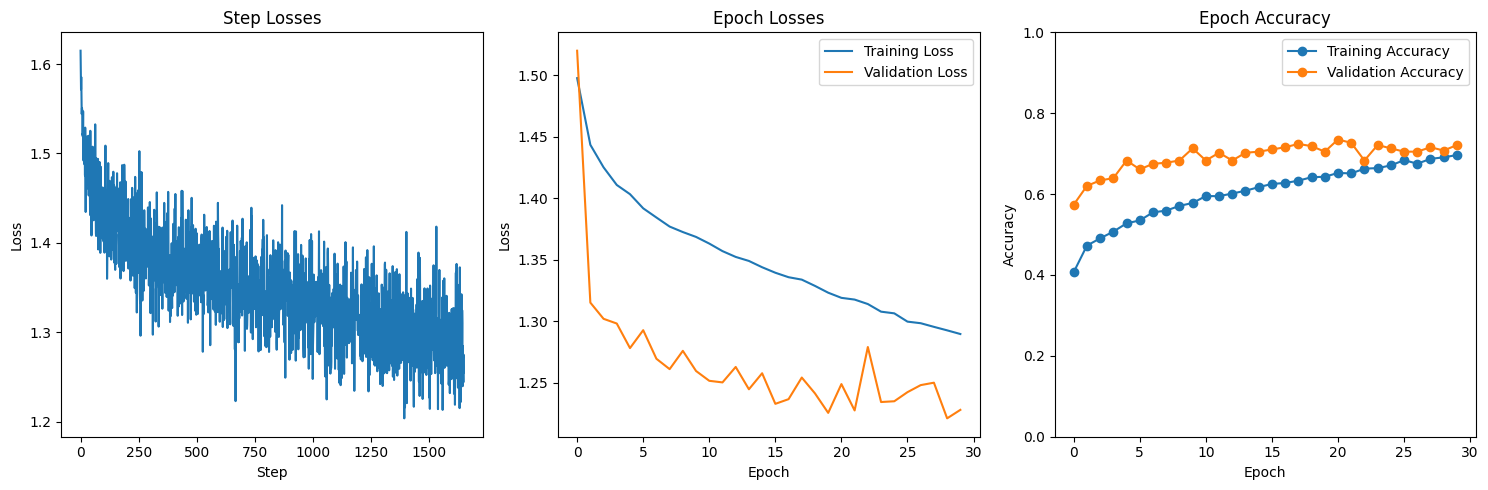

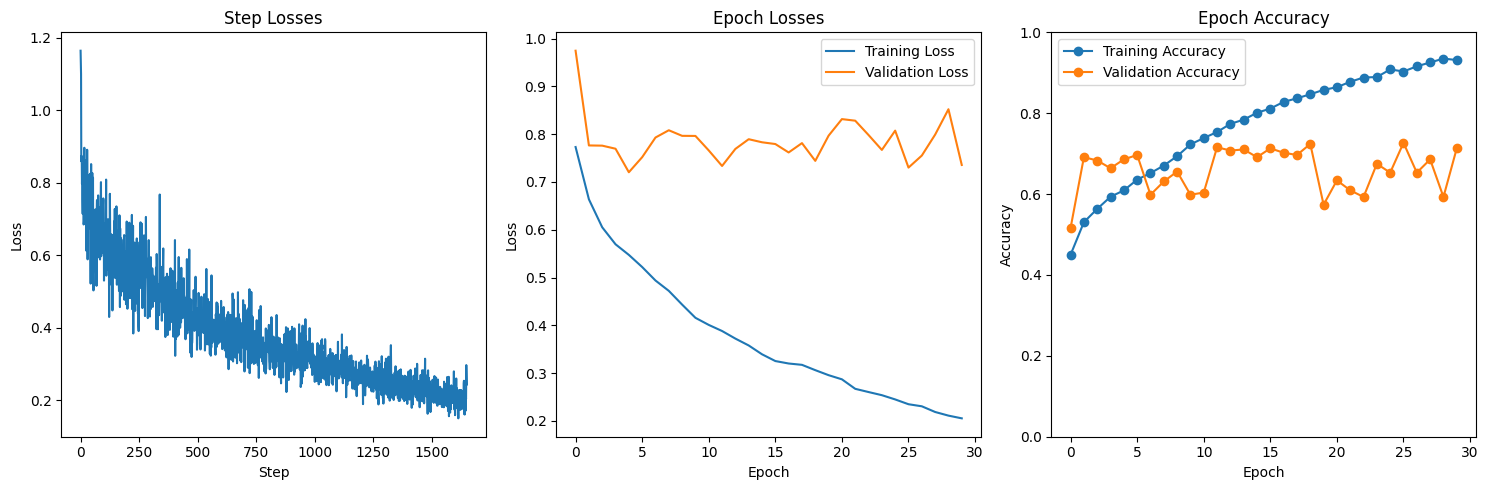

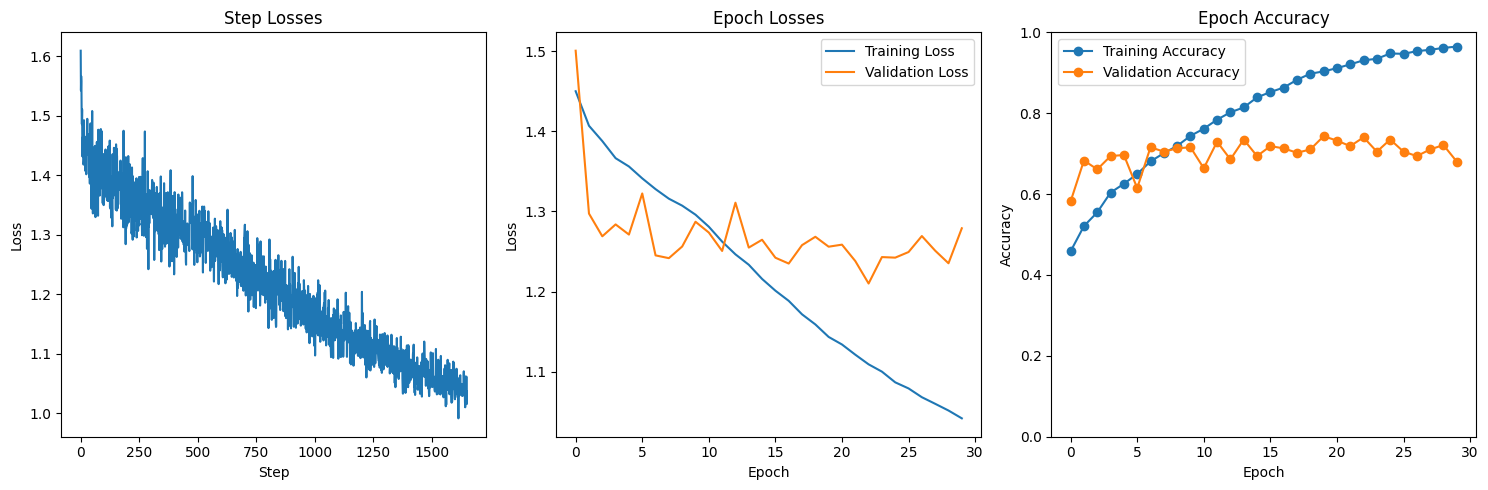

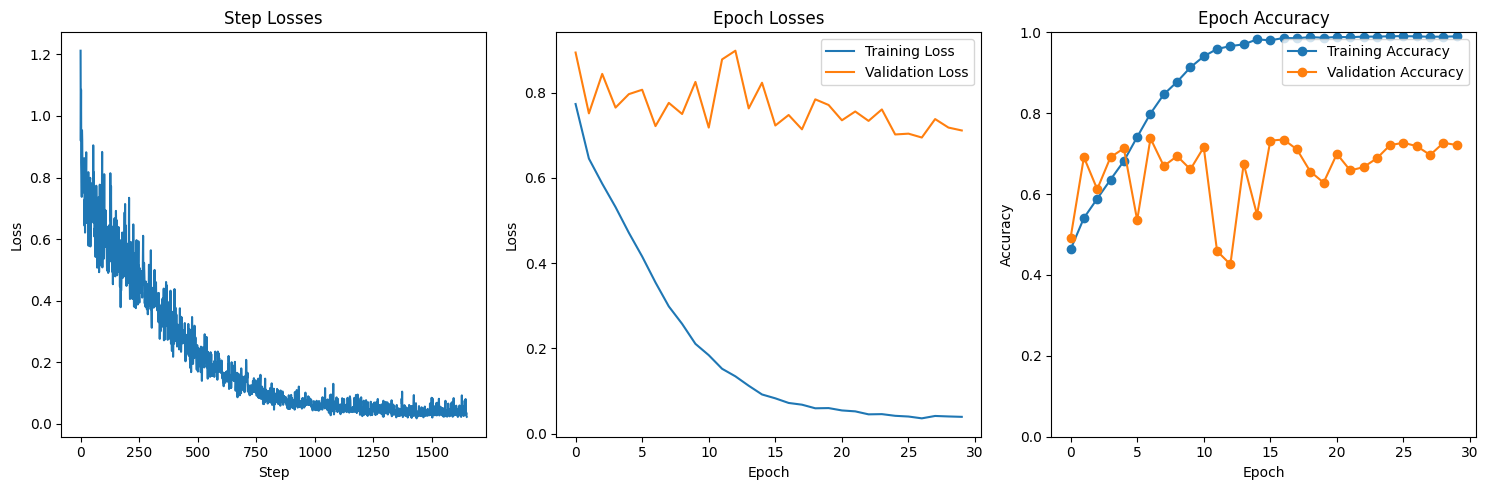

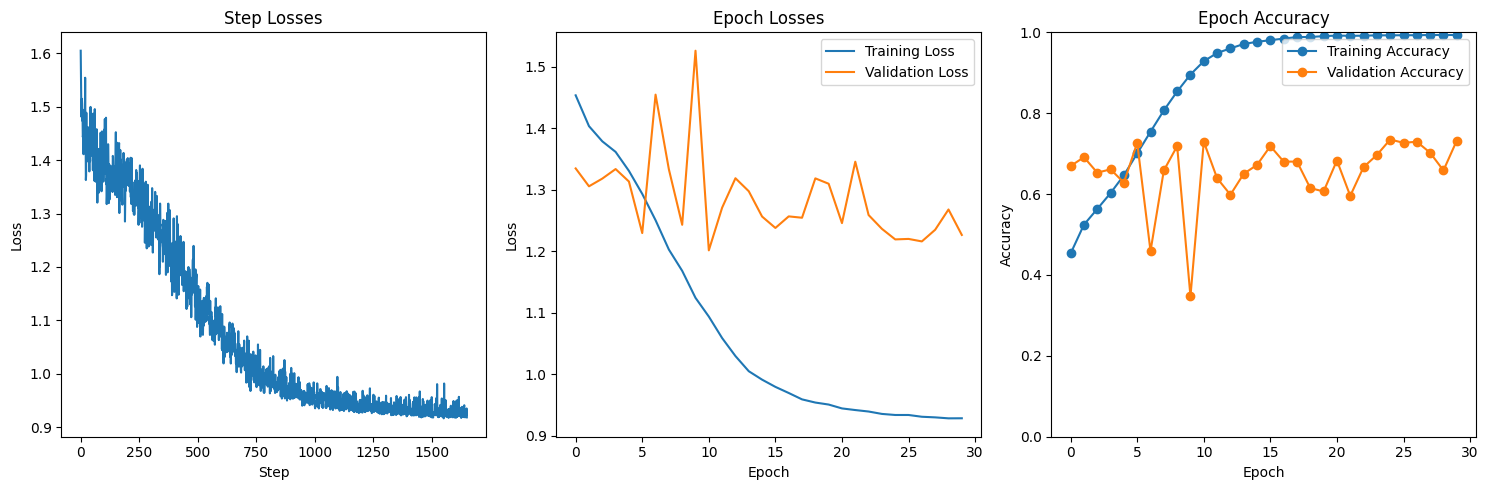

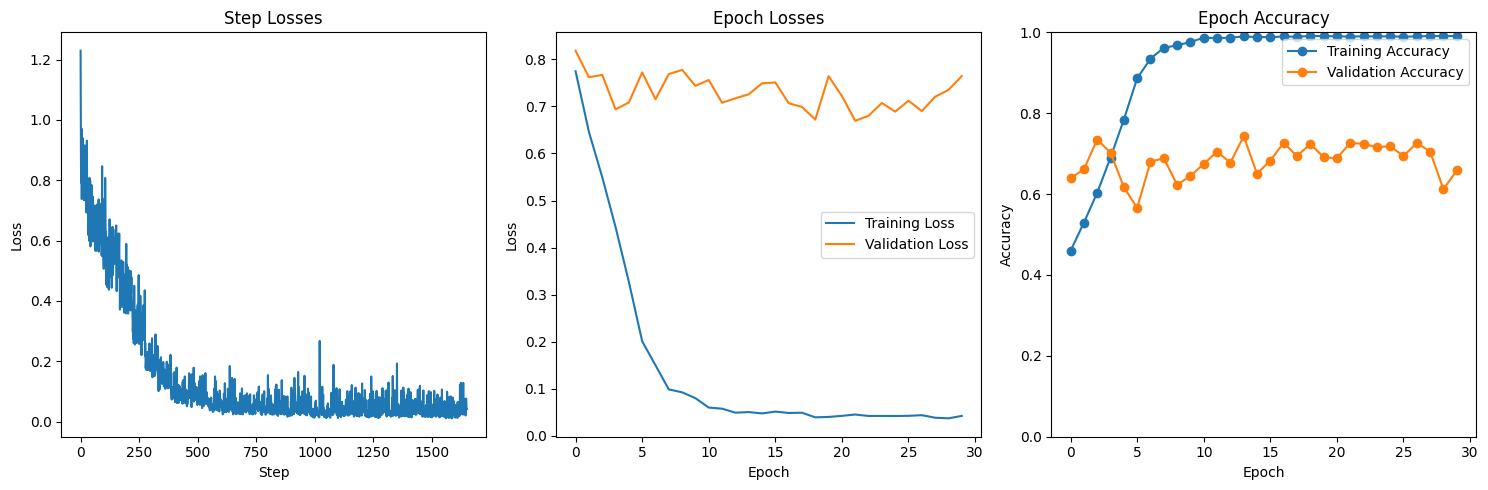

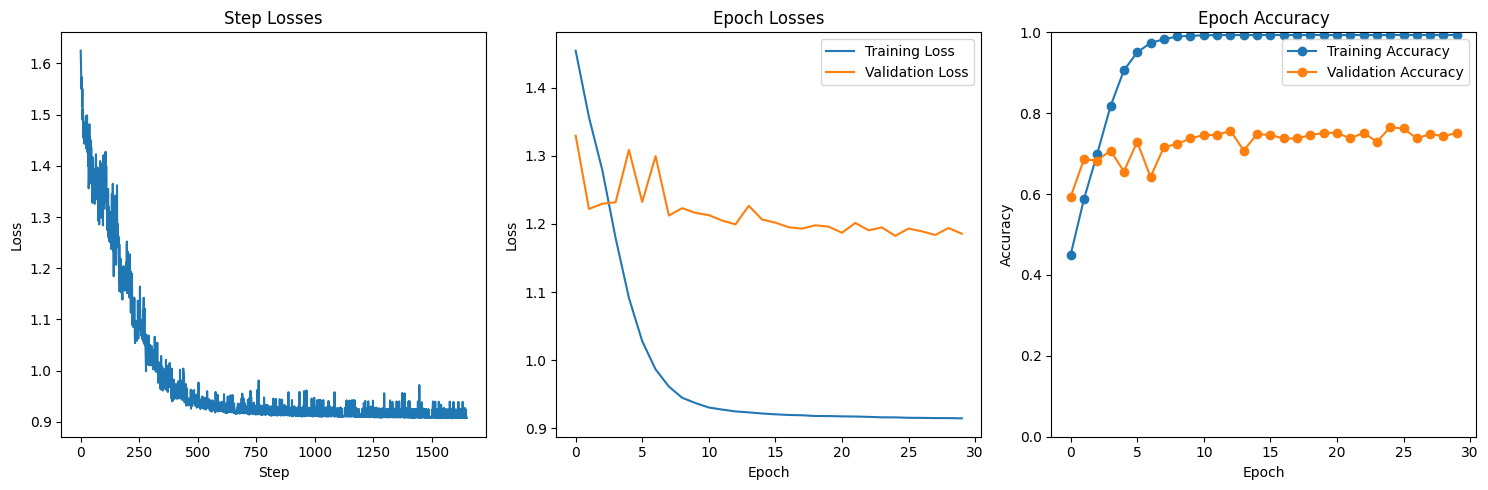

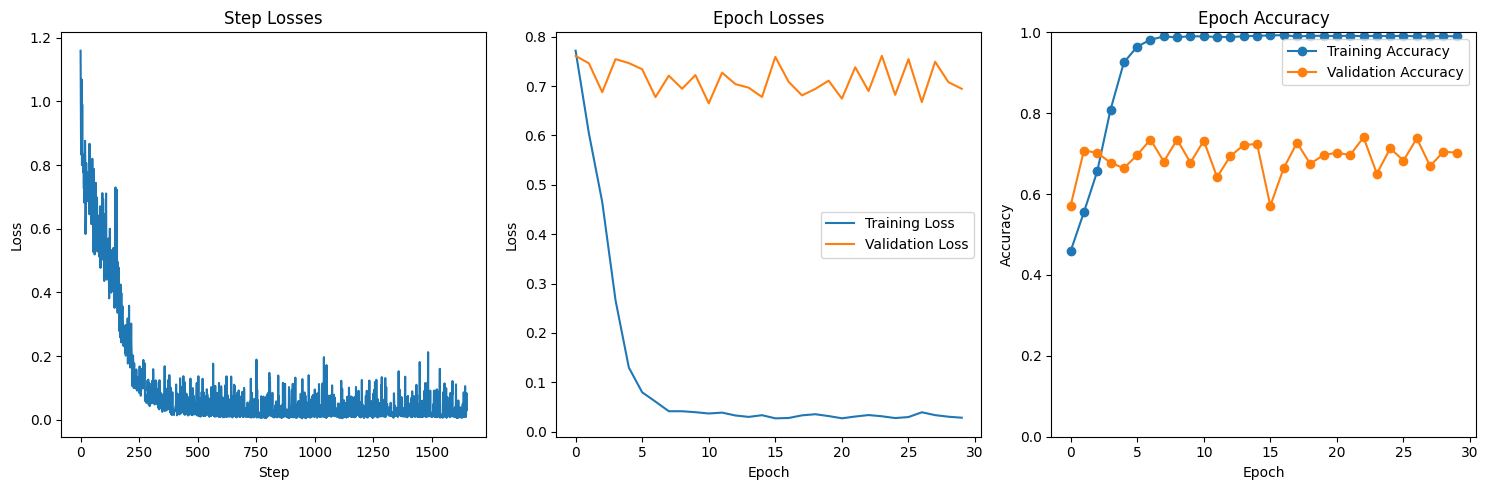

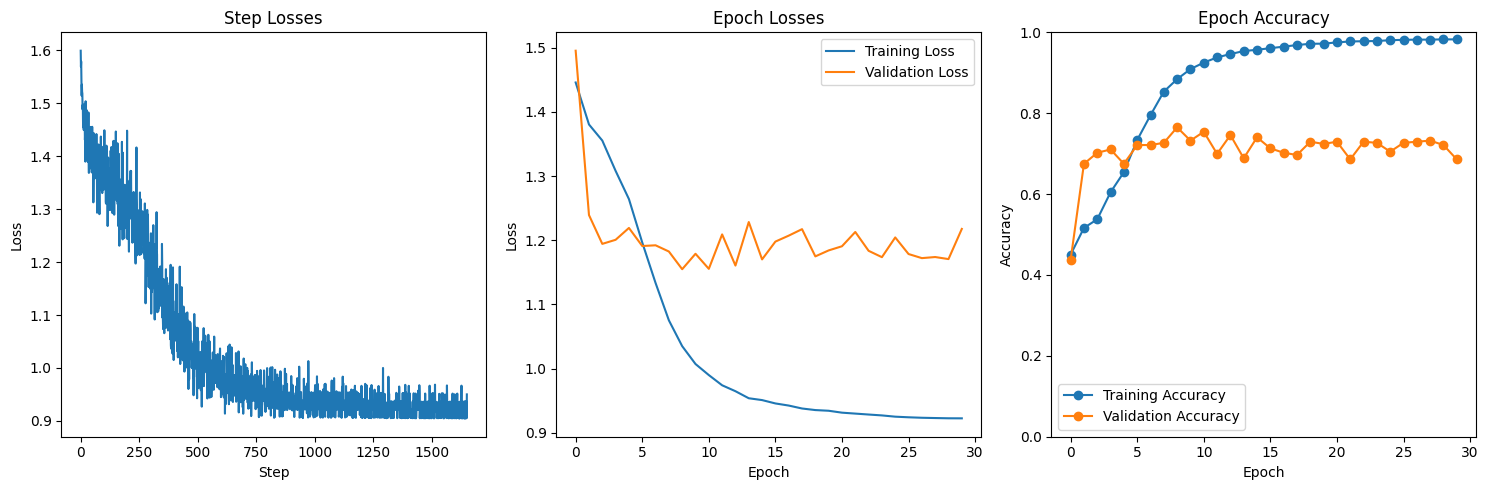

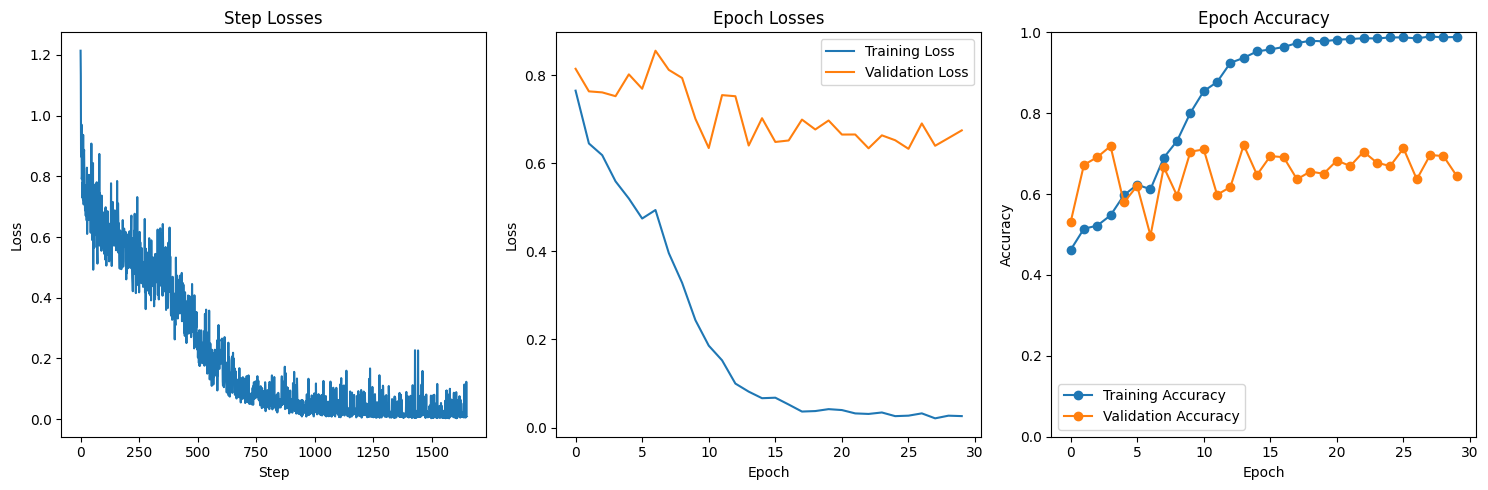

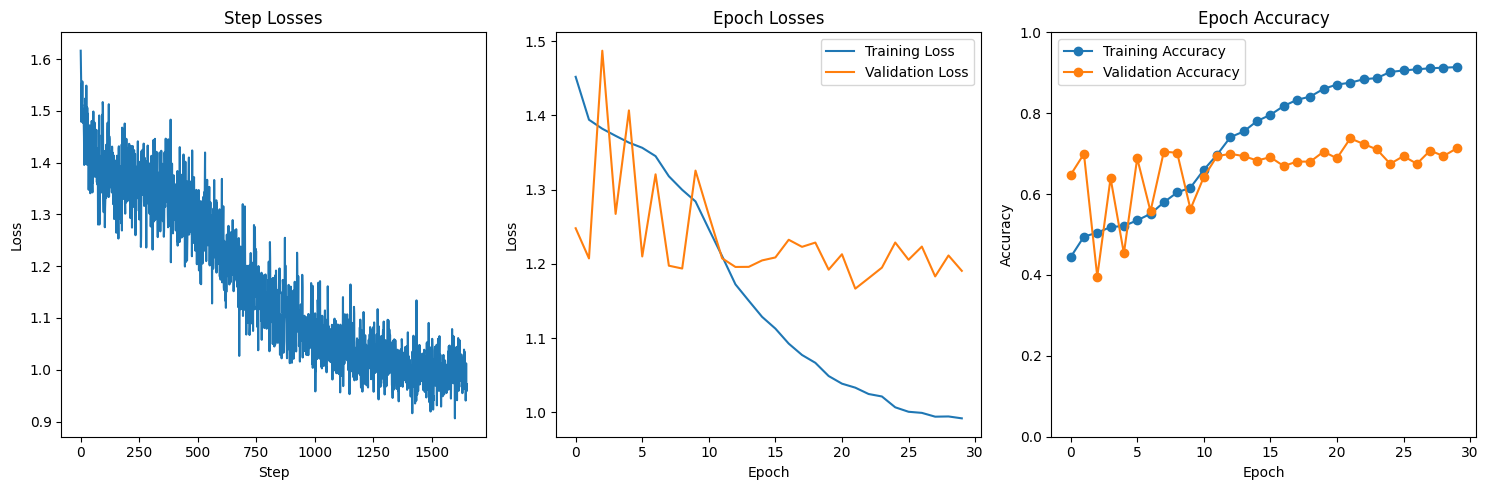

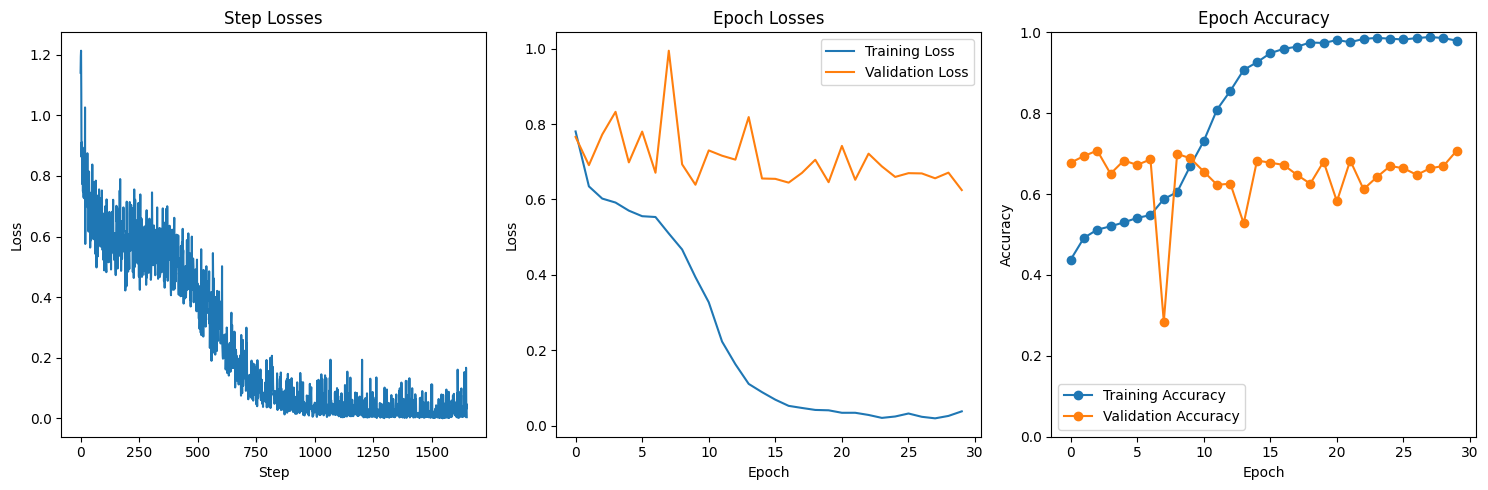

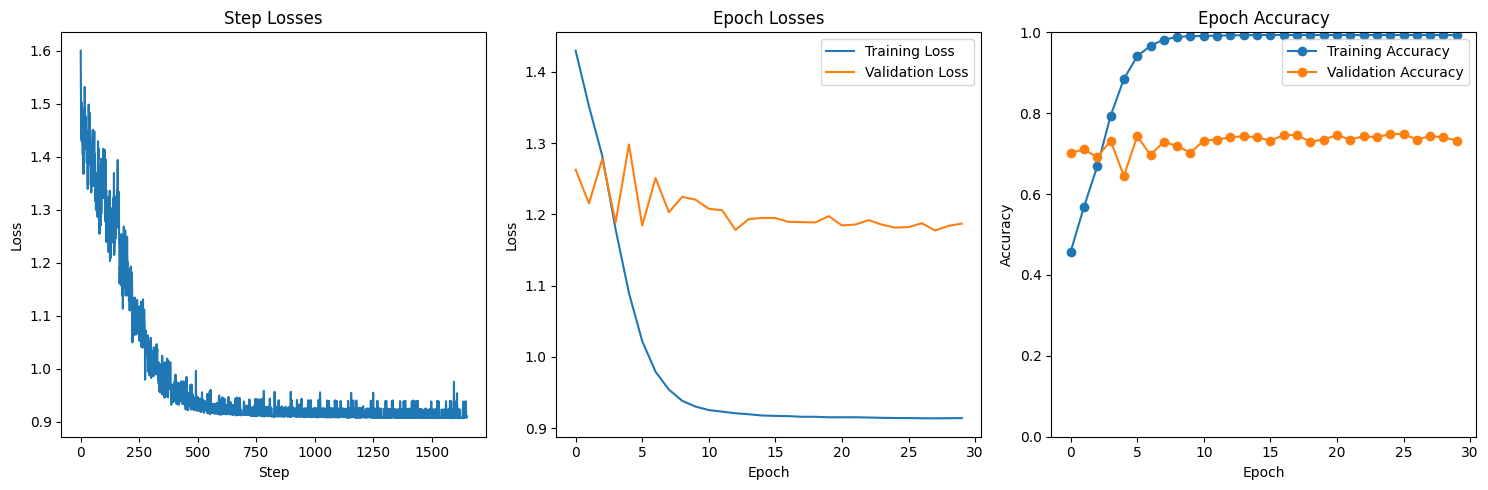

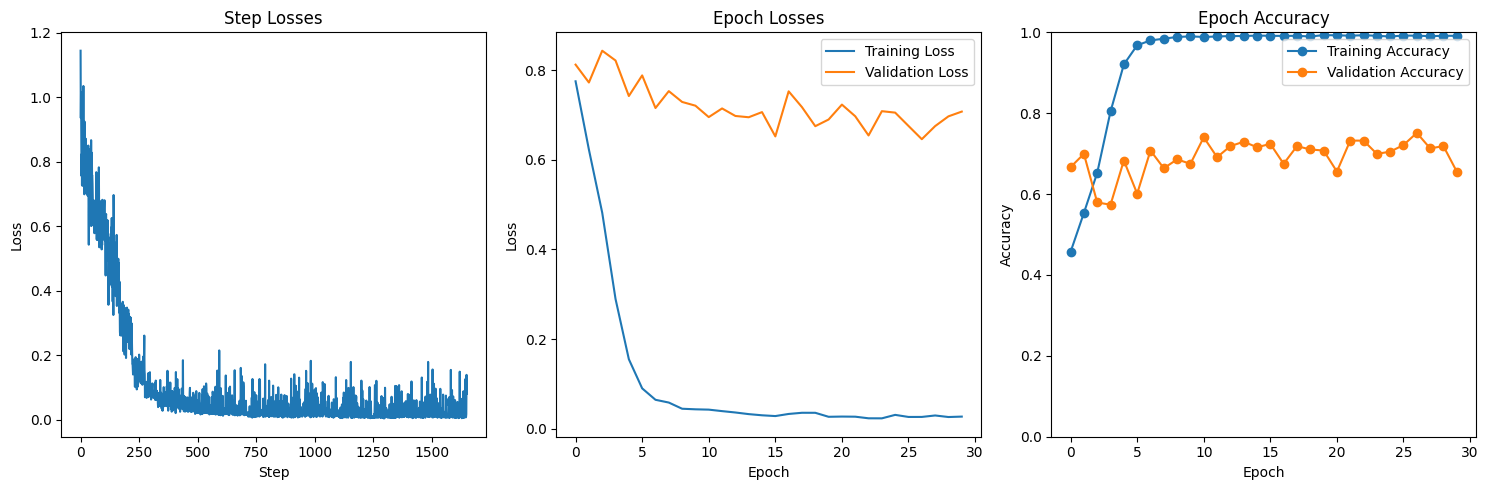

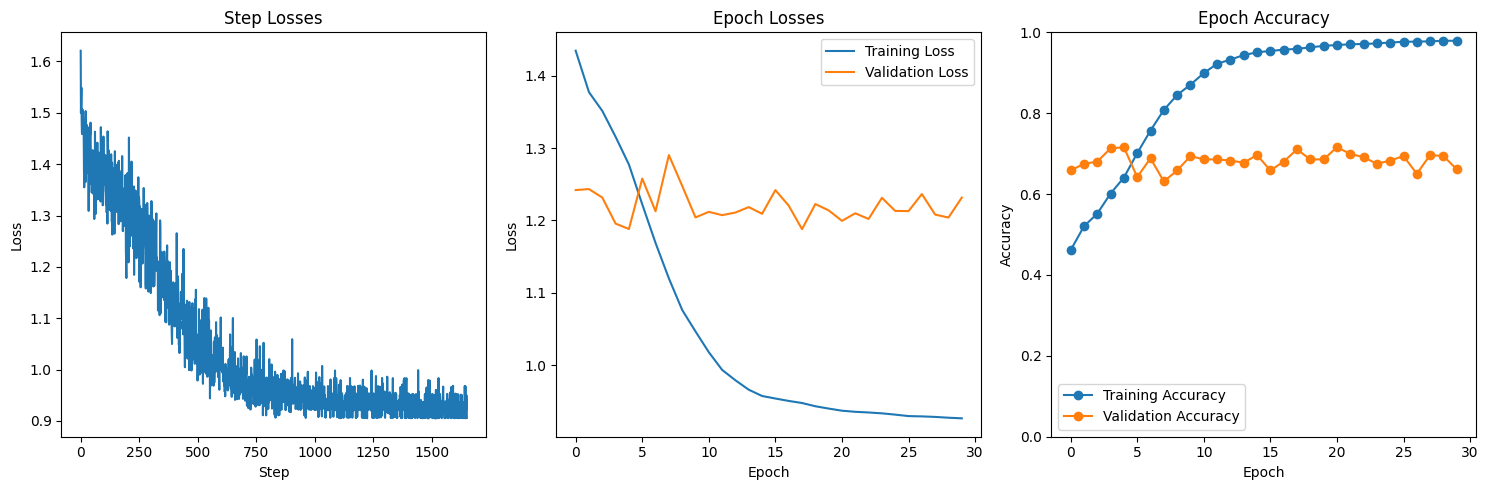

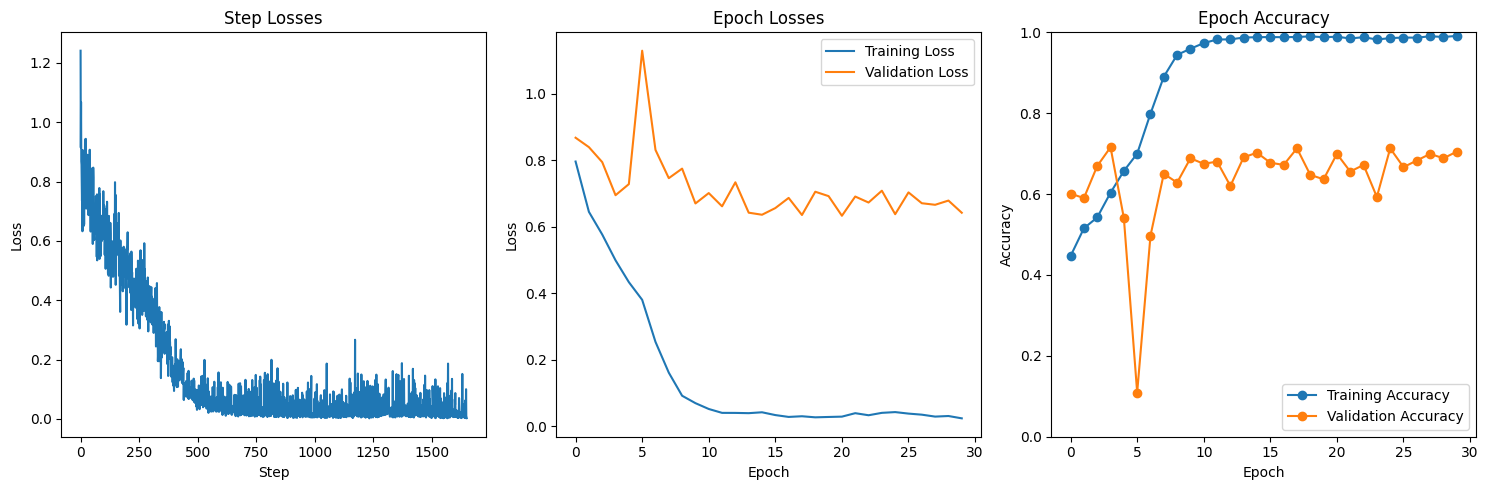

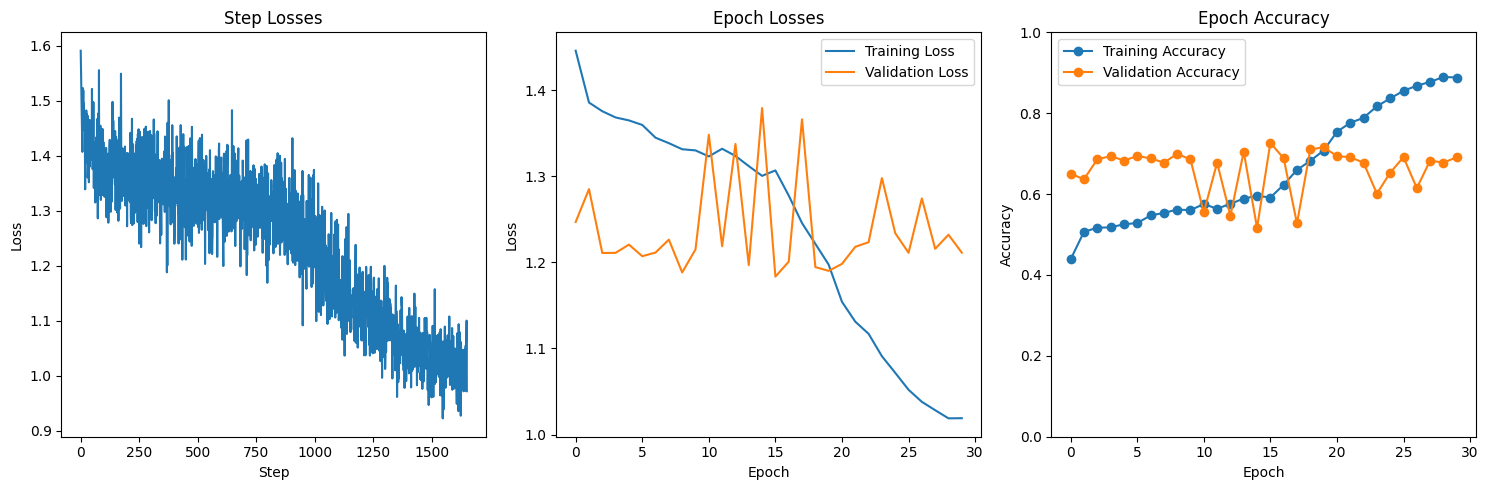

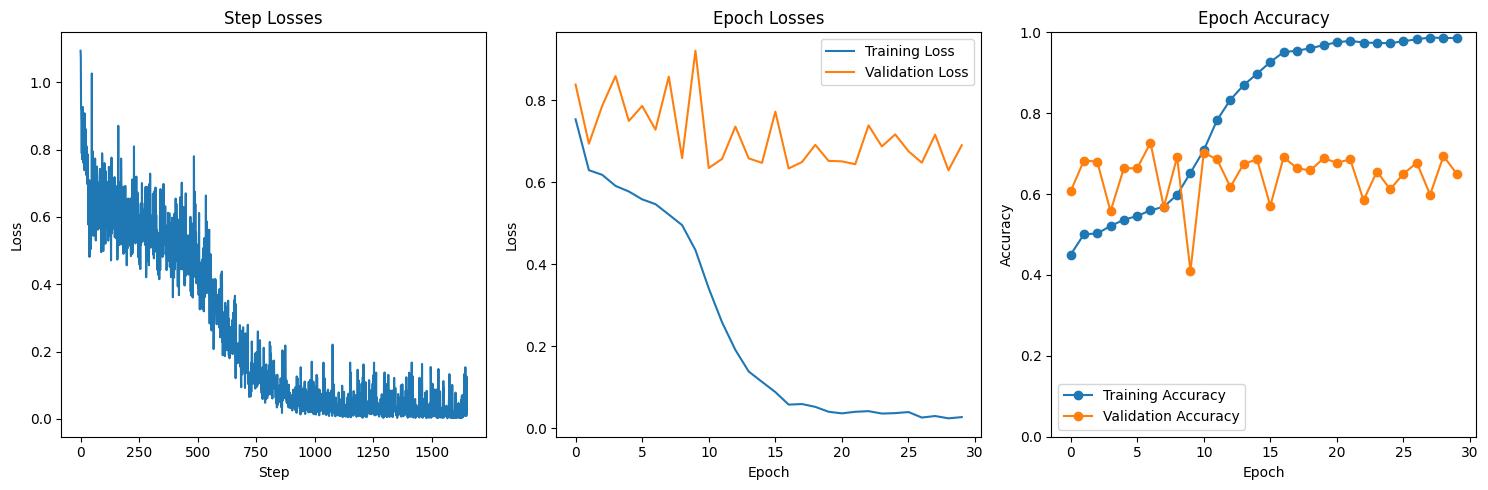

In [49]:
def model_fn():
    return RSGNet()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="RSGNet",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device,
        model_output_softmax = True
    )

# Simone's Model

In [50]:
class Simone(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(Simone, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc2(x)

        return x

In [ ]:
model_simone = Simone()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-3,
    num_epochs = 30,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_simone")

Partono 18 esperimenti...

[1/18] Simone_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6075 train acc=0.2017, validation loss: 1.6137 validation acc=0.2842
Epoch 2/30


Epoch 2 training loss: 1.6035 train acc=0.2400, validation loss: 1.6074 validation acc=0.2842
Epoch 3/30


Epoch 3 training loss: 1.6001 train acc=0.2817, validation loss: 1.6023 validation acc=0.2842
Epoch 4/30


Epoch 4 training loss: 1.5982 train acc=0.2834, validation loss: 1.5992 validation acc=0.2842
Epoch 5/30


Epoch 5 training loss: 1.5939 train acc=0.2980, validation loss: 1.5970 validation acc=0.2760
Epoch 6/30


Epoch 6 training loss: 1.5909 train acc=0.2943, validation loss: 1.5944 validation acc=0.3497
Epoch 7/30


Epoch 7 training loss: 1.5885 train acc=0.3134, validation loss: 1.5912 validation acc=0.4426
Epoch 8/30


Epoch 8 training loss: 1.5841 train acc=0.3046, validation loss: 1.5885 validation acc=0.5273
Epoch 9/30


Epoch 9 training loss: 1.5817 train acc=0.3220, validation loss: 1.5854 validation acc=0.5355
Epoch 10/30


Epoch 10 training loss: 1.5776 train acc=0.3389, validation loss: 1.5825 validation acc=0.5519
Epoch 11/30


Epoch 11 training loss: 1.5751 train acc=0.3271, validation loss: 1.5787 validation acc=0.6011
Epoch 12/30


Epoch 12 training loss: 1.5725 train acc=0.3486, validation loss: 1.5777 validation acc=0.6066
Epoch 13/30


Epoch 13 training loss: 1.5670 train acc=0.3660, validation loss: 1.5740 validation acc=0.6148
Epoch 14/30


Epoch 14 training loss: 1.5620 train acc=0.3643, validation loss: 1.5689 validation acc=0.6175
Epoch 15/30


Epoch 15 training loss: 1.5579 train acc=0.3760, validation loss: 1.5632 validation acc=0.6311
Epoch 16/30


Epoch 16 training loss: 1.5528 train acc=0.3769, validation loss: 1.5602 validation acc=0.6284
Epoch 17/30


Epoch 17 training loss: 1.5466 train acc=0.3826, validation loss: 1.5565 validation acc=0.6175
Epoch 18/30


Epoch 18 training loss: 1.5427 train acc=0.3883, validation loss: 1.5490 validation acc=0.6230
Epoch 19/30


Epoch 19 training loss: 1.5383 train acc=0.3834, validation loss: 1.5446 validation acc=0.6175
Epoch 20/30


Epoch 20 training loss: 1.5295 train acc=0.3966, validation loss: 1.5375 validation acc=0.6175
Epoch 21/30


Epoch 21 training loss: 1.5246 train acc=0.3980, validation loss: 1.5317 validation acc=0.6175
Epoch 22/30


Epoch 22 training loss: 1.5169 train acc=0.4049, validation loss: 1.5232 validation acc=0.6148
Epoch 23/30


Epoch 23 training loss: 1.5097 train acc=0.4034, validation loss: 1.5189 validation acc=0.6120
Epoch 24/30


Epoch 24 training loss: 1.5036 train acc=0.4080, validation loss: 1.5092 validation acc=0.6120
Epoch 25/30


Epoch 25 training loss: 1.4934 train acc=0.4054, validation loss: 1.5007 validation acc=0.6120
Epoch 26/30


Epoch 26 training loss: 1.4828 train acc=0.4191, validation loss: 1.4863 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 1.4761 train acc=0.4140, validation loss: 1.4790 validation acc=0.6093
Epoch 28/30


Epoch 28 training loss: 1.4663 train acc=0.4191, validation loss: 1.4657 validation acc=0.6148
Epoch 29/30


Epoch 29 training loss: 1.4569 train acc=0.4237, validation loss: 1.4510 validation acc=0.6202
Epoch 30/30


Epoch 30 training loss: 1.4499 train acc=0.4171, validation loss: 1.4406 validation acc=0.6120
Test Accuracy: 65.85% | Precision: 0.284 | Recall: 0.341 | F1: 0.304
[2/18] Simone_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0281 train acc=0.2174, validation loss: 1.0365 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 1.0213 train acc=0.2791, validation loss: 1.0279 validation acc=0.1093
Epoch 3/30


Epoch 3 training loss: 1.0149 train acc=0.3091, validation loss: 1.0210 validation acc=0.1421
Epoch 4/30


Epoch 4 training loss: 1.0105 train acc=0.3303, validation loss: 1.0128 validation acc=0.2923
Epoch 5/30


Epoch 5 training loss: 1.0061 train acc=0.3326, validation loss: 1.0062 validation acc=0.4290
Epoch 6/30


Epoch 6 training loss: 0.9992 train acc=0.3431, validation loss: 1.0038 validation acc=0.4344
Epoch 7/30


Epoch 7 training loss: 0.9935 train acc=0.3494, validation loss: 0.9968 validation acc=0.4645
Epoch 8/30


Epoch 8 training loss: 0.9881 train acc=0.3614, validation loss: 0.9928 validation acc=0.4918
Epoch 9/30


Epoch 9 training loss: 0.9837 train acc=0.3623, validation loss: 0.9859 validation acc=0.5082
Epoch 10/30


Epoch 10 training loss: 0.9759 train acc=0.3854, validation loss: 0.9812 validation acc=0.5082
Epoch 11/30


Epoch 11 training loss: 0.9719 train acc=0.3803, validation loss: 0.9760 validation acc=0.5164
Epoch 12/30


Epoch 12 training loss: 0.9645 train acc=0.3900, validation loss: 0.9696 validation acc=0.5191
Epoch 13/30


Epoch 13 training loss: 0.9565 train acc=0.3914, validation loss: 0.9589 validation acc=0.5328
Epoch 14/30


Epoch 14 training loss: 0.9492 train acc=0.4071, validation loss: 0.9491 validation acc=0.5546
Epoch 15/30


Epoch 15 training loss: 0.9430 train acc=0.4040, validation loss: 0.9452 validation acc=0.5437
Epoch 16/30


Epoch 16 training loss: 0.9377 train acc=0.4031, validation loss: 0.9392 validation acc=0.5355
Epoch 17/30


Epoch 17 training loss: 0.9267 train acc=0.4086, validation loss: 0.9306 validation acc=0.5464
Epoch 18/30


Epoch 18 training loss: 0.9205 train acc=0.4137, validation loss: 0.9170 validation acc=0.5738
Epoch 19/30


Epoch 19 training loss: 0.9142 train acc=0.4091, validation loss: 0.9100 validation acc=0.5628
Epoch 20/30


Epoch 20 training loss: 0.9054 train acc=0.4063, validation loss: 0.9033 validation acc=0.5929
Epoch 21/30


Epoch 21 training loss: 0.8977 train acc=0.4120, validation loss: 0.8939 validation acc=0.5956
Epoch 22/30


Epoch 22 training loss: 0.8903 train acc=0.4220, validation loss: 0.8798 validation acc=0.6148
Epoch 23/30


Epoch 23 training loss: 0.8790 train acc=0.4189, validation loss: 0.8689 validation acc=0.6066
Epoch 24/30


Epoch 24 training loss: 0.8694 train acc=0.4311, validation loss: 0.8567 validation acc=0.6148
Epoch 25/30


Epoch 25 training loss: 0.8640 train acc=0.4189, validation loss: 0.8451 validation acc=0.6202
Epoch 26/30


Epoch 26 training loss: 0.8560 train acc=0.4266, validation loss: 0.8329 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 0.8463 train acc=0.4234, validation loss: 0.8247 validation acc=0.6120
Epoch 28/30


Epoch 28 training loss: 0.8373 train acc=0.4214, validation loss: 0.8151 validation acc=0.6120
Epoch 29/30


Epoch 29 training loss: 0.8280 train acc=0.4371, validation loss: 0.7968 validation acc=0.6202
Epoch 30/30


Epoch 30 training loss: 0.8222 train acc=0.4311, validation loss: 0.7947 validation acc=0.6093
Test Accuracy: 66.39% | Precision: 0.358 | Recall: 0.360 | F1: 0.347
[3/18] Simone_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6026 train acc=0.2431, validation loss: 1.5753 validation acc=0.5055
Epoch 2/30


Epoch 2 training loss: 1.5776 train acc=0.3194, validation loss: 1.5309 validation acc=0.6038
Epoch 3/30


Epoch 3 training loss: 1.5338 train acc=0.3577, validation loss: 1.4824 validation acc=0.6530
Epoch 4/30


Epoch 4 training loss: 1.4679 train acc=0.3869, validation loss: 1.3495 validation acc=0.6257
Epoch 5/30


Epoch 5 training loss: 1.3893 train acc=0.4109, validation loss: 1.2574 validation acc=0.5929
Epoch 6/30


Epoch 6 training loss: 1.3276 train acc=0.4183, validation loss: 1.1226 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 1.2928 train acc=0.4226, validation loss: 1.0411 validation acc=0.6557
Epoch 8/30


Epoch 8 training loss: 1.2625 train acc=0.4520, validation loss: 1.0694 validation acc=0.6230
Epoch 9/30


Epoch 9 training loss: 1.2401 train acc=0.4594, validation loss: 1.0290 validation acc=0.6393
Epoch 10/30


Epoch 10 training loss: 1.2285 train acc=0.4631, validation loss: 1.0044 validation acc=0.6393
Epoch 11/30


Epoch 11 training loss: 1.2125 train acc=0.4697, validation loss: 0.9767 validation acc=0.6530
Epoch 12/30


Epoch 12 training loss: 1.2006 train acc=0.4731, validation loss: 0.9950 validation acc=0.6339
Epoch 13/30


Epoch 13 training loss: 1.1865 train acc=0.4863, validation loss: 0.9364 validation acc=0.6530
Epoch 14/30


Epoch 14 training loss: 1.1704 train acc=0.4900, validation loss: 0.9500 validation acc=0.6503
Epoch 15/30


Epoch 15 training loss: 1.1598 train acc=0.4897, validation loss: 0.9762 validation acc=0.6475
Epoch 16/30


Epoch 16 training loss: 1.1544 train acc=0.4937, validation loss: 1.0276 validation acc=0.6503
Epoch 17/30


Epoch 17 training loss: 1.1476 train acc=0.4966, validation loss: 0.9533 validation acc=0.6612
Epoch 18/30


Epoch 18 training loss: 1.1470 train acc=0.5011, validation loss: 0.9435 validation acc=0.6639
Epoch 19/30


Epoch 19 training loss: 1.1381 train acc=0.5054, validation loss: 0.9178 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 1.1312 train acc=0.5091, validation loss: 0.8987 validation acc=0.6612
Epoch 21/30


Epoch 21 training loss: 1.1196 train acc=0.5226, validation loss: 0.8817 validation acc=0.6585
Epoch 22/30


Epoch 22 training loss: 1.1307 train acc=0.5140, validation loss: 0.9108 validation acc=0.6749
Epoch 23/30


Epoch 23 training loss: 1.1153 train acc=0.5214, validation loss: 0.9217 validation acc=0.6803
Epoch 24/30


Epoch 24 training loss: 1.1019 train acc=0.5257, validation loss: 0.8929 validation acc=0.6831
Epoch 25/30


Epoch 25 training loss: 1.1062 train acc=0.5146, validation loss: 0.8747 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 1.0993 train acc=0.5280, validation loss: 0.8861 validation acc=0.6913
Epoch 27/30


Epoch 27 training loss: 1.0990 train acc=0.5294, validation loss: 0.8705 validation acc=0.6639
Epoch 28/30


Epoch 28 training loss: 1.0836 train acc=0.5251, validation loss: 0.8656 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 1.0907 train acc=0.5217, validation loss: 0.9335 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 1.0776 train acc=0.5406, validation loss: 0.8530 validation acc=0.6721
Test Accuracy: 70.22% | Precision: 0.402 | Recall: 0.374 | F1: 0.330
[4/18] Simone_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0160 train acc=0.2600, validation loss: 0.9940 validation acc=0.6066
Epoch 2/30


Epoch 2 training loss: 0.9765 train acc=0.3411, validation loss: 0.9396 validation acc=0.6311
Epoch 3/30


Epoch 3 training loss: 0.9245 train acc=0.3914, validation loss: 0.8803 validation acc=0.5984
Epoch 4/30


Epoch 4 training loss: 0.8657 train acc=0.4160, validation loss: 0.7851 validation acc=0.6366
Epoch 5/30


Epoch 5 training loss: 0.8065 train acc=0.4331, validation loss: 0.7081 validation acc=0.6257
Epoch 6/30


Epoch 6 training loss: 0.7666 train acc=0.4406, validation loss: 0.6624 validation acc=0.6284
Epoch 7/30


Epoch 7 training loss: 0.7412 train acc=0.4574, validation loss: 0.6262 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 0.7209 train acc=0.4586, validation loss: 0.6016 validation acc=0.6475
Epoch 9/30


Epoch 9 training loss: 0.7030 train acc=0.4714, validation loss: 0.5700 validation acc=0.6639
Epoch 10/30


Epoch 10 training loss: 0.6968 train acc=0.4866, validation loss: 0.6128 validation acc=0.6366
Epoch 11/30


Epoch 11 training loss: 0.6824 train acc=0.4729, validation loss: 0.5586 validation acc=0.6639
Epoch 12/30


Epoch 12 training loss: 0.6799 train acc=0.4754, validation loss: 0.5723 validation acc=0.6503
Epoch 13/30


Epoch 13 training loss: 0.6663 train acc=0.4820, validation loss: 0.5454 validation acc=0.6612
Epoch 14/30


Epoch 14 training loss: 0.6543 train acc=0.5037, validation loss: 0.5476 validation acc=0.6612
Epoch 15/30


Epoch 15 training loss: 0.6484 train acc=0.5051, validation loss: 0.5420 validation acc=0.6585
Epoch 16/30


Epoch 16 training loss: 0.6412 train acc=0.5020, validation loss: 0.5476 validation acc=0.6585
Epoch 17/30


Epoch 17 training loss: 0.6376 train acc=0.5060, validation loss: 0.5556 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.6259 train acc=0.5149, validation loss: 0.5174 validation acc=0.6667
Epoch 19/30


Epoch 19 training loss: 0.6230 train acc=0.5160, validation loss: 0.5387 validation acc=0.6585
Epoch 20/30


Epoch 20 training loss: 0.6130 train acc=0.5263, validation loss: 0.5351 validation acc=0.6721
Epoch 21/30


Epoch 21 training loss: 0.6160 train acc=0.5183, validation loss: 0.5248 validation acc=0.6721
Epoch 22/30


Epoch 22 training loss: 0.6075 train acc=0.5154, validation loss: 0.5303 validation acc=0.6721
Epoch 23/30


Epoch 23 training loss: 0.5949 train acc=0.5226, validation loss: 0.4953 validation acc=0.6885
Epoch 24/30


Epoch 24 training loss: 0.6002 train acc=0.5246, validation loss: 0.5096 validation acc=0.6694
Epoch 25/30


Epoch 25 training loss: 0.6000 train acc=0.5274, validation loss: 0.5003 validation acc=0.6667
Epoch 26/30


Epoch 26 training loss: 0.5901 train acc=0.5317, validation loss: 0.5148 validation acc=0.6885
Epoch 27/30


Epoch 27 training loss: 0.5851 train acc=0.5346, validation loss: 0.5018 validation acc=0.6776
Epoch 28/30


Epoch 28 training loss: 0.5786 train acc=0.5331, validation loss: 0.5069 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.5788 train acc=0.5323, validation loss: 0.5105 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 0.5751 train acc=0.5414, validation loss: 0.4807 validation acc=0.6803
Test Accuracy: 71.31% | Precision: 0.281 | Recall: 0.361 | F1: 0.308
[5/18] Simone_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5719 train acc=0.2857, validation loss: 1.4592 validation acc=0.5519
Epoch 2/30


Epoch 2 training loss: 1.3997 train acc=0.3840, validation loss: 1.0491 validation acc=0.6475
Epoch 3/30


Epoch 3 training loss: 1.2982 train acc=0.4323, validation loss: 1.0315 validation acc=0.6257
Epoch 4/30


Epoch 4 training loss: 1.2568 train acc=0.4460, validation loss: 0.9586 validation acc=0.6530
Epoch 5/30


Epoch 5 training loss: 1.2161 train acc=0.4694, validation loss: 0.9810 validation acc=0.6366
Epoch 6/30


Epoch 6 training loss: 1.1987 train acc=0.4717, validation loss: 0.8895 validation acc=0.6585
Epoch 7/30


Epoch 7 training loss: 1.1746 train acc=0.4931, validation loss: 0.9192 validation acc=0.6503
Epoch 8/30


Epoch 8 training loss: 1.1702 train acc=0.5063, validation loss: 0.8809 validation acc=0.6557
Epoch 9/30


Epoch 9 training loss: 1.1443 train acc=0.5077, validation loss: 0.9152 validation acc=0.6585
Epoch 10/30


Epoch 10 training loss: 1.1379 train acc=0.5029, validation loss: 0.9654 validation acc=0.6639
Epoch 11/30


Epoch 11 training loss: 1.1422 train acc=0.5051, validation loss: 0.9008 validation acc=0.6612
Epoch 12/30


Epoch 12 training loss: 1.1257 train acc=0.5100, validation loss: 0.9591 validation acc=0.6366
Epoch 13/30


Epoch 13 training loss: 1.1257 train acc=0.5020, validation loss: 0.9542 validation acc=0.6503
Epoch 14/30


Epoch 14 training loss: 1.1139 train acc=0.5149, validation loss: 0.9483 validation acc=0.6585
Epoch 15/30


Epoch 15 training loss: 1.1111 train acc=0.5169, validation loss: 0.9287 validation acc=0.6393
Epoch 16/30


Epoch 16 training loss: 1.0900 train acc=0.5289, validation loss: 0.8974 validation acc=0.6585
Epoch 17/30


Epoch 17 training loss: 1.0848 train acc=0.5134, validation loss: 0.9739 validation acc=0.6230
Epoch 18/30


Epoch 18 training loss: 1.0792 train acc=0.5234, validation loss: 0.9616 validation acc=0.6639
Epoch 19/30


Epoch 19 training loss: 1.0718 train acc=0.5423, validation loss: 0.8351 validation acc=0.6885
Epoch 20/30


Epoch 20 training loss: 1.0491 train acc=0.5389, validation loss: 0.8718 validation acc=0.6694
Epoch 21/30


Epoch 21 training loss: 1.0584 train acc=0.5449, validation loss: 0.8264 validation acc=0.6885
Epoch 22/30


Epoch 22 training loss: 1.0479 train acc=0.5623, validation loss: 0.8294 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 1.0518 train acc=0.5497, validation loss: 0.8997 validation acc=0.6612
Epoch 24/30


Epoch 24 training loss: 1.0414 train acc=0.5551, validation loss: 0.8437 validation acc=0.6940
Epoch 25/30


Epoch 25 training loss: 1.0392 train acc=0.5526, validation loss: 0.9283 validation acc=0.6721
Epoch 26/30


Epoch 26 training loss: 1.0427 train acc=0.5531, validation loss: 0.8696 validation acc=0.6694
Epoch 27/30


Epoch 27 training loss: 1.0330 train acc=0.5626, validation loss: 0.8826 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 1.0316 train acc=0.5443, validation loss: 0.9959 validation acc=0.6284
Epoch 29/30


Epoch 29 training loss: 1.0342 train acc=0.5540, validation loss: 0.8578 validation acc=0.6995
Epoch 30/30


Epoch 30 training loss: 1.0067 train acc=0.5597, validation loss: 0.8095 validation acc=0.6776
Test Accuracy: 73.22% | Precision: 0.429 | Recall: 0.427 | F1: 0.415
[6/18] Simone_run_006_optimizer_name=sgd_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0132 train acc=0.2509, validation loss: 0.9614 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 0.9315 train acc=0.3469, validation loss: 0.7828 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 0.8254 train acc=0.3917, validation loss: 0.6637 validation acc=0.6311
Epoch 4/30


Epoch 4 training loss: 0.7648 train acc=0.4169, validation loss: 0.6227 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 0.7419 train acc=0.4494, validation loss: 0.6110 validation acc=0.5929
Epoch 6/30


Epoch 6 training loss: 0.7221 train acc=0.4417, validation loss: 0.5638 validation acc=0.6475
Epoch 7/30


Epoch 7 training loss: 0.7005 train acc=0.4646, validation loss: 0.6054 validation acc=0.6011
Epoch 8/30


Epoch 8 training loss: 0.6817 train acc=0.4754, validation loss: 0.5824 validation acc=0.6475
Epoch 9/30


Epoch 9 training loss: 0.6669 train acc=0.4769, validation loss: 0.5466 validation acc=0.6557
Epoch 10/30


Epoch 10 training loss: 0.6565 train acc=0.4849, validation loss: 0.5949 validation acc=0.5464
Epoch 11/30


Epoch 11 training loss: 0.6435 train acc=0.4909, validation loss: 0.5320 validation acc=0.6557
Epoch 12/30


Epoch 12 training loss: 0.6395 train acc=0.4914, validation loss: 0.5247 validation acc=0.6530
Epoch 13/30


Epoch 13 training loss: 0.6299 train acc=0.5114, validation loss: 0.5657 validation acc=0.6503
Epoch 14/30


Epoch 14 training loss: 0.6217 train acc=0.5094, validation loss: 0.5458 validation acc=0.6448
Epoch 15/30


Epoch 15 training loss: 0.6121 train acc=0.5023, validation loss: 0.4693 validation acc=0.6831
Epoch 16/30


Epoch 16 training loss: 0.6043 train acc=0.5069, validation loss: 0.4831 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 0.5935 train acc=0.5109, validation loss: 0.4792 validation acc=0.6913
Epoch 18/30


Epoch 18 training loss: 0.5926 train acc=0.5034, validation loss: 0.4740 validation acc=0.6749
Epoch 19/30


Epoch 19 training loss: 0.5849 train acc=0.5103, validation loss: 0.4619 validation acc=0.6885
Epoch 20/30


Epoch 20 training loss: 0.5778 train acc=0.5160, validation loss: 0.4969 validation acc=0.6639
Epoch 21/30


Epoch 21 training loss: 0.5756 train acc=0.5131, validation loss: 0.4804 validation acc=0.6913
Epoch 22/30


Epoch 22 training loss: 0.5781 train acc=0.5223, validation loss: 0.5151 validation acc=0.6831
Epoch 23/30


Epoch 23 training loss: 0.5692 train acc=0.5174, validation loss: 0.5381 validation acc=0.6557
Epoch 24/30


Epoch 24 training loss: 0.5662 train acc=0.5251, validation loss: 0.4789 validation acc=0.6885
Epoch 25/30


Epoch 25 training loss: 0.5617 train acc=0.5191, validation loss: 0.4851 validation acc=0.6694
Epoch 26/30


Epoch 26 training loss: 0.5583 train acc=0.5266, validation loss: 0.5060 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.5533 train acc=0.5326, validation loss: 0.4719 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 0.5487 train acc=0.5383, validation loss: 0.4829 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 0.5542 train acc=0.5266, validation loss: 0.4912 validation acc=0.6831
Epoch 30/30


Epoch 30 training loss: 0.5497 train acc=0.5411, validation loss: 0.4780 validation acc=0.6749
Test Accuracy: 72.68% | Precision: 0.415 | Recall: 0.418 | F1: 0.402
[7/18] Simone_run_007_optimizer_name=adam_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5210 train acc=0.3440, validation loss: 1.1242 validation acc=0.6585
Epoch 2/30


Epoch 2 training loss: 1.2836 train acc=0.4271, validation loss: 0.9732 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 1.2247 train acc=0.4557, validation loss: 0.9373 validation acc=0.6721
Epoch 4/30


Epoch 4 training loss: 1.1975 train acc=0.4677, validation loss: 0.9539 validation acc=0.6803
Epoch 5/30


Epoch 5 training loss: 1.1816 train acc=0.4794, validation loss: 0.9679 validation acc=0.6421
Epoch 6/30


Epoch 6 training loss: 1.1669 train acc=0.4863, validation loss: 0.8991 validation acc=0.6749
Epoch 7/30


Epoch 7 training loss: 1.1221 train acc=0.5100, validation loss: 0.8917 validation acc=0.6858
Epoch 8/30


Epoch 8 training loss: 1.1037 train acc=0.5103, validation loss: 0.8955 validation acc=0.6858
Epoch 9/30


Epoch 9 training loss: 1.0926 train acc=0.5351, validation loss: 0.9027 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 1.0493 train acc=0.5411, validation loss: 0.9031 validation acc=0.7131
Epoch 11/30


Epoch 11 training loss: 1.0137 train acc=0.5706, validation loss: 0.9005 validation acc=0.6667
Epoch 12/30


Epoch 12 training loss: 0.9963 train acc=0.5657, validation loss: 0.8547 validation acc=0.7077
Epoch 13/30


Epoch 13 training loss: 0.9624 train acc=0.5900, validation loss: 0.8156 validation acc=0.6967
Epoch 14/30


Epoch 14 training loss: 0.9268 train acc=0.5966, validation loss: 0.7804 validation acc=0.7104
Epoch 15/30


Epoch 15 training loss: 0.8719 train acc=0.6323, validation loss: 0.7841 validation acc=0.7131
Epoch 16/30


Epoch 16 training loss: 0.8159 train acc=0.6477, validation loss: 0.8107 validation acc=0.7240
Epoch 17/30


Epoch 17 training loss: 0.7228 train acc=0.6903, validation loss: 0.7960 validation acc=0.7077
Epoch 18/30


Epoch 18 training loss: 0.6708 train acc=0.7097, validation loss: 0.8852 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.6457 train acc=0.7269, validation loss: 0.8586 validation acc=0.7049
Epoch 20/30


Epoch 20 training loss: 0.5761 train acc=0.7586, validation loss: 0.8446 validation acc=0.7022
Epoch 21/30


Epoch 21 training loss: 0.5280 train acc=0.7737, validation loss: 0.8827 validation acc=0.7104
Epoch 22/30


Epoch 22 training loss: 0.4807 train acc=0.7920, validation loss: 0.9439 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 0.4427 train acc=0.8106, validation loss: 1.0318 validation acc=0.7158
Epoch 24/30


Epoch 24 training loss: 0.4116 train acc=0.8231, validation loss: 1.0219 validation acc=0.7158
Epoch 25/30


Epoch 25 training loss: 0.3885 train acc=0.8329, validation loss: 1.0227 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.3779 train acc=0.8366, validation loss: 1.0301 validation acc=0.6995
Epoch 27/30


Epoch 27 training loss: 0.3603 train acc=0.8420, validation loss: 1.0885 validation acc=0.7213
Epoch 28/30


Epoch 28 training loss: 0.3419 train acc=0.8434, validation loss: 1.2885 validation acc=0.6967
Epoch 29/30


Epoch 29 training loss: 0.3136 train acc=0.8620, validation loss: 1.2872 validation acc=0.7077
Epoch 30/30


Epoch 30 training loss: 0.3090 train acc=0.8683, validation loss: 1.2146 validation acc=0.7213
Test Accuracy: 72.68% | Precision: 0.494 | Recall: 0.500 | F1: 0.481
[8/18] Simone_run_008_optimizer_name=adam_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.9208 train acc=0.3551, validation loss: 0.6282 validation acc=0.6421
Epoch 2/30


Epoch 2 training loss: 0.7259 train acc=0.4489, validation loss: 0.5395 validation acc=0.6612
Epoch 3/30


Epoch 3 training loss: 0.6898 train acc=0.4746, validation loss: 0.5674 validation acc=0.6639
Epoch 4/30


Epoch 4 training loss: 0.6596 train acc=0.4849, validation loss: 0.5111 validation acc=0.6667
Epoch 5/30


Epoch 5 training loss: 0.6311 train acc=0.4937, validation loss: 0.5186 validation acc=0.6776
Epoch 6/30


Epoch 6 training loss: 0.5971 train acc=0.5200, validation loss: 0.5265 validation acc=0.7158
Epoch 7/30


Epoch 7 training loss: 0.5647 train acc=0.5357, validation loss: 0.4979 validation acc=0.7158
Epoch 8/30


Epoch 8 training loss: 0.5369 train acc=0.5694, validation loss: 0.4644 validation acc=0.7158
Epoch 9/30


Epoch 9 training loss: 0.5006 train acc=0.5840, validation loss: 0.4532 validation acc=0.7186
Epoch 10/30


Epoch 10 training loss: 0.4627 train acc=0.6211, validation loss: 0.4254 validation acc=0.7295
Epoch 11/30


Epoch 11 training loss: 0.4109 train acc=0.6449, validation loss: 0.4489 validation acc=0.7295
Epoch 12/30


Epoch 12 training loss: 0.3709 train acc=0.6800, validation loss: 0.4423 validation acc=0.7404
Epoch 13/30


Epoch 13 training loss: 0.3356 train acc=0.7029, validation loss: 0.4642 validation acc=0.7295
Epoch 14/30


Epoch 14 training loss: 0.3027 train acc=0.7217, validation loss: 0.5024 validation acc=0.7022
Epoch 15/30


Epoch 15 training loss: 0.2640 train acc=0.7603, validation loss: 0.5309 validation acc=0.7213
Epoch 16/30


Epoch 16 training loss: 0.2272 train acc=0.7866, validation loss: 0.5286 validation acc=0.7322
Epoch 17/30


Epoch 17 training loss: 0.2003 train acc=0.8083, validation loss: 0.5205 validation acc=0.7158
Epoch 18/30


Epoch 18 training loss: 0.1914 train acc=0.8291, validation loss: 0.5439 validation acc=0.7322
Epoch 19/30


Epoch 19 training loss: 0.1593 train acc=0.8434, validation loss: 0.6841 validation acc=0.7432
Epoch 20/30


Epoch 20 training loss: 0.1576 train acc=0.8394, validation loss: 0.6195 validation acc=0.6967
Epoch 21/30


Epoch 21 training loss: 0.1326 train acc=0.8657, validation loss: 0.6934 validation acc=0.7295
Epoch 22/30


Epoch 22 training loss: 0.1211 train acc=0.8771, validation loss: 0.6412 validation acc=0.7186
Epoch 23/30


Epoch 23 training loss: 0.1095 train acc=0.8871, validation loss: 0.7208 validation acc=0.6940
Epoch 24/30


Epoch 24 training loss: 0.1172 train acc=0.8774, validation loss: 0.7272 validation acc=0.7268
Epoch 25/30


Epoch 25 training loss: 0.1040 train acc=0.8869, validation loss: 0.7650 validation acc=0.7213
Epoch 26/30


Epoch 26 training loss: 0.0940 train acc=0.8966, validation loss: 0.7347 validation acc=0.7213
Epoch 27/30


Epoch 27 training loss: 0.0917 train acc=0.8957, validation loss: 0.8027 validation acc=0.7240
Epoch 28/30


Epoch 28 training loss: 0.0977 train acc=0.8974, validation loss: 0.7913 validation acc=0.7131
Epoch 29/30


Epoch 29 training loss: 0.0839 train acc=0.9134, validation loss: 0.8406 validation acc=0.7213
Epoch 30/30


Epoch 30 training loss: 0.0775 train acc=0.9169, validation loss: 0.8927 validation acc=0.7158
Test Accuracy: 72.68% | Precision: 0.473 | Recall: 0.477 | F1: 0.470
[9/18] Simone_run_009_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.8625 train acc=0.3357, validation loss: 0.9995 validation acc=0.6066
Epoch 2/30


Epoch 2 training loss: 1.2880 train acc=0.4409, validation loss: 1.0125 validation acc=0.6202
Epoch 3/30


Epoch 3 training loss: 1.2191 train acc=0.4706, validation loss: 0.8951 validation acc=0.6475
Epoch 4/30


Epoch 4 training loss: 1.1994 train acc=0.4760, validation loss: 0.9831 validation acc=0.6421
Epoch 5/30


Epoch 5 training loss: 1.1640 train acc=0.4929, validation loss: 0.9435 validation acc=0.6639
Epoch 6/30


Epoch 6 training loss: 1.1369 train acc=0.5020, validation loss: 0.8998 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 1.1258 train acc=0.5074, validation loss: 1.0170 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 1.1134 train acc=0.5151, validation loss: 0.8966 validation acc=0.6530
Epoch 9/30


Epoch 9 training loss: 1.1050 train acc=0.5200, validation loss: 0.8968 validation acc=0.6776
Epoch 10/30


Epoch 10 training loss: 1.0981 train acc=0.5160, validation loss: 0.8789 validation acc=0.6776
Epoch 11/30


Epoch 11 training loss: 1.0932 train acc=0.5203, validation loss: 0.8505 validation acc=0.6503
Epoch 12/30


Epoch 12 training loss: 1.0715 train acc=0.5283, validation loss: 0.8217 validation acc=0.6940
Epoch 13/30


Epoch 13 training loss: 1.0593 train acc=0.5351, validation loss: 0.8861 validation acc=0.6803
Epoch 14/30


Epoch 14 training loss: 1.0533 train acc=0.5317, validation loss: 0.8146 validation acc=0.6694
Epoch 15/30


Epoch 15 training loss: 1.0448 train acc=0.5391, validation loss: 0.8032 validation acc=0.6776
Epoch 16/30


Epoch 16 training loss: 1.0277 train acc=0.5560, validation loss: 0.8534 validation acc=0.6639
Epoch 17/30


Epoch 17 training loss: 1.0061 train acc=0.5503, validation loss: 0.8277 validation acc=0.6776
Epoch 18/30


Epoch 18 training loss: 0.9911 train acc=0.5649, validation loss: 0.7945 validation acc=0.6940
Epoch 19/30


Epoch 19 training loss: 0.9781 train acc=0.5669, validation loss: 0.8216 validation acc=0.6831
Epoch 20/30


Epoch 20 training loss: 0.9624 train acc=0.5734, validation loss: 0.8020 validation acc=0.6940
Epoch 21/30


Epoch 21 training loss: 0.9279 train acc=0.6014, validation loss: 0.8223 validation acc=0.6776
Epoch 22/30


Epoch 22 training loss: 0.8904 train acc=0.6169, validation loss: 0.8277 validation acc=0.6885
Epoch 23/30


Epoch 23 training loss: 0.8769 train acc=0.6260, validation loss: 0.8772 validation acc=0.6967
Epoch 24/30


Epoch 24 training loss: 0.8537 train acc=0.6286, validation loss: 0.8462 validation acc=0.6913
Epoch 25/30


Epoch 25 training loss: 0.8061 train acc=0.6534, validation loss: 0.9991 validation acc=0.6749
Epoch 26/30


Epoch 26 training loss: 0.7525 train acc=0.6729, validation loss: 1.0442 validation acc=0.6721
Epoch 27/30


Epoch 27 training loss: 0.7514 train acc=0.6680, validation loss: 1.0385 validation acc=0.6585
Epoch 28/30


Epoch 28 training loss: 0.7168 train acc=0.6829, validation loss: 1.2066 validation acc=0.6749
Epoch 29/30


Epoch 29 training loss: 0.6762 train acc=0.7097, validation loss: 1.1580 validation acc=0.6530
Epoch 30/30


Epoch 30 training loss: 0.6585 train acc=0.7126, validation loss: 1.1390 validation acc=0.6776
Test Accuracy: 72.68% | Precision: 0.524 | Recall: 0.495 | F1: 0.491
[10/18] Simone_run_010_optimizer_name=adam_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.5281 train acc=0.2737, validation loss: 0.7312 validation acc=0.5546
Epoch 2/30


Epoch 2 training loss: 0.7669 train acc=0.4271, validation loss: 0.5349 validation acc=0.6557
Epoch 3/30


Epoch 3 training loss: 0.6890 train acc=0.4563, validation loss: 0.6076 validation acc=0.6202
Epoch 4/30


Epoch 4 training loss: 0.6636 train acc=0.4746, validation loss: 0.4993 validation acc=0.6803
Epoch 5/30


Epoch 5 training loss: 0.6506 train acc=0.4726, validation loss: 0.4890 validation acc=0.6503
Epoch 6/30


Epoch 6 training loss: 0.6223 train acc=0.4937, validation loss: 0.5714 validation acc=0.6858
Epoch 7/30


Epoch 7 training loss: 0.6134 train acc=0.4909, validation loss: 0.5445 validation acc=0.6749
Epoch 8/30


Epoch 8 training loss: 0.5951 train acc=0.5074, validation loss: 0.4940 validation acc=0.6803
Epoch 9/30


Epoch 9 training loss: 0.5994 train acc=0.4866, validation loss: 0.5014 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 0.5846 train acc=0.5174, validation loss: 0.4875 validation acc=0.6530
Epoch 11/30


Epoch 11 training loss: 0.5751 train acc=0.5046, validation loss: 0.4798 validation acc=0.6749
Epoch 12/30


Epoch 12 training loss: 0.5769 train acc=0.5269, validation loss: 0.5184 validation acc=0.6721
Epoch 13/30


Epoch 13 training loss: 0.5803 train acc=0.5091, validation loss: 0.5244 validation acc=0.6557
Epoch 14/30


Epoch 14 training loss: 0.5605 train acc=0.5300, validation loss: 0.4522 validation acc=0.6694
Epoch 15/30


Epoch 15 training loss: 0.5507 train acc=0.5326, validation loss: 0.4866 validation acc=0.6967
Epoch 16/30


Epoch 16 training loss: 0.5515 train acc=0.5200, validation loss: 0.4415 validation acc=0.6831
Epoch 17/30


Epoch 17 training loss: 0.5484 train acc=0.5389, validation loss: 0.4523 validation acc=0.6831
Epoch 18/30


Epoch 18 training loss: 0.5382 train acc=0.5434, validation loss: 0.4369 validation acc=0.6831
Epoch 19/30


Epoch 19 training loss: 0.5118 train acc=0.5566, validation loss: 0.4433 validation acc=0.6913
Epoch 20/30


Epoch 20 training loss: 0.5162 train acc=0.5546, validation loss: 0.4306 validation acc=0.6885
Epoch 21/30


Epoch 21 training loss: 0.4996 train acc=0.5531, validation loss: 0.4167 validation acc=0.6995
Epoch 22/30


Epoch 22 training loss: 0.4990 train acc=0.5551, validation loss: 0.4575 validation acc=0.6667
Epoch 23/30


Epoch 23 training loss: 0.4859 train acc=0.5757, validation loss: 0.4328 validation acc=0.6885
Epoch 24/30


Epoch 24 training loss: 0.4777 train acc=0.5740, validation loss: 0.4686 validation acc=0.6721
Epoch 25/30


Epoch 25 training loss: 0.4596 train acc=0.5834, validation loss: 0.4298 validation acc=0.7049
Epoch 26/30


Epoch 26 training loss: 0.4495 train acc=0.5909, validation loss: 0.4402 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.4259 train acc=0.6040, validation loss: 0.5131 validation acc=0.6530
Epoch 28/30


Epoch 28 training loss: 0.4322 train acc=0.5971, validation loss: 0.5199 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.3832 train acc=0.6277, validation loss: 0.5049 validation acc=0.6913
Epoch 30/30


Epoch 30 training loss: 0.3867 train acc=0.6451, validation loss: 0.5456 validation acc=0.6940
Test Accuracy: 70.77% | Precision: 0.445 | Recall: 0.422 | F1: 0.406
[11/18] Simone_run_011_optimizer_name=adam_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 7.2826 train acc=0.1923, validation loss: 1.6153 validation acc=0.0765
Epoch 2/30


Epoch 2 training loss: 1.6102 train acc=0.1909, validation loss: 1.6132 validation acc=0.1093
Epoch 3/30


Epoch 3 training loss: 1.6103 train acc=0.1889, validation loss: 1.6114 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 1.6100 train acc=0.1960, validation loss: 1.6148 validation acc=0.0765
Epoch 5/30


Epoch 5 training loss: 1.6099 train acc=0.1943, validation loss: 1.6101 validation acc=0.0765
Epoch 6/30


Epoch 6 training loss: 1.6097 train acc=0.1957, validation loss: 1.6104 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 1.6098 train acc=0.1983, validation loss: 1.6102 validation acc=0.1093
Epoch 8/30


Epoch 8 training loss: 1.6098 train acc=0.1969, validation loss: 1.6088 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 1.6098 train acc=0.1946, validation loss: 1.6105 validation acc=0.2842
Epoch 10/30


Epoch 10 training loss: 1.6101 train acc=0.1886, validation loss: 1.6111 validation acc=0.0765
Epoch 11/30


Epoch 11 training loss: 1.6097 train acc=0.1983, validation loss: 1.6113 validation acc=0.0765
Epoch 12/30


Epoch 12 training loss: 1.6097 train acc=0.1897, validation loss: 1.6061 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 1.6101 train acc=0.1931, validation loss: 1.6101 validation acc=0.1093
Epoch 14/30


Epoch 14 training loss: 1.6101 train acc=0.1929, validation loss: 1.6110 validation acc=0.1093
Epoch 15/30


Epoch 15 training loss: 1.6098 train acc=0.1943, validation loss: 1.6082 validation acc=0.2842
Epoch 16/30


Epoch 16 training loss: 1.6097 train acc=0.1974, validation loss: 1.6114 validation acc=0.0765
Epoch 17/30


Epoch 17 training loss: 1.6098 train acc=0.1891, validation loss: 1.6116 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 1.6101 train acc=0.1863, validation loss: 1.6118 validation acc=0.1093
Epoch 19/30


Epoch 19 training loss: 1.6100 train acc=0.1871, validation loss: 1.6073 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 1.6096 train acc=0.1991, validation loss: 1.6069 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6099 train acc=0.2066, validation loss: 1.6053 validation acc=0.2842
Epoch 22/30


Epoch 22 training loss: 1.6100 train acc=0.1891, validation loss: 1.6068 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 1.6100 train acc=0.1894, validation loss: 1.6067 validation acc=0.1093
Epoch 24/30


Epoch 24 training loss: 1.6098 train acc=0.1851, validation loss: 1.6115 validation acc=0.2842
Epoch 25/30


Epoch 25 training loss: 1.6098 train acc=0.1943, validation loss: 1.6086 validation acc=0.0765
Epoch 26/30


Epoch 26 training loss: 1.6098 train acc=0.1917, validation loss: 1.6135 validation acc=0.2842
Epoch 27/30


Epoch 27 training loss: 1.6097 train acc=0.1974, validation loss: 1.6094 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 1.6099 train acc=0.1911, validation loss: 1.6102 validation acc=0.0601
Epoch 29/30


Epoch 29 training loss: 1.6098 train acc=0.1889, validation loss: 1.6101 validation acc=0.1093
Epoch 30/30


Epoch 30 training loss: 1.6099 train acc=0.2014, validation loss: 1.6116 validation acc=0.0765
Test Accuracy: 9.02% | Precision: 0.018 | Recall: 0.200 | F1: 0.033
[12/18] Simone_run_012_optimizer_name=adam_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 29.0043 train acc=0.1986, validation loss: 34.6180 validation acc=0.0601
Epoch 2/30


Epoch 2 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 3/30


Epoch 3 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 6/30


Epoch 6 training loss: 29.4626 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 8/30


Epoch 8 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 29.4864 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 10/30


Epoch 10 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 12/30


Epoch 12 training loss: 29.4912 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 13/30


Epoch 13 training loss: 29.5007 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 14/30


Epoch 14 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 16/30


Epoch 16 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 17/30


Epoch 17 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 19/30


Epoch 19 training loss: 29.4674 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 20/30


Epoch 20 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 21/30


Epoch 21 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 22/30


Epoch 22 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 23/30


Epoch 23 training loss: 29.4579 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 24/30


Epoch 24 training loss: 29.4817 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 25/30


Epoch 25 training loss: 29.4474 train acc=0.2003, validation loss: 34.6180 validation acc=0.0601
Epoch 26/30


Epoch 26 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 27/30


Epoch 27 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 28/30


Epoch 28 training loss: 29.4531 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 29/30


Epoch 29 training loss: 29.4769 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Epoch 30/30


Epoch 30 training loss: 29.4721 train acc=0.2000, validation loss: 34.6180 validation acc=0.0601
Test Accuracy: 4.64% | Precision: 0.009 | Recall: 0.200 | F1: 0.018
[13/18] Simone_run_013_optimizer_name=adamw_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4704 train acc=0.3560, validation loss: 1.0496 validation acc=0.6448
Epoch 2/30


Epoch 2 training loss: 1.2551 train acc=0.4589, validation loss: 1.0536 validation acc=0.6284
Epoch 3/30


Epoch 3 training loss: 1.2060 train acc=0.4754, validation loss: 0.9505 validation acc=0.6421
Epoch 4/30


Epoch 4 training loss: 1.1883 train acc=0.4920, validation loss: 1.0082 validation acc=0.6530
Epoch 5/30


Epoch 5 training loss: 1.1414 train acc=0.5286, validation loss: 0.9960 validation acc=0.6339
Epoch 6/30


Epoch 6 training loss: 1.1201 train acc=0.5129, validation loss: 0.9234 validation acc=0.6913
Epoch 7/30


Epoch 7 training loss: 1.1011 train acc=0.5243, validation loss: 0.8667 validation acc=0.6885
Epoch 8/30


Epoch 8 training loss: 1.0688 train acc=0.5471, validation loss: 0.9221 validation acc=0.6995
Epoch 9/30


Epoch 9 training loss: 1.0390 train acc=0.5517, validation loss: 1.0101 validation acc=0.6940
Epoch 10/30


Epoch 10 training loss: 1.0007 train acc=0.5849, validation loss: 0.9060 validation acc=0.7049
Epoch 11/30


Epoch 11 training loss: 0.9220 train acc=0.6166, validation loss: 0.8320 validation acc=0.7131
Epoch 12/30


Epoch 12 training loss: 0.8811 train acc=0.6257, validation loss: 0.7934 validation acc=0.7131
Epoch 13/30


Epoch 13 training loss: 0.7875 train acc=0.6720, validation loss: 0.8401 validation acc=0.6967
Epoch 14/30


Epoch 14 training loss: 0.7393 train acc=0.6991, validation loss: 0.7829 validation acc=0.7158
Epoch 15/30


Epoch 15 training loss: 0.6608 train acc=0.7369, validation loss: 0.7984 validation acc=0.7104
Epoch 16/30


Epoch 16 training loss: 0.5930 train acc=0.7537, validation loss: 0.8378 validation acc=0.7158
Epoch 17/30


Epoch 17 training loss: 0.5414 train acc=0.7820, validation loss: 0.7981 validation acc=0.7295
Epoch 18/30


Epoch 18 training loss: 0.5065 train acc=0.7854, validation loss: 0.8944 validation acc=0.7186
Epoch 19/30


Epoch 19 training loss: 0.4366 train acc=0.8220, validation loss: 0.9148 validation acc=0.7186
Epoch 20/30


Epoch 20 training loss: 0.3902 train acc=0.8434, validation loss: 1.0075 validation acc=0.7240
Epoch 21/30


Epoch 21 training loss: 0.3592 train acc=0.8554, validation loss: 1.0338 validation acc=0.7268
Epoch 22/30


Epoch 22 training loss: 0.3194 train acc=0.8720, validation loss: 1.0628 validation acc=0.7049
Epoch 23/30


Epoch 23 training loss: 0.3009 train acc=0.8729, validation loss: 1.0423 validation acc=0.7186
Epoch 24/30


Epoch 24 training loss: 0.2907 train acc=0.8771, validation loss: 1.1032 validation acc=0.7131
Epoch 25/30


Epoch 25 training loss: 0.2910 train acc=0.8869, validation loss: 1.2691 validation acc=0.6967
Epoch 26/30


Epoch 26 training loss: 0.2566 train acc=0.8920, validation loss: 1.2238 validation acc=0.7268
Epoch 27/30


Epoch 27 training loss: 0.2596 train acc=0.8906, validation loss: 1.2220 validation acc=0.7077
Epoch 28/30


Epoch 28 training loss: 0.2395 train acc=0.8994, validation loss: 1.1835 validation acc=0.7404
Epoch 29/30


Epoch 29 training loss: 0.2238 train acc=0.9043, validation loss: 1.2975 validation acc=0.7350
Epoch 30/30


Epoch 30 training loss: 0.2024 train acc=0.9200, validation loss: 1.2170 validation acc=0.7295
Test Accuracy: 70.49% | Precision: 0.488 | Recall: 0.493 | F1: 0.467
[14/18] Simone_run_014_optimizer_name=adamw_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0012 train acc=0.2920, validation loss: 0.6861 validation acc=0.6475
Epoch 2/30


Epoch 2 training loss: 0.8148 train acc=0.3957, validation loss: 0.6532 validation acc=0.6366
Epoch 3/30


Epoch 3 training loss: 0.7756 train acc=0.4314, validation loss: 0.6138 validation acc=0.6831
Epoch 4/30


Epoch 4 training loss: 0.7444 train acc=0.4437, validation loss: 0.5850 validation acc=0.6667
Epoch 5/30


Epoch 5 training loss: 0.7201 train acc=0.4643, validation loss: 0.5578 validation acc=0.6585
Epoch 6/30


Epoch 6 training loss: 0.7068 train acc=0.4643, validation loss: 0.5747 validation acc=0.6393
Epoch 7/30


Epoch 7 training loss: 0.6777 train acc=0.4691, validation loss: 0.5785 validation acc=0.6475
Epoch 8/30


Epoch 8 training loss: 0.6802 train acc=0.4729, validation loss: 0.5381 validation acc=0.6831
Epoch 9/30


Epoch 9 training loss: 0.6462 train acc=0.4849, validation loss: 0.5960 validation acc=0.6667
Epoch 10/30


Epoch 10 training loss: 0.6345 train acc=0.4989, validation loss: 0.5060 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 0.6237 train acc=0.4923, validation loss: 0.5203 validation acc=0.6885
Epoch 12/30


Epoch 12 training loss: 0.5938 train acc=0.5134, validation loss: 0.4699 validation acc=0.6940
Epoch 13/30


Epoch 13 training loss: 0.5842 train acc=0.5123, validation loss: 0.5088 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 0.5575 train acc=0.5274, validation loss: 0.4946 validation acc=0.6940
Epoch 15/30


Epoch 15 training loss: 0.5460 train acc=0.5297, validation loss: 0.4737 validation acc=0.7104
Epoch 16/30


Epoch 16 training loss: 0.5327 train acc=0.5331, validation loss: 0.4455 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.5053 train acc=0.5497, validation loss: 0.4442 validation acc=0.6940
Epoch 18/30


Epoch 18 training loss: 0.4753 train acc=0.5694, validation loss: 0.4506 validation acc=0.6967
Epoch 19/30


Epoch 19 training loss: 0.4473 train acc=0.5963, validation loss: 0.4591 validation acc=0.7022
Epoch 20/30


Epoch 20 training loss: 0.4301 train acc=0.6020, validation loss: 0.4616 validation acc=0.7077
Epoch 21/30


Epoch 21 training loss: 0.4193 train acc=0.6054, validation loss: 0.4699 validation acc=0.6803
Epoch 22/30


Epoch 22 training loss: 0.3849 train acc=0.6274, validation loss: 0.4922 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 0.3630 train acc=0.6397, validation loss: 0.4943 validation acc=0.6995
Epoch 24/30


Epoch 24 training loss: 0.3532 train acc=0.6509, validation loss: 0.4823 validation acc=0.6940
Epoch 25/30


Epoch 25 training loss: 0.3327 train acc=0.6689, validation loss: 0.4635 validation acc=0.7022
Epoch 26/30


Epoch 26 training loss: 0.3340 train acc=0.6600, validation loss: 0.4740 validation acc=0.7158
Epoch 27/30


Epoch 27 training loss: 0.3050 train acc=0.6843, validation loss: 0.4973 validation acc=0.7295
Epoch 28/30


Epoch 28 training loss: 0.2998 train acc=0.6883, validation loss: 0.5447 validation acc=0.7049
Epoch 29/30


Epoch 29 training loss: 0.2747 train acc=0.7017, validation loss: 0.5921 validation acc=0.6995
Epoch 30/30


Epoch 30 training loss: 0.2870 train acc=0.6886, validation loss: 0.6036 validation acc=0.7022
Test Accuracy: 69.95% | Precision: 0.458 | Recall: 0.458 | F1: 0.451
[15/18] Simone_run_015_optimizer_name=adamw_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.7964 train acc=0.3280, validation loss: 1.0388 validation acc=0.6148
Epoch 2/30


Epoch 2 training loss: 1.2497 train acc=0.4711, validation loss: 1.1631 validation acc=0.6311
Epoch 3/30


Epoch 3 training loss: 1.1901 train acc=0.4760, validation loss: 0.9955 validation acc=0.6585
Epoch 4/30


Epoch 4 training loss: 1.1670 train acc=0.4931, validation loss: 0.9032 validation acc=0.6284
Epoch 5/30


Epoch 5 training loss: 1.1396 train acc=0.5026, validation loss: 0.9436 validation acc=0.6721
Epoch 6/30


Epoch 6 training loss: 1.0836 train acc=0.5229, validation loss: 0.8901 validation acc=0.6776
Epoch 7/30


Epoch 7 training loss: 1.0645 train acc=0.5394, validation loss: 0.8422 validation acc=0.7077
Epoch 8/30


Epoch 8 training loss: 1.0328 train acc=0.5511, validation loss: 0.8728 validation acc=0.7049
Epoch 9/30


Epoch 9 training loss: 0.9708 train acc=0.5851, validation loss: 0.8055 validation acc=0.6913
Epoch 10/30


Epoch 10 training loss: 0.9124 train acc=0.6060, validation loss: 0.7974 validation acc=0.6913
Epoch 11/30


Epoch 11 training loss: 0.8482 train acc=0.6346, validation loss: 0.8604 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.7953 train acc=0.6571, validation loss: 0.8869 validation acc=0.6694
Epoch 13/30


Epoch 13 training loss: 0.6926 train acc=0.7171, validation loss: 0.8914 validation acc=0.6885
Epoch 14/30


Epoch 14 training loss: 0.6441 train acc=0.7429, validation loss: 0.8878 validation acc=0.7131
Epoch 15/30


Epoch 15 training loss: 0.5734 train acc=0.7677, validation loss: 0.9312 validation acc=0.6995
Epoch 16/30


Epoch 16 training loss: 0.5130 train acc=0.7934, validation loss: 0.9569 validation acc=0.7213
Epoch 17/30


Epoch 17 training loss: 0.4759 train acc=0.8063, validation loss: 1.1284 validation acc=0.6885
Epoch 18/30


Epoch 18 training loss: 0.4089 train acc=0.8371, validation loss: 1.0537 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.3454 train acc=0.8549, validation loss: 1.1516 validation acc=0.6831
Epoch 20/30


Epoch 20 training loss: 0.3366 train acc=0.8620, validation loss: 1.3811 validation acc=0.6967
Epoch 21/30


Epoch 21 training loss: 0.3364 train acc=0.8691, validation loss: 1.2799 validation acc=0.7104
Epoch 22/30


Epoch 22 training loss: 0.2810 train acc=0.8880, validation loss: 1.1354 validation acc=0.7077
Epoch 23/30


Epoch 23 training loss: 0.2570 train acc=0.8971, validation loss: 1.5212 validation acc=0.7049
Epoch 24/30


Epoch 24 training loss: 0.2463 train acc=0.9043, validation loss: 1.3460 validation acc=0.7077
Epoch 25/30


Epoch 25 training loss: 0.2277 train acc=0.9037, validation loss: 1.4833 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.2128 train acc=0.9171, validation loss: 1.4654 validation acc=0.6967
Epoch 27/30


Epoch 27 training loss: 0.1960 train acc=0.9234, validation loss: 1.5543 validation acc=0.6940
Epoch 28/30


Epoch 28 training loss: 0.2005 train acc=0.9163, validation loss: 1.6167 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 0.1804 train acc=0.9283, validation loss: 1.7205 validation acc=0.6967
Epoch 30/30


Epoch 30 training loss: 0.1827 train acc=0.9271, validation loss: 1.5823 validation acc=0.7131
Test Accuracy: 75.41% | Precision: 0.545 | Recall: 0.517 | F1: 0.521
[16/18] Simone_run_016_optimizer_name=adamw_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.6922 train acc=0.3323, validation loss: 0.6074 validation acc=0.6148
Epoch 2/30


Epoch 2 training loss: 0.7688 train acc=0.4051, validation loss: 0.6461 validation acc=0.6284
Epoch 3/30


Epoch 3 training loss: 0.7085 train acc=0.4540, validation loss: 0.6177 validation acc=0.6421
Epoch 4/30


Epoch 4 training loss: 0.6708 train acc=0.4740, validation loss: 0.4855 validation acc=0.6448
Epoch 5/30


Epoch 5 training loss: 0.6394 train acc=0.4789, validation loss: 0.5082 validation acc=0.6448
Epoch 6/30


Epoch 6 training loss: 0.6404 train acc=0.4703, validation loss: 0.4929 validation acc=0.6639
Epoch 7/30


Epoch 7 training loss: 0.6070 train acc=0.5031, validation loss: 0.4706 validation acc=0.6831
Epoch 8/30


Epoch 8 training loss: 0.6047 train acc=0.4931, validation loss: 0.5695 validation acc=0.6530
Epoch 9/30


Epoch 9 training loss: 0.5894 train acc=0.5006, validation loss: 0.4746 validation acc=0.6831
Epoch 10/30


Epoch 10 training loss: 0.5625 train acc=0.5189, validation loss: 0.5275 validation acc=0.6694
Epoch 11/30


Epoch 11 training loss: 0.5532 train acc=0.5223, validation loss: 0.4436 validation acc=0.6913
Epoch 12/30


Epoch 12 training loss: 0.5009 train acc=0.5514, validation loss: 0.4277 validation acc=0.7268
Epoch 13/30


Epoch 13 training loss: 0.4652 train acc=0.5771, validation loss: 0.4640 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 0.4356 train acc=0.5934, validation loss: 0.4295 validation acc=0.7077
Epoch 15/30


Epoch 15 training loss: 0.3858 train acc=0.6211, validation loss: 0.5191 validation acc=0.7186
Epoch 16/30


Epoch 16 training loss: 0.3645 train acc=0.6366, validation loss: 0.5129 validation acc=0.6803
Epoch 17/30


Epoch 17 training loss: 0.3258 train acc=0.6737, validation loss: 0.5711 validation acc=0.6721
Epoch 18/30


Epoch 18 training loss: 0.3236 train acc=0.6680, validation loss: 0.5398 validation acc=0.6913
Epoch 19/30


Epoch 19 training loss: 0.3001 train acc=0.6946, validation loss: 0.5665 validation acc=0.6803
Epoch 20/30


Epoch 20 training loss: 0.2712 train acc=0.7129, validation loss: 0.6197 validation acc=0.6913
Epoch 21/30


Epoch 21 training loss: 0.2619 train acc=0.7094, validation loss: 0.6700 validation acc=0.6749
Epoch 22/30


Epoch 22 training loss: 0.2477 train acc=0.7251, validation loss: 0.5979 validation acc=0.6967
Epoch 23/30


Epoch 23 training loss: 0.2468 train acc=0.7286, validation loss: 0.6598 validation acc=0.6803
Epoch 24/30


Epoch 24 training loss: 0.2239 train acc=0.7409, validation loss: 0.7301 validation acc=0.6913
Epoch 25/30


Epoch 25 training loss: 0.2091 train acc=0.7471, validation loss: 0.7543 validation acc=0.6913
Epoch 26/30


Epoch 26 training loss: 0.2108 train acc=0.7589, validation loss: 0.7504 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.2068 train acc=0.7509, validation loss: 0.8018 validation acc=0.6885
Epoch 28/30


Epoch 28 training loss: 0.1912 train acc=0.7686, validation loss: 0.7422 validation acc=0.6858
Epoch 29/30


Epoch 29 training loss: 0.1898 train acc=0.7737, validation loss: 0.7088 validation acc=0.6885
Epoch 30/30


Epoch 30 training loss: 0.1972 train acc=0.7649, validation loss: 0.8402 validation acc=0.6667
Test Accuracy: 67.76% | Precision: 0.437 | Recall: 0.426 | F1: 0.422
[17/18] Simone_run_017_optimizer_name=adamw_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 21.5215 train acc=0.1989, validation loss: 1.6180 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 1.6101 train acc=0.1980, validation loss: 1.6085 validation acc=0.0765
Epoch 3/30


Epoch 3 training loss: 1.6097 train acc=0.2051, validation loss: 1.6089 validation acc=0.4699
Epoch 4/30


Epoch 4 training loss: 1.6094 train acc=0.2077, validation loss: 1.6110 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 1.6103 train acc=0.1811, validation loss: 1.6064 validation acc=0.1093
Epoch 6/30


Epoch 6 training loss: 1.6101 train acc=0.1949, validation loss: 1.6069 validation acc=0.1093
Epoch 7/30


Epoch 7 training loss: 1.6102 train acc=0.1966, validation loss: 1.6053 validation acc=0.4699
Epoch 8/30


Epoch 8 training loss: 1.6099 train acc=0.2020, validation loss: 1.6090 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 1.6099 train acc=0.1934, validation loss: 1.6086 validation acc=0.2842
Epoch 10/30


Epoch 10 training loss: 1.6101 train acc=0.1963, validation loss: 1.6091 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 1.6101 train acc=0.1809, validation loss: 1.6076 validation acc=0.1093
Epoch 12/30


Epoch 12 training loss: 1.6099 train acc=0.2031, validation loss: 1.6072 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 1.6100 train acc=0.1857, validation loss: 1.6078 validation acc=0.1093
Epoch 14/30


Epoch 14 training loss: 1.6100 train acc=0.1897, validation loss: 1.6154 validation acc=0.0601
Epoch 15/30


Epoch 15 training loss: 1.6100 train acc=0.2006, validation loss: 1.6085 validation acc=0.0765
Epoch 16/30


Epoch 16 training loss: 1.6098 train acc=0.1957, validation loss: 1.6077 validation acc=0.0765
Epoch 17/30


Epoch 17 training loss: 1.6101 train acc=0.1934, validation loss: 1.6080 validation acc=0.0601
Epoch 18/30


Epoch 18 training loss: 1.6099 train acc=0.1871, validation loss: 1.6069 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 1.6099 train acc=0.1940, validation loss: 1.6106 validation acc=0.1093
Epoch 20/30


Epoch 20 training loss: 1.6099 train acc=0.1911, validation loss: 1.6039 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 1.6099 train acc=0.1909, validation loss: 1.6136 validation acc=0.0601
Epoch 22/30


Epoch 22 training loss: 1.6099 train acc=0.1851, validation loss: 1.6112 validation acc=0.0765
Epoch 23/30


Epoch 23 training loss: 1.6098 train acc=0.1889, validation loss: 1.6072 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 1.6100 train acc=0.1963, validation loss: 1.6067 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 1.6096 train acc=0.2000, validation loss: 1.6103 validation acc=0.1093
Epoch 26/30


Epoch 26 training loss: 1.6102 train acc=0.1986, validation loss: 1.6061 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 1.6099 train acc=0.1974, validation loss: 1.6081 validation acc=0.0765
Epoch 28/30


Epoch 28 training loss: 1.6097 train acc=0.1937, validation loss: 1.6104 validation acc=0.0765
Epoch 29/30


Epoch 29 training loss: 1.6102 train acc=0.1943, validation loss: 1.6053 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 1.6099 train acc=0.1906, validation loss: 1.6153 validation acc=0.2842
Test Accuracy: 23.77% | Precision: 0.048 | Recall: 0.200 | F1: 0.077
[18/18] Simone_run_018_optimizer_name=adamw_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 28.9969 train acc=0.1980, validation loss: 19.5511 validation acc=0.4699
Epoch 2/30


Epoch 2 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 3/30


Epoch 3 training loss: 29.4740 train acc=0.1994, validation loss: 19.5511 validation acc=0.4699
Epoch 4/30


Epoch 4 training loss: 29.4778 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 5/30


Epoch 5 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 6/30


Epoch 6 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 7/30


Epoch 7 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 8/30


Epoch 8 training loss: 29.4331 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 9/30


Epoch 9 training loss: 29.4531 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 10/30


Epoch 10 training loss: 29.4369 train acc=0.2006, validation loss: 19.5511 validation acc=0.4699
Epoch 11/30


Epoch 11 training loss: 29.4826 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 12/30


Epoch 12 training loss: 29.4683 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 13/30


Epoch 13 training loss: 29.4683 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 14/30


Epoch 14 training loss: 29.4912 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 15/30


Epoch 15 training loss: 29.4874 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 16/30


Epoch 16 training loss: 29.4426 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 17/30


Epoch 17 training loss: 29.4769 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 18/30


Epoch 18 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 29.4531 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 20/30


Epoch 20 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 21/30


Epoch 21 training loss: 29.4874 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 22/30


Epoch 22 training loss: 29.4721 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 23/30


Epoch 23 training loss: 29.4817 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 24/30


Epoch 24 training loss: 29.4626 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 25/30


Epoch 25 training loss: 29.4579 train acc=0.2000, validation loss: 19.5511 validation acc=0.4699
Epoch 26/30


Epoch 26 training loss: 29.4379 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 29.4826 train acc=0.1997, validation loss: 19.5511 validation acc=0.4699
Epoch 28/30


Epoch 28 training loss: 29.4331 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 29/30


Epoch 29 training loss: 29.4569 train acc=0.2003, validation loss: 19.5511 validation acc=0.4699
Epoch 30/30


Epoch 30 training loss: 29.4931 train acc=0.1994, validation loss: 19.5511 validation acc=0.4699
Test Accuracy: 54.37% | Precision: 0.109 | Recall: 0.200 | F1: 0.141

Tutte le run sono salvate in: C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset//results/Simone.csv


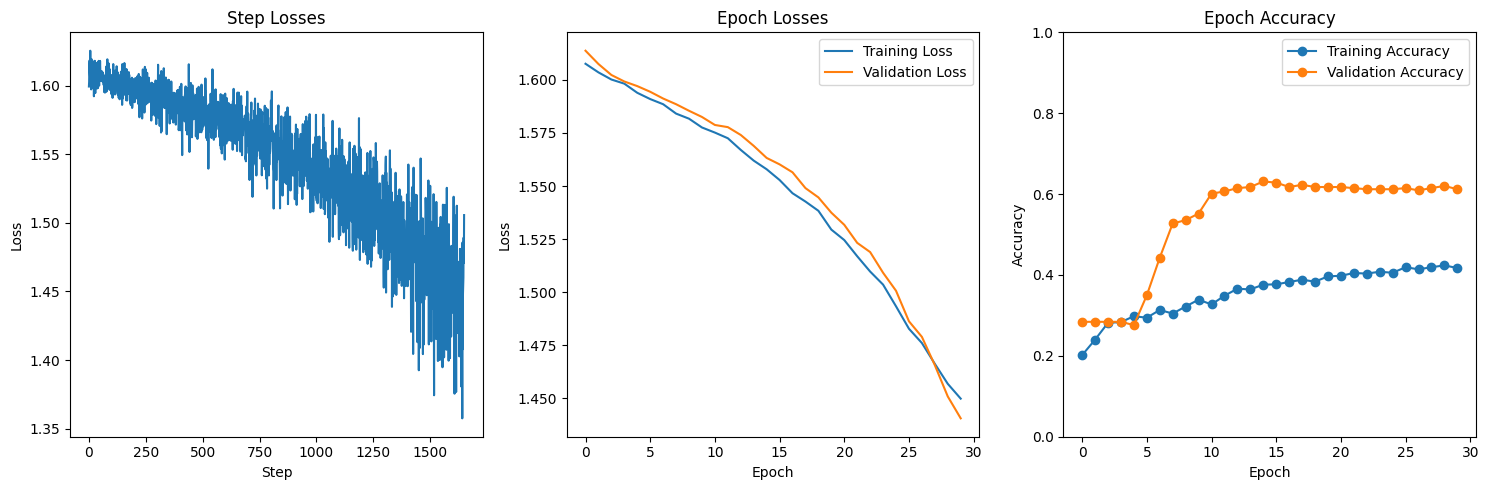

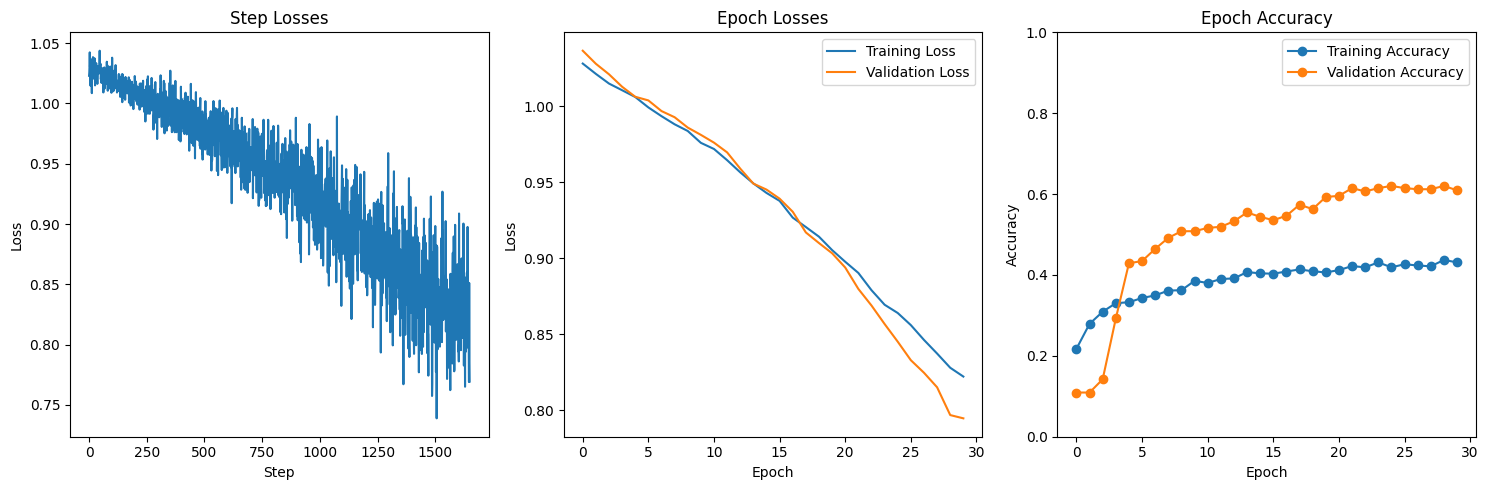

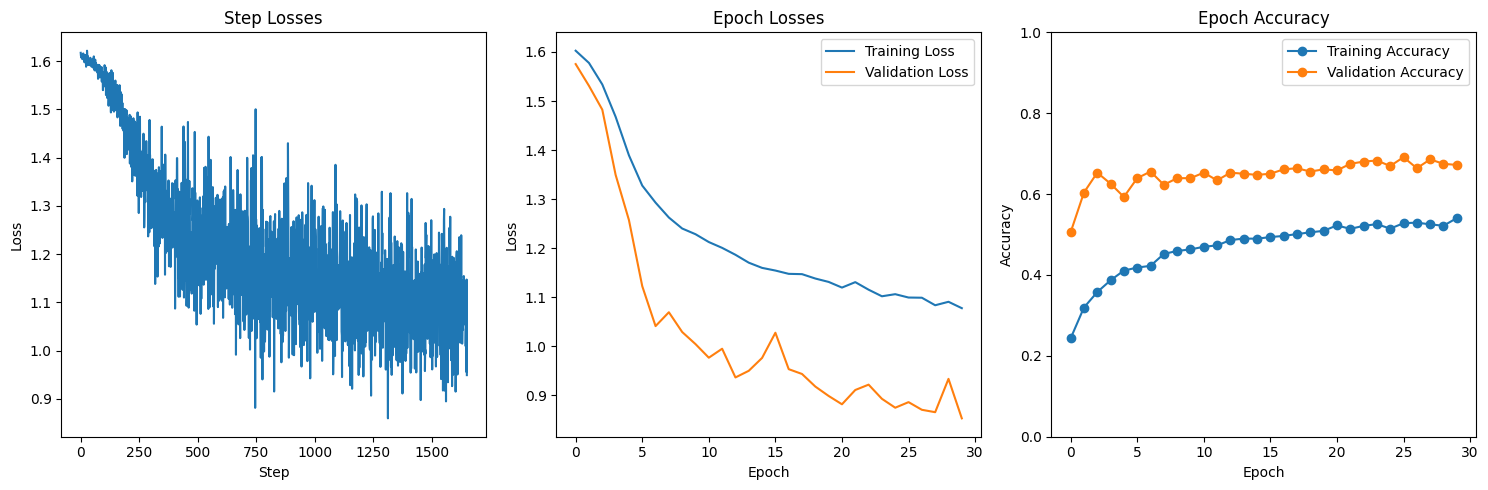

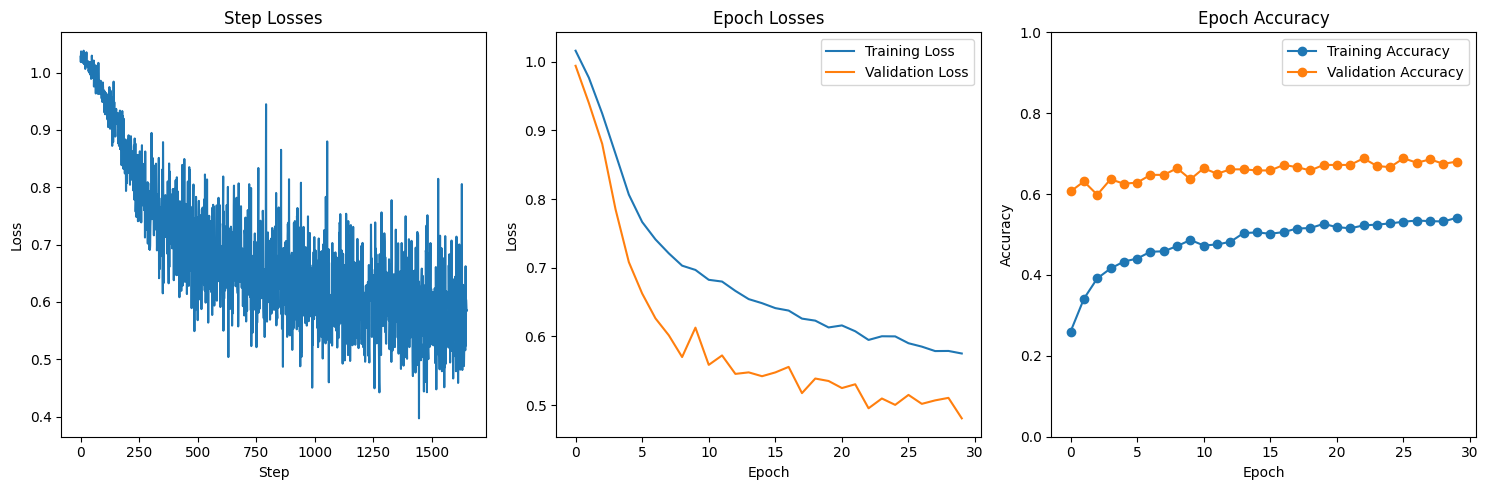

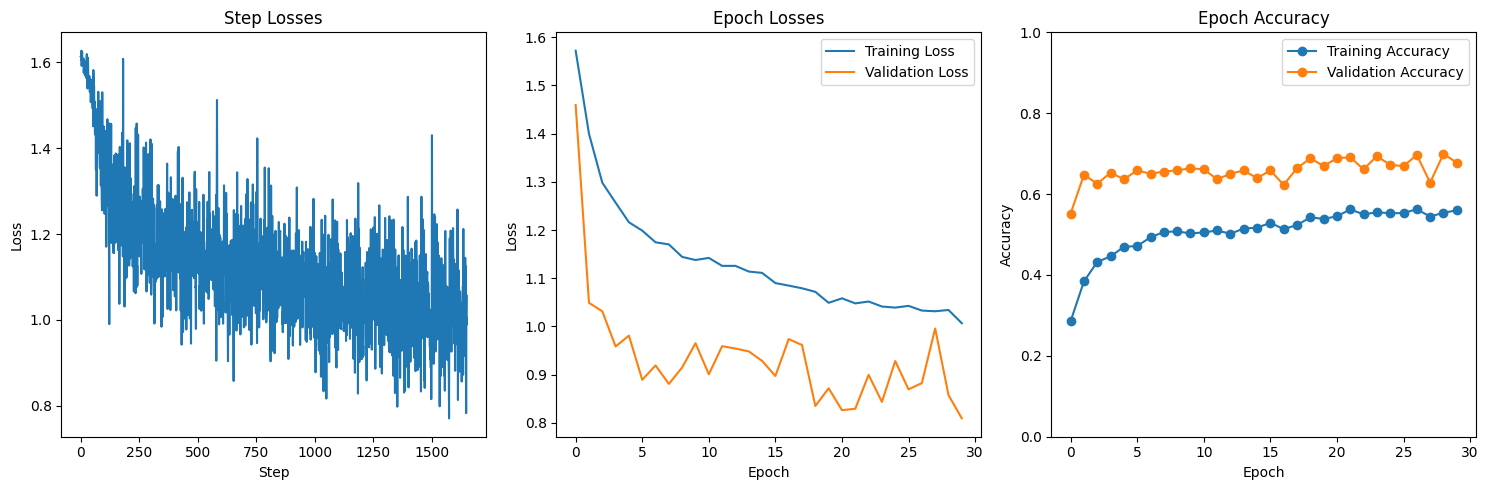

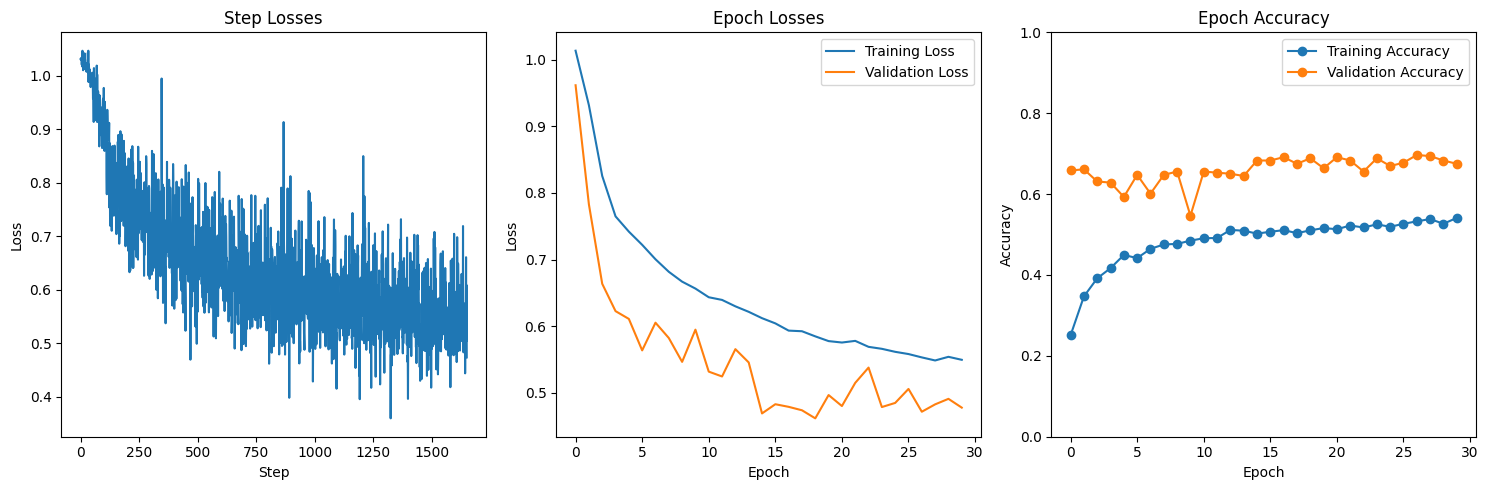

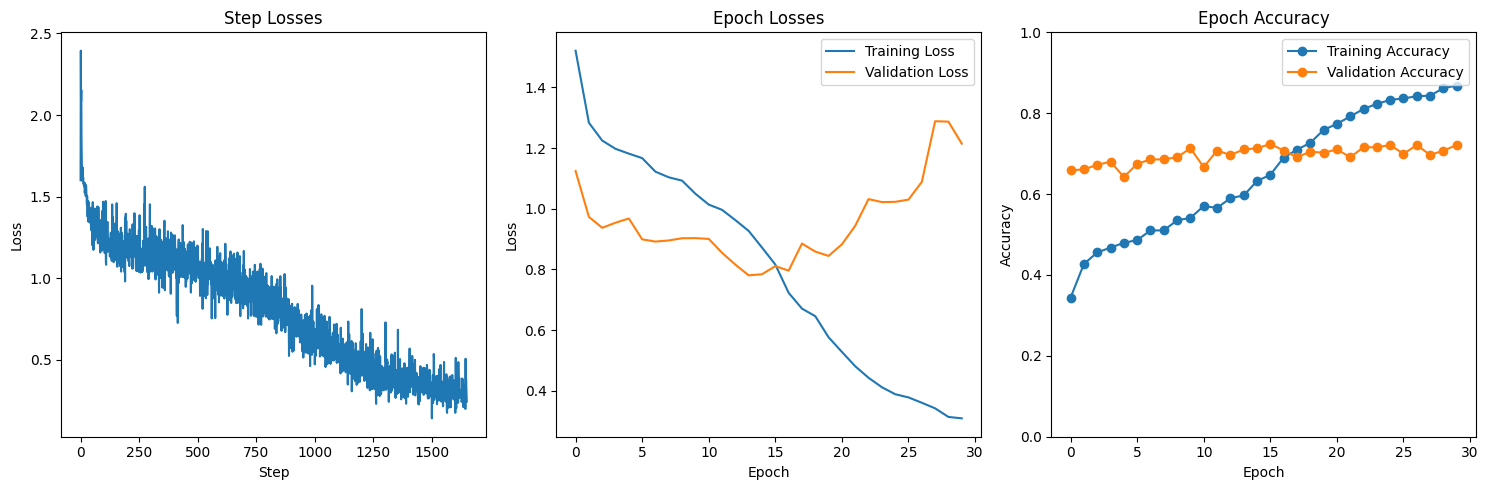

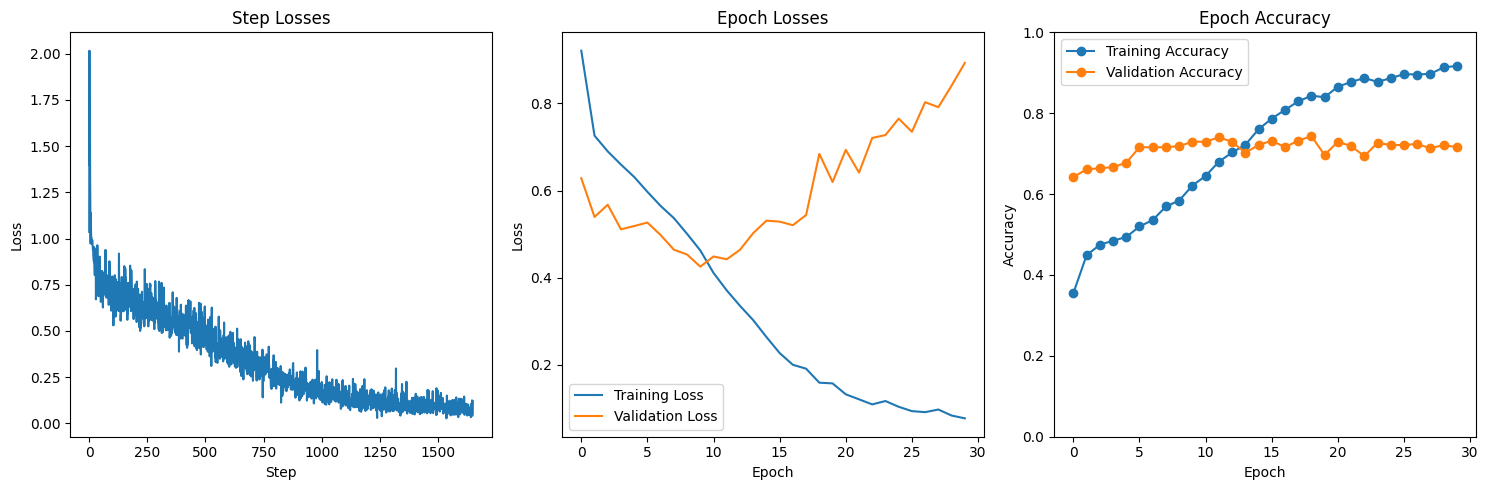

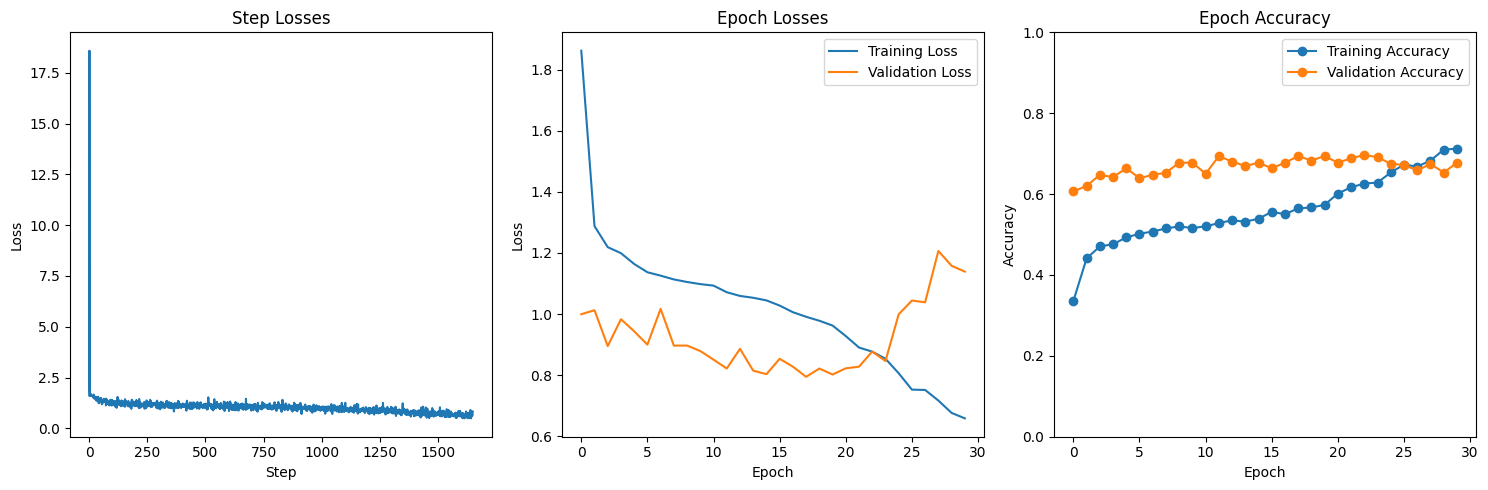

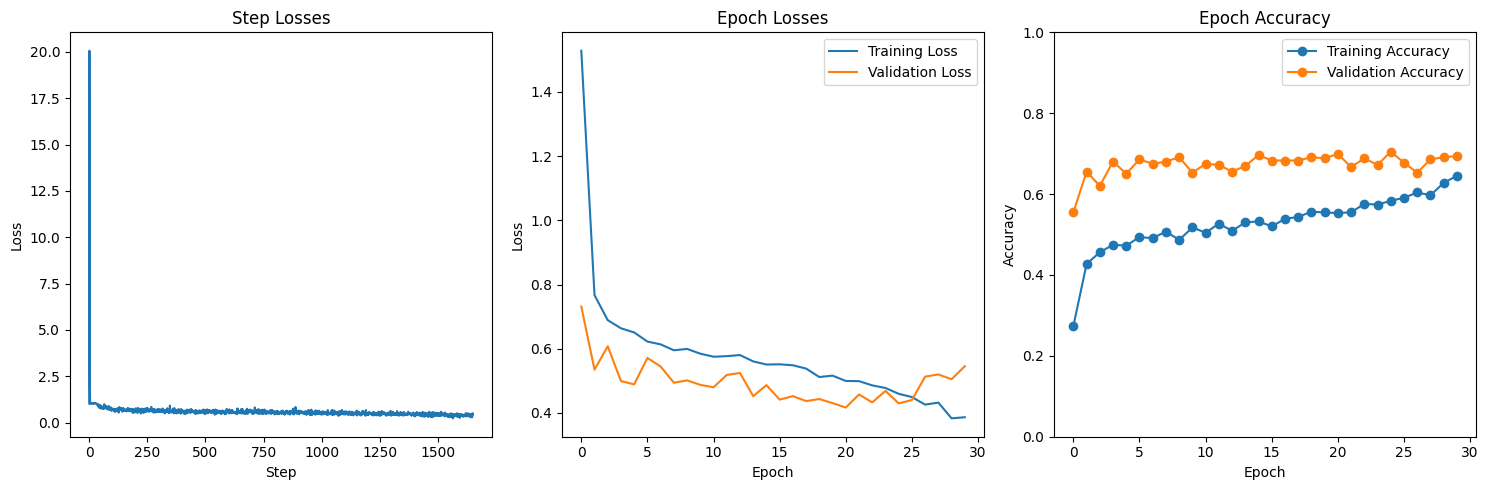

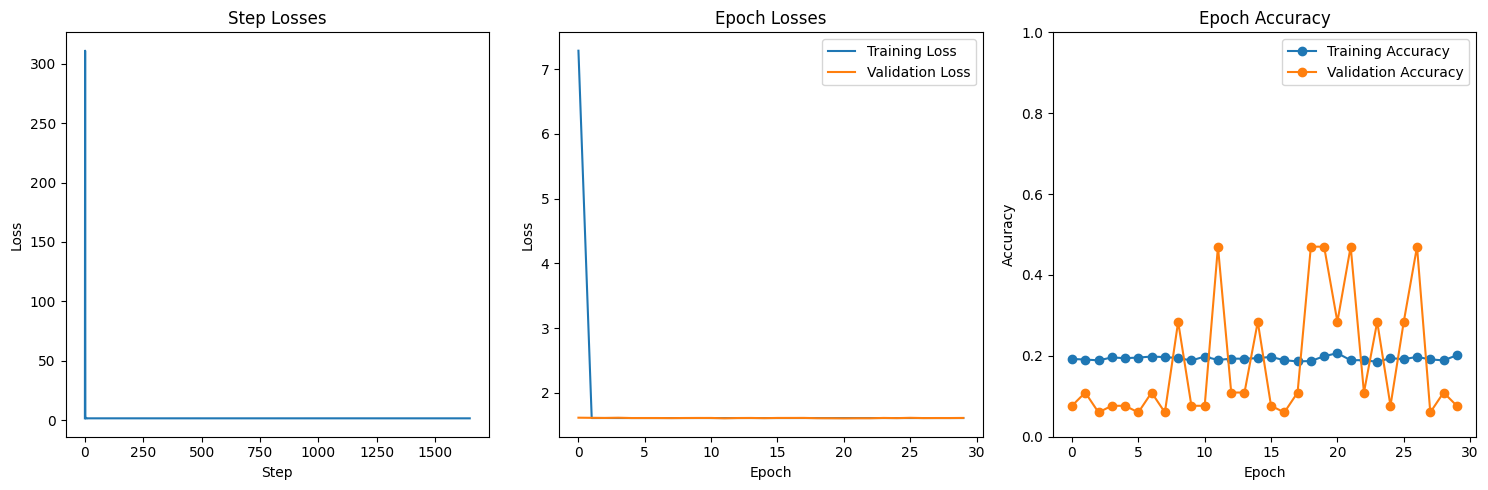

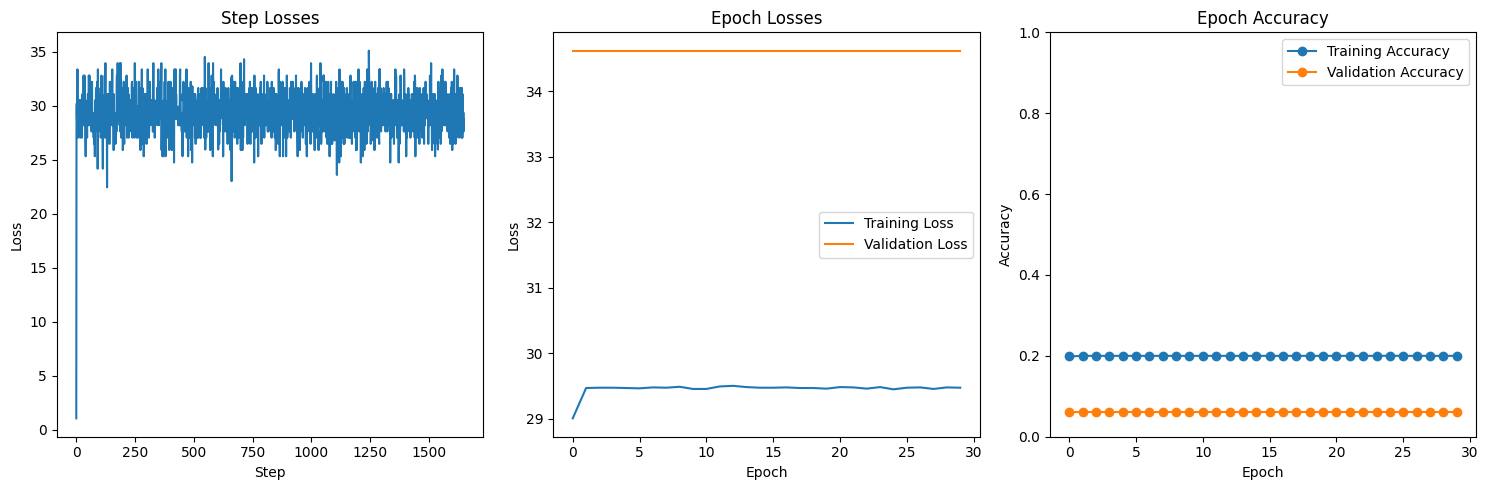

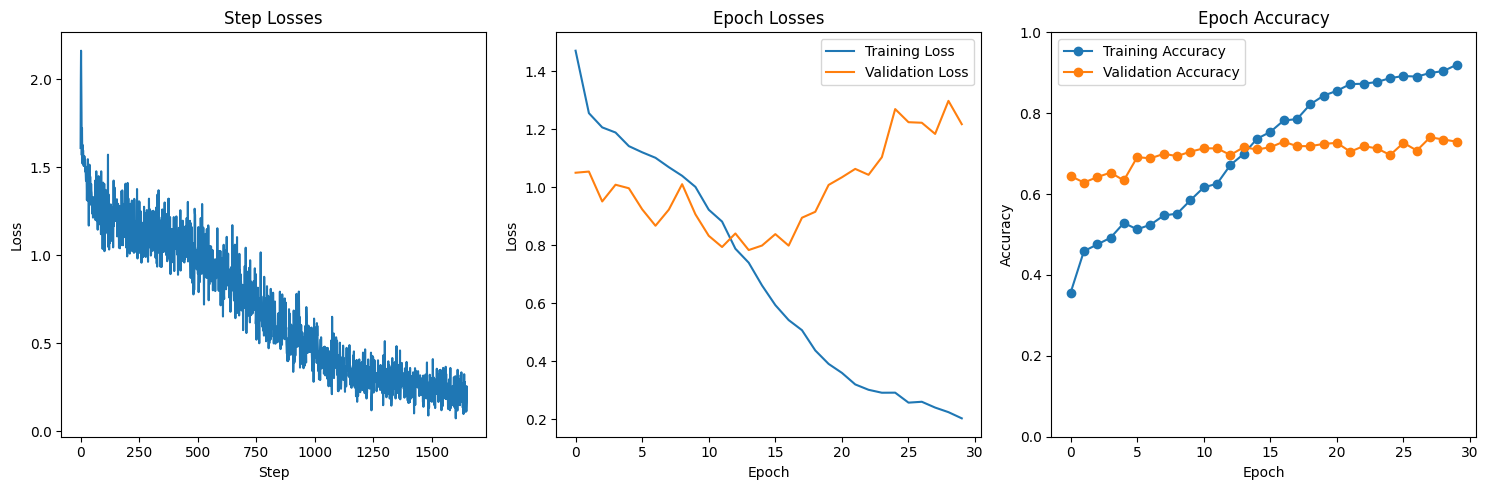

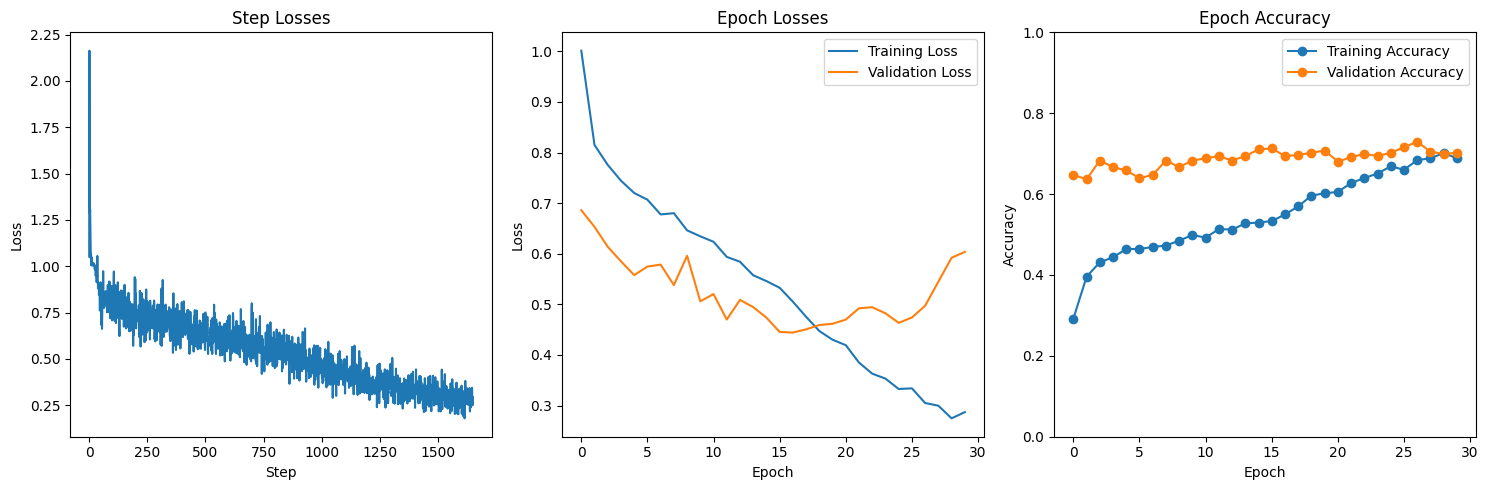

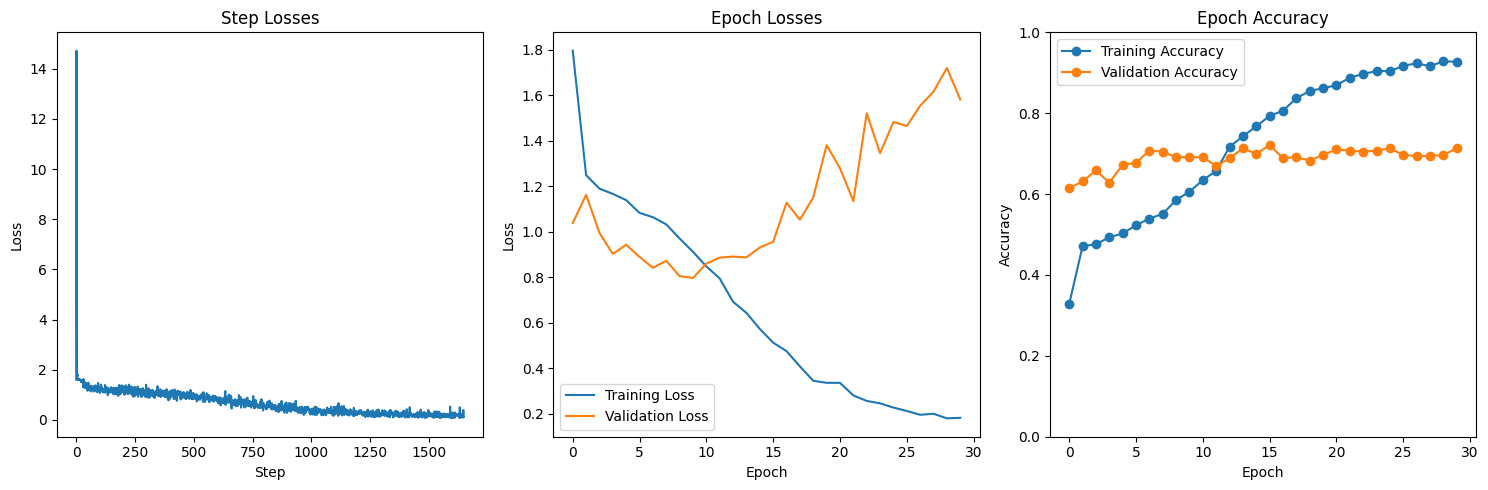

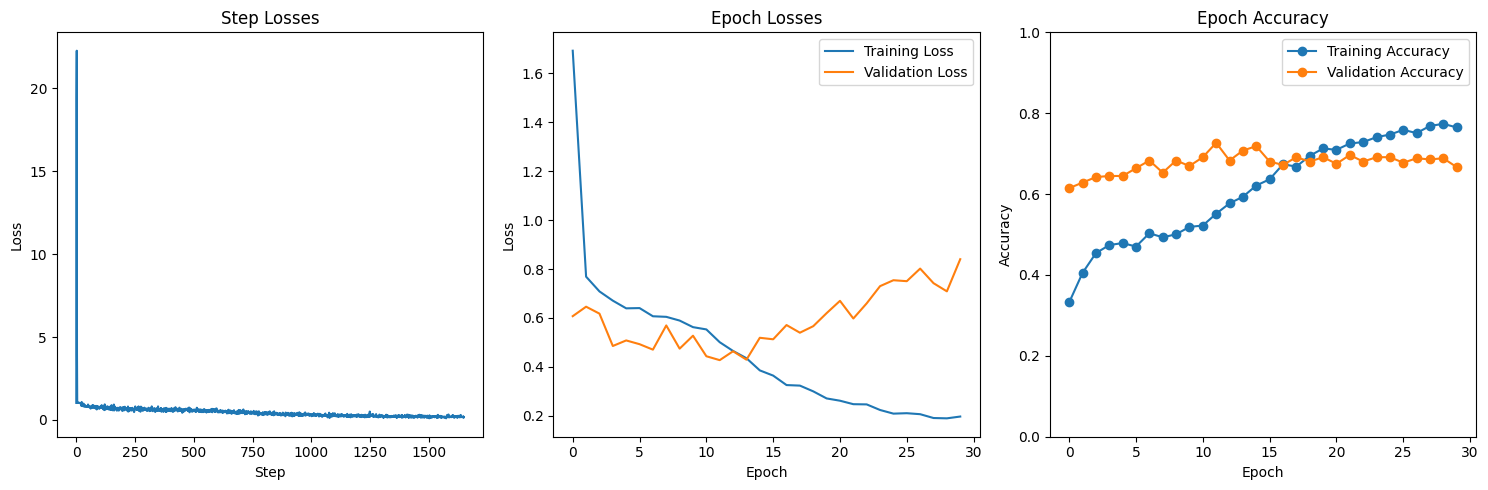

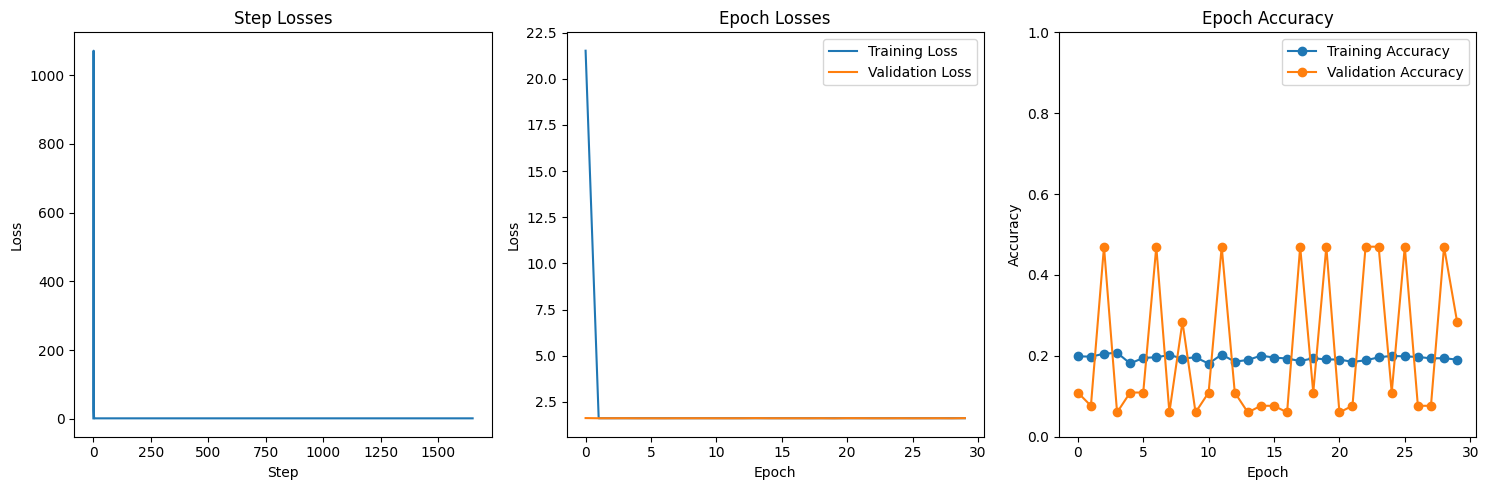

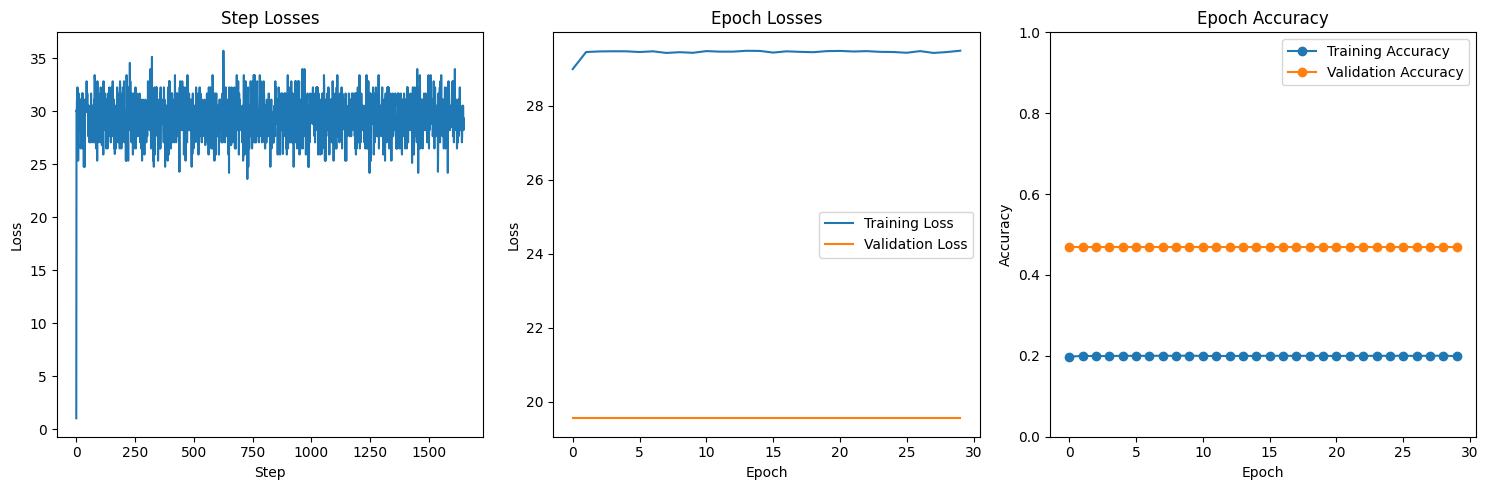

In [51]:
def model_fn():
    return Simone()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

# Simone2's Model

In [40]:
class Simone2(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),   nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,padding=1),  nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # output: (B,128,1,1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 5)
        )
    def forward(self, x):
        x = self.body(x)
        x = self.gap(x)
        x = self.head(x)
        return x

In [ ]:
model_simone2 = Simone2()
print(model_simone2)
summary(model_simone2, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_simone2 = train_model(
    model = model_simone2,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    num_epochs = 100,
    device = device
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

# Try automatic grid search

Partono 18 esperimenti...

[1/18] Simone2_run_001_optimizer_name=sgd_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6359 train acc=0.1999, validation loss: 1.6723 validation acc=0.0765
Epoch 2/30


Epoch 2 training loss: 1.6390 train acc=0.1934, validation loss: 1.6659 validation acc=0.0765
Epoch 3/30


Epoch 3 training loss: 1.6308 train acc=0.2033, validation loss: 1.6624 validation acc=0.0765
Epoch 4/30


Epoch 4 training loss: 1.6304 train acc=0.1979, validation loss: 1.6551 validation acc=0.0765
Epoch 5/30


Epoch 5 training loss: 1.6291 train acc=0.1992, validation loss: 1.6518 validation acc=0.0765
Epoch 6/30


Epoch 6 training loss: 1.6268 train acc=0.2008, validation loss: 1.6471 validation acc=0.0765
Epoch 7/30


Epoch 7 training loss: 1.6269 train acc=0.2021, validation loss: 1.6432 validation acc=0.0765
Epoch 8/30


Epoch 8 training loss: 1.6230 train acc=0.1983, validation loss: 1.6363 validation acc=0.0765
Epoch 9/30


Epoch 9 training loss: 1.6208 train acc=0.2040, validation loss: 1.6332 validation acc=0.0765
Epoch 10/30


Epoch 10 training loss: 1.6219 train acc=0.2064, validation loss: 1.6354 validation acc=0.0765
Epoch 11/30


Epoch 11 training loss: 1.6210 train acc=0.2038, validation loss: 1.6256 validation acc=0.0765
Epoch 12/30


Epoch 12 training loss: 1.6149 train acc=0.2149, validation loss: 1.6238 validation acc=0.0765
Epoch 13/30


Epoch 13 training loss: 1.6151 train acc=0.2127, validation loss: 1.6188 validation acc=0.0765
Epoch 14/30


Epoch 14 training loss: 1.6130 train acc=0.2102, validation loss: 1.6167 validation acc=0.0765
Epoch 15/30


Epoch 15 training loss: 1.6148 train acc=0.2116, validation loss: 1.6133 validation acc=0.0765
Epoch 16/30


Epoch 16 training loss: 1.6078 train acc=0.2247, validation loss: 1.6107 validation acc=0.0820
Epoch 17/30


Epoch 17 training loss: 1.6096 train acc=0.2265, validation loss: 1.6094 validation acc=0.0929
Epoch 18/30


Epoch 18 training loss: 1.6094 train acc=0.2227, validation loss: 1.6064 validation acc=0.1011
Epoch 19/30


Epoch 19 training loss: 1.6039 train acc=0.2283, validation loss: 1.6007 validation acc=0.1667
Epoch 20/30


Epoch 20 training loss: 1.6050 train acc=0.2271, validation loss: 1.5946 validation acc=0.2158
Epoch 21/30


Epoch 21 training loss: 1.6030 train acc=0.2353, validation loss: 1.5955 validation acc=0.2268
Epoch 22/30


Epoch 22 training loss: 1.5994 train acc=0.2254, validation loss: 1.5943 validation acc=0.2432
Epoch 23/30


Epoch 23 training loss: 1.6018 train acc=0.2344, validation loss: 1.5891 validation acc=0.2923
Epoch 24/30


Epoch 24 training loss: 1.6008 train acc=0.2406, validation loss: 1.5915 validation acc=0.2760
Epoch 25/30


Epoch 25 training loss: 1.5970 train acc=0.2448, validation loss: 1.5848 validation acc=0.3634
Epoch 26/30


Epoch 26 training loss: 1.5974 train acc=0.2424, validation loss: 1.5867 validation acc=0.3251
Epoch 27/30


Epoch 27 training loss: 1.5987 train acc=0.2494, validation loss: 1.5842 validation acc=0.3689
Epoch 28/30


Epoch 28 training loss: 1.5947 train acc=0.2450, validation loss: 1.5757 validation acc=0.3989
Epoch 29/30


Epoch 29 training loss: 1.5937 train acc=0.2457, validation loss: 1.5756 validation acc=0.4208
Epoch 30/30


Epoch 30 training loss: 1.5931 train acc=0.2509, validation loss: 1.5744 validation acc=0.4317
Test Accuracy: 48.91% | Precision: 0.344 | Recall: 0.336 | F1: 0.260
[2/18] Simone2_run_002_optimizer_name=sgd_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0627 train acc=0.2008, validation loss: 1.1248 validation acc=0.0601
Epoch 2/30


Epoch 2 training loss: 1.0596 train acc=0.2031, validation loss: 1.1205 validation acc=0.0601
Epoch 3/30


Epoch 3 training loss: 1.0516 train acc=0.2060, validation loss: 1.1076 validation acc=0.0601
Epoch 4/30


Epoch 4 training loss: 1.0503 train acc=0.2063, validation loss: 1.1012 validation acc=0.0601
Epoch 5/30


Epoch 5 training loss: 1.0470 train acc=0.2074, validation loss: 1.0940 validation acc=0.0601
Epoch 6/30


Epoch 6 training loss: 1.0474 train acc=0.1962, validation loss: 1.0912 validation acc=0.0601
Epoch 7/30


Epoch 7 training loss: 1.0447 train acc=0.2045, validation loss: 1.0839 validation acc=0.0601
Epoch 8/30


Epoch 8 training loss: 1.0402 train acc=0.2050, validation loss: 1.0742 validation acc=0.0601
Epoch 9/30


Epoch 9 training loss: 1.0438 train acc=0.2061, validation loss: 1.0737 validation acc=0.0601
Epoch 10/30


Epoch 10 training loss: 1.0390 train acc=0.2088, validation loss: 1.0703 validation acc=0.0601
Epoch 11/30


Epoch 11 training loss: 1.0372 train acc=0.2153, validation loss: 1.0603 validation acc=0.0601
Epoch 12/30


Epoch 12 training loss: 1.0341 train acc=0.2162, validation loss: 1.0614 validation acc=0.0574
Epoch 13/30


Epoch 13 training loss: 1.0364 train acc=0.2153, validation loss: 1.0574 validation acc=0.0574
Epoch 14/30


Epoch 14 training loss: 1.0354 train acc=0.2124, validation loss: 1.0523 validation acc=0.0574
Epoch 15/30


Epoch 15 training loss: 1.0360 train acc=0.2085, validation loss: 1.0526 validation acc=0.0574
Epoch 16/30


Epoch 16 training loss: 1.0293 train acc=0.2158, validation loss: 1.0468 validation acc=0.0628
Epoch 17/30


Epoch 17 training loss: 1.0299 train acc=0.2218, validation loss: 1.0429 validation acc=0.0683
Epoch 18/30


Epoch 18 training loss: 1.0261 train acc=0.2227, validation loss: 1.0422 validation acc=0.0738
Epoch 19/30


Epoch 19 training loss: 1.0271 train acc=0.2230, validation loss: 1.0368 validation acc=0.0874
Epoch 20/30


Epoch 20 training loss: 1.0249 train acc=0.2259, validation loss: 1.0349 validation acc=0.0984
Epoch 21/30


Epoch 21 training loss: 1.0271 train acc=0.2294, validation loss: 1.0333 validation acc=0.1148
Epoch 22/30


Epoch 22 training loss: 1.0301 train acc=0.2187, validation loss: 1.0271 validation acc=0.1803
Epoch 23/30


Epoch 23 training loss: 1.0233 train acc=0.2350, validation loss: 1.0265 validation acc=0.1913
Epoch 24/30


Epoch 24 training loss: 1.0250 train acc=0.2319, validation loss: 1.0241 validation acc=0.2486
Epoch 25/30


Epoch 25 training loss: 1.0247 train acc=0.2195, validation loss: 1.0188 validation acc=0.2732
Epoch 26/30


Epoch 26 training loss: 1.0212 train acc=0.2371, validation loss: 1.0188 validation acc=0.2787
Epoch 27/30


Epoch 27 training loss: 1.0213 train acc=0.2430, validation loss: 1.0168 validation acc=0.2896
Epoch 28/30


Epoch 28 training loss: 1.0186 train acc=0.2430, validation loss: 1.0167 validation acc=0.2814
Epoch 29/30


Epoch 29 training loss: 1.0188 train acc=0.2418, validation loss: 1.0113 validation acc=0.3497
Epoch 30/30


Epoch 30 training loss: 1.0201 train acc=0.2386, validation loss: 1.0090 validation acc=0.3497
Test Accuracy: 38.25% | Precision: 0.280 | Recall: 0.297 | F1: 0.208
[3/18] Simone2_run_003_optimizer_name=sgd_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6177 train acc=0.2001, validation loss: 1.6397 validation acc=0.0984
Epoch 2/30


Epoch 2 training loss: 1.6100 train acc=0.2098, validation loss: 1.6179 validation acc=0.1503
Epoch 3/30


Epoch 3 training loss: 1.6053 train acc=0.2172, validation loss: 1.6014 validation acc=0.3087
Epoch 4/30


Epoch 4 training loss: 1.5956 train acc=0.2441, validation loss: 1.5824 validation acc=0.4071
Epoch 5/30


Epoch 5 training loss: 1.5902 train acc=0.2558, validation loss: 1.5687 validation acc=0.3962
Epoch 6/30


Epoch 6 training loss: 1.5840 train acc=0.2722, validation loss: 1.5558 validation acc=0.4235
Epoch 7/30


Epoch 7 training loss: 1.5814 train acc=0.2805, validation loss: 1.5515 validation acc=0.4126
Epoch 8/30


Epoch 8 training loss: 1.5727 train acc=0.2940, validation loss: 1.5303 validation acc=0.4426
Epoch 9/30


Epoch 9 training loss: 1.5682 train acc=0.3031, validation loss: 1.5271 validation acc=0.4508
Epoch 10/30


Epoch 10 training loss: 1.5631 train acc=0.3061, validation loss: 1.5044 validation acc=0.4344
Epoch 11/30


Epoch 11 training loss: 1.5522 train acc=0.3218, validation loss: 1.4912 validation acc=0.4290
Epoch 12/30


Epoch 12 training loss: 1.5470 train acc=0.3151, validation loss: 1.4699 validation acc=0.4508
Epoch 13/30


Epoch 13 training loss: 1.5376 train acc=0.3335, validation loss: 1.4545 validation acc=0.4426
Epoch 14/30


Epoch 14 training loss: 1.5310 train acc=0.3308, validation loss: 1.4437 validation acc=0.4536
Epoch 15/30


Epoch 15 training loss: 1.5208 train acc=0.3378, validation loss: 1.4219 validation acc=0.4590
Epoch 16/30


Epoch 16 training loss: 1.5132 train acc=0.3328, validation loss: 1.4284 validation acc=0.4727
Epoch 17/30


Epoch 17 training loss: 1.5038 train acc=0.3400, validation loss: 1.3934 validation acc=0.4781
Epoch 18/30


Epoch 18 training loss: 1.4982 train acc=0.3445, validation loss: 1.3562 validation acc=0.4918
Epoch 19/30


Epoch 19 training loss: 1.4910 train acc=0.3424, validation loss: 1.3437 validation acc=0.5027
Epoch 20/30


Epoch 20 training loss: 1.4798 train acc=0.3455, validation loss: 1.3178 validation acc=0.5055
Epoch 21/30


Epoch 21 training loss: 1.4670 train acc=0.3508, validation loss: 1.3030 validation acc=0.5410
Epoch 22/30


Epoch 22 training loss: 1.4574 train acc=0.3554, validation loss: 1.2954 validation acc=0.5273
Epoch 23/30


Epoch 23 training loss: 1.4462 train acc=0.3548, validation loss: 1.2874 validation acc=0.5137
Epoch 24/30


Epoch 24 training loss: 1.4409 train acc=0.3577, validation loss: 1.2497 validation acc=0.5683
Epoch 25/30


Epoch 25 training loss: 1.4294 train acc=0.3709, validation loss: 1.2354 validation acc=0.5410
Epoch 26/30


Epoch 26 training loss: 1.4207 train acc=0.3707, validation loss: 1.2026 validation acc=0.5929
Epoch 27/30


Epoch 27 training loss: 1.4054 train acc=0.3784, validation loss: 1.2450 validation acc=0.5683
Epoch 28/30


Epoch 28 training loss: 1.4064 train acc=0.3784, validation loss: 1.1532 validation acc=0.6284
Epoch 29/30


Epoch 29 training loss: 1.3964 train acc=0.3837, validation loss: 1.1736 validation acc=0.6011
Epoch 30/30


Epoch 30 training loss: 1.3819 train acc=0.3862, validation loss: 1.1505 validation acc=0.5902
Test Accuracy: 67.49% | Precision: 0.456 | Recall: 0.445 | F1: 0.445
[4/18] Simone2_run_004_optimizer_name=sgd_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0568 train acc=0.2003, validation loss: 1.0504 validation acc=0.1202
Epoch 2/30


Epoch 2 training loss: 1.0405 train acc=0.2160, validation loss: 1.0145 validation acc=0.3552
Epoch 3/30


Epoch 3 training loss: 1.0255 train acc=0.2310, validation loss: 0.9968 validation acc=0.4098
Epoch 4/30


Epoch 4 training loss: 1.0167 train acc=0.2526, validation loss: 0.9817 validation acc=0.4481
Epoch 5/30


Epoch 5 training loss: 1.0080 train acc=0.2685, validation loss: 0.9645 validation acc=0.4699
Epoch 6/30


Epoch 6 training loss: 1.0068 train acc=0.2775, validation loss: 0.9529 validation acc=0.4918
Epoch 7/30


Epoch 7 training loss: 0.9992 train acc=0.2792, validation loss: 0.9425 validation acc=0.4809
Epoch 8/30


Epoch 8 training loss: 0.9909 train acc=0.2894, validation loss: 0.9403 validation acc=0.4863
Epoch 9/30


Epoch 9 training loss: 0.9835 train acc=0.3001, validation loss: 0.9250 validation acc=0.4891
Epoch 10/30


Epoch 10 training loss: 0.9764 train acc=0.3102, validation loss: 0.9096 validation acc=0.4945
Epoch 11/30


Epoch 11 training loss: 0.9665 train acc=0.3184, validation loss: 0.8969 validation acc=0.5000
Epoch 12/30


Epoch 12 training loss: 0.9685 train acc=0.3169, validation loss: 0.8894 validation acc=0.5055
Epoch 13/30


Epoch 13 training loss: 0.9583 train acc=0.3167, validation loss: 0.8767 validation acc=0.5219
Epoch 14/30


Epoch 14 training loss: 0.9529 train acc=0.3304, validation loss: 0.8648 validation acc=0.5219
Epoch 15/30


Epoch 15 training loss: 0.9444 train acc=0.3310, validation loss: 0.8452 validation acc=0.5301
Epoch 16/30


Epoch 16 training loss: 0.9335 train acc=0.3340, validation loss: 0.8308 validation acc=0.5191
Epoch 17/30


Epoch 17 training loss: 0.9310 train acc=0.3404, validation loss: 0.8240 validation acc=0.5219
Epoch 18/30


Epoch 18 training loss: 0.9194 train acc=0.3403, validation loss: 0.8005 validation acc=0.5984
Epoch 19/30


Epoch 19 training loss: 0.9171 train acc=0.3410, validation loss: 0.8051 validation acc=0.5219
Epoch 20/30


Epoch 20 training loss: 0.9047 train acc=0.3488, validation loss: 0.7590 validation acc=0.6120
Epoch 21/30


Epoch 21 training loss: 0.9015 train acc=0.3577, validation loss: 0.7795 validation acc=0.5820
Epoch 22/30


Epoch 22 training loss: 0.8923 train acc=0.3621, validation loss: 0.7697 validation acc=0.6011
Epoch 23/30


Epoch 23 training loss: 0.8856 train acc=0.3555, validation loss: 0.7190 validation acc=0.6421
Epoch 24/30


Epoch 24 training loss: 0.8761 train acc=0.3721, validation loss: 0.7105 validation acc=0.6503
Epoch 25/30


Epoch 25 training loss: 0.8719 train acc=0.3859, validation loss: 0.7005 validation acc=0.6366
Epoch 26/30


Epoch 26 training loss: 0.8630 train acc=0.3799, validation loss: 0.7043 validation acc=0.6339
Epoch 27/30


Epoch 27 training loss: 0.8562 train acc=0.3780, validation loss: 0.6825 validation acc=0.6284
Epoch 28/30


Epoch 28 training loss: 0.8516 train acc=0.3741, validation loss: 0.6735 validation acc=0.6612
Epoch 29/30


Epoch 29 training loss: 0.8419 train acc=0.3752, validation loss: 0.6454 validation acc=0.6557
Epoch 30/30


Epoch 30 training loss: 0.8404 train acc=0.3831, validation loss: 0.6390 validation acc=0.6475
Test Accuracy: 71.04% | Precision: 0.371 | Recall: 0.388 | F1: 0.367
[5/18] Simone2_run_005_optimizer_name=sgd_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.6033 train acc=0.2297, validation loss: 1.5440 validation acc=0.5219
Epoch 2/30


Epoch 2 training loss: 1.5662 train acc=0.3008, validation loss: 1.4864 validation acc=0.4754
Epoch 3/30


Epoch 3 training loss: 1.5335 train acc=0.3226, validation loss: 1.4362 validation acc=0.5219
Epoch 4/30


Epoch 4 training loss: 1.4953 train acc=0.3460, validation loss: 1.3458 validation acc=0.4536
Epoch 5/30


Epoch 5 training loss: 1.4520 train acc=0.3594, validation loss: 1.4191 validation acc=0.4727
Epoch 6/30


Epoch 6 training loss: 1.4166 train acc=0.3679, validation loss: 1.0903 validation acc=0.6011
Epoch 7/30


Epoch 7 training loss: 1.3794 train acc=0.3866, validation loss: 1.2792 validation acc=0.5301
Epoch 8/30


Epoch 8 training loss: 1.3543 train acc=0.4011, validation loss: 1.2483 validation acc=0.5273
Epoch 9/30


Epoch 9 training loss: 1.3334 train acc=0.4013, validation loss: 0.9805 validation acc=0.6475
Epoch 10/30


Epoch 10 training loss: 1.3095 train acc=0.4045, validation loss: 1.9981 validation acc=0.1721
Epoch 11/30


Epoch 11 training loss: 1.2986 train acc=0.4114, validation loss: 0.9225 validation acc=0.6448
Epoch 12/30


Epoch 12 training loss: 1.2862 train acc=0.4117, validation loss: 1.0023 validation acc=0.6339
Epoch 13/30


Epoch 13 training loss: 1.2808 train acc=0.4093, validation loss: 1.0600 validation acc=0.6120
Epoch 14/30


Epoch 14 training loss: 1.2724 train acc=0.4184, validation loss: 1.8372 validation acc=0.4836
Epoch 15/30


Epoch 15 training loss: 1.2840 train acc=0.4141, validation loss: 0.9398 validation acc=0.6339
Epoch 16/30


Epoch 16 training loss: 1.2656 train acc=0.4198, validation loss: 3.3341 validation acc=0.1967
Epoch 17/30


Epoch 17 training loss: 1.2879 train acc=0.4119, validation loss: 0.9022 validation acc=0.6366
Epoch 18/30


Epoch 18 training loss: 1.2576 train acc=0.4142, validation loss: 1.4018 validation acc=0.4699
Epoch 19/30


Epoch 19 training loss: 1.2593 train acc=0.4226, validation loss: 0.8708 validation acc=0.6557
Epoch 20/30


Epoch 20 training loss: 1.2434 train acc=0.4356, validation loss: 0.9805 validation acc=0.6093
Epoch 21/30


Epoch 21 training loss: 1.2408 train acc=0.4247, validation loss: 1.1795 validation acc=0.5082
Epoch 22/30


Epoch 22 training loss: 1.2552 train acc=0.4183, validation loss: 0.8773 validation acc=0.6503
Epoch 23/30


Epoch 23 training loss: 1.2419 train acc=0.4271, validation loss: 1.9877 validation acc=0.2678
Epoch 24/30


Epoch 24 training loss: 1.2445 train acc=0.4165, validation loss: 1.8633 validation acc=0.5000
Epoch 25/30


Epoch 25 training loss: 1.2470 train acc=0.4301, validation loss: 0.8749 validation acc=0.6366
Epoch 26/30


Epoch 26 training loss: 1.2315 train acc=0.4301, validation loss: 0.8371 validation acc=0.6749
Epoch 27/30


Epoch 27 training loss: 1.2250 train acc=0.4329, validation loss: 0.8255 validation acc=0.6612
Epoch 28/30


Epoch 28 training loss: 1.2342 train acc=0.4272, validation loss: 3.1326 validation acc=0.2158
Epoch 29/30


Epoch 29 training loss: 1.2811 train acc=0.4205, validation loss: 0.8525 validation acc=0.6503
Epoch 30/30


Epoch 30 training loss: 1.2439 train acc=0.4248, validation loss: 0.9338 validation acc=0.6284
Test Accuracy: 71.31% | Precision: 0.435 | Recall: 0.420 | F1: 0.395
[6/18] Simone2_run_006_optimizer_name=sgd_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 1.0239 train acc=0.2361, validation loss: 0.9724 validation acc=0.4672
Epoch 2/30


Epoch 2 training loss: 0.9878 train acc=0.2990, validation loss: 0.9274 validation acc=0.4481
Epoch 3/30


Epoch 3 training loss: 0.9518 train acc=0.3324, validation loss: 0.8197 validation acc=0.5492
Epoch 4/30


Epoch 4 training loss: 0.9104 train acc=0.3596, validation loss: 0.7527 validation acc=0.5546
Epoch 5/30


Epoch 5 training loss: 0.8748 train acc=0.3722, validation loss: 0.7457 validation acc=0.5355
Epoch 6/30


Epoch 6 training loss: 0.8376 train acc=0.3816, validation loss: 0.7065 validation acc=0.4918
Epoch 7/30


Epoch 7 training loss: 0.8225 train acc=0.3844, validation loss: 0.8484 validation acc=0.3962
Epoch 8/30


Epoch 8 training loss: 0.7993 train acc=0.3994, validation loss: 1.3828 validation acc=0.1940
Epoch 9/30


Epoch 9 training loss: 0.7847 train acc=0.4028, validation loss: 0.6034 validation acc=0.6475
Epoch 10/30


Epoch 10 training loss: 0.7819 train acc=0.4003, validation loss: 1.5740 validation acc=0.2377
Epoch 11/30


Epoch 11 training loss: 0.7655 train acc=0.4047, validation loss: 0.7374 validation acc=0.5328
Epoch 12/30


Epoch 12 training loss: 0.7651 train acc=0.4120, validation loss: 1.9766 validation acc=0.1230
Epoch 13/30


Epoch 13 training loss: 0.7462 train acc=0.4205, validation loss: 0.6122 validation acc=0.6093
Epoch 14/30


Epoch 14 training loss: 0.7430 train acc=0.4116, validation loss: 0.5314 validation acc=0.6093
Epoch 15/30


Epoch 15 training loss: 0.7359 train acc=0.4236, validation loss: 0.5658 validation acc=0.6311
Epoch 16/30


Epoch 16 training loss: 0.7333 train acc=0.4197, validation loss: 0.6367 validation acc=0.5683
Epoch 17/30


Epoch 17 training loss: 0.7263 train acc=0.4279, validation loss: 5.1460 validation acc=0.0902
Epoch 18/30


Epoch 18 training loss: 0.7357 train acc=0.4222, validation loss: 0.4802 validation acc=0.6393
Epoch 19/30


Epoch 19 training loss: 0.7213 train acc=0.4344, validation loss: 0.7215 validation acc=0.5383
Epoch 20/30


Epoch 20 training loss: 0.7171 train acc=0.4266, validation loss: 1.2631 validation acc=0.4836
Epoch 21/30


Epoch 21 training loss: 0.7248 train acc=0.4280, validation loss: 0.4795 validation acc=0.6530
Epoch 22/30


Epoch 22 training loss: 0.7218 train acc=0.4170, validation loss: 0.7482 validation acc=0.5574
Epoch 23/30


Epoch 23 training loss: 0.7271 train acc=0.4229, validation loss: 0.4750 validation acc=0.6393
Epoch 24/30


Epoch 24 training loss: 0.7124 train acc=0.4342, validation loss: 0.5361 validation acc=0.6339
Epoch 25/30


Epoch 25 training loss: 0.7048 train acc=0.4371, validation loss: 0.8099 validation acc=0.5246
Epoch 26/30


Epoch 26 training loss: 0.7112 train acc=0.4319, validation loss: 3.0855 validation acc=0.4699
Epoch 27/30


Epoch 27 training loss: 0.7532 train acc=0.4201, validation loss: 0.5419 validation acc=0.6148
Epoch 28/30


Epoch 28 training loss: 0.7296 train acc=0.4254, validation loss: 0.4672 validation acc=0.6503
Epoch 29/30


Epoch 29 training loss: 0.7055 train acc=0.4399, validation loss: 0.5065 validation acc=0.6366
Epoch 30/30


Epoch 30 training loss: 0.7071 train acc=0.4315, validation loss: 0.4745 validation acc=0.6448
Test Accuracy: 71.31% | Precision: 0.404 | Recall: 0.376 | F1: 0.352
[7/18] Simone2_run_007_optimizer_name=adam_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5516 train acc=0.3093, validation loss: 1.3074 validation acc=0.5847
Epoch 2/30


Epoch 2 training loss: 1.4342 train acc=0.3709, validation loss: 1.0753 validation acc=0.6202
Epoch 3/30


Epoch 3 training loss: 1.3363 train acc=0.4036, validation loss: 1.0078 validation acc=0.6093
Epoch 4/30


Epoch 4 training loss: 1.2866 train acc=0.4205, validation loss: 0.9275 validation acc=0.6257
Epoch 5/30


Epoch 5 training loss: 1.2548 train acc=0.4192, validation loss: 0.8557 validation acc=0.6448
Epoch 6/30


Epoch 6 training loss: 1.2515 train acc=0.4226, validation loss: 0.9159 validation acc=0.6448
Epoch 7/30


Epoch 7 training loss: 1.2379 train acc=0.4291, validation loss: 0.8461 validation acc=0.6612
Epoch 8/30


Epoch 8 training loss: 1.2299 train acc=0.4379, validation loss: 0.8328 validation acc=0.6667
Epoch 9/30


Epoch 9 training loss: 1.2161 train acc=0.4360, validation loss: 1.1111 validation acc=0.5792
Epoch 10/30


Epoch 10 training loss: 1.2132 train acc=0.4455, validation loss: 0.9229 validation acc=0.6339
Epoch 11/30


Epoch 11 training loss: 1.2090 train acc=0.4505, validation loss: 0.8200 validation acc=0.6448
Epoch 12/30


Epoch 12 training loss: 1.1898 train acc=0.4594, validation loss: 0.8700 validation acc=0.6448
Epoch 13/30


Epoch 13 training loss: 1.1970 train acc=0.4529, validation loss: 0.8348 validation acc=0.6858
Epoch 14/30


Epoch 14 training loss: 1.1931 train acc=0.4580, validation loss: 0.8049 validation acc=0.6749
Epoch 15/30


Epoch 15 training loss: 1.1833 train acc=0.4611, validation loss: 0.8012 validation acc=0.6585
Epoch 16/30


Epoch 16 training loss: 1.2178 train acc=0.4544, validation loss: 0.9934 validation acc=0.6011
Epoch 17/30


Epoch 17 training loss: 1.2015 train acc=0.4572, validation loss: 0.9471 validation acc=0.6257
Epoch 18/30


Epoch 18 training loss: 1.1766 train acc=0.4669, validation loss: 0.7800 validation acc=0.6776
Epoch 19/30


Epoch 19 training loss: 1.1827 train acc=0.4808, validation loss: 0.8785 validation acc=0.6421
Epoch 20/30


Epoch 20 training loss: 1.1640 train acc=0.4752, validation loss: 0.7654 validation acc=0.6749
Epoch 21/30


Epoch 21 training loss: 1.1553 train acc=0.4851, validation loss: 0.7750 validation acc=0.6967
Epoch 22/30


Epoch 22 training loss: 1.1576 train acc=0.4820, validation loss: 0.7810 validation acc=0.6831
Epoch 23/30


Epoch 23 training loss: 1.1447 train acc=0.4796, validation loss: 0.7990 validation acc=0.6612
Epoch 24/30


Epoch 24 training loss: 1.1406 train acc=0.4854, validation loss: 0.7825 validation acc=0.6694
Epoch 25/30


Epoch 25 training loss: 1.1556 train acc=0.4801, validation loss: 0.7696 validation acc=0.6831
Epoch 26/30


Epoch 26 training loss: 1.1438 train acc=0.4821, validation loss: 0.7534 validation acc=0.7049
Epoch 27/30


Epoch 27 training loss: 1.1434 train acc=0.4890, validation loss: 0.8011 validation acc=0.6557
Epoch 28/30


Epoch 28 training loss: 1.1283 train acc=0.4946, validation loss: 0.7704 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 1.1314 train acc=0.4900, validation loss: 0.7624 validation acc=0.6858
Epoch 30/30


Epoch 30 training loss: 1.1181 train acc=0.5070, validation loss: 0.7524 validation acc=0.6913
Test Accuracy: 71.31% | Precision: 0.481 | Recall: 0.442 | F1: 0.420
[8/18] Simone2_run_008_optimizer_name=adam_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.9796 train acc=0.2979, validation loss: 0.7865 validation acc=0.5792
Epoch 2/30


Epoch 2 training loss: 0.8675 train acc=0.3876, validation loss: 0.6594 validation acc=0.6257
Epoch 3/30


Epoch 3 training loss: 0.7983 train acc=0.4010, validation loss: 0.5611 validation acc=0.6366
Epoch 4/30


Epoch 4 training loss: 0.7667 train acc=0.4184, validation loss: 0.4919 validation acc=0.6639
Epoch 5/30


Epoch 5 training loss: 0.7392 train acc=0.4233, validation loss: 0.5503 validation acc=0.6284
Epoch 6/30


Epoch 6 training loss: 0.7294 train acc=0.4300, validation loss: 0.4867 validation acc=0.6585
Epoch 7/30


Epoch 7 training loss: 0.7191 train acc=0.4384, validation loss: 0.4741 validation acc=0.6639
Epoch 8/30


Epoch 8 training loss: 0.7103 train acc=0.4404, validation loss: 0.5764 validation acc=0.6202
Epoch 9/30


Epoch 9 training loss: 0.7063 train acc=0.4439, validation loss: 0.5045 validation acc=0.6503
Epoch 10/30


Epoch 10 training loss: 0.6999 train acc=0.4427, validation loss: 0.4609 validation acc=0.6721
Epoch 11/30


Epoch 11 training loss: 0.6910 train acc=0.4572, validation loss: 0.4491 validation acc=0.6858
Epoch 12/30


Epoch 12 training loss: 0.6862 train acc=0.4481, validation loss: 0.5211 validation acc=0.6475
Epoch 13/30


Epoch 13 training loss: 0.6827 train acc=0.4552, validation loss: 0.4677 validation acc=0.6776
Epoch 14/30


Epoch 14 training loss: 0.6846 train acc=0.4582, validation loss: 0.4371 validation acc=0.6995
Epoch 15/30


Epoch 15 training loss: 0.6746 train acc=0.4615, validation loss: 0.6095 validation acc=0.5847
Epoch 16/30


Epoch 16 training loss: 0.6721 train acc=0.4616, validation loss: 0.4623 validation acc=0.6803
Epoch 17/30


Epoch 17 training loss: 0.6736 train acc=0.4580, validation loss: 0.4488 validation acc=0.6776
Epoch 18/30


Epoch 18 training loss: 0.6604 train acc=0.4608, validation loss: 0.5005 validation acc=0.6585
Epoch 19/30


Epoch 19 training loss: 0.6621 train acc=0.4760, validation loss: 0.4255 validation acc=0.6803
Epoch 20/30


Epoch 20 training loss: 0.6523 train acc=0.4738, validation loss: 0.4713 validation acc=0.6530
Epoch 21/30


Epoch 21 training loss: 0.6460 train acc=0.4803, validation loss: 0.4240 validation acc=0.6885
Epoch 22/30


Epoch 22 training loss: 0.6356 train acc=0.4847, validation loss: 0.4728 validation acc=0.6612
Epoch 23/30


Epoch 23 training loss: 0.6410 train acc=0.4847, validation loss: 0.4176 validation acc=0.6858
Epoch 24/30


Epoch 24 training loss: 0.6358 train acc=0.4784, validation loss: 0.4158 validation acc=0.6858
Epoch 25/30


Epoch 25 training loss: 0.6291 train acc=0.4886, validation loss: 0.4734 validation acc=0.6667
Epoch 26/30


Epoch 26 training loss: 0.6241 train acc=0.4943, validation loss: 0.4218 validation acc=0.6776
Epoch 27/30


Epoch 27 training loss: 0.6273 train acc=0.4936, validation loss: 0.4173 validation acc=0.6694
Epoch 28/30


Epoch 28 training loss: 0.6238 train acc=0.4905, validation loss: 0.3837 validation acc=0.7077
Epoch 29/30


Epoch 29 training loss: 0.6192 train acc=0.4980, validation loss: 0.3920 validation acc=0.6885
Epoch 30/30


Epoch 30 training loss: 0.6209 train acc=0.4979, validation loss: 0.3935 validation acc=0.6885
Test Accuracy: 71.86% | Precision: 0.473 | Recall: 0.411 | F1: 0.383
[9/18] Simone2_run_009_optimizer_name=adam_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.4027 train acc=0.3718, validation loss: 1.2191 validation acc=0.5219
Epoch 2/30


Epoch 2 training loss: 1.2911 train acc=0.4117, validation loss: 0.8818 validation acc=0.6230
Epoch 3/30


Epoch 3 training loss: 1.2402 train acc=0.4349, validation loss: 0.9377 validation acc=0.6066
Epoch 4/30


Epoch 4 training loss: 1.2471 train acc=0.4238, validation loss: 0.8264 validation acc=0.6557
Epoch 5/30


Epoch 5 training loss: 1.2268 train acc=0.4382, validation loss: 0.8523 validation acc=0.6585
Epoch 6/30


Epoch 6 training loss: 1.2214 train acc=0.4403, validation loss: 1.3809 validation acc=0.3989
Epoch 7/30


Epoch 7 training loss: 1.1893 train acc=0.4558, validation loss: 0.7968 validation acc=0.6858
Epoch 8/30


Epoch 8 training loss: 1.1620 train acc=0.4695, validation loss: 0.9650 validation acc=0.5874
Epoch 9/30


Epoch 9 training loss: 1.1501 train acc=0.4762, validation loss: 0.9380 validation acc=0.6257
Epoch 10/30


Epoch 10 training loss: 1.1301 train acc=0.4911, validation loss: 0.7315 validation acc=0.7022
Epoch 11/30


Epoch 11 training loss: 1.1085 train acc=0.5004, validation loss: 0.7449 validation acc=0.6858
Epoch 12/30


Epoch 12 training loss: 1.0991 train acc=0.5067, validation loss: 0.7271 validation acc=0.6913
Epoch 13/30


Epoch 13 training loss: 1.0928 train acc=0.5199, validation loss: 0.7562 validation acc=0.6831
Epoch 14/30


Epoch 14 training loss: 1.0786 train acc=0.5243, validation loss: 0.9866 validation acc=0.5929
Epoch 15/30


Epoch 15 training loss: 1.0548 train acc=0.5255, validation loss: 0.7551 validation acc=0.6858
Epoch 16/30


Epoch 16 training loss: 1.0422 train acc=0.5375, validation loss: 0.6572 validation acc=0.7514
Epoch 17/30


Epoch 17 training loss: 1.0392 train acc=0.5371, validation loss: 0.8933 validation acc=0.6148
Epoch 18/30


Epoch 18 training loss: 1.0419 train acc=0.5450, validation loss: 1.2430 validation acc=0.4781
Epoch 19/30


Epoch 19 training loss: 1.0453 train acc=0.5393, validation loss: 0.7389 validation acc=0.6913
Epoch 20/30


Epoch 20 training loss: 1.0132 train acc=0.5494, validation loss: 0.6429 validation acc=0.7377
Epoch 21/30


Epoch 21 training loss: 0.9859 train acc=0.5576, validation loss: 0.5994 validation acc=0.7678
Epoch 22/30


Epoch 22 training loss: 0.9942 train acc=0.5554, validation loss: 0.6779 validation acc=0.7404
Epoch 23/30


Epoch 23 training loss: 0.9725 train acc=0.5739, validation loss: 0.6823 validation acc=0.6967
Epoch 24/30


Epoch 24 training loss: 0.9692 train acc=0.5664, validation loss: 0.6346 validation acc=0.7486
Epoch 25/30


Epoch 25 training loss: 0.9780 train acc=0.5660, validation loss: 1.4943 validation acc=0.4044
Epoch 26/30


Epoch 26 training loss: 0.9829 train acc=0.5686, validation loss: 0.6217 validation acc=0.7486
Epoch 27/30


Epoch 27 training loss: 0.9669 train acc=0.5696, validation loss: 0.7683 validation acc=0.6503
Epoch 28/30


Epoch 28 training loss: 0.9671 train acc=0.5724, validation loss: 0.5733 validation acc=0.7842
Epoch 29/30


Epoch 29 training loss: 0.9557 train acc=0.5729, validation loss: 0.6666 validation acc=0.7158
Epoch 30/30


Epoch 30 training loss: 0.9411 train acc=0.5817, validation loss: 1.1003 validation acc=0.5109
Test Accuracy: 49.18% | Precision: 0.418 | Recall: 0.422 | F1: 0.384
[10/18] Simone2_run_010_optimizer_name=adam_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.8348 train acc=0.3702, validation loss: 0.6571 validation acc=0.5628
Epoch 2/30


Epoch 2 training loss: 0.7473 train acc=0.4148, validation loss: 0.6262 validation acc=0.5328
Epoch 3/30


Epoch 3 training loss: 0.7310 train acc=0.4294, validation loss: 0.5348 validation acc=0.5929
Epoch 4/30


Epoch 4 training loss: 0.7143 train acc=0.4261, validation loss: 0.4982 validation acc=0.6475
Epoch 5/30


Epoch 5 training loss: 0.7118 train acc=0.4289, validation loss: 0.5553 validation acc=0.5656
Epoch 6/30


Epoch 6 training loss: 0.6960 train acc=0.4365, validation loss: 0.5331 validation acc=0.6038
Epoch 7/30


Epoch 7 training loss: 0.6972 train acc=0.4407, validation loss: 0.5058 validation acc=0.6284
Epoch 8/30


Epoch 8 training loss: 0.7070 train acc=0.4406, validation loss: 0.6427 validation acc=0.5464
Epoch 9/30


Epoch 9 training loss: 0.6866 train acc=0.4425, validation loss: 0.4955 validation acc=0.6694
Epoch 10/30


Epoch 10 training loss: 0.7200 train acc=0.4445, validation loss: 1.9401 validation acc=0.1667
Epoch 11/30


Epoch 11 training loss: 0.7077 train acc=0.4406, validation loss: 0.4648 validation acc=0.6448
Epoch 12/30


Epoch 12 training loss: 0.6841 train acc=0.4453, validation loss: 0.4726 validation acc=0.6503
Epoch 13/30


Epoch 13 training loss: 0.6709 train acc=0.4552, validation loss: 0.4506 validation acc=0.6612
Epoch 14/30


Epoch 14 training loss: 0.6966 train acc=0.4586, validation loss: 0.4722 validation acc=0.6366
Epoch 15/30


Epoch 15 training loss: 0.6925 train acc=0.4434, validation loss: 0.4822 validation acc=0.6311
Epoch 16/30


Epoch 16 training loss: 0.7072 train acc=0.4597, validation loss: 0.8023 validation acc=0.4617
Epoch 17/30


Epoch 17 training loss: 0.6943 train acc=0.4437, validation loss: 0.6258 validation acc=0.5410
Epoch 18/30


Epoch 18 training loss: 0.6648 train acc=0.4731, validation loss: 0.4376 validation acc=0.6612
Epoch 19/30


Epoch 19 training loss: 0.6626 train acc=0.4629, validation loss: 0.4599 validation acc=0.6475
Epoch 20/30


Epoch 20 training loss: 0.6583 train acc=0.4728, validation loss: 0.4162 validation acc=0.6612
Epoch 21/30


Epoch 21 training loss: 0.6758 train acc=0.4831, validation loss: 0.5058 validation acc=0.6066
Epoch 22/30


Epoch 22 training loss: 0.6571 train acc=0.4707, validation loss: 0.4507 validation acc=0.6585
Epoch 23/30


Epoch 23 training loss: 0.6147 train acc=0.4881, validation loss: 0.4038 validation acc=0.6885
Epoch 24/30


Epoch 24 training loss: 0.6192 train acc=0.4934, validation loss: 0.3902 validation acc=0.6721
Epoch 25/30


Epoch 25 training loss: 0.6152 train acc=0.4954, validation loss: 0.3764 validation acc=0.7131
Epoch 26/30


Epoch 26 training loss: 0.6039 train acc=0.4953, validation loss: 0.4122 validation acc=0.6967
Epoch 27/30


Epoch 27 training loss: 0.5969 train acc=0.5057, validation loss: 0.5085 validation acc=0.6230
Epoch 28/30


Epoch 28 training loss: 0.5860 train acc=0.5159, validation loss: 0.3652 validation acc=0.7104
Epoch 29/30


Epoch 29 training loss: 0.5799 train acc=0.5204, validation loss: 0.3839 validation acc=0.7022
Epoch 30/30


Epoch 30 training loss: 0.5825 train acc=0.5236, validation loss: 0.3827 validation acc=0.6639
Test Accuracy: 72.68% | Precision: 0.483 | Recall: 0.484 | F1: 0.480
[11/18] Simone2_run_011_optimizer_name=adam_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3760 train acc=0.3674, validation loss: 0.9454 validation acc=0.6339
Epoch 2/30


Epoch 2 training loss: 1.2891 train acc=0.4017, validation loss: 0.9441 validation acc=0.5519
Epoch 3/30


Epoch 3 training loss: 1.2841 train acc=0.4022, validation loss: 1.0252 validation acc=0.5437
Epoch 4/30


Epoch 4 training loss: 1.2799 train acc=0.4035, validation loss: 0.9147 validation acc=0.6175
Epoch 5/30


Epoch 5 training loss: 1.2441 train acc=0.4177, validation loss: 0.8524 validation acc=0.6393
Epoch 6/30


Epoch 6 training loss: 1.2415 train acc=0.4159, validation loss: 0.9514 validation acc=0.6066
Epoch 7/30


Epoch 7 training loss: 1.2465 train acc=0.4116, validation loss: 0.9346 validation acc=0.6257
Epoch 8/30


Epoch 8 training loss: 1.2405 train acc=0.4204, validation loss: 0.8426 validation acc=0.6940
Epoch 9/30


Epoch 9 training loss: 1.2580 train acc=0.4201, validation loss: 0.9709 validation acc=0.6011
Epoch 10/30


Epoch 10 training loss: 1.2520 train acc=0.4156, validation loss: 0.9217 validation acc=0.6557
Epoch 11/30


Epoch 11 training loss: 1.2330 train acc=0.4187, validation loss: 0.8784 validation acc=0.6257
Epoch 12/30


Epoch 12 training loss: 1.2307 train acc=0.4234, validation loss: 1.2353 validation acc=0.4781
Epoch 13/30


Epoch 13 training loss: 1.2317 train acc=0.4283, validation loss: 0.9690 validation acc=0.6421
Epoch 14/30


Epoch 14 training loss: 1.2301 train acc=0.4312, validation loss: 0.8805 validation acc=0.7158
Epoch 15/30


Epoch 15 training loss: 1.2170 train acc=0.4367, validation loss: 0.8588 validation acc=0.6776
Epoch 16/30


Epoch 16 training loss: 1.2178 train acc=0.4314, validation loss: 1.2520 validation acc=0.5109
Epoch 17/30


Epoch 17 training loss: 1.2149 train acc=0.4379, validation loss: 0.8447 validation acc=0.6995
Epoch 18/30


Epoch 18 training loss: 1.2037 train acc=0.4432, validation loss: 0.9636 validation acc=0.6257
Epoch 19/30


Epoch 19 training loss: 1.2101 train acc=0.4400, validation loss: 0.8020 validation acc=0.6858
Epoch 20/30


Epoch 20 training loss: 1.2159 train acc=0.4411, validation loss: 0.9655 validation acc=0.6776
Epoch 21/30


Epoch 21 training loss: 1.2201 train acc=0.4358, validation loss: 0.8971 validation acc=0.6202
Epoch 22/30


Epoch 22 training loss: 1.2319 train acc=0.4324, validation loss: 0.8654 validation acc=0.6311
Epoch 23/30


Epoch 23 training loss: 1.2295 train acc=0.4303, validation loss: 1.6116 validation acc=0.2432
Epoch 24/30


Epoch 24 training loss: 1.2103 train acc=0.4354, validation loss: 0.8289 validation acc=0.6639
Epoch 25/30


Epoch 25 training loss: 1.2153 train acc=0.4477, validation loss: 0.9105 validation acc=0.6257
Epoch 26/30


Epoch 26 training loss: 1.2176 train acc=0.4418, validation loss: 1.0028 validation acc=0.5765
Epoch 27/30


Epoch 27 training loss: 1.2649 train acc=0.4230, validation loss: 0.8552 validation acc=0.6530
Epoch 28/30


Epoch 28 training loss: 1.2545 train acc=0.4251, validation loss: 5.2347 validation acc=0.0902
Epoch 29/30


Epoch 29 training loss: 1.2662 train acc=0.4192, validation loss: 0.8993 validation acc=0.6530
Epoch 30/30


Epoch 30 training loss: 1.2091 train acc=0.4339, validation loss: 0.8505 validation acc=0.6339
Test Accuracy: 69.40% | Precision: 0.283 | Recall: 0.341 | F1: 0.308
[12/18] Simone2_run_012_optimizer_name=adam_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.8117 train acc=0.3699, validation loss: 2.3626 validation acc=0.1093
Epoch 2/30


Epoch 2 training loss: 0.7539 train acc=0.3987, validation loss: 0.4986 validation acc=0.6694
Epoch 3/30


Epoch 3 training loss: 0.7598 train acc=0.4036, validation loss: 0.5552 validation acc=0.5984
Epoch 4/30


Epoch 4 training loss: 0.7560 train acc=0.4010, validation loss: 0.7762 validation acc=0.5355
Epoch 5/30


Epoch 5 training loss: 0.7396 train acc=0.4128, validation loss: 1.2027 validation acc=0.4809
Epoch 6/30


Epoch 6 training loss: 0.7623 train acc=0.4017, validation loss: 0.5047 validation acc=0.6694
Epoch 7/30


Epoch 7 training loss: 0.7458 train acc=0.4113, validation loss: 0.4715 validation acc=0.6913
Epoch 8/30


Epoch 8 training loss: 0.7190 train acc=0.4179, validation loss: 0.6377 validation acc=0.5328
Epoch 9/30


Epoch 9 training loss: 0.7130 train acc=0.4257, validation loss: 0.5697 validation acc=0.6011
Epoch 10/30


Epoch 10 training loss: 0.7184 train acc=0.4194, validation loss: 0.4685 validation acc=0.6831
Epoch 11/30


Epoch 11 training loss: 0.7091 train acc=0.4219, validation loss: 0.5113 validation acc=0.6448
Epoch 12/30


Epoch 12 training loss: 0.7100 train acc=0.4219, validation loss: 0.5056 validation acc=0.6311
Epoch 13/30


Epoch 13 training loss: 0.7104 train acc=0.4325, validation loss: 0.4656 validation acc=0.6557
Epoch 14/30


Epoch 14 training loss: 0.7006 train acc=0.4223, validation loss: 0.4854 validation acc=0.6503
Epoch 15/30


Epoch 15 training loss: 0.7213 train acc=0.4183, validation loss: 0.6676 validation acc=0.5546
Epoch 16/30


Epoch 16 training loss: 0.7153 train acc=0.4172, validation loss: 1.5498 validation acc=0.1503
Epoch 17/30


Epoch 17 training loss: 0.7277 train acc=0.4134, validation loss: 0.6015 validation acc=0.6202
Epoch 18/30


Epoch 18 training loss: 0.7066 train acc=0.4296, validation loss: 0.4800 validation acc=0.6475
Epoch 19/30


Epoch 19 training loss: 0.7077 train acc=0.4300, validation loss: 0.4787 validation acc=0.6612
Epoch 20/30


Epoch 20 training loss: 0.7065 train acc=0.4298, validation loss: 0.4910 validation acc=0.6667
Epoch 21/30


Epoch 21 training loss: 0.7298 train acc=0.4258, validation loss: 0.5777 validation acc=0.5683
Epoch 22/30


Epoch 22 training loss: 0.7592 train acc=0.4045, validation loss: 0.6521 validation acc=0.5383
Epoch 23/30


Epoch 23 training loss: 0.7333 train acc=0.4148, validation loss: 0.5279 validation acc=0.6202
Epoch 24/30


Epoch 24 training loss: 0.7175 train acc=0.4225, validation loss: 0.5807 validation acc=0.6803
Epoch 25/30


Epoch 25 training loss: 0.7072 train acc=0.4269, validation loss: 0.4722 validation acc=0.6885
Epoch 26/30


Epoch 26 training loss: 0.7032 train acc=0.4303, validation loss: 0.5786 validation acc=0.6148
Epoch 27/30


Epoch 27 training loss: 0.6949 train acc=0.4404, validation loss: 0.5242 validation acc=0.6749
Epoch 28/30


Epoch 28 training loss: 0.6987 train acc=0.4358, validation loss: 0.5208 validation acc=0.6257
Epoch 29/30


Epoch 29 training loss: 0.7135 train acc=0.4255, validation loss: 0.4931 validation acc=0.6421
Epoch 30/30


Epoch 30 training loss: 0.6962 train acc=0.4391, validation loss: 0.9152 validation acc=0.3934
Test Accuracy: 37.98% | Precision: 0.324 | Recall: 0.322 | F1: 0.272
[13/18] Simone2_run_013_optimizer_name=adamw_lr=0.0001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.5622 train acc=0.3036, validation loss: 1.4201 validation acc=0.4836
Epoch 2/30


Epoch 2 training loss: 1.4535 train acc=0.3668, validation loss: 1.2404 validation acc=0.5355
Epoch 3/30


Epoch 3 training loss: 1.3643 train acc=0.4014, validation loss: 1.0796 validation acc=0.5792
Epoch 4/30


Epoch 4 training loss: 1.3082 train acc=0.4056, validation loss: 0.9349 validation acc=0.6503
Epoch 5/30


Epoch 5 training loss: 1.2846 train acc=0.4225, validation loss: 0.9470 validation acc=0.6366
Epoch 6/30


Epoch 6 training loss: 1.2727 train acc=0.4226, validation loss: 1.0067 validation acc=0.6120
Epoch 7/30


Epoch 7 training loss: 1.2397 train acc=0.4301, validation loss: 0.8674 validation acc=0.6257
Epoch 8/30


Epoch 8 training loss: 1.2409 train acc=0.4287, validation loss: 0.9667 validation acc=0.5902
Epoch 9/30


Epoch 9 training loss: 1.2260 train acc=0.4360, validation loss: 0.8779 validation acc=0.6448
Epoch 10/30


Epoch 10 training loss: 1.2245 train acc=0.4438, validation loss: 0.8301 validation acc=0.6585
Epoch 11/30


Epoch 11 training loss: 1.2176 train acc=0.4432, validation loss: 0.8404 validation acc=0.6503
Epoch 12/30


Epoch 12 training loss: 1.2084 train acc=0.4456, validation loss: 0.7902 validation acc=0.6858
Epoch 13/30


Epoch 13 training loss: 1.2069 train acc=0.4421, validation loss: 0.8826 validation acc=0.6557
Epoch 14/30


Epoch 14 training loss: 1.2195 train acc=0.4417, validation loss: 0.8619 validation acc=0.6612
Epoch 15/30


Epoch 15 training loss: 1.2224 train acc=0.4473, validation loss: 0.8419 validation acc=0.6612
Epoch 16/30


Epoch 16 training loss: 1.1962 train acc=0.4499, validation loss: 0.9784 validation acc=0.6257
Epoch 17/30


Epoch 17 training loss: 1.1916 train acc=0.4572, validation loss: 0.9216 validation acc=0.6557
Epoch 18/30


Epoch 18 training loss: 1.1926 train acc=0.4608, validation loss: 0.9339 validation acc=0.6148
Epoch 19/30


Epoch 19 training loss: 1.1784 train acc=0.4702, validation loss: 0.7974 validation acc=0.6749
Epoch 20/30


Epoch 20 training loss: 1.1769 train acc=0.4706, validation loss: 0.8119 validation acc=0.6503
Epoch 21/30


Epoch 21 training loss: 1.1727 train acc=0.4665, validation loss: 0.7576 validation acc=0.6913
Epoch 22/30


Epoch 22 training loss: 1.1600 train acc=0.4750, validation loss: 0.9331 validation acc=0.6311
Epoch 23/30


Epoch 23 training loss: 1.1725 train acc=0.4710, validation loss: 0.9238 validation acc=0.6667
Epoch 24/30


Epoch 24 training loss: 1.1559 train acc=0.4722, validation loss: 1.0048 validation acc=0.5984
Epoch 25/30


Epoch 25 training loss: 1.1490 train acc=0.4856, validation loss: 0.7526 validation acc=0.6995
Epoch 26/30


Epoch 26 training loss: 1.1715 train acc=0.4745, validation loss: 0.7496 validation acc=0.6858
Epoch 27/30


Epoch 27 training loss: 1.1472 train acc=0.4826, validation loss: 0.7543 validation acc=0.7022
Epoch 28/30


Epoch 28 training loss: 1.1475 train acc=0.4929, validation loss: 0.7094 validation acc=0.7131
Epoch 29/30


Epoch 29 training loss: 1.1449 train acc=0.4849, validation loss: 0.7711 validation acc=0.7022
Epoch 30/30


Epoch 30 training loss: 1.1265 train acc=0.4976, validation loss: 0.7293 validation acc=0.7377
Test Accuracy: 70.77% | Precision: 0.407 | Recall: 0.409 | F1: 0.395
[14/18] Simone2_run_014_optimizer_name=adamw_lr=0.0001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.9734 train acc=0.3141, validation loss: 0.7728 validation acc=0.5874
Epoch 2/30


Epoch 2 training loss: 0.8709 train acc=0.3792, validation loss: 0.6761 validation acc=0.6038
Epoch 3/30


Epoch 3 training loss: 0.8057 train acc=0.4156, validation loss: 0.6127 validation acc=0.6230
Epoch 4/30


Epoch 4 training loss: 0.7631 train acc=0.4184, validation loss: 0.6266 validation acc=0.5956
Epoch 5/30


Epoch 5 training loss: 0.7420 train acc=0.4269, validation loss: 0.4921 validation acc=0.6421
Epoch 6/30


Epoch 6 training loss: 0.7290 train acc=0.4300, validation loss: 0.4840 validation acc=0.6202
Epoch 7/30


Epoch 7 training loss: 0.7334 train acc=0.4319, validation loss: 0.5762 validation acc=0.6011
Epoch 8/30


Epoch 8 training loss: 0.7180 train acc=0.4421, validation loss: 0.4497 validation acc=0.6940
Epoch 9/30


Epoch 9 training loss: 0.7186 train acc=0.4423, validation loss: 0.4805 validation acc=0.6749
Epoch 10/30


Epoch 10 training loss: 0.7081 train acc=0.4413, validation loss: 0.4511 validation acc=0.6749
Epoch 11/30


Epoch 11 training loss: 0.7109 train acc=0.4449, validation loss: 0.6319 validation acc=0.5765
Epoch 12/30


Epoch 12 training loss: 0.6951 train acc=0.4543, validation loss: 0.4418 validation acc=0.6776
Epoch 13/30


Epoch 13 training loss: 0.6849 train acc=0.4584, validation loss: 0.4380 validation acc=0.6776
Epoch 14/30


Epoch 14 training loss: 0.6770 train acc=0.4600, validation loss: 0.4350 validation acc=0.6749
Epoch 15/30


Epoch 15 training loss: 0.6774 train acc=0.4621, validation loss: 0.4576 validation acc=0.6612
Epoch 16/30


Epoch 16 training loss: 0.6778 train acc=0.4614, validation loss: 0.4600 validation acc=0.6694
Epoch 17/30


Epoch 17 training loss: 0.6819 train acc=0.4550, validation loss: 0.5364 validation acc=0.6038
Epoch 18/30


Epoch 18 training loss: 0.6687 train acc=0.4693, validation loss: 0.4649 validation acc=0.6311
Epoch 19/30


Epoch 19 training loss: 0.6574 train acc=0.4679, validation loss: 0.4450 validation acc=0.6667
Epoch 20/30


Epoch 20 training loss: 0.6545 train acc=0.4722, validation loss: 0.5348 validation acc=0.6120
Epoch 21/30


Epoch 21 training loss: 0.6504 train acc=0.4777, validation loss: 0.4737 validation acc=0.6557
Epoch 22/30


Epoch 22 training loss: 0.6443 train acc=0.4854, validation loss: 0.4210 validation acc=0.6913
Epoch 23/30


Epoch 23 training loss: 0.6420 train acc=0.4854, validation loss: 0.4429 validation acc=0.6667
Epoch 24/30


Epoch 24 training loss: 0.6562 train acc=0.4865, validation loss: 0.5091 validation acc=0.6202
Epoch 25/30


Epoch 25 training loss: 0.6508 train acc=0.4831, validation loss: 0.3992 validation acc=0.7022
Epoch 26/30


Epoch 26 training loss: 0.6288 train acc=0.4856, validation loss: 0.4110 validation acc=0.6858
Epoch 27/30


Epoch 27 training loss: 0.6179 train acc=0.4985, validation loss: 0.3940 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 0.6249 train acc=0.4999, validation loss: 0.3962 validation acc=0.6940
Epoch 29/30


Epoch 29 training loss: 0.6216 train acc=0.4975, validation loss: 0.4130 validation acc=0.6749
Epoch 30/30


Epoch 30 training loss: 0.6100 train acc=0.5039, validation loss: 0.4517 validation acc=0.6585
Test Accuracy: 69.67% | Precision: 0.458 | Recall: 0.452 | F1: 0.440
[15/18] Simone2_run_015_optimizer_name=adamw_lr=0.001_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3879 train acc=0.3693, validation loss: 0.9711 validation acc=0.5929
Epoch 2/30


Epoch 2 training loss: 1.2674 train acc=0.4105, validation loss: 0.9686 validation acc=0.5847
Epoch 3/30


Epoch 3 training loss: 1.2523 train acc=0.4279, validation loss: 0.8313 validation acc=0.6612
Epoch 4/30


Epoch 4 training loss: 1.2209 train acc=0.4379, validation loss: 0.9140 validation acc=0.6339
Epoch 5/30


Epoch 5 training loss: 1.2164 train acc=0.4432, validation loss: 0.9597 validation acc=0.6148
Epoch 6/30


Epoch 6 training loss: 1.2002 train acc=0.4538, validation loss: 0.8594 validation acc=0.6148
Epoch 7/30


Epoch 7 training loss: 1.1905 train acc=0.4589, validation loss: 3.3968 validation acc=0.1858
Epoch 8/30


Epoch 8 training loss: 1.1908 train acc=0.4566, validation loss: 0.8151 validation acc=0.6311
Epoch 9/30


Epoch 9 training loss: 1.1813 train acc=0.4711, validation loss: 0.8045 validation acc=0.6612
Epoch 10/30


Epoch 10 training loss: 1.2078 train acc=0.4543, validation loss: 0.8038 validation acc=0.6776
Epoch 11/30


Epoch 11 training loss: 1.1870 train acc=0.4700, validation loss: 0.8548 validation acc=0.6585
Epoch 12/30


Epoch 12 training loss: 1.1767 train acc=0.4690, validation loss: 0.7645 validation acc=0.6831
Epoch 13/30


Epoch 13 training loss: 1.1511 train acc=0.4770, validation loss: 0.8258 validation acc=0.6393
Epoch 14/30


Epoch 14 training loss: 1.1324 train acc=0.4926, validation loss: 0.7312 validation acc=0.6721
Epoch 15/30


Epoch 15 training loss: 1.1157 train acc=0.4972, validation loss: 0.7450 validation acc=0.6831
Epoch 16/30


Epoch 16 training loss: 1.1074 train acc=0.5007, validation loss: 0.7445 validation acc=0.7049
Epoch 17/30


Epoch 17 training loss: 1.0868 train acc=0.5177, validation loss: 0.6894 validation acc=0.7049
Epoch 18/30


Epoch 18 training loss: 1.0953 train acc=0.5102, validation loss: 0.7883 validation acc=0.6995
Epoch 19/30


Epoch 19 training loss: 1.0710 train acc=0.5232, validation loss: 2.7455 validation acc=0.2213
Epoch 20/30


Epoch 20 training loss: 1.0702 train acc=0.5321, validation loss: 0.6904 validation acc=0.7077
Epoch 21/30


Epoch 21 training loss: 1.0535 train acc=0.5382, validation loss: 0.7730 validation acc=0.6667
Epoch 22/30


Epoch 22 training loss: 1.0360 train acc=0.5439, validation loss: 0.6833 validation acc=0.7049
Epoch 23/30


Epoch 23 training loss: 1.0617 train acc=0.5340, validation loss: 0.7059 validation acc=0.7131
Epoch 24/30


Epoch 24 training loss: 1.0348 train acc=0.5457, validation loss: 0.8027 validation acc=0.6694
Epoch 25/30


Epoch 25 training loss: 1.0304 train acc=0.5424, validation loss: 0.6240 validation acc=0.7732
Epoch 26/30


Epoch 26 training loss: 1.0017 train acc=0.5573, validation loss: 0.9479 validation acc=0.5984
Epoch 27/30


Epoch 27 training loss: 1.0020 train acc=0.5577, validation loss: 0.6560 validation acc=0.7322
Epoch 28/30


Epoch 28 training loss: 0.9853 train acc=0.5681, validation loss: 0.6260 validation acc=0.7678
Epoch 29/30


Epoch 29 training loss: 0.9876 train acc=0.5683, validation loss: 0.7152 validation acc=0.6940
Epoch 30/30


Epoch 30 training loss: 0.9608 train acc=0.5757, validation loss: 0.6255 validation acc=0.7568
Test Accuracy: 74.32% | Precision: 0.477 | Recall: 0.495 | F1: 0.469
[16/18] Simone2_run_016_optimizer_name=adamw_lr=0.001_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.8293 train acc=0.3718, validation loss: 0.6750 validation acc=0.5055
Epoch 2/30


Epoch 2 training loss: 0.7530 train acc=0.4025, validation loss: 0.4731 validation acc=0.6831
Epoch 3/30


Epoch 3 training loss: 0.7209 train acc=0.4287, validation loss: 0.5119 validation acc=0.5902
Epoch 4/30


Epoch 4 training loss: 0.7008 train acc=0.4410, validation loss: 0.5035 validation acc=0.6421
Epoch 5/30


Epoch 5 training loss: 0.6893 train acc=0.4427, validation loss: 0.4676 validation acc=0.6858
Epoch 6/30


Epoch 6 training loss: 0.6728 train acc=0.4487, validation loss: 0.4936 validation acc=0.6776
Epoch 7/30


Epoch 7 training loss: 0.6725 train acc=0.4563, validation loss: 0.4189 validation acc=0.6940
Epoch 8/30


Epoch 8 training loss: 0.6585 train acc=0.4697, validation loss: 0.4468 validation acc=0.6667
Epoch 9/30


Epoch 9 training loss: 0.6939 train acc=0.4720, validation loss: 0.4760 validation acc=0.6066
Epoch 10/30


Epoch 10 training loss: 0.6845 train acc=0.4520, validation loss: 1.2062 validation acc=0.2568
Epoch 11/30


Epoch 11 training loss: 0.6366 train acc=0.4915, validation loss: 0.4522 validation acc=0.6475
Epoch 12/30


Epoch 12 training loss: 0.6300 train acc=0.4922, validation loss: 0.4266 validation acc=0.6776
Epoch 13/30


Epoch 13 training loss: 0.6335 train acc=0.4961, validation loss: 0.4393 validation acc=0.6803
Epoch 14/30


Epoch 14 training loss: 0.6152 train acc=0.4969, validation loss: 0.3763 validation acc=0.7240
Epoch 15/30


Epoch 15 training loss: 0.6082 train acc=0.5017, validation loss: 0.3971 validation acc=0.6721
Epoch 16/30


Epoch 16 training loss: 0.5895 train acc=0.5156, validation loss: 0.3869 validation acc=0.7131
Epoch 17/30


Epoch 17 training loss: 0.5816 train acc=0.5187, validation loss: 0.4168 validation acc=0.6284
Epoch 18/30


Epoch 18 training loss: 0.5746 train acc=0.5307, validation loss: 1.0891 validation acc=0.3770
Epoch 19/30


Epoch 19 training loss: 0.6127 train acc=0.4976, validation loss: 0.3737 validation acc=0.7049
Epoch 20/30


Epoch 20 training loss: 0.5786 train acc=0.5233, validation loss: 0.3820 validation acc=0.6803
Epoch 21/30


Epoch 21 training loss: 0.5786 train acc=0.5269, validation loss: 0.4637 validation acc=0.6148
Epoch 22/30


Epoch 22 training loss: 0.5680 train acc=0.5227, validation loss: 0.3749 validation acc=0.7131
Epoch 23/30


Epoch 23 training loss: 0.5560 train acc=0.5397, validation loss: 0.8868 validation acc=0.5164
Epoch 24/30


Epoch 24 training loss: 0.5654 train acc=0.5291, validation loss: 0.3333 validation acc=0.7322
Epoch 25/30


Epoch 25 training loss: 0.5419 train acc=0.5434, validation loss: 0.3085 validation acc=0.7623
Epoch 26/30


Epoch 26 training loss: 0.5605 train acc=0.5499, validation loss: 0.3512 validation acc=0.7104
Epoch 27/30


Epoch 27 training loss: 0.5732 train acc=0.5328, validation loss: 0.3477 validation acc=0.6967
Epoch 28/30


Epoch 28 training loss: 0.5296 train acc=0.5520, validation loss: 0.3211 validation acc=0.7650
Epoch 29/30


Epoch 29 training loss: 0.5192 train acc=0.5584, validation loss: 0.4108 validation acc=0.6339
Epoch 30/30


Epoch 30 training loss: 0.4999 train acc=0.5707, validation loss: 0.3016 validation acc=0.7568
Test Accuracy: 74.32% | Precision: 0.464 | Recall: 0.459 | F1: 0.455
[17/18] Simone2_run_017_optimizer_name=adamw_lr=0.005_criterion_name=crossentropy
Epoch 1/30


Epoch 1 training loss: 1.3646 train acc=0.3775, validation loss: 1.1997 validation acc=0.5164
Epoch 2/30


Epoch 2 training loss: 1.2872 train acc=0.4063, validation loss: 0.8636 validation acc=0.6448
Epoch 3/30


Epoch 3 training loss: 1.2725 train acc=0.4067, validation loss: 1.1755 validation acc=0.4918
Epoch 4/30


Epoch 4 training loss: 1.2481 train acc=0.4137, validation loss: 0.8960 validation acc=0.6749
Epoch 5/30


Epoch 5 training loss: 1.2559 train acc=0.4165, validation loss: 0.8650 validation acc=0.6831
Epoch 6/30


Epoch 6 training loss: 1.2505 train acc=0.4185, validation loss: 0.9905 validation acc=0.4973
Epoch 7/30


Epoch 7 training loss: 1.2472 train acc=0.4177, validation loss: 0.8721 validation acc=0.6940
Epoch 8/30


Epoch 8 training loss: 1.2379 train acc=0.4264, validation loss: 0.8673 validation acc=0.6721
Epoch 9/30


Epoch 9 training loss: 1.2331 train acc=0.4285, validation loss: 0.8379 validation acc=0.6639
Epoch 10/30


Epoch 10 training loss: 1.2253 train acc=0.4349, validation loss: 0.8802 validation acc=0.6421
Epoch 11/30


Epoch 11 training loss: 1.2415 train acc=0.4241, validation loss: 1.5381 validation acc=0.3197
Epoch 12/30


Epoch 12 training loss: 1.2184 train acc=0.4384, validation loss: 0.8262 validation acc=0.6667
Epoch 13/30


Epoch 13 training loss: 1.2370 train acc=0.4234, validation loss: 2.7127 validation acc=0.0929
Epoch 14/30


Epoch 14 training loss: 1.2280 train acc=0.4317, validation loss: 0.8553 validation acc=0.6557
Epoch 15/30


Epoch 15 training loss: 1.2192 train acc=0.4393, validation loss: 0.8395 validation acc=0.6803
Epoch 16/30


Epoch 16 training loss: 1.2372 train acc=0.4303, validation loss: 0.8969 validation acc=0.6311
Epoch 17/30


Epoch 17 training loss: 1.2223 train acc=0.4367, validation loss: 1.1440 validation acc=0.5027
Epoch 18/30


Epoch 18 training loss: 1.2279 train acc=0.4336, validation loss: 0.8414 validation acc=0.6284
Epoch 19/30


Epoch 19 training loss: 1.2116 train acc=0.4425, validation loss: 1.5760 validation acc=0.4863
Epoch 20/30


Epoch 20 training loss: 1.2099 train acc=0.4379, validation loss: 1.5264 validation acc=0.4754
Epoch 21/30


Epoch 21 training loss: 1.2230 train acc=0.4303, validation loss: 0.9991 validation acc=0.5929
Epoch 22/30


Epoch 22 training loss: 1.2036 train acc=0.4385, validation loss: 0.9314 validation acc=0.6284
Epoch 23/30


Epoch 23 training loss: 1.2090 train acc=0.4464, validation loss: 1.4266 validation acc=0.3689
Epoch 24/30


Epoch 24 training loss: 1.2198 train acc=0.4382, validation loss: 1.3244 validation acc=0.4891
Epoch 25/30


Epoch 25 training loss: 1.2073 train acc=0.4474, validation loss: 0.8099 validation acc=0.6557
Epoch 26/30


Epoch 26 training loss: 1.1984 train acc=0.4576, validation loss: 0.7835 validation acc=0.6639
Epoch 27/30


Epoch 27 training loss: 1.2206 train acc=0.4534, validation loss: 0.8727 validation acc=0.6230
Epoch 28/30


Epoch 28 training loss: 1.2396 train acc=0.4303, validation loss: 0.8762 validation acc=0.6557
Epoch 29/30


Epoch 29 training loss: 1.2445 train acc=0.4301, validation loss: 0.8693 validation acc=0.6339
Epoch 30/30


Epoch 30 training loss: 1.2021 train acc=0.4492, validation loss: 0.8000 validation acc=0.6612
Test Accuracy: 72.95% | Precision: 0.321 | Recall: 0.380 | F1: 0.342
[18/18] Simone2_run_018_optimizer_name=adamw_lr=0.005_criterion_name=focal
Epoch 1/30


Epoch 1 training loss: 0.8201 train acc=0.3768, validation loss: 3.0601 validation acc=0.1694
Epoch 2/30


Epoch 2 training loss: 0.7706 train acc=0.3999, validation loss: 3.4952 validation acc=0.2842
Epoch 3/30


Epoch 3 training loss: 0.7431 train acc=0.4070, validation loss: 0.7393 validation acc=0.5301
Epoch 4/30


Epoch 4 training loss: 0.7325 train acc=0.4181, validation loss: 1.5160 validation acc=0.3005
Epoch 5/30


Epoch 5 training loss: 0.7576 train acc=0.4088, validation loss: 0.5206 validation acc=0.6749
Epoch 6/30


Epoch 6 training loss: 0.7502 train acc=0.4031, validation loss: 0.5440 validation acc=0.5847
Epoch 7/30


Epoch 7 training loss: 0.7244 train acc=0.4142, validation loss: 0.4628 validation acc=0.6776
Epoch 8/30


Epoch 8 training loss: 0.7238 train acc=0.4233, validation loss: 0.5752 validation acc=0.5984
Epoch 9/30


Epoch 9 training loss: 0.7588 train acc=0.4181, validation loss: 0.8865 validation acc=0.3661
Epoch 10/30


Epoch 10 training loss: 0.7558 train acc=0.3948, validation loss: 0.5066 validation acc=0.6721
Epoch 11/30


Epoch 11 training loss: 0.7406 train acc=0.4105, validation loss: 1.3666 validation acc=0.1202
Epoch 12/30


Epoch 12 training loss: 0.7298 train acc=0.4138, validation loss: 0.5088 validation acc=0.6448
Epoch 13/30


Epoch 13 training loss: 0.7136 train acc=0.4197, validation loss: 0.4842 validation acc=0.7104
Epoch 14/30


Epoch 14 training loss: 0.7085 train acc=0.4257, validation loss: 0.5026 validation acc=0.6284
Epoch 15/30


Epoch 15 training loss: 0.7077 train acc=0.4252, validation loss: 0.5426 validation acc=0.6066
Epoch 16/30


Epoch 16 training loss: 0.7122 train acc=0.4218, validation loss: 0.5201 validation acc=0.6448
Epoch 17/30


Epoch 17 training loss: 0.6982 train acc=0.4273, validation loss: 2.0045 validation acc=0.1557
Epoch 18/30


Epoch 18 training loss: 0.7091 train acc=0.4304, validation loss: 0.5614 validation acc=0.6011
Epoch 19/30


Epoch 19 training loss: 0.7053 train acc=0.4271, validation loss: 1.0370 validation acc=0.4208
Epoch 20/30


Epoch 20 training loss: 0.7033 train acc=0.4257, validation loss: 0.4773 validation acc=0.6776
Epoch 21/30


Epoch 21 training loss: 0.7445 train acc=0.4389, validation loss: 0.7451 validation acc=0.5383
Epoch 22/30


Epoch 22 training loss: 0.7719 train acc=0.3872, validation loss: 0.5343 validation acc=0.6311
Epoch 23/30


Epoch 23 training loss: 0.7487 train acc=0.4121, validation loss: 2.7184 validation acc=0.1120
Epoch 24/30


Epoch 24 training loss: 0.7468 train acc=0.4110, validation loss: 0.5124 validation acc=0.6393
Epoch 25/30


Epoch 25 training loss: 0.7333 train acc=0.4167, validation loss: 0.5069 validation acc=0.5874
Epoch 26/30


Epoch 26 training loss: 0.7363 train acc=0.4112, validation loss: 0.4887 validation acc=0.6639
Epoch 27/30


Epoch 27 training loss: 0.7088 train acc=0.4137, validation loss: 0.4709 validation acc=0.6448
Epoch 28/30


Epoch 28 training loss: 0.7001 train acc=0.4275, validation loss: 1.2280 validation acc=0.1967
Epoch 29/30


Epoch 29 training loss: 0.6952 train acc=0.4307, validation loss: 0.4543 validation acc=0.6831
Epoch 30/30


Epoch 30 training loss: 0.7014 train acc=0.4307, validation loss: 0.4769 validation acc=0.6694
Test Accuracy: 72.13% | Precision: 0.352 | Recall: 0.389 | F1: 0.358

Tutte le run sono salvate in: C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset//results/Simone2.csv


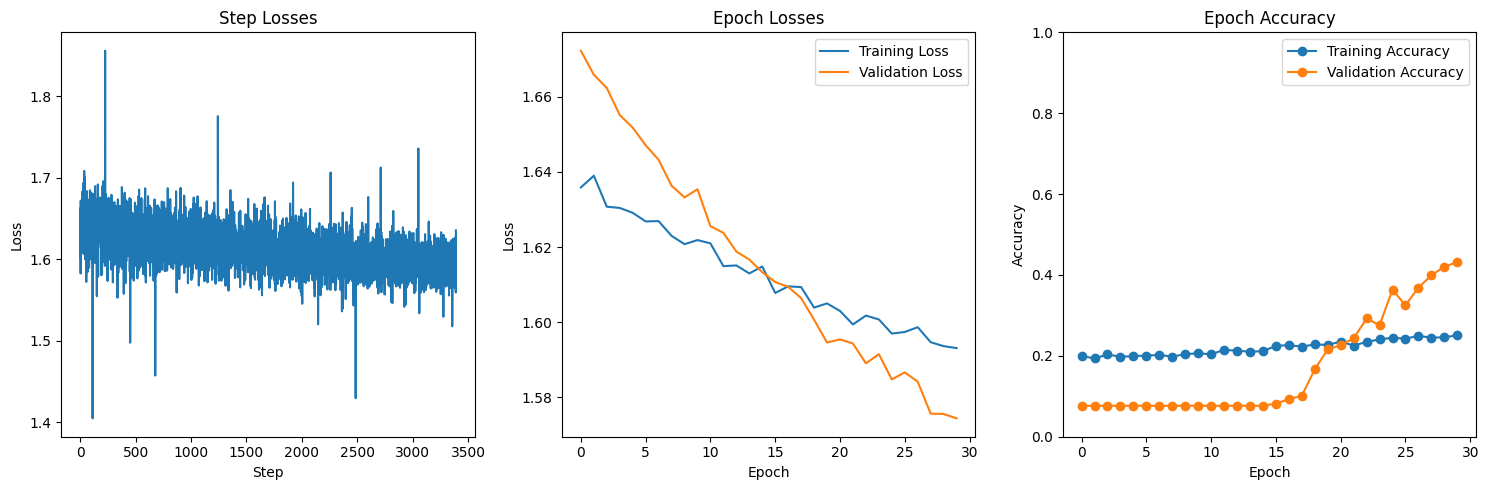

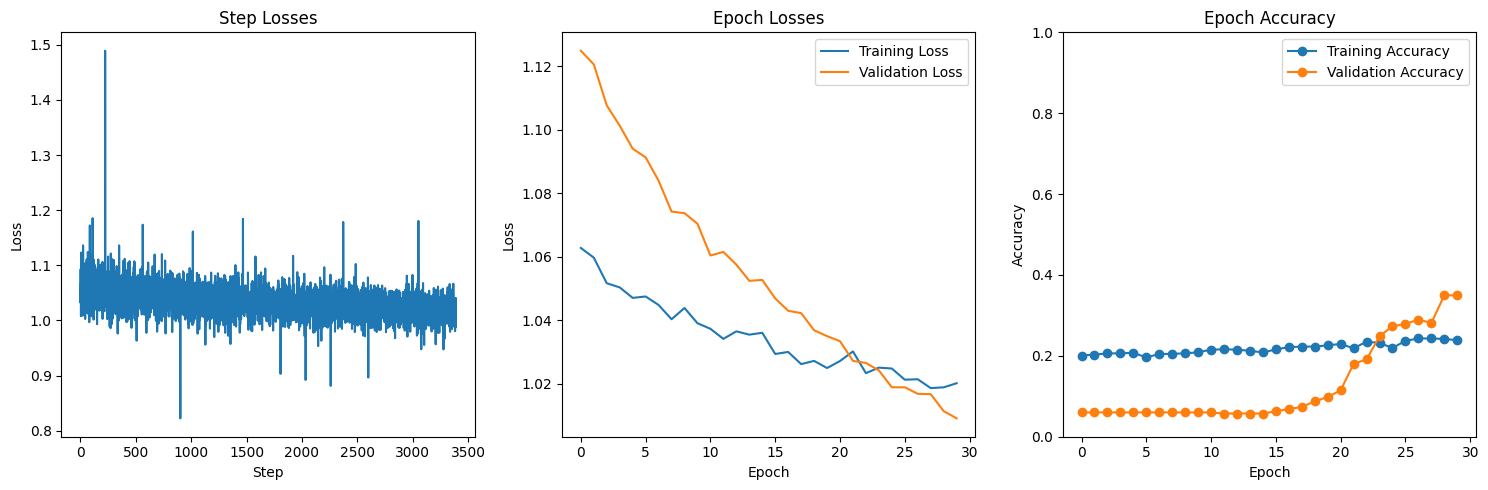

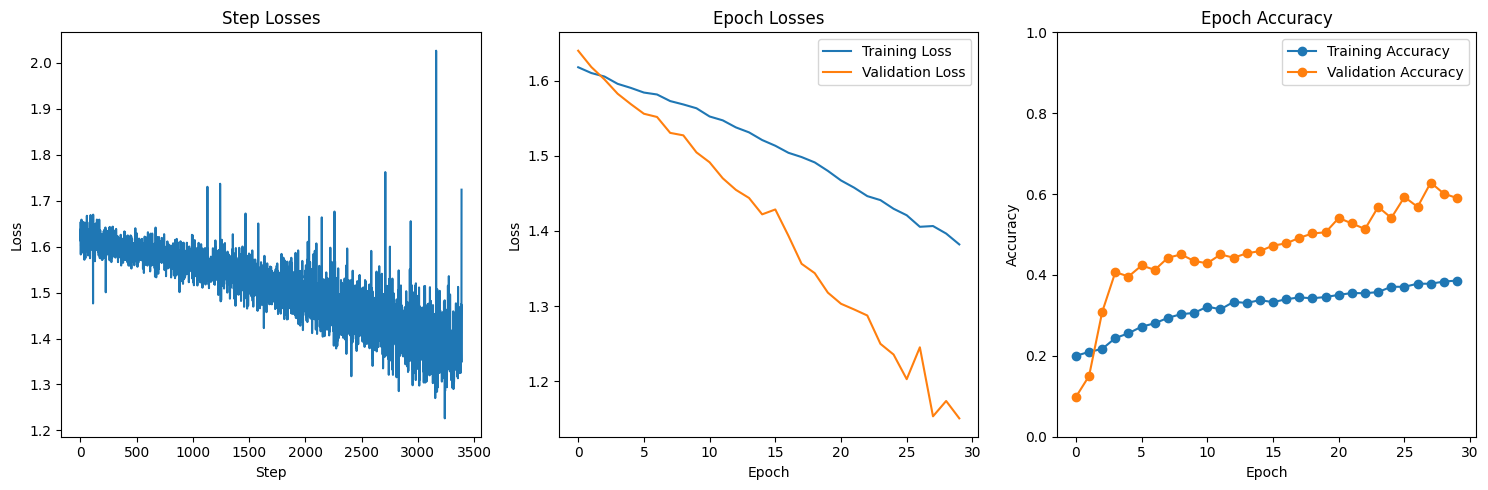

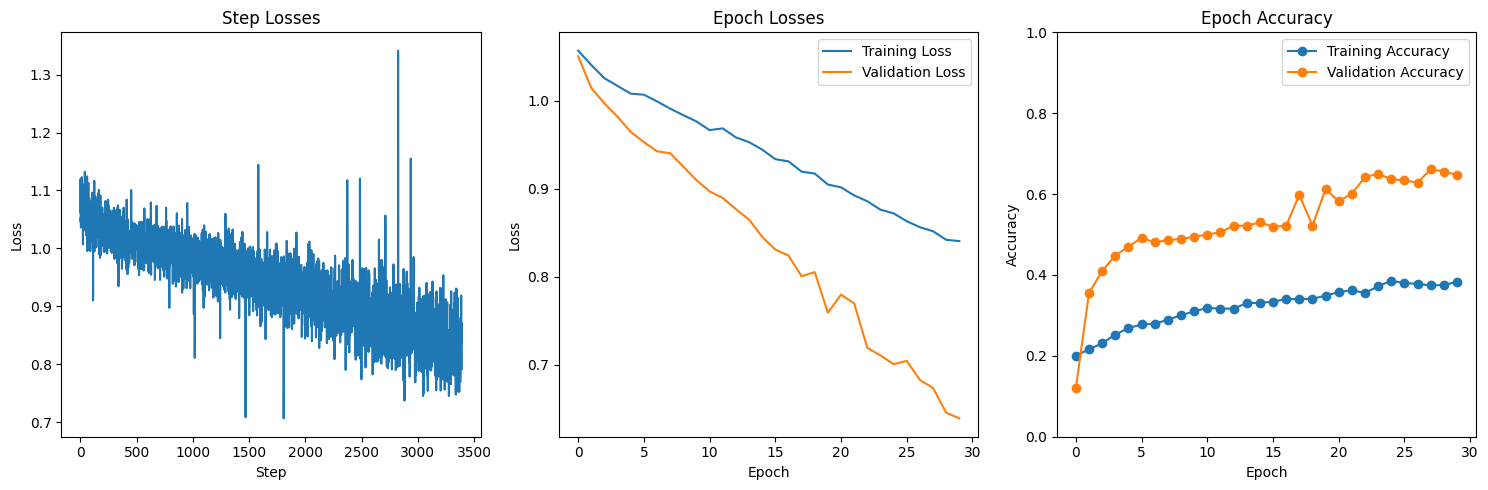

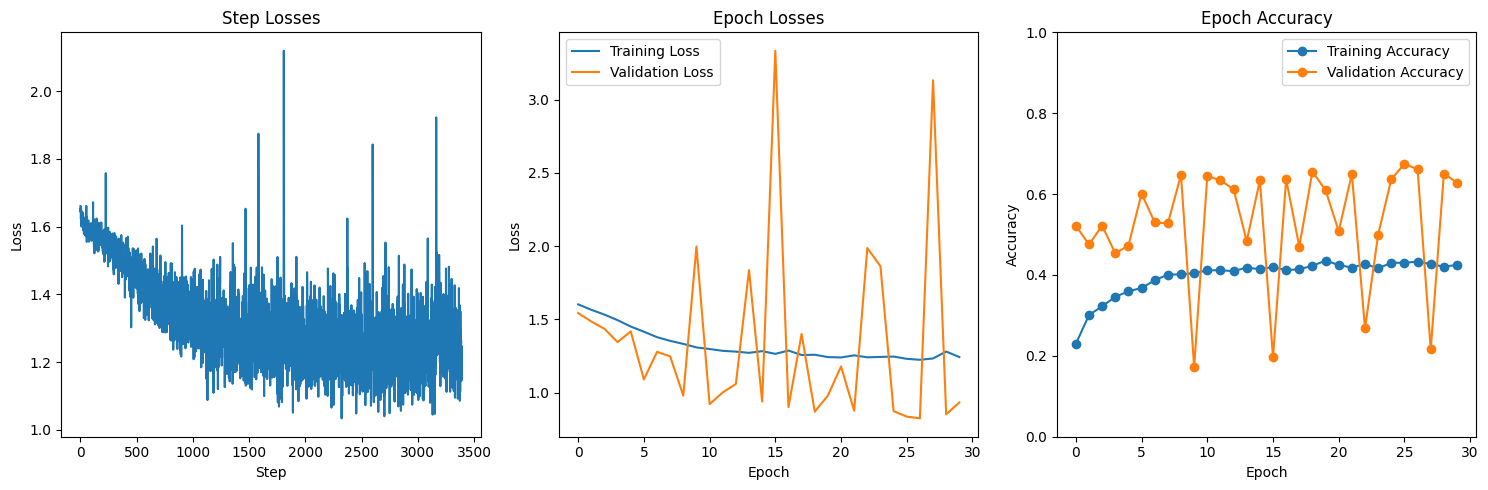

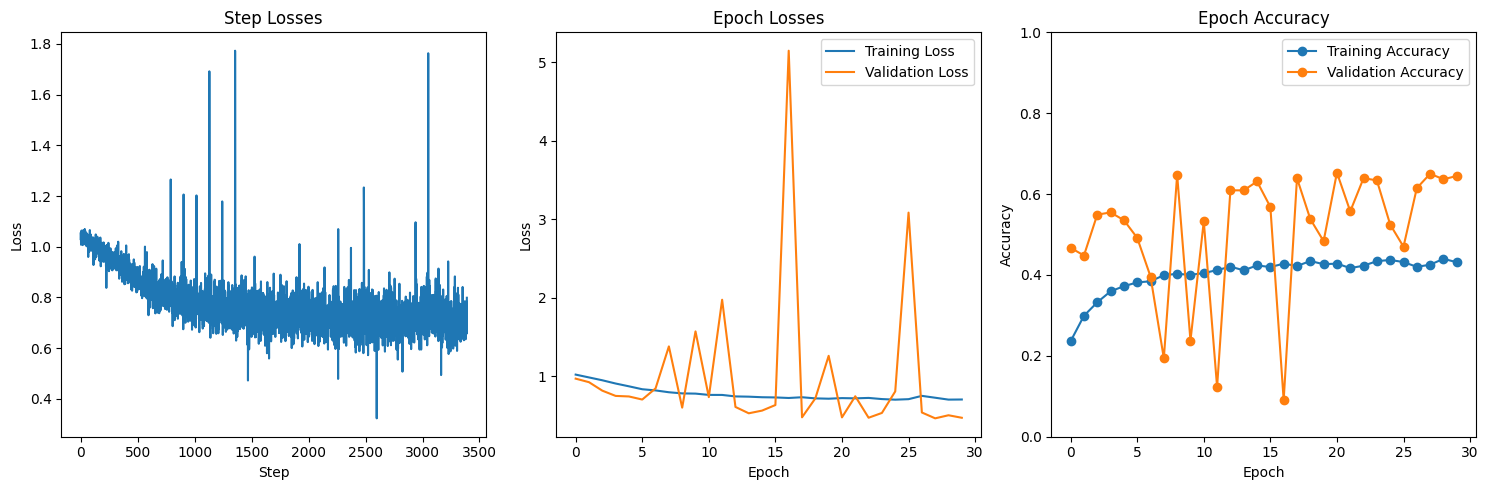

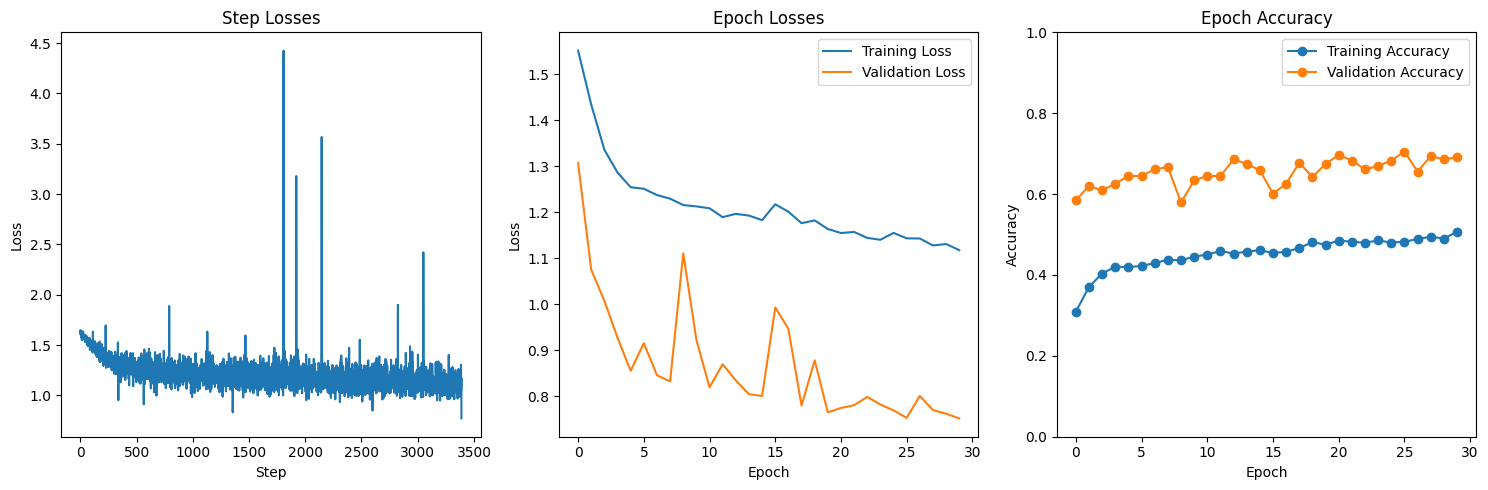

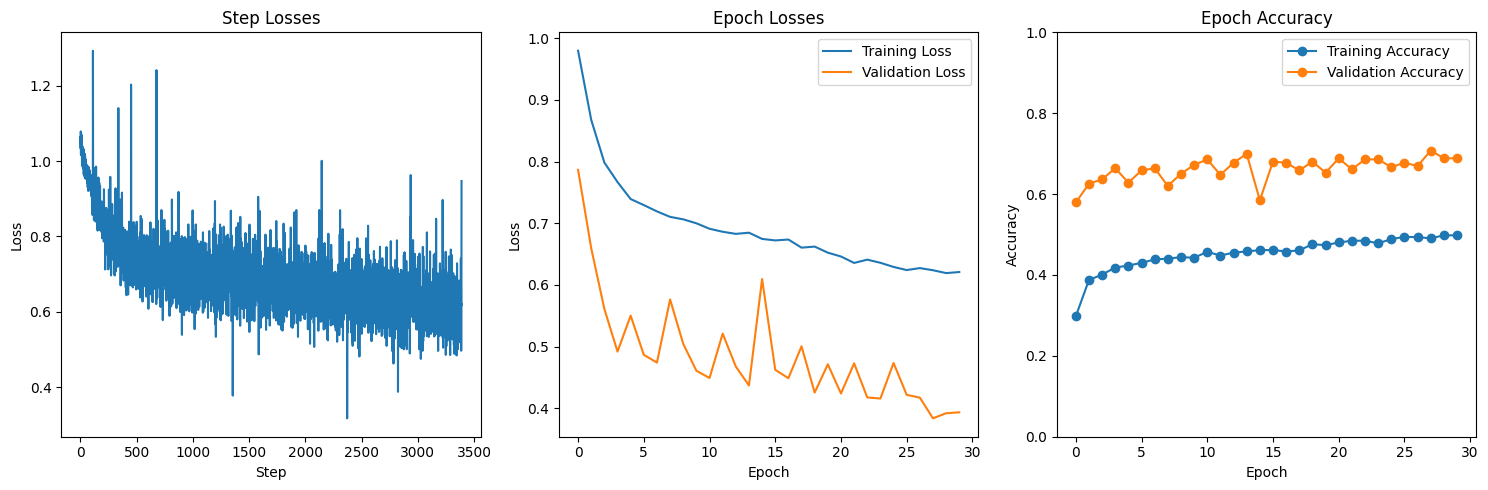

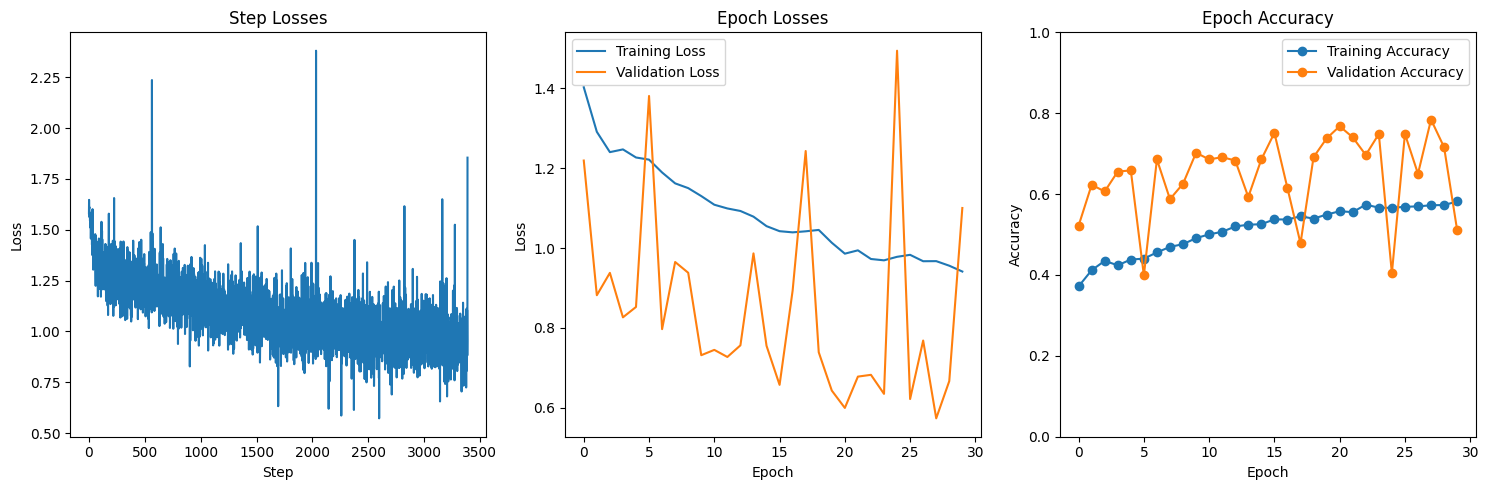

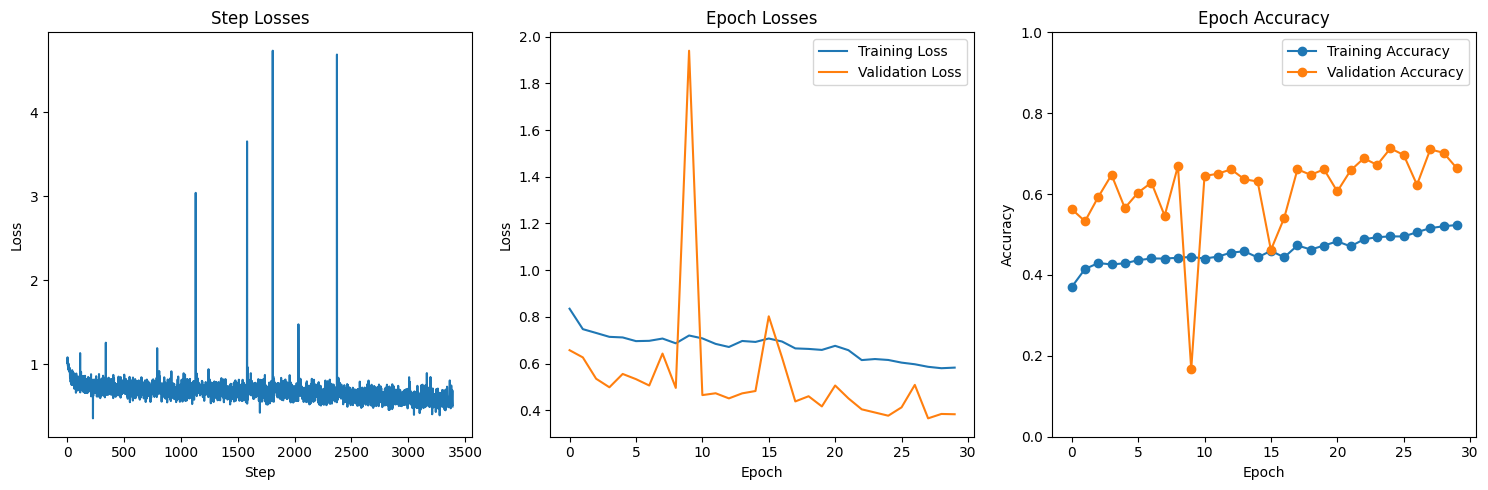

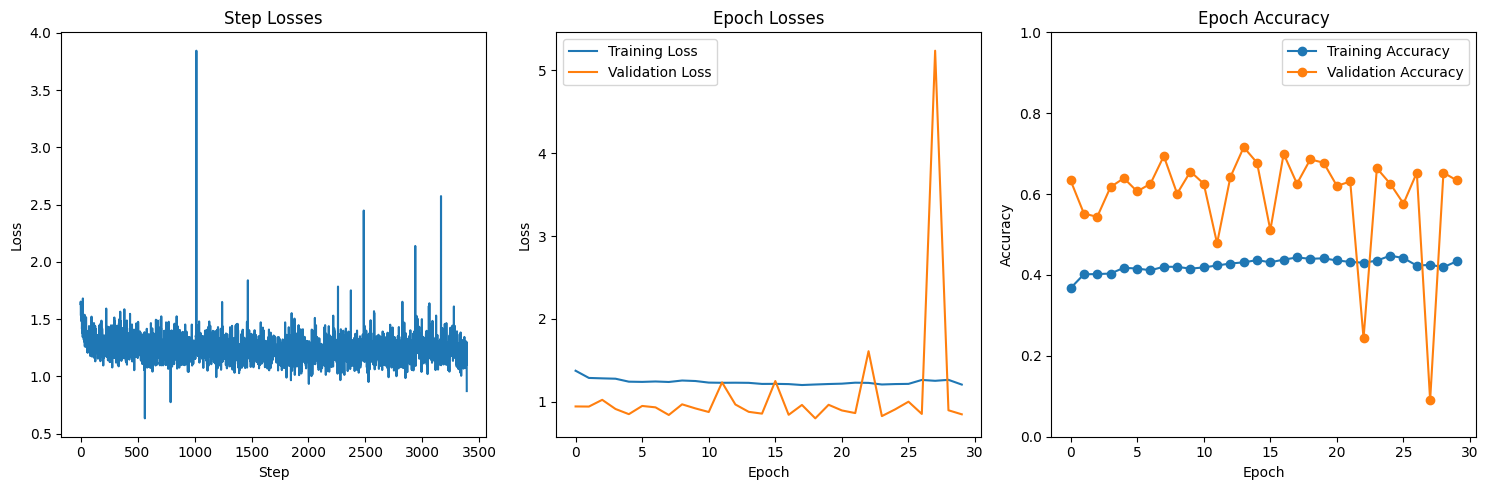

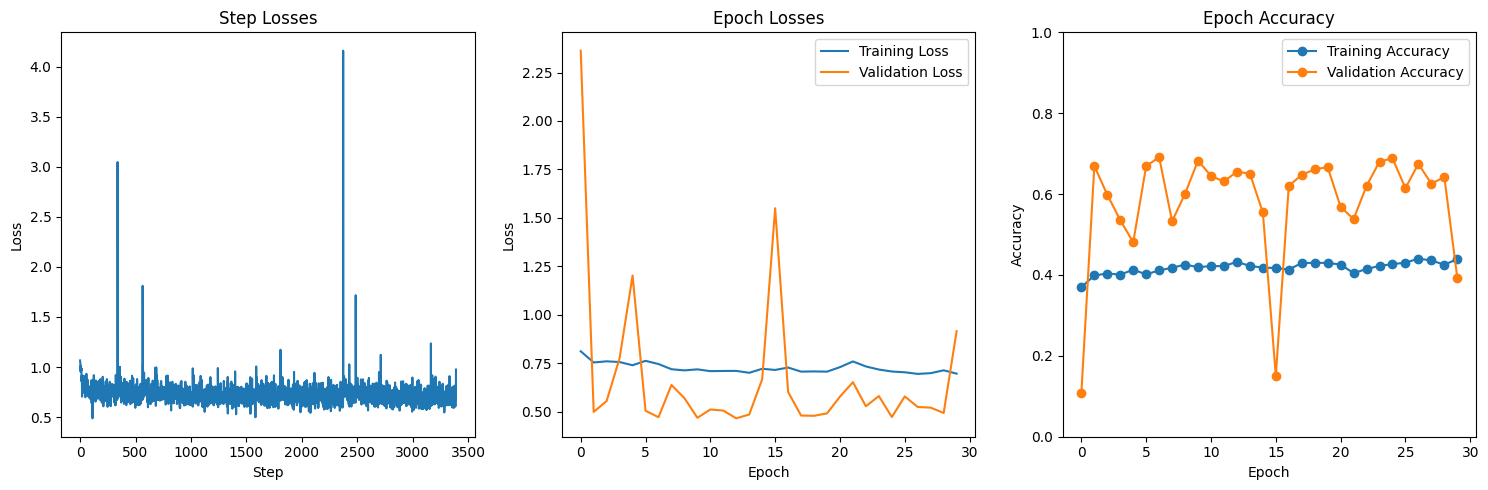

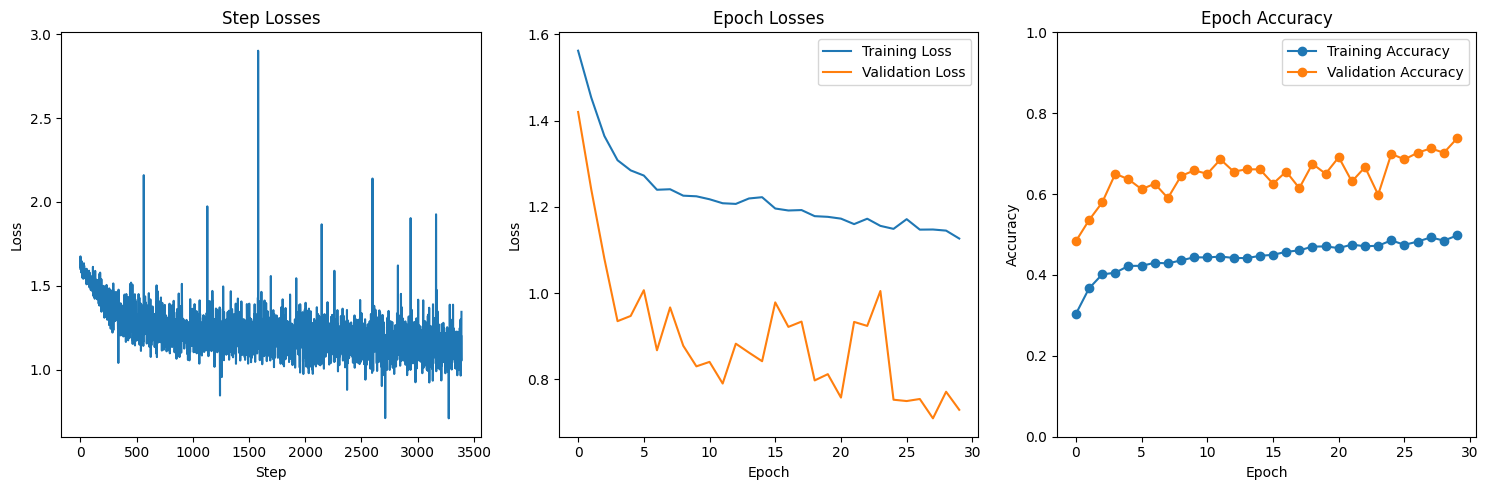

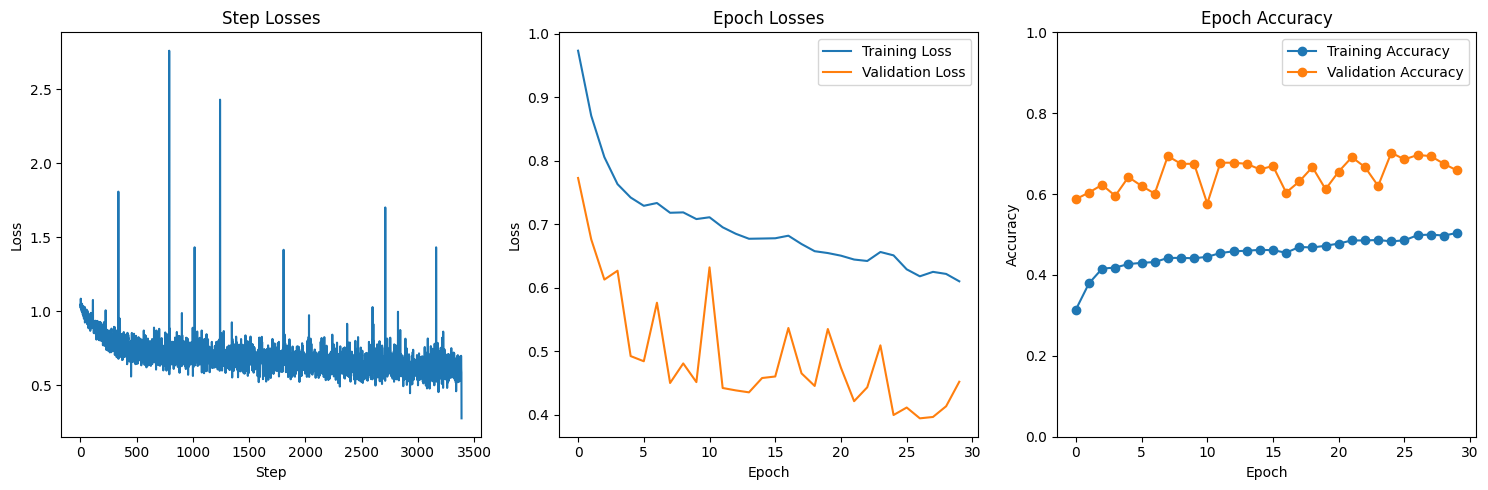

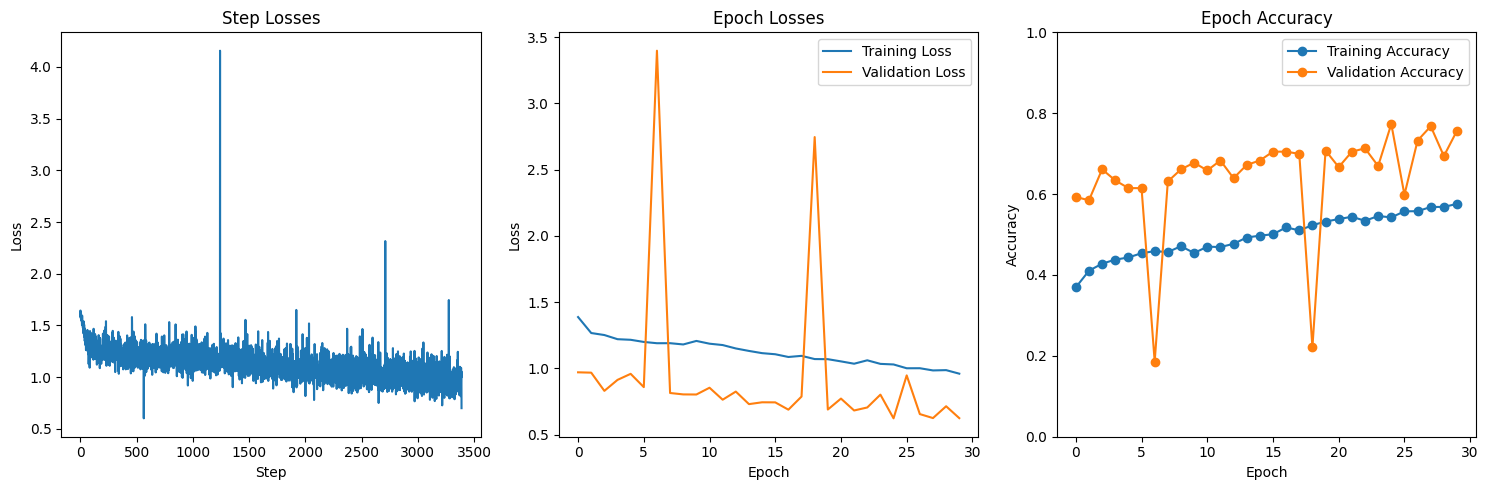

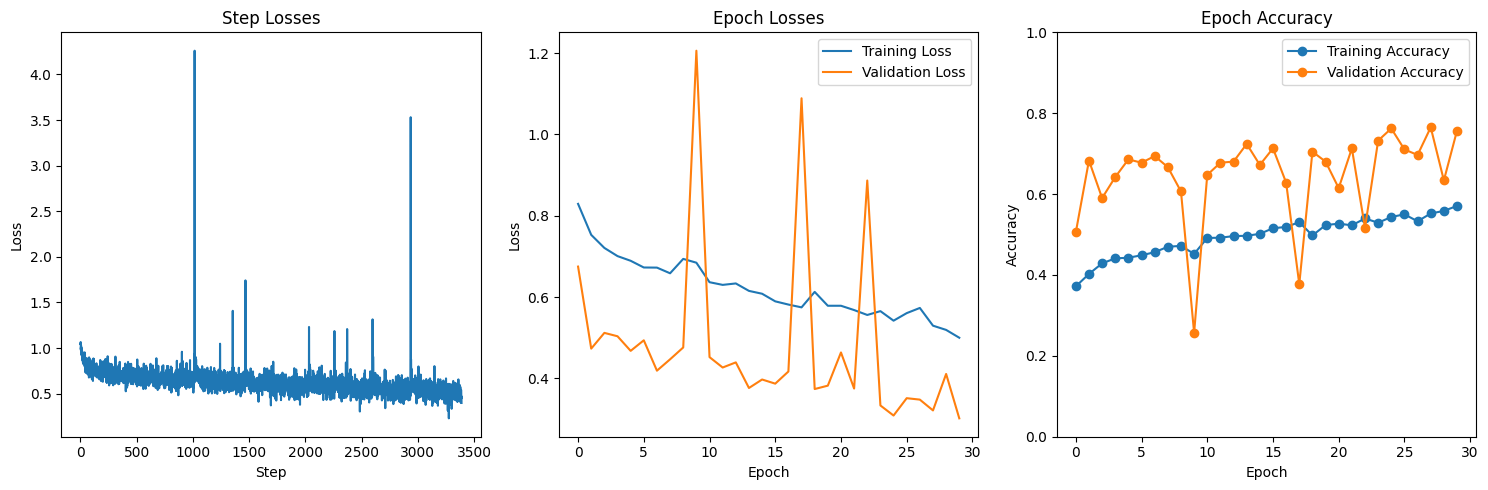

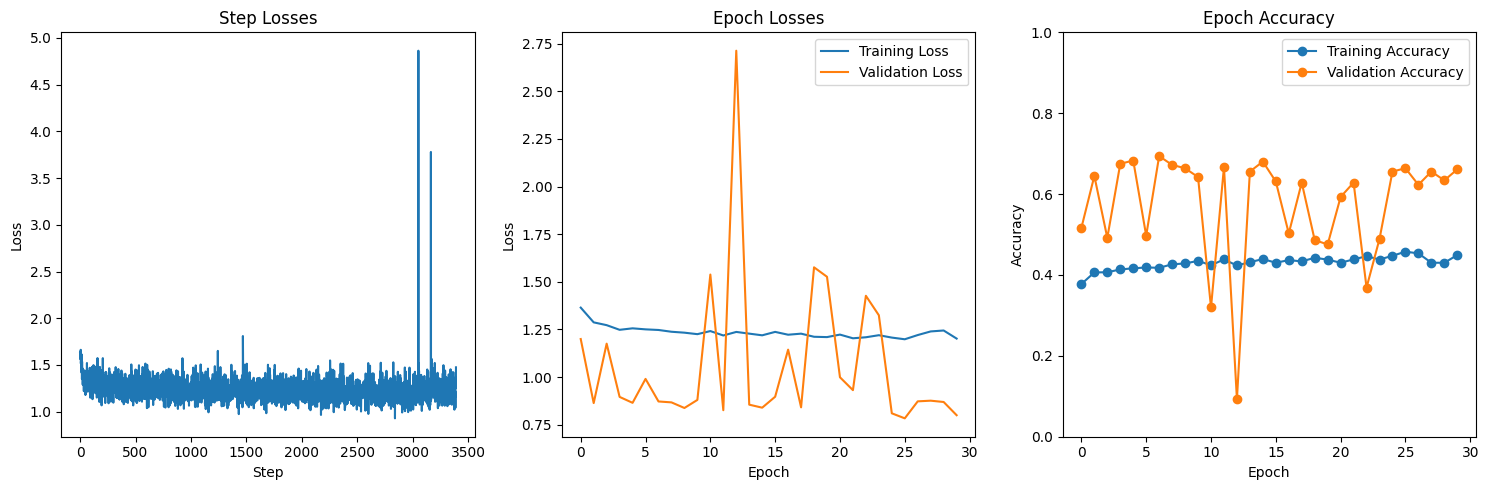

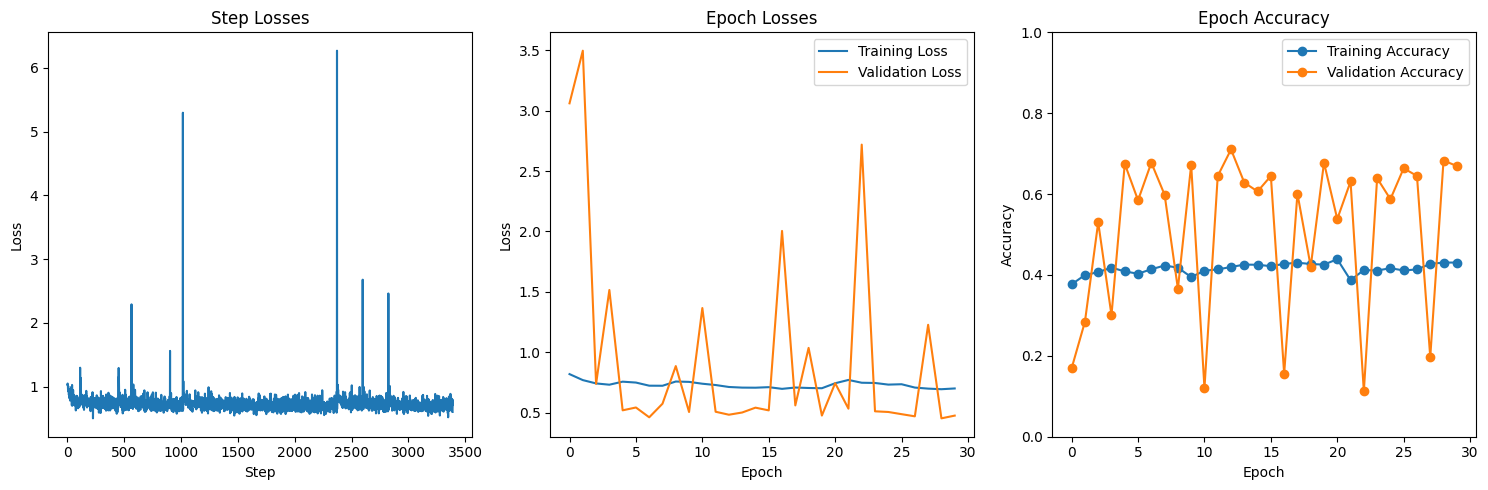

In [ ]:
def model_fn():
    return Simone2()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone2",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )